In [1]:
# imports

import torchaudio
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from IPython.display import Audio
from tqdm import tqdm
import os
from PIL import Image

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# CPPN implementation

Notes:
- increasing the number of layers increases visual complexity and sharpness
- increasing the hidden size also increases complexity/sharpness
- increasing the latent size does ? 

In [2]:
# CPPN network

def CPPN(hidden_size=32, latent_size=20):

    model = nn.Sequential(
        nn.Linear(3 + latent_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        # nn.Linear(hidden_size, hidden_size),
        # nn.Tanh(),
        # nn.Linear(hidden_size, hidden_size),
        # nn.Tanh(),
        # nn.Linear(hidden_size, hidden_size),
        # nn.Tanh(),
        nn.Linear(hidden_size, 3),
        nn.Sigmoid(),
    ).to(device)

    # re-initialize linear layers with standard Gaussian distribution
    with torch.no_grad():
        for i in range(0, len(model), 2):
            model[i].weight = torch.nn.Parameter(torch.randn_like(model[i].weight))

    return model

model = CPPN()
print(model)

Sequential(
  (0): Linear(in_features=23, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=32, bias=True)
  (9): Tanh()
  (10): Linear(in_features=32, out_features=3, bias=True)
  (11): Sigmoid()
)


In [3]:
# helper function to generate inputs to CPPN

def gen_cppn_input(batch_size=1, x_dim=32, y_dim=32, scale=1.0, latents=None, latent_scale=1.0):
    '''
    calculates and returns a vector of x and y coordintes, and corresponding radius from the centre of image.
    latents is a vector of size (batch_size x latent_size)
    TODO finish documentation
    '''
    n_points = x_dim * y_dim
    x_range = scale*(np.arange(x_dim)-(x_dim-1)/2.0)/(x_dim-1)/0.5
    y_range = scale*(np.arange(y_dim)-(y_dim-1)/2.0)/(y_dim-1)/0.5
    x_mat = np.matmul(np.ones((y_dim, 1)), x_range.reshape((1, x_dim)))
    y_mat = np.matmul(y_range.reshape((y_dim, 1)), np.ones((1, x_dim)))
    r_mat = np.sqrt(x_mat*x_mat + y_mat*y_mat)
    x_mat = np.tile(x_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    y_mat = np.tile(y_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    r_mat = np.tile(r_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    r_mat = np.zeros_like(r_mat)
    print(np.max(r_mat))

    assert len(latents) == batch_size
    latent_size = latents.shape[1]
    latents *= latent_scale
    latents_tiled = np.tile(np.reshape(latents, [batch_size, 1, latent_size]), [1, n_points, 1])

    input = np.concatenate([x_mat, y_mat, r_mat, latents_tiled], axis=2)
    return torch.tensor(input, dtype=torch.float32).to(device)

In [4]:
# uncomment this cell to test CPPN implementation
# batch_size = 8
# x_dim = 640
# y_dim = 480
# scale = 10
# latent_size = 16
# latent_scale = 10

# latent_vecs = np.random.randn(batch_size, latent_size)

# input = gen_cppn_input(batch_size=batch_size, x_dim=x_dim, y_dim=y_dim, scale=10, latents=latent_vecs, latent_scale = latent_scale)
# print(input.shape)

# output = model(input)
# print(output.shape)

# output_imgs = torch.reshape(output, [batch_size, y_dim, x_dim, 3]).cpu().detach().numpy()
# print(output_imgs.shape)

# from matplotlib.colors import hsv_to_rgb

# fig, axes = plt.subplots(1, batch_size, figsize=(20, 10))
# for i, ax in enumerate(axes):
#     ax.imshow(hsv_to_rgb(output_imgs[i]))

In [7]:
def load_training_image(img_path, latent_size, coord_scale=1, resolution=200, use_hsv=False):
    raw_img = Image.open(img_path).convert('RGB')
    raw_width, raw_height = raw_img.size
    aspect = raw_width / raw_height
    raw_img = raw_img.resize((int(resolution * aspect), resolution));
    img = np.array(raw_img) / 255.
    if use_hsv:
        img = rgb_to_hsv(img)
    width, height = img.shape[0], img.shape[1] # may be flipped?
    input = gen_cppn_input(batch_size=1, x_dim=width, y_dim=height, scale=coord_scale, latents=np.zeros((1, latent_size)), latent_scale=1)[0]
    labels = torch.tensor(img, dtype=torch.float).reshape((width * height, 3))

    return input, labels

inputs, labels = load_training_image('melodrama_cover.png', 16)

FileNotFoundError: ignored

# Audio I/O and feature extraction

In [8]:
# download audio file from youtube
# to use your own audio file, upload it as /content/audio.wav
url = "https://www.youtube.com/watch?v=BtvJaNeELic"

!pip install youtube-dl
!youtube-dl -f "bestaudio[ext=m4a]" {url} --output "audio.m4a"
!ffmpeg -i audio.m4a audio.wav -loglevel 0

     |████████████████████████████████| 1.9 MB 12.2 MB/s 
[youtube] BtvJaNeELic: Downloading webpage
[youtube] BtvJaNeELic: Downloading player 9cdfefcf
[download] Destination: audio.m4a
[download] 100% of 2.68MiB in 00:34
[ffmpeg] Correcting container in "audio.m4a"


sample rate 44100
audio shape torch.Size([7646208])
spectrogram shape torch.Size([5202, 16])


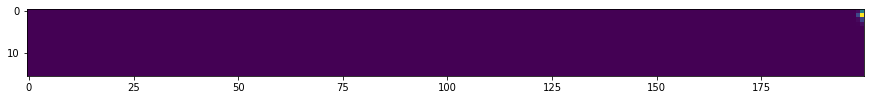

In [9]:
# audio parameters
audio_path = '/content/audio.wav'
target_fps = 30 # number of frames per second for output video
latent_size = 16 # frequency resolution (number of mel bins) for audio frame vectors

# load audio file
audio, sr = torchaudio.load(audio_path, normalize=True)
audio = audio[0]
print('sample rate', sr)
print('audio shape', audio.shape)

# feature extraction with a Mel spectrogram
hop_length = int(sr / target_fps)
transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=hop_length*2, n_mels=latent_size, hop_length=hop_length, win_length=hop_length * 2)
spectrogram = transform(audio)
spectrogram = spectrogram.T
spectrogram = spectrogram / torch.max(spectrogram) # normalize to range [0,1]
print('spectrogram shape', spectrogram.shape)

# visualize spectrogram
plt.figure(figsize=(15, 4))
plt.imshow(spectrogram.T[:, 0:200])

# play audio
# Audio(data=audio, rate=sr)

# Generate Output Video

run this cell multiple times to get a good looking base image

0.0
base image


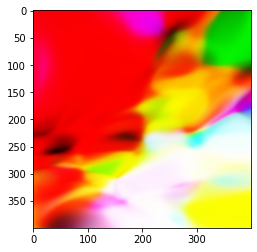

In [10]:
# output video parameters
x_dim = 400
y_dim = 400

# cppn parameters
coord_scale = 0.2
latent_scale = 0.5
use_hsv = False # whether to used the HSV color space, usually True for abstract art and False for using training images

# initialize CPPN
model = CPPN(hidden_size=32, latent_size=latent_size)

# generate test image with zero latent vector
input = gen_cppn_input(batch_size=1, x_dim=x_dim, y_dim=y_dim, scale=coord_scale, latents=np.zeros([1, latent_size]), latent_scale = latent_scale)
output = model(input)
output_img = torch.reshape(output, [y_dim, x_dim, 3]).cpu().detach().numpy()
if use_hsv:
    output_img = hsv_to_rgb(output_img)
plt.imshow(output_img)
print('base image')

Finished Training
0.0
After Training


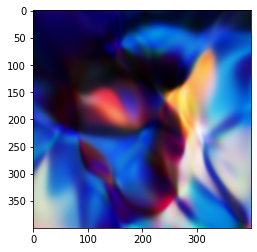

In [ ]:
# train CPPN to match a reference image
from IPython.display import clear_output

image = 'melodrama_cover.png'

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4);

inputs, labels = load_training_image(image, latent_size, coord_scale=coord_scale, use_hsv=use_hsv)
inputs = inputs.to(device)
labels = labels.to(device)

n_epochs = 1000 # don't set this too high, otherwise model will overfit and latent vector will not change anything
prev_loss = 0
model.train()
for epoch in range(n_epochs):
    loss = 0.0
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0: # display loss and show image every 100 epochs
        print(f'epoch {epoch}: loss={loss}, diff={loss - prev_loss}')
        prev_loss = loss
        plt.figure(1, figsize=(10, 5))
        output_img = torch.reshape(output, [200, 200, 3]).cpu().detach().numpy()
        if use_hsv:
            output_img = hsv_to_rgb(output_img)
        plt.imshow(output_img)
        plt.show()
        clear_output(wait=True)
print('Finished Training')

input = gen_cppn_input(batch_size=1, x_dim=x_dim, y_dim=y_dim, scale=coord_scale, latents=np.zeros([1, latent_size]), latent_scale = latent_scale)
output = model(input)
output_img = torch.reshape(output, [y_dim, x_dim, 3]).cpu().detach().numpy()
if use_hsv:
    output_img = hsv_to_rgb(output_img)
plt.imshow(output_img)
print('After Training')

sequential frames (above)
0.0
random frames (below)
0.0


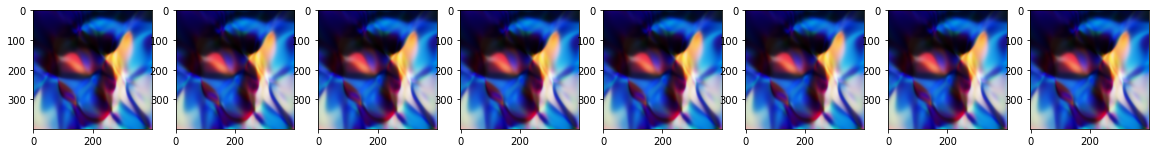

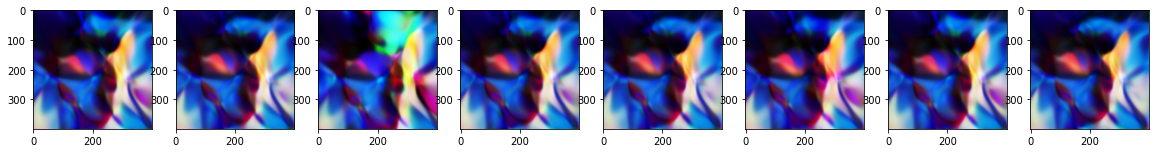

In [ ]:
# generate some test frames
num_frames = 8
latent_scale = 0.5

# test sequential frames to check smoothness
print('sequential frames (above)')

offset = 100
frames = spectrogram[offset:offset + num_frames, :]

input = gen_cppn_input(batch_size=num_frames, x_dim=x_dim, y_dim=y_dim, scale=coord_scale, latents=frames, latent_scale = latent_scale)
output = model(input)
output_imgs = torch.reshape(output, [num_frames, y_dim, x_dim, 3]).cpu().detach().numpy()

fig, axes = plt.subplots(1, num_frames, figsize=(20, 10))
for i, ax in enumerate(axes):
    if use_hsv:
        ax.imshow(hsv_to_rgb(output_imgs[i]))
    else:
        ax.imshow(output_imgs[i])

# test random frames to check variation
print('random frames (below)')
frame_indices = np.random.choice(spectrogram.shape[0], num_frames, replace=False)
frames = spectrogram[frame_indices, :]
input = gen_cppn_input(batch_size=num_frames, x_dim=x_dim, y_dim=y_dim, scale=coord_scale, latents=frames, latent_scale = latent_scale)
output = model(input)
output_imgs = torch.reshape(output, [num_frames, y_dim, x_dim, 3]).cpu().detach().numpy()

fig, axes = plt.subplots(1, num_frames, figsize=(20, 10))
for i, ax in enumerate(axes):
    if use_hsv:
        ax.imshow(hsv_to_rgb(output_imgs[i]))
    else:
        ax.imshow(output_imgs[i])

In [ ]:
# generate all frames
output_dir = '/content/img/'
%rm -r /content/img/
os.makedirs(output_dir, exist_ok=True)

print('generating frames')
for i, embedding in tqdm(enumerate(spectrogram), total=len(spectrogram)):
    latents = embedding[np.newaxis, :]
    input = gen_cppn_input(batch_size=1, x_dim=x_dim, y_dim=y_dim, scale=coord_scale, latents=latents, latent_scale=latent_scale)
    output = model(input)
    img = output[0].cpu().detach().numpy().reshape([y_dim, x_dim, 3])
    if use_hsv:
        img = hsv_to_rgb(img)
    plt.imsave(f'/content/img/{i:04d}.png', img)

# this cell can be stopped after a desired number of frames have been generated

generating frames


  0%|          | 0/5202 [00:00<?, ?it/s]

0.0


  0%|          | 1/5202 [00:00<12:28,  6.95it/s]

0.0


  0%|          | 2/5202 [00:00<12:15,  7.07it/s]

0.0


  0%|          | 3/5202 [00:00<12:47,  6.77it/s]

0.0


  0%|          | 4/5202 [00:00<12:37,  6.86it/s]

0.0


  0%|          | 5/5202 [00:00<12:30,  6.92it/s]

0.0


  0%|          | 6/5202 [00:00<12:22,  7.00it/s]

0.0


  0%|          | 7/5202 [00:01<12:24,  6.98it/s]

0.0


  0%|          | 8/5202 [00:01<12:21,  7.01it/s]

0.0


  0%|          | 9/5202 [00:01<12:29,  6.93it/s]

0.0


  0%|          | 10/5202 [00:01<12:34,  6.88it/s]

0.0


  0%|          | 11/5202 [00:01<12:30,  6.92it/s]

0.0


  0%|          | 12/5202 [00:01<12:28,  6.93it/s]

0.0


  0%|          | 13/5202 [00:01<12:23,  6.98it/s]

0.0


  0%|          | 14/5202 [00:02<12:20,  7.00it/s]

0.0


  0%|          | 15/5202 [00:02<12:11,  7.09it/s]

0.0


  0%|          | 16/5202 [00:02<12:01,  7.19it/s]

0.0


  0%|          | 17/5202 [00:02<12:07,  7.13it/s]

0.0


  0%|          | 18/5202 [00:02<12:06,  7.14it/s]

0.0


  0%|          | 19/5202 [00:02<12:10,  7.09it/s]

0.0


  0%|          | 20/5202 [00:02<12:09,  7.10it/s]

0.0


  0%|          | 21/5202 [00:02<12:12,  7.07it/s]

0.0


  0%|          | 22/5202 [00:03<12:02,  7.17it/s]

0.0


  0%|          | 23/5202 [00:03<12:00,  7.19it/s]

0.0


  0%|          | 24/5202 [00:03<11:56,  7.23it/s]

0.0


  0%|          | 25/5202 [00:03<12:01,  7.18it/s]

0.0


  0%|          | 26/5202 [00:03<12:05,  7.14it/s]

0.0


  1%|          | 27/5202 [00:03<12:10,  7.09it/s]

0.0


  1%|          | 28/5202 [00:03<12:15,  7.03it/s]

0.0


  1%|          | 29/5202 [00:04<12:06,  7.12it/s]

0.0


  1%|          | 30/5202 [00:04<12:04,  7.14it/s]

0.0


  1%|          | 31/5202 [00:04<12:00,  7.18it/s]

0.0


  1%|          | 32/5202 [00:04<12:05,  7.12it/s]

0.0


  1%|          | 33/5202 [00:04<12:14,  7.03it/s]

0.0


  1%|          | 34/5202 [00:04<12:06,  7.11it/s]

0.0


  1%|          | 35/5202 [00:04<12:07,  7.10it/s]

0.0


  1%|          | 36/5202 [00:05<12:02,  7.15it/s]

0.0


  1%|          | 37/5202 [00:05<11:59,  7.18it/s]

0.0


  1%|          | 38/5202 [00:05<11:51,  7.26it/s]

0.0


  1%|          | 39/5202 [00:05<11:48,  7.29it/s]

0.0


  1%|          | 40/5202 [00:05<11:51,  7.26it/s]

0.0


  1%|          | 41/5202 [00:05<11:55,  7.22it/s]

0.0


  1%|          | 42/5202 [00:05<12:03,  7.13it/s]

0.0


  1%|          | 43/5202 [00:06<11:58,  7.18it/s]

0.0


  1%|          | 44/5202 [00:06<11:56,  7.20it/s]

0.0


  1%|          | 45/5202 [00:06<11:55,  7.21it/s]

0.0


  1%|          | 46/5202 [00:06<11:52,  7.23it/s]

0.0


  1%|          | 47/5202 [00:06<12:03,  7.12it/s]

0.0


  1%|          | 48/5202 [00:06<12:03,  7.12it/s]

0.0


  1%|          | 49/5202 [00:06<12:06,  7.09it/s]

0.0


  1%|          | 50/5202 [00:07<12:02,  7.13it/s]

0.0


  1%|          | 51/5202 [00:07<11:56,  7.18it/s]

0.0


  1%|          | 52/5202 [00:07<11:58,  7.17it/s]

0.0


  1%|          | 53/5202 [00:07<11:52,  7.23it/s]

0.0


  1%|          | 54/5202 [00:07<12:01,  7.14it/s]

0.0


  1%|          | 55/5202 [00:07<12:02,  7.12it/s]

0.0


  1%|          | 56/5202 [00:07<12:06,  7.08it/s]

0.0


  1%|          | 57/5202 [00:08<12:11,  7.03it/s]

0.0


  1%|          | 58/5202 [00:08<12:04,  7.10it/s]

0.0


  1%|          | 59/5202 [00:08<12:02,  7.12it/s]

0.0


  1%|          | 60/5202 [00:08<12:00,  7.13it/s]

0.0


  1%|          | 61/5202 [00:08<12:02,  7.12it/s]

0.0


  1%|          | 62/5202 [00:08<12:06,  7.08it/s]

0.0


  1%|          | 63/5202 [00:08<12:02,  7.11it/s]

0.0


  1%|          | 64/5202 [00:09<11:58,  7.15it/s]

0.0


  1%|          | 65/5202 [00:09<11:54,  7.19it/s]

0.0


  1%|▏         | 66/5202 [00:09<11:54,  7.19it/s]

0.0


  1%|▏         | 67/5202 [00:09<11:54,  7.19it/s]

0.0


  1%|▏         | 68/5202 [00:09<11:51,  7.21it/s]

0.0


  1%|▏         | 69/5202 [00:09<12:04,  7.09it/s]

0.0


  1%|▏         | 70/5202 [00:09<12:07,  7.06it/s]

0.0


  1%|▏         | 71/5202 [00:09<12:08,  7.04it/s]

0.0


  1%|▏         | 72/5202 [00:10<11:55,  7.17it/s]

0.0


  1%|▏         | 73/5202 [00:10<11:49,  7.23it/s]

0.0


  1%|▏         | 74/5202 [00:10<11:42,  7.30it/s]

0.0


  1%|▏         | 75/5202 [00:10<11:43,  7.28it/s]

0.0


  1%|▏         | 76/5202 [00:10<12:03,  7.08it/s]

0.0


  1%|▏         | 77/5202 [00:10<12:20,  6.92it/s]

0.0


  1%|▏         | 78/5202 [00:10<12:18,  6.94it/s]

0.0


  2%|▏         | 79/5202 [00:11<12:07,  7.04it/s]

0.0


  2%|▏         | 80/5202 [00:11<11:58,  7.13it/s]

0.0


  2%|▏         | 81/5202 [00:11<11:54,  7.17it/s]

0.0


  2%|▏         | 82/5202 [00:11<11:52,  7.18it/s]

0.0


  2%|▏         | 83/5202 [00:11<12:09,  7.02it/s]

0.0


  2%|▏         | 84/5202 [00:11<12:11,  6.99it/s]

0.0


  2%|▏         | 85/5202 [00:11<12:08,  7.03it/s]

0.0


  2%|▏         | 86/5202 [00:12<11:55,  7.15it/s]

0.0


  2%|▏         | 87/5202 [00:12<11:49,  7.21it/s]

0.0


  2%|▏         | 88/5202 [00:12<11:49,  7.21it/s]

0.0


  2%|▏         | 89/5202 [00:12<11:55,  7.15it/s]

0.0


  2%|▏         | 90/5202 [00:12<11:53,  7.17it/s]

0.0


  2%|▏         | 91/5202 [00:12<12:02,  7.08it/s]

0.0


  2%|▏         | 92/5202 [00:12<12:06,  7.04it/s]

0.0


  2%|▏         | 93/5202 [00:13<11:58,  7.11it/s]

0.0


  2%|▏         | 94/5202 [00:13<11:53,  7.16it/s]

0.0


  2%|▏         | 95/5202 [00:13<11:54,  7.15it/s]

0.0


  2%|▏         | 96/5202 [00:13<11:54,  7.15it/s]

0.0


  2%|▏         | 97/5202 [00:13<12:05,  7.04it/s]

0.0


  2%|▏         | 98/5202 [00:13<12:20,  6.89it/s]

0.0


  2%|▏         | 99/5202 [00:13<12:20,  6.89it/s]

0.0


  2%|▏         | 100/5202 [00:14<12:11,  6.98it/s]

0.0


  2%|▏         | 101/5202 [00:14<12:06,  7.02it/s]

0.0


  2%|▏         | 102/5202 [00:14<12:03,  7.05it/s]

0.0


  2%|▏         | 103/5202 [00:14<12:13,  6.95it/s]

0.0


  2%|▏         | 104/5202 [00:14<12:11,  6.97it/s]

0.0


  2%|▏         | 105/5202 [00:14<12:18,  6.90it/s]

0.0


  2%|▏         | 106/5202 [00:14<12:17,  6.91it/s]

0.0


  2%|▏         | 107/5202 [00:15<12:14,  6.94it/s]

0.0


  2%|▏         | 108/5202 [00:15<12:09,  6.99it/s]

0.0


  2%|▏         | 109/5202 [00:15<12:16,  6.92it/s]

0.0


  2%|▏         | 110/5202 [00:15<12:06,  7.01it/s]

0.0


  2%|▏         | 111/5202 [00:15<12:03,  7.03it/s]

0.0


  2%|▏         | 112/5202 [00:15<12:11,  6.96it/s]

0.0


  2%|▏         | 113/5202 [00:15<12:09,  6.97it/s]

0.0


  2%|▏         | 114/5202 [00:16<12:04,  7.02it/s]

0.0


  2%|▏         | 115/5202 [00:16<12:07,  7.00it/s]

0.0


  2%|▏         | 116/5202 [00:16<11:57,  7.09it/s]

0.0


  2%|▏         | 117/5202 [00:16<11:51,  7.15it/s]

0.0


  2%|▏         | 118/5202 [00:16<11:49,  7.17it/s]

0.0


  2%|▏         | 119/5202 [00:16<11:46,  7.19it/s]

0.0


  2%|▏         | 120/5202 [00:16<11:59,  7.06it/s]

0.0


  2%|▏         | 121/5202 [00:17<12:00,  7.06it/s]

0.0


  2%|▏         | 122/5202 [00:17<12:05,  7.00it/s]

0.0


  2%|▏         | 123/5202 [00:17<12:03,  7.02it/s]

0.0


  2%|▏         | 124/5202 [00:17<12:06,  6.99it/s]

0.0


  2%|▏         | 125/5202 [00:17<12:05,  7.00it/s]

0.0


  2%|▏         | 126/5202 [00:17<12:01,  7.04it/s]

0.0


  2%|▏         | 127/5202 [00:17<12:04,  7.00it/s]

0.0


  2%|▏         | 128/5202 [00:18<12:00,  7.04it/s]

0.0


  2%|▏         | 129/5202 [00:18<12:04,  7.00it/s]

0.0


  2%|▏         | 130/5202 [00:18<12:00,  7.04it/s]

0.0


  3%|▎         | 131/5202 [00:18<11:51,  7.13it/s]

0.0


  3%|▎         | 132/5202 [00:18<11:50,  7.14it/s]

0.0


  3%|▎         | 133/5202 [00:18<11:47,  7.16it/s]

0.0


  3%|▎         | 134/5202 [00:18<11:58,  7.06it/s]

0.0


  3%|▎         | 135/5202 [00:19<12:12,  6.92it/s]

0.0


  3%|▎         | 136/5202 [00:19<12:15,  6.89it/s]

0.0


  3%|▎         | 137/5202 [00:19<12:11,  6.92it/s]

0.0


  3%|▎         | 138/5202 [00:19<11:56,  7.07it/s]

0.0


  3%|▎         | 139/5202 [00:19<11:43,  7.19it/s]

0.0


  3%|▎         | 140/5202 [00:19<11:45,  7.18it/s]

0.0


  3%|▎         | 141/5202 [00:19<11:53,  7.09it/s]

0.0


  3%|▎         | 142/5202 [00:20<11:53,  7.09it/s]

0.0


  3%|▎         | 143/5202 [00:20<11:51,  7.11it/s]

0.0


  3%|▎         | 144/5202 [00:20<11:47,  7.15it/s]

0.0


  3%|▎         | 145/5202 [00:20<11:44,  7.18it/s]

0.0


  3%|▎         | 146/5202 [00:20<11:38,  7.24it/s]

0.0


  3%|▎         | 147/5202 [00:20<11:39,  7.23it/s]

0.0


  3%|▎         | 148/5202 [00:20<11:42,  7.19it/s]

0.0


  3%|▎         | 149/5202 [00:21<11:44,  7.17it/s]

0.0


  3%|▎         | 150/5202 [00:21<12:03,  6.98it/s]

0.0


  3%|▎         | 151/5202 [00:21<12:05,  6.96it/s]

0.0


  3%|▎         | 152/5202 [00:21<11:52,  7.09it/s]

0.0


  3%|▎         | 153/5202 [00:21<11:52,  7.09it/s]

0.0


  3%|▎         | 154/5202 [00:21<11:56,  7.05it/s]

0.0


  3%|▎         | 155/5202 [00:21<12:01,  6.99it/s]

0.0


  3%|▎         | 156/5202 [00:22<12:11,  6.89it/s]

0.0


  3%|▎         | 157/5202 [00:22<12:03,  6.98it/s]

0.0


  3%|▎         | 158/5202 [00:22<11:56,  7.04it/s]

0.0


  3%|▎         | 159/5202 [00:22<11:52,  7.07it/s]

0.0


  3%|▎         | 160/5202 [00:22<11:47,  7.13it/s]

0.0


  3%|▎         | 161/5202 [00:22<11:39,  7.21it/s]

0.0


  3%|▎         | 162/5202 [00:22<11:35,  7.24it/s]

0.0


  3%|▎         | 163/5202 [00:23<11:57,  7.03it/s]

0.0


  3%|▎         | 164/5202 [00:23<11:51,  7.08it/s]

0.0


  3%|▎         | 165/5202 [00:23<11:45,  7.14it/s]

0.0


  3%|▎         | 166/5202 [00:23<11:39,  7.20it/s]

0.0


  3%|▎         | 167/5202 [00:23<11:39,  7.20it/s]

0.0


  3%|▎         | 168/5202 [00:23<11:42,  7.17it/s]

0.0


  3%|▎         | 169/5202 [00:23<11:41,  7.17it/s]

0.0


  3%|▎         | 170/5202 [00:23<11:51,  7.07it/s]

0.0


  3%|▎         | 171/5202 [00:24<11:44,  7.14it/s]

0.0


  3%|▎         | 172/5202 [00:24<11:35,  7.24it/s]

0.0


  3%|▎         | 173/5202 [00:24<11:34,  7.24it/s]

0.0


  3%|▎         | 174/5202 [00:24<11:32,  7.26it/s]

0.0


  3%|▎         | 175/5202 [00:24<11:39,  7.19it/s]

0.0


  3%|▎         | 176/5202 [00:24<11:37,  7.20it/s]

0.0


  3%|▎         | 177/5202 [00:24<11:47,  7.10it/s]

0.0


  3%|▎         | 178/5202 [00:25<11:50,  7.07it/s]

0.0


  3%|▎         | 179/5202 [00:25<11:44,  7.13it/s]

0.0


  3%|▎         | 180/5202 [00:25<11:41,  7.16it/s]

0.0


  3%|▎         | 181/5202 [00:25<11:36,  7.21it/s]

0.0


  3%|▎         | 182/5202 [00:25<11:48,  7.08it/s]

0.0


  4%|▎         | 183/5202 [00:25<11:43,  7.14it/s]

0.0


  4%|▎         | 184/5202 [00:25<11:43,  7.13it/s]

0.0


  4%|▎         | 185/5202 [00:26<11:55,  7.02it/s]

0.0


  4%|▎         | 186/5202 [00:26<11:43,  7.13it/s]

0.0


  4%|▎         | 187/5202 [00:26<11:40,  7.16it/s]

0.0


  4%|▎         | 188/5202 [00:26<11:40,  7.16it/s]

0.0


  4%|▎         | 189/5202 [00:26<11:42,  7.14it/s]

0.0


  4%|▎         | 190/5202 [00:26<11:39,  7.17it/s]

0.0


  4%|▎         | 191/5202 [00:26<11:42,  7.13it/s]

0.0


  4%|▎         | 192/5202 [00:27<11:57,  6.98it/s]

0.0


  4%|▎         | 193/5202 [00:27<11:49,  7.06it/s]

0.0


  4%|▎         | 194/5202 [00:27<11:44,  7.10it/s]

0.0


  4%|▎         | 195/5202 [00:27<11:40,  7.15it/s]

0.0


  4%|▍         | 196/5202 [00:27<11:41,  7.13it/s]

0.0


  4%|▍         | 197/5202 [00:27<11:35,  7.20it/s]

0.0


  4%|▍         | 198/5202 [00:27<11:34,  7.21it/s]

0.0


  4%|▍         | 199/5202 [00:28<11:34,  7.20it/s]

0.0


  4%|▍         | 200/5202 [00:28<11:32,  7.22it/s]

0.0


  4%|▍         | 201/5202 [00:28<11:35,  7.19it/s]

0.0


  4%|▍         | 202/5202 [00:28<11:43,  7.11it/s]

0.0


  4%|▍         | 203/5202 [00:28<11:44,  7.09it/s]

0.0


  4%|▍         | 204/5202 [00:28<11:39,  7.14it/s]

0.0


  4%|▍         | 205/5202 [00:28<11:35,  7.18it/s]

0.0


  4%|▍         | 206/5202 [00:29<11:43,  7.10it/s]

0.0


  4%|▍         | 207/5202 [00:29<11:53,  7.00it/s]

0.0


  4%|▍         | 208/5202 [00:29<11:53,  7.00it/s]

0.0


  4%|▍         | 209/5202 [00:29<11:53,  6.99it/s]

0.0


  4%|▍         | 210/5202 [00:29<11:49,  7.03it/s]

0.0


  4%|▍         | 211/5202 [00:29<11:47,  7.06it/s]

0.0


  4%|▍         | 212/5202 [00:29<11:43,  7.09it/s]

0.0


  4%|▍         | 213/5202 [00:30<11:38,  7.14it/s]

0.0


  4%|▍         | 214/5202 [00:30<11:40,  7.12it/s]

0.0


  4%|▍         | 215/5202 [00:30<11:34,  7.18it/s]

0.0


  4%|▍         | 216/5202 [00:30<11:33,  7.19it/s]

0.0


  4%|▍         | 217/5202 [00:30<11:31,  7.20it/s]

0.0


  4%|▍         | 218/5202 [00:30<11:29,  7.23it/s]

0.0


  4%|▍         | 219/5202 [00:30<11:32,  7.19it/s]

0.0


  4%|▍         | 220/5202 [00:30<11:40,  7.12it/s]

0.0


  4%|▍         | 221/5202 [00:31<11:46,  7.05it/s]

0.0


  4%|▍         | 222/5202 [00:31<11:50,  7.01it/s]

0.0


  4%|▍         | 223/5202 [00:31<12:05,  6.86it/s]

0.0


  4%|▍         | 224/5202 [00:31<11:57,  6.94it/s]

0.0


  4%|▍         | 225/5202 [00:31<11:48,  7.02it/s]

0.0


  4%|▍         | 226/5202 [00:31<11:41,  7.09it/s]

0.0


  4%|▍         | 227/5202 [00:31<11:41,  7.09it/s]

0.0


  4%|▍         | 228/5202 [00:32<11:36,  7.14it/s]

0.0


  4%|▍         | 229/5202 [00:32<11:37,  7.13it/s]

0.0


  4%|▍         | 230/5202 [00:32<11:35,  7.15it/s]

0.0


  4%|▍         | 231/5202 [00:32<11:44,  7.06it/s]

0.0


  4%|▍         | 232/5202 [00:32<11:37,  7.12it/s]

0.0


  4%|▍         | 233/5202 [00:32<11:33,  7.16it/s]

0.0


  4%|▍         | 234/5202 [00:32<11:34,  7.16it/s]

0.0


  5%|▍         | 235/5202 [00:33<11:30,  7.19it/s]

0.0


  5%|▍         | 236/5202 [00:33<11:37,  7.12it/s]

0.0


  5%|▍         | 237/5202 [00:33<11:35,  7.14it/s]

0.0


  5%|▍         | 238/5202 [00:33<11:44,  7.04it/s]

0.0


  5%|▍         | 239/5202 [00:33<11:46,  7.02it/s]

0.0


  5%|▍         | 240/5202 [00:33<11:46,  7.02it/s]

0.0


  5%|▍         | 241/5202 [00:33<11:50,  6.98it/s]

0.0


  5%|▍         | 242/5202 [00:34<11:46,  7.02it/s]

0.0


  5%|▍         | 243/5202 [00:34<11:47,  7.01it/s]

0.0


  5%|▍         | 244/5202 [00:34<11:44,  7.04it/s]

0.0


  5%|▍         | 245/5202 [00:34<11:34,  7.14it/s]

0.0


  5%|▍         | 246/5202 [00:34<11:33,  7.15it/s]

0.0


  5%|▍         | 247/5202 [00:34<11:39,  7.08it/s]

0.0


  5%|▍         | 248/5202 [00:34<11:36,  7.12it/s]

0.0


  5%|▍         | 249/5202 [00:35<11:34,  7.13it/s]

0.0


  5%|▍         | 250/5202 [00:35<11:39,  7.08it/s]

0.0


  5%|▍         | 251/5202 [00:35<11:44,  7.02it/s]

0.0


  5%|▍         | 252/5202 [00:35<11:46,  7.01it/s]

0.0


  5%|▍         | 253/5202 [00:35<11:49,  6.98it/s]

0.0


  5%|▍         | 254/5202 [00:35<11:50,  6.96it/s]

0.0


  5%|▍         | 255/5202 [00:35<11:47,  7.00it/s]

0.0


  5%|▍         | 256/5202 [00:36<11:42,  7.04it/s]

0.0


  5%|▍         | 257/5202 [00:36<11:36,  7.10it/s]

0.0


  5%|▍         | 258/5202 [00:36<11:44,  7.02it/s]

0.0


  5%|▍         | 259/5202 [00:36<11:42,  7.03it/s]

0.0


  5%|▍         | 260/5202 [00:36<11:52,  6.93it/s]

0.0


  5%|▌         | 261/5202 [00:36<11:56,  6.90it/s]

0.0


  5%|▌         | 262/5202 [00:36<12:01,  6.84it/s]

0.0


  5%|▌         | 263/5202 [00:37<11:53,  6.93it/s]

0.0


  5%|▌         | 264/5202 [00:37<11:45,  6.99it/s]

0.0


  5%|▌         | 265/5202 [00:37<11:43,  7.02it/s]

0.0


  5%|▌         | 266/5202 [00:37<11:38,  7.06it/s]

0.0


  5%|▌         | 267/5202 [00:37<11:40,  7.04it/s]

0.0


  5%|▌         | 268/5202 [00:37<11:46,  6.98it/s]

0.0


  5%|▌         | 269/5202 [00:37<11:53,  6.91it/s]

0.0


  5%|▌         | 270/5202 [00:38<11:40,  7.04it/s]

0.0


  5%|▌         | 271/5202 [00:38<11:33,  7.11it/s]

0.0


  5%|▌         | 272/5202 [00:38<11:37,  7.06it/s]

0.0


  5%|▌         | 273/5202 [00:38<11:34,  7.10it/s]

0.0


  5%|▌         | 274/5202 [00:38<11:43,  7.00it/s]

0.0


  5%|▌         | 275/5202 [00:38<11:50,  6.94it/s]

0.0


  5%|▌         | 276/5202 [00:38<11:53,  6.90it/s]

0.0


  5%|▌         | 277/5202 [00:39<11:51,  6.93it/s]

0.0


  5%|▌         | 278/5202 [00:39<11:42,  7.01it/s]

0.0


  5%|▌         | 279/5202 [00:39<11:44,  6.99it/s]

0.0


  5%|▌         | 280/5202 [00:39<11:45,  6.98it/s]

0.0


  5%|▌         | 281/5202 [00:39<11:56,  6.87it/s]

0.0


  5%|▌         | 282/5202 [00:39<11:58,  6.85it/s]

0.0


  5%|▌         | 283/5202 [00:39<11:59,  6.84it/s]

0.0


  5%|▌         | 284/5202 [00:40<11:52,  6.90it/s]

0.0


  5%|▌         | 285/5202 [00:40<11:49,  6.93it/s]

0.0


  5%|▌         | 286/5202 [00:40<11:49,  6.93it/s]

0.0


  6%|▌         | 287/5202 [00:40<11:56,  6.86it/s]

0.0


  6%|▌         | 288/5202 [00:40<11:44,  6.97it/s]

0.0


  6%|▌         | 289/5202 [00:40<11:34,  7.07it/s]

0.0


  6%|▌         | 290/5202 [00:40<11:30,  7.11it/s]

0.0


  6%|▌         | 291/5202 [00:41<11:29,  7.12it/s]

0.0


  6%|▌         | 292/5202 [00:41<11:26,  7.15it/s]

0.0


  6%|▌         | 293/5202 [00:41<11:23,  7.19it/s]

0.0


  6%|▌         | 294/5202 [00:41<11:41,  6.99it/s]

0.0


  6%|▌         | 295/5202 [00:41<11:35,  7.06it/s]

0.0


  6%|▌         | 296/5202 [00:41<11:53,  6.88it/s]

0.0


  6%|▌         | 297/5202 [00:41<11:48,  6.92it/s]

0.0


  6%|▌         | 298/5202 [00:42<11:53,  6.87it/s]

0.0


  6%|▌         | 299/5202 [00:42<11:46,  6.94it/s]

0.0


  6%|▌         | 300/5202 [00:42<11:39,  7.00it/s]

0.0


  6%|▌         | 301/5202 [00:42<11:46,  6.94it/s]

0.0


  6%|▌         | 302/5202 [00:42<11:44,  6.95it/s]

0.0


  6%|▌         | 303/5202 [00:42<11:49,  6.90it/s]

0.0


  6%|▌         | 304/5202 [00:42<11:45,  6.94it/s]

0.0


  6%|▌         | 305/5202 [00:43<11:43,  6.96it/s]

0.0


  6%|▌         | 306/5202 [00:43<11:35,  7.04it/s]

0.0


  6%|▌         | 307/5202 [00:43<11:33,  7.05it/s]

0.0


  6%|▌         | 308/5202 [00:43<11:48,  6.90it/s]

0.0


  6%|▌         | 309/5202 [00:43<11:49,  6.90it/s]

0.0


  6%|▌         | 310/5202 [00:43<11:38,  7.01it/s]

0.0


  6%|▌         | 311/5202 [00:43<11:41,  6.97it/s]

0.0


  6%|▌         | 312/5202 [00:44<11:40,  6.98it/s]

0.0


  6%|▌         | 313/5202 [00:44<11:33,  7.05it/s]

0.0


  6%|▌         | 314/5202 [00:44<11:29,  7.09it/s]

0.0


  6%|▌         | 315/5202 [00:44<11:32,  7.06it/s]

0.0


  6%|▌         | 316/5202 [00:44<11:38,  6.99it/s]

0.0


  6%|▌         | 317/5202 [00:44<11:38,  7.00it/s]

0.0


  6%|▌         | 318/5202 [00:44<11:47,  6.90it/s]

0.0


  6%|▌         | 319/5202 [00:45<11:47,  6.91it/s]

0.0


  6%|▌         | 320/5202 [00:45<11:46,  6.91it/s]

0.0


  6%|▌         | 321/5202 [00:45<11:47,  6.90it/s]

0.0


  6%|▌         | 322/5202 [00:45<11:59,  6.79it/s]

0.0


  6%|▌         | 323/5202 [00:45<11:52,  6.85it/s]

0.0


  6%|▌         | 324/5202 [00:45<11:48,  6.88it/s]

0.0


  6%|▌         | 325/5202 [00:45<11:43,  6.93it/s]

0.0


  6%|▋         | 326/5202 [00:46<11:38,  6.98it/s]

0.0


  6%|▋         | 327/5202 [00:46<11:31,  7.05it/s]

0.0


  6%|▋         | 328/5202 [00:46<11:28,  7.07it/s]

0.0


  6%|▋         | 329/5202 [00:46<11:34,  7.02it/s]

0.0


  6%|▋         | 330/5202 [00:46<11:39,  6.97it/s]

0.0


  6%|▋         | 331/5202 [00:46<11:40,  6.96it/s]

0.0


  6%|▋         | 332/5202 [00:47<11:50,  6.85it/s]

0.0


  6%|▋         | 333/5202 [00:47<11:48,  6.88it/s]

0.0


  6%|▋         | 334/5202 [00:47<11:37,  6.98it/s]

0.0


  6%|▋         | 335/5202 [00:47<11:26,  7.09it/s]

0.0


  6%|▋         | 336/5202 [00:47<11:28,  7.07it/s]

0.0


  6%|▋         | 337/5202 [00:47<11:37,  6.97it/s]

0.0


  6%|▋         | 338/5202 [00:47<11:38,  6.97it/s]

0.0


  7%|▋         | 339/5202 [00:47<11:36,  6.98it/s]

0.0


  7%|▋         | 340/5202 [00:48<11:32,  7.02it/s]

0.0


  7%|▋         | 341/5202 [00:48<11:25,  7.09it/s]

0.0


  7%|▋         | 342/5202 [00:48<11:21,  7.14it/s]

0.0


  7%|▋         | 343/5202 [00:48<11:22,  7.11it/s]

0.0


  7%|▋         | 344/5202 [00:48<11:31,  7.02it/s]

0.0


  7%|▋         | 345/5202 [00:48<11:35,  6.98it/s]

0.0


  7%|▋         | 346/5202 [00:48<11:35,  6.98it/s]

0.0


  7%|▋         | 347/5202 [00:49<11:32,  7.01it/s]

0.0


  7%|▋         | 348/5202 [00:49<11:35,  6.98it/s]

0.0


  7%|▋         | 349/5202 [00:49<11:31,  7.01it/s]

0.0


  7%|▋         | 350/5202 [00:49<11:28,  7.05it/s]

0.0


  7%|▋         | 351/5202 [00:49<11:45,  6.88it/s]

0.0


  7%|▋         | 352/5202 [00:49<11:34,  6.98it/s]

0.0


  7%|▋         | 353/5202 [00:49<11:32,  7.00it/s]

0.0


  7%|▋         | 354/5202 [00:50<11:24,  7.09it/s]

0.0


  7%|▋         | 355/5202 [00:50<11:27,  7.05it/s]

0.0


  7%|▋         | 356/5202 [00:50<11:19,  7.13it/s]

0.0


  7%|▋         | 357/5202 [00:50<11:15,  7.17it/s]

0.0


  7%|▋         | 358/5202 [00:50<11:34,  6.98it/s]

0.0


  7%|▋         | 359/5202 [00:50<11:33,  6.99it/s]

0.0


  7%|▋         | 360/5202 [00:50<11:30,  7.02it/s]

0.0


  7%|▋         | 361/5202 [00:51<11:25,  7.06it/s]

0.0


  7%|▋         | 362/5202 [00:51<11:22,  7.09it/s]

0.0


  7%|▋         | 363/5202 [00:51<11:21,  7.10it/s]

0.0


  7%|▋         | 364/5202 [00:51<11:22,  7.09it/s]

0.0


  7%|▋         | 365/5202 [00:51<11:40,  6.91it/s]

0.0


  7%|▋         | 366/5202 [00:51<11:41,  6.90it/s]

0.0


  7%|▋         | 367/5202 [00:51<11:42,  6.88it/s]

0.0


  7%|▋         | 368/5202 [00:52<11:51,  6.80it/s]

0.0


  7%|▋         | 369/5202 [00:52<11:42,  6.88it/s]

0.0


  7%|▋         | 370/5202 [00:52<11:32,  6.98it/s]

0.0


  7%|▋         | 371/5202 [00:52<11:28,  7.01it/s]

0.0


  7%|▋         | 372/5202 [00:52<11:41,  6.88it/s]

0.0


  7%|▋         | 373/5202 [00:52<11:44,  6.85it/s]

0.0


  7%|▋         | 374/5202 [00:53<11:45,  6.84it/s]

0.0


  7%|▋         | 375/5202 [00:53<11:41,  6.88it/s]

0.0


  7%|▋         | 376/5202 [00:53<11:41,  6.88it/s]

0.0


  7%|▋         | 377/5202 [00:53<11:41,  6.87it/s]

0.0


  7%|▋         | 378/5202 [00:53<11:37,  6.92it/s]

0.0


  7%|▋         | 379/5202 [00:53<11:55,  6.74it/s]

0.0


  7%|▋         | 380/5202 [00:53<11:43,  6.85it/s]

0.0


  7%|▋         | 381/5202 [00:54<11:32,  6.96it/s]

0.0


  7%|▋         | 382/5202 [00:54<11:25,  7.04it/s]

0.0


  7%|▋         | 383/5202 [00:54<11:22,  7.06it/s]

0.0


  7%|▋         | 384/5202 [00:54<11:16,  7.12it/s]

0.0


  7%|▋         | 385/5202 [00:54<11:10,  7.19it/s]

0.0


  7%|▋         | 386/5202 [00:54<11:26,  7.02it/s]

0.0


  7%|▋         | 387/5202 [00:54<11:36,  6.91it/s]

0.0


  7%|▋         | 388/5202 [00:55<11:33,  6.94it/s]

0.0


  7%|▋         | 389/5202 [00:55<11:27,  7.00it/s]

0.0


  7%|▋         | 390/5202 [00:55<11:31,  6.96it/s]

0.0


  8%|▊         | 391/5202 [00:55<11:34,  6.93it/s]

0.0


  8%|▊         | 392/5202 [00:55<11:31,  6.95it/s]

0.0


  8%|▊         | 393/5202 [00:55<11:33,  6.94it/s]

0.0


  8%|▊         | 394/5202 [00:55<11:35,  6.91it/s]

0.0


  8%|▊         | 395/5202 [00:56<11:42,  6.84it/s]

0.0


  8%|▊         | 396/5202 [00:56<11:28,  6.98it/s]

0.0


  8%|▊         | 397/5202 [00:56<11:21,  7.05it/s]

0.0


  8%|▊         | 398/5202 [00:56<11:19,  7.07it/s]

0.0


  8%|▊         | 399/5202 [00:56<11:20,  7.06it/s]

0.0


  8%|▊         | 400/5202 [00:56<11:27,  6.99it/s]

0.0


  8%|▊         | 401/5202 [00:56<11:35,  6.90it/s]

0.0


  8%|▊         | 402/5202 [00:57<11:36,  6.89it/s]

0.0


  8%|▊         | 403/5202 [00:57<11:32,  6.93it/s]

0.0


  8%|▊         | 404/5202 [00:57<11:28,  6.97it/s]

0.0


  8%|▊         | 405/5202 [00:57<11:23,  7.02it/s]

0.0


  8%|▊         | 406/5202 [00:57<11:24,  7.00it/s]

0.0


  8%|▊         | 407/5202 [00:57<11:29,  6.96it/s]

0.0


  8%|▊         | 408/5202 [00:57<11:33,  6.92it/s]

0.0


  8%|▊         | 409/5202 [00:58<11:34,  6.90it/s]

0.0


  8%|▊         | 410/5202 [00:58<11:33,  6.91it/s]

0.0


  8%|▊         | 411/5202 [00:58<11:20,  7.04it/s]

0.0


  8%|▊         | 412/5202 [00:58<11:15,  7.09it/s]

0.0


  8%|▊         | 413/5202 [00:58<11:12,  7.12it/s]

0.0


  8%|▊         | 414/5202 [00:58<11:17,  7.06it/s]

0.0


  8%|▊         | 415/5202 [00:58<11:37,  6.86it/s]

0.0


  8%|▊         | 416/5202 [00:59<11:41,  6.82it/s]

0.0


  8%|▊         | 417/5202 [00:59<11:32,  6.91it/s]

0.0


  8%|▊         | 418/5202 [00:59<11:32,  6.90it/s]

0.0


  8%|▊         | 419/5202 [00:59<11:36,  6.87it/s]

0.0


  8%|▊         | 420/5202 [00:59<11:34,  6.89it/s]

0.0


  8%|▊         | 421/5202 [00:59<11:38,  6.84it/s]

0.0


  8%|▊         | 422/5202 [00:59<11:45,  6.77it/s]

0.0


  8%|▊         | 423/5202 [01:00<11:38,  6.84it/s]

0.0


  8%|▊         | 424/5202 [01:00<11:33,  6.89it/s]

0.0


  8%|▊         | 425/5202 [01:00<11:24,  6.98it/s]

0.0


  8%|▊         | 426/5202 [01:00<11:20,  7.02it/s]

0.0


  8%|▊         | 427/5202 [01:00<11:18,  7.03it/s]

0.0


  8%|▊         | 428/5202 [01:00<11:17,  7.05it/s]

0.0


  8%|▊         | 429/5202 [01:00<11:28,  6.93it/s]

0.0


  8%|▊         | 430/5202 [01:01<11:23,  6.98it/s]

0.0


  8%|▊         | 431/5202 [01:01<11:22,  6.99it/s]

0.0


  8%|▊         | 432/5202 [01:01<11:14,  7.07it/s]

0.0


  8%|▊         | 433/5202 [01:01<11:12,  7.09it/s]

0.0


  8%|▊         | 434/5202 [01:01<11:15,  7.06it/s]

0.0


  8%|▊         | 435/5202 [01:01<11:25,  6.95it/s]

0.0


  8%|▊         | 436/5202 [01:01<11:34,  6.86it/s]

0.0


  8%|▊         | 437/5202 [01:02<11:28,  6.92it/s]

0.0


  8%|▊         | 438/5202 [01:02<11:21,  6.99it/s]

0.0


  8%|▊         | 439/5202 [01:02<11:13,  7.07it/s]

0.0


  8%|▊         | 440/5202 [01:02<11:10,  7.10it/s]

0.0


  8%|▊         | 441/5202 [01:02<11:16,  7.03it/s]

0.0


  8%|▊         | 442/5202 [01:02<11:28,  6.92it/s]

0.0


  9%|▊         | 443/5202 [01:02<11:24,  6.96it/s]

0.0


  9%|▊         | 444/5202 [01:03<11:33,  6.86it/s]

0.0


  9%|▊         | 445/5202 [01:03<11:32,  6.87it/s]

0.0


  9%|▊         | 446/5202 [01:03<11:25,  6.93it/s]

0.0


  9%|▊         | 447/5202 [01:03<11:16,  7.03it/s]

0.0


  9%|▊         | 448/5202 [01:03<11:13,  7.06it/s]

0.0


  9%|▊         | 449/5202 [01:03<11:15,  7.03it/s]

0.0


  9%|▊         | 450/5202 [01:03<11:19,  6.99it/s]

0.0


  9%|▊         | 451/5202 [01:04<11:27,  6.91it/s]

0.0


  9%|▊         | 452/5202 [01:04<11:20,  6.98it/s]

0.0


  9%|▊         | 453/5202 [01:04<11:16,  7.02it/s]

0.0


  9%|▊         | 454/5202 [01:04<11:13,  7.05it/s]

0.0


  9%|▊         | 455/5202 [01:04<11:20,  6.98it/s]

0.0


  9%|▉         | 456/5202 [01:04<11:22,  6.95it/s]

0.0


  9%|▉         | 457/5202 [01:04<11:25,  6.92it/s]

0.0


  9%|▉         | 458/5202 [01:05<11:26,  6.91it/s]

0.0


  9%|▉         | 459/5202 [01:05<11:22,  6.95it/s]

0.0


  9%|▉         | 460/5202 [01:05<11:15,  7.02it/s]

0.0


  9%|▉         | 461/5202 [01:05<11:12,  7.05it/s]

0.0


  9%|▉         | 462/5202 [01:05<11:20,  6.96it/s]

0.0


  9%|▉         | 463/5202 [01:05<11:17,  7.00it/s]

0.0


  9%|▉         | 464/5202 [01:05<11:22,  6.95it/s]

0.0


  9%|▉         | 465/5202 [01:06<11:21,  6.96it/s]

0.0


  9%|▉         | 466/5202 [01:06<11:12,  7.04it/s]

0.0


  9%|▉         | 467/5202 [01:06<11:04,  7.13it/s]

0.0


  9%|▉         | 468/5202 [01:06<11:05,  7.12it/s]

0.0


  9%|▉         | 469/5202 [01:06<11:05,  7.11it/s]

0.0


  9%|▉         | 470/5202 [01:06<11:10,  7.05it/s]

0.0


  9%|▉         | 471/5202 [01:06<11:27,  6.89it/s]

0.0


  9%|▉         | 472/5202 [01:07<11:30,  6.85it/s]

0.0


  9%|▉         | 473/5202 [01:07<11:26,  6.89it/s]

0.0


  9%|▉         | 474/5202 [01:07<11:27,  6.88it/s]

0.0


  9%|▉         | 475/5202 [01:07<11:28,  6.86it/s]

0.0


  9%|▉         | 476/5202 [01:07<11:26,  6.89it/s]

0.0


  9%|▉         | 477/5202 [01:07<11:22,  6.93it/s]

0.0


  9%|▉         | 478/5202 [01:07<11:21,  6.93it/s]

0.0


  9%|▉         | 479/5202 [01:08<11:26,  6.88it/s]

0.0


  9%|▉         | 480/5202 [01:08<11:15,  6.99it/s]

0.0


  9%|▉         | 481/5202 [01:08<11:11,  7.03it/s]

0.0


  9%|▉         | 482/5202 [01:08<11:07,  7.07it/s]

0.0


  9%|▉         | 483/5202 [01:08<11:11,  7.03it/s]

0.0


  9%|▉         | 484/5202 [01:08<11:10,  7.04it/s]

0.0


  9%|▉         | 485/5202 [01:08<11:19,  6.94it/s]

0.0


  9%|▉         | 486/5202 [01:09<11:19,  6.94it/s]

0.0


  9%|▉         | 487/5202 [01:09<11:27,  6.86it/s]

0.0


  9%|▉         | 488/5202 [01:09<11:26,  6.86it/s]

0.0


  9%|▉         | 489/5202 [01:09<11:24,  6.88it/s]

0.0


  9%|▉         | 490/5202 [01:09<11:30,  6.82it/s]

0.0


  9%|▉         | 491/5202 [01:09<11:26,  6.86it/s]

0.0


  9%|▉         | 492/5202 [01:09<11:29,  6.83it/s]

0.0


  9%|▉         | 493/5202 [01:10<11:18,  6.94it/s]

0.0


  9%|▉         | 494/5202 [01:10<11:15,  6.96it/s]

0.0


 10%|▉         | 495/5202 [01:10<11:13,  6.99it/s]

0.0


 10%|▉         | 496/5202 [01:10<11:13,  6.99it/s]

0.0


 10%|▉         | 497/5202 [01:10<11:13,  6.98it/s]

0.0


 10%|▉         | 498/5202 [01:10<11:13,  6.98it/s]

0.0


 10%|▉         | 499/5202 [01:10<11:16,  6.95it/s]

0.0


 10%|▉         | 500/5202 [01:11<11:18,  6.93it/s]

0.0


 10%|▉         | 501/5202 [01:11<11:17,  6.94it/s]

0.0


 10%|▉         | 502/5202 [01:11<11:20,  6.91it/s]

0.0


 10%|▉         | 503/5202 [01:11<11:15,  6.95it/s]

0.0


 10%|▉         | 504/5202 [01:11<11:19,  6.91it/s]

0.0


 10%|▉         | 505/5202 [01:11<11:22,  6.88it/s]

0.0


 10%|▉         | 506/5202 [01:11<11:21,  6.89it/s]

0.0


 10%|▉         | 507/5202 [01:12<11:23,  6.87it/s]

0.0


 10%|▉         | 508/5202 [01:12<11:27,  6.82it/s]

0.0


 10%|▉         | 509/5202 [01:12<11:24,  6.86it/s]

0.0


 10%|▉         | 510/5202 [01:12<11:15,  6.95it/s]

0.0


 10%|▉         | 511/5202 [01:12<11:16,  6.93it/s]

0.0


 10%|▉         | 512/5202 [01:12<11:43,  6.67it/s]

0.0


 10%|▉         | 513/5202 [01:13<11:40,  6.69it/s]

0.0


 10%|▉         | 514/5202 [01:13<11:29,  6.80it/s]

0.0


 10%|▉         | 515/5202 [01:13<11:28,  6.80it/s]

0.0


 10%|▉         | 516/5202 [01:13<11:18,  6.91it/s]

0.0


 10%|▉         | 517/5202 [01:13<11:15,  6.93it/s]

0.0


 10%|▉         | 518/5202 [01:13<11:16,  6.93it/s]

0.0


 10%|▉         | 519/5202 [01:13<11:17,  6.91it/s]

0.0


 10%|▉         | 520/5202 [01:14<11:21,  6.87it/s]

0.0


 10%|█         | 521/5202 [01:14<11:15,  6.93it/s]

0.0


 10%|█         | 522/5202 [01:14<11:14,  6.94it/s]

0.0


 10%|█         | 523/5202 [01:14<11:12,  6.95it/s]

0.0


 10%|█         | 524/5202 [01:14<11:15,  6.93it/s]

0.0


 10%|█         | 525/5202 [01:14<11:17,  6.90it/s]

0.0


 10%|█         | 526/5202 [01:14<11:21,  6.86it/s]

0.0


 10%|█         | 527/5202 [01:15<11:23,  6.84it/s]

0.0


 10%|█         | 528/5202 [01:15<11:19,  6.87it/s]

0.0


 10%|█         | 529/5202 [01:15<11:23,  6.83it/s]

0.0


 10%|█         | 530/5202 [01:15<11:24,  6.83it/s]

0.0


 10%|█         | 531/5202 [01:15<11:28,  6.78it/s]

0.0


 10%|█         | 532/5202 [01:15<11:22,  6.85it/s]

0.0


 10%|█         | 533/5202 [01:15<11:24,  6.82it/s]

0.0


 10%|█         | 534/5202 [01:16<11:18,  6.88it/s]

0.0


 10%|█         | 535/5202 [01:16<11:20,  6.86it/s]

0.0


 10%|█         | 536/5202 [01:16<11:22,  6.84it/s]

0.0


 10%|█         | 537/5202 [01:16<11:18,  6.88it/s]

0.0


 10%|█         | 538/5202 [01:16<11:20,  6.86it/s]

0.0


 10%|█         | 539/5202 [01:16<11:14,  6.91it/s]

0.0


 10%|█         | 540/5202 [01:16<11:19,  6.86it/s]

0.0


 10%|█         | 541/5202 [01:17<11:17,  6.88it/s]

0.0


 10%|█         | 542/5202 [01:17<11:17,  6.88it/s]

0.0


 10%|█         | 543/5202 [01:17<11:25,  6.80it/s]

0.0


 10%|█         | 544/5202 [01:17<11:27,  6.77it/s]

0.0


 10%|█         | 545/5202 [01:17<11:23,  6.81it/s]

0.0


 10%|█         | 546/5202 [01:17<11:22,  6.82it/s]

0.0


 11%|█         | 547/5202 [01:17<11:23,  6.81it/s]

0.0


 11%|█         | 548/5202 [01:18<11:25,  6.79it/s]

0.0


 11%|█         | 549/5202 [01:18<11:18,  6.86it/s]

0.0


 11%|█         | 550/5202 [01:18<11:20,  6.83it/s]

0.0


 11%|█         | 551/5202 [01:18<11:17,  6.86it/s]

0.0


 11%|█         | 552/5202 [01:18<11:17,  6.87it/s]

0.0


 11%|█         | 553/5202 [01:18<11:13,  6.90it/s]

0.0


 11%|█         | 554/5202 [01:18<11:21,  6.82it/s]

0.0


 11%|█         | 555/5202 [01:19<11:17,  6.86it/s]

0.0


 11%|█         | 556/5202 [01:19<11:11,  6.92it/s]

0.0


 11%|█         | 557/5202 [01:19<11:29,  6.73it/s]

0.0


 11%|█         | 558/5202 [01:19<11:33,  6.69it/s]

0.0


 11%|█         | 559/5202 [01:19<11:26,  6.77it/s]

0.0


 11%|█         | 560/5202 [01:19<11:16,  6.87it/s]

0.0


 11%|█         | 561/5202 [01:20<11:13,  6.89it/s]

0.0


 11%|█         | 562/5202 [01:20<11:10,  6.92it/s]

0.0


 11%|█         | 563/5202 [01:20<11:05,  6.97it/s]

0.0


 11%|█         | 564/5202 [01:20<11:16,  6.85it/s]

0.0


 11%|█         | 565/5202 [01:20<11:13,  6.89it/s]

0.0


 11%|█         | 566/5202 [01:20<11:21,  6.80it/s]

0.0


 11%|█         | 567/5202 [01:20<11:19,  6.82it/s]

0.0


 11%|█         | 568/5202 [01:21<11:13,  6.88it/s]

0.0


 11%|█         | 569/5202 [01:21<11:07,  6.94it/s]

0.0


 11%|█         | 570/5202 [01:21<11:02,  6.99it/s]

0.0


 11%|█         | 571/5202 [01:21<11:08,  6.93it/s]

0.0


 11%|█         | 572/5202 [01:21<11:06,  6.95it/s]

0.0


 11%|█         | 573/5202 [01:21<11:04,  6.97it/s]

0.0


 11%|█         | 574/5202 [01:21<11:05,  6.96it/s]

0.0


 11%|█         | 575/5202 [01:22<11:03,  6.97it/s]

0.0


 11%|█         | 576/5202 [01:22<11:00,  7.01it/s]

0.0


 11%|█         | 577/5202 [01:22<10:57,  7.03it/s]

0.0


 11%|█         | 578/5202 [01:22<11:10,  6.89it/s]

0.0


 11%|█         | 579/5202 [01:22<11:05,  6.95it/s]

0.0


 11%|█         | 580/5202 [01:22<11:06,  6.93it/s]

0.0


 11%|█         | 581/5202 [01:22<11:08,  6.91it/s]

0.0


 11%|█         | 582/5202 [01:23<11:10,  6.89it/s]

0.0


 11%|█         | 583/5202 [01:23<11:36,  6.64it/s]

0.0


 11%|█         | 584/5202 [01:23<11:23,  6.76it/s]

0.0


 11%|█         | 585/5202 [01:23<11:29,  6.70it/s]

0.0


 11%|█▏        | 586/5202 [01:23<11:18,  6.80it/s]

0.0


 11%|█▏        | 587/5202 [01:23<11:17,  6.81it/s]

0.0


 11%|█▏        | 588/5202 [01:23<11:14,  6.85it/s]

0.0


 11%|█▏        | 589/5202 [01:24<11:16,  6.82it/s]

0.0


 11%|█▏        | 590/5202 [01:24<11:13,  6.85it/s]

0.0


 11%|█▏        | 591/5202 [01:24<11:08,  6.90it/s]

0.0


 11%|█▏        | 592/5202 [01:24<11:29,  6.68it/s]

0.0


 11%|█▏        | 593/5202 [01:24<11:26,  6.71it/s]

0.0


 11%|█▏        | 594/5202 [01:24<11:26,  6.71it/s]

0.0


 11%|█▏        | 595/5202 [01:24<11:24,  6.73it/s]

0.0


 11%|█▏        | 596/5202 [01:25<11:31,  6.66it/s]

0.0


 11%|█▏        | 597/5202 [01:25<11:29,  6.68it/s]

0.0


 11%|█▏        | 598/5202 [01:25<11:21,  6.75it/s]

0.0


 12%|█▏        | 599/5202 [01:25<11:27,  6.69it/s]

0.0


 12%|█▏        | 600/5202 [01:25<11:25,  6.71it/s]

0.0


 12%|█▏        | 601/5202 [01:25<11:24,  6.72it/s]

0.0


 12%|█▏        | 602/5202 [01:26<11:20,  6.76it/s]

0.0


 12%|█▏        | 603/5202 [01:26<11:17,  6.78it/s]

0.0


 12%|█▏        | 604/5202 [01:26<11:12,  6.84it/s]

0.0


 12%|█▏        | 605/5202 [01:26<11:08,  6.88it/s]

0.0


 12%|█▏        | 606/5202 [01:26<11:17,  6.79it/s]

0.0


 12%|█▏        | 607/5202 [01:26<11:21,  6.74it/s]

0.0


 12%|█▏        | 608/5202 [01:26<11:17,  6.78it/s]

0.0


 12%|█▏        | 609/5202 [01:27<11:13,  6.82it/s]

0.0


 12%|█▏        | 610/5202 [01:27<11:04,  6.91it/s]

0.0


 12%|█▏        | 611/5202 [01:27<11:02,  6.93it/s]

0.0


 12%|█▏        | 612/5202 [01:27<10:55,  7.00it/s]

0.0


 12%|█▏        | 613/5202 [01:27<11:07,  6.87it/s]

0.0


 12%|█▏        | 614/5202 [01:27<11:04,  6.90it/s]

0.0


 12%|█▏        | 615/5202 [01:27<11:06,  6.88it/s]

0.0


 12%|█▏        | 616/5202 [01:28<11:02,  6.92it/s]

0.0


 12%|█▏        | 617/5202 [01:28<11:01,  6.93it/s]

0.0


 12%|█▏        | 618/5202 [01:28<11:00,  6.94it/s]

0.0


 12%|█▏        | 619/5202 [01:28<11:04,  6.89it/s]

0.0


 12%|█▏        | 620/5202 [01:28<11:14,  6.80it/s]

0.0


 12%|█▏        | 621/5202 [01:28<11:17,  6.76it/s]

0.0


 12%|█▏        | 622/5202 [01:28<11:20,  6.73it/s]

0.0


 12%|█▏        | 623/5202 [01:29<11:18,  6.75it/s]

0.0


 12%|█▏        | 624/5202 [01:29<11:15,  6.77it/s]

0.0


 12%|█▏        | 625/5202 [01:29<11:14,  6.78it/s]

0.0


 12%|█▏        | 626/5202 [01:29<11:07,  6.85it/s]

0.0


 12%|█▏        | 627/5202 [01:29<11:22,  6.70it/s]

0.0


 12%|█▏        | 628/5202 [01:29<11:14,  6.78it/s]

0.0


 12%|█▏        | 629/5202 [01:29<11:22,  6.70it/s]

0.0


 12%|█▏        | 630/5202 [01:30<11:14,  6.78it/s]

0.0


 12%|█▏        | 631/5202 [01:30<11:08,  6.84it/s]

0.0


 12%|█▏        | 632/5202 [01:30<11:04,  6.88it/s]

0.0


 12%|█▏        | 633/5202 [01:30<11:02,  6.90it/s]

0.0


 12%|█▏        | 634/5202 [01:30<11:12,  6.80it/s]

0.0


 12%|█▏        | 635/5202 [01:30<11:09,  6.83it/s]

0.0


 12%|█▏        | 636/5202 [01:30<11:07,  6.84it/s]

0.0


 12%|█▏        | 637/5202 [01:31<11:11,  6.80it/s]

0.0


 12%|█▏        | 638/5202 [01:31<11:14,  6.77it/s]

0.0


 12%|█▏        | 639/5202 [01:31<11:21,  6.69it/s]

0.0


 12%|█▏        | 640/5202 [01:31<11:20,  6.71it/s]

0.0


 12%|█▏        | 641/5202 [01:31<11:37,  6.54it/s]

0.0


 12%|█▏        | 642/5202 [01:31<11:30,  6.60it/s]

0.0


 12%|█▏        | 643/5202 [01:32<11:26,  6.64it/s]

0.0


 12%|█▏        | 644/5202 [01:32<11:16,  6.74it/s]

0.0


 12%|█▏        | 645/5202 [01:32<11:06,  6.84it/s]

0.0


 12%|█▏        | 646/5202 [01:32<11:03,  6.87it/s]

0.0


 12%|█▏        | 647/5202 [01:32<11:03,  6.86it/s]

0.0


 12%|█▏        | 648/5202 [01:32<11:15,  6.74it/s]

0.0


 12%|█▏        | 649/5202 [01:32<11:12,  6.77it/s]

0.0


 12%|█▏        | 650/5202 [01:33<11:06,  6.83it/s]

0.0


 13%|█▎        | 651/5202 [01:33<11:11,  6.78it/s]

0.0


 13%|█▎        | 652/5202 [01:33<11:13,  6.75it/s]

0.0


 13%|█▎        | 653/5202 [01:33<11:07,  6.81it/s]

0.0


 13%|█▎        | 654/5202 [01:33<11:10,  6.78it/s]

0.0


 13%|█▎        | 655/5202 [01:33<11:13,  6.75it/s]

0.0


 13%|█▎        | 656/5202 [01:33<11:13,  6.75it/s]

0.0


 13%|█▎        | 657/5202 [01:34<11:11,  6.77it/s]

0.0


 13%|█▎        | 658/5202 [01:34<11:10,  6.78it/s]

0.0


 13%|█▎        | 659/5202 [01:34<11:05,  6.82it/s]

0.0


 13%|█▎        | 660/5202 [01:34<11:07,  6.80it/s]

0.0


 13%|█▎        | 661/5202 [01:34<11:10,  6.78it/s]

0.0


 13%|█▎        | 662/5202 [01:34<11:24,  6.63it/s]

0.0


 13%|█▎        | 663/5202 [01:34<11:20,  6.67it/s]

0.0


 13%|█▎        | 664/5202 [01:35<11:17,  6.70it/s]

0.0


 13%|█▎        | 665/5202 [01:35<11:11,  6.76it/s]

0.0


 13%|█▎        | 666/5202 [01:35<11:09,  6.78it/s]

0.0


 13%|█▎        | 667/5202 [01:35<11:05,  6.81it/s]

0.0


 13%|█▎        | 668/5202 [01:35<11:07,  6.80it/s]

0.0


 13%|█▎        | 669/5202 [01:35<11:16,  6.70it/s]

0.0


 13%|█▎        | 670/5202 [01:36<11:15,  6.71it/s]

0.0


 13%|█▎        | 671/5202 [01:36<11:09,  6.77it/s]

0.0


 13%|█▎        | 672/5202 [01:36<11:10,  6.76it/s]

0.0


 13%|█▎        | 673/5202 [01:36<11:10,  6.75it/s]

0.0


 13%|█▎        | 674/5202 [01:36<11:08,  6.78it/s]

0.0


 13%|█▎        | 675/5202 [01:36<11:10,  6.76it/s]

0.0


 13%|█▎        | 676/5202 [01:36<11:19,  6.66it/s]

0.0


 13%|█▎        | 677/5202 [01:37<11:12,  6.73it/s]

0.0


 13%|█▎        | 678/5202 [01:37<11:06,  6.79it/s]

0.0


 13%|█▎        | 679/5202 [01:37<11:13,  6.72it/s]

0.0


 13%|█▎        | 680/5202 [01:37<11:05,  6.80it/s]

0.0


 13%|█▎        | 681/5202 [01:37<11:04,  6.81it/s]

0.0


 13%|█▎        | 682/5202 [01:37<10:58,  6.86it/s]

0.0


 13%|█▎        | 683/5202 [01:37<11:10,  6.74it/s]

0.0


 13%|█▎        | 684/5202 [01:38<11:10,  6.73it/s]

0.0


 13%|█▎        | 685/5202 [01:38<11:07,  6.77it/s]

0.0


 13%|█▎        | 686/5202 [01:38<11:10,  6.74it/s]

0.0


 13%|█▎        | 687/5202 [01:38<11:03,  6.81it/s]

0.0


 13%|█▎        | 688/5202 [01:38<11:05,  6.78it/s]

0.0


 13%|█▎        | 689/5202 [01:38<11:04,  6.79it/s]

0.0


 13%|█▎        | 690/5202 [01:38<11:10,  6.73it/s]

0.0


 13%|█▎        | 691/5202 [01:39<11:06,  6.76it/s]

0.0


 13%|█▎        | 692/5202 [01:39<11:02,  6.80it/s]

0.0


 13%|█▎        | 693/5202 [01:39<11:05,  6.78it/s]

0.0


 13%|█▎        | 694/5202 [01:39<11:07,  6.76it/s]

0.0


 13%|█▎        | 695/5202 [01:39<11:09,  6.73it/s]

0.0


 13%|█▎        | 696/5202 [01:39<11:10,  6.72it/s]

0.0


 13%|█▎        | 697/5202 [01:40<11:14,  6.68it/s]

0.0


 13%|█▎        | 698/5202 [01:40<11:13,  6.69it/s]

0.0


 13%|█▎        | 699/5202 [01:40<11:07,  6.74it/s]

0.0


 13%|█▎        | 700/5202 [01:40<11:00,  6.81it/s]

0.0


 13%|█▎        | 701/5202 [01:40<10:59,  6.83it/s]

0.0


 13%|█▎        | 702/5202 [01:40<10:57,  6.85it/s]

0.0


 14%|█▎        | 703/5202 [01:40<11:05,  6.76it/s]

0.0


 14%|█▎        | 704/5202 [01:41<11:04,  6.77it/s]

0.0


 14%|█▎        | 705/5202 [01:41<10:58,  6.82it/s]

0.0


 14%|█▎        | 706/5202 [01:41<10:56,  6.85it/s]

0.0


 14%|█▎        | 707/5202 [01:41<10:50,  6.91it/s]

0.0


 14%|█▎        | 708/5202 [01:41<10:48,  6.93it/s]

0.0


 14%|█▎        | 709/5202 [01:41<10:51,  6.90it/s]

0.0


 14%|█▎        | 710/5202 [01:41<10:55,  6.85it/s]

0.0


 14%|█▎        | 711/5202 [01:42<10:54,  6.86it/s]

0.0


 14%|█▎        | 712/5202 [01:42<10:56,  6.84it/s]

0.0


 14%|█▎        | 713/5202 [01:42<10:56,  6.84it/s]

0.0


 14%|█▎        | 714/5202 [01:42<11:05,  6.74it/s]

0.0


 14%|█▎        | 715/5202 [01:42<11:07,  6.72it/s]

0.0


 14%|█▍        | 716/5202 [01:42<11:06,  6.73it/s]

0.0


 14%|█▍        | 717/5202 [01:42<11:16,  6.63it/s]

0.0


 14%|█▍        | 718/5202 [01:43<11:23,  6.56it/s]

0.0


 14%|█▍        | 719/5202 [01:43<11:17,  6.61it/s]

0.0


 14%|█▍        | 720/5202 [01:43<11:08,  6.71it/s]

0.0


 14%|█▍        | 721/5202 [01:43<11:14,  6.65it/s]

0.0


 14%|█▍        | 722/5202 [01:43<11:10,  6.68it/s]

0.0


 14%|█▍        | 723/5202 [01:43<11:03,  6.75it/s]

0.0


 14%|█▍        | 724/5202 [01:44<11:06,  6.72it/s]

0.0


 14%|█▍        | 725/5202 [01:44<11:06,  6.72it/s]

0.0


 14%|█▍        | 726/5202 [01:44<11:00,  6.78it/s]

0.0


 14%|█▍        | 727/5202 [01:44<10:55,  6.82it/s]

0.0


 14%|█▍        | 728/5202 [01:44<10:48,  6.90it/s]

0.0


 14%|█▍        | 729/5202 [01:44<10:56,  6.81it/s]

0.0


 14%|█▍        | 730/5202 [01:44<10:57,  6.80it/s]

0.0


 14%|█▍        | 731/5202 [01:45<10:57,  6.80it/s]

0.0


 14%|█▍        | 732/5202 [01:45<11:04,  6.73it/s]

0.0


 14%|█▍        | 733/5202 [01:45<11:00,  6.76it/s]

0.0


 14%|█▍        | 734/5202 [01:45<10:54,  6.83it/s]

0.0


 14%|█▍        | 735/5202 [01:45<10:53,  6.83it/s]

0.0


 14%|█▍        | 736/5202 [01:45<10:53,  6.83it/s]

0.0


 14%|█▍        | 737/5202 [01:45<10:56,  6.80it/s]

0.0


 14%|█▍        | 738/5202 [01:46<10:53,  6.83it/s]

0.0


 14%|█▍        | 739/5202 [01:46<11:03,  6.73it/s]

0.0


 14%|█▍        | 740/5202 [01:46<11:03,  6.73it/s]

0.0


 14%|█▍        | 741/5202 [01:46<10:57,  6.78it/s]

0.0


 14%|█▍        | 742/5202 [01:46<10:58,  6.77it/s]

0.0


 14%|█▍        | 743/5202 [01:46<11:03,  6.72it/s]

0.0


 14%|█▍        | 744/5202 [01:46<11:05,  6.70it/s]

0.0


 14%|█▍        | 745/5202 [01:47<11:01,  6.74it/s]

0.0


 14%|█▍        | 746/5202 [01:47<10:54,  6.81it/s]

0.0


 14%|█▍        | 747/5202 [01:47<10:53,  6.81it/s]

0.0


 14%|█▍        | 748/5202 [01:47<10:50,  6.85it/s]

0.0


 14%|█▍        | 749/5202 [01:47<10:48,  6.87it/s]

0.0


 14%|█▍        | 750/5202 [01:47<10:59,  6.75it/s]

0.0


 14%|█▍        | 751/5202 [01:47<10:58,  6.76it/s]

0.0


 14%|█▍        | 752/5202 [01:48<10:57,  6.76it/s]

0.0


 14%|█▍        | 753/5202 [01:48<10:56,  6.78it/s]

0.0


 14%|█▍        | 754/5202 [01:48<10:53,  6.81it/s]

0.0


 15%|█▍        | 755/5202 [01:48<10:50,  6.84it/s]

0.0


 15%|█▍        | 756/5202 [01:48<10:50,  6.83it/s]

0.0


 15%|█▍        | 757/5202 [01:48<10:47,  6.86it/s]

0.0


 15%|█▍        | 758/5202 [01:49<10:48,  6.86it/s]

0.0


 15%|█▍        | 759/5202 [01:49<10:49,  6.84it/s]

0.0


 15%|█▍        | 760/5202 [01:49<10:54,  6.78it/s]

0.0


 15%|█▍        | 761/5202 [01:49<11:00,  6.73it/s]

0.0


 15%|█▍        | 762/5202 [01:49<11:08,  6.64it/s]

0.0


 15%|█▍        | 763/5202 [01:49<11:10,  6.62it/s]

0.0


 15%|█▍        | 764/5202 [01:49<11:09,  6.63it/s]

0.0


 15%|█▍        | 765/5202 [01:50<11:03,  6.69it/s]

0.0


 15%|█▍        | 766/5202 [01:50<10:51,  6.81it/s]

0.0


 15%|█▍        | 767/5202 [01:50<10:50,  6.81it/s]

0.0


 15%|█▍        | 768/5202 [01:50<10:51,  6.81it/s]

0.0


 15%|█▍        | 769/5202 [01:50<10:52,  6.79it/s]

0.0


 15%|█▍        | 770/5202 [01:50<10:56,  6.76it/s]

0.0


 15%|█▍        | 771/5202 [01:50<10:52,  6.79it/s]

0.0


 15%|█▍        | 772/5202 [01:51<10:51,  6.80it/s]

0.0


 15%|█▍        | 773/5202 [01:51<10:49,  6.82it/s]

0.0


 15%|█▍        | 774/5202 [01:51<10:54,  6.77it/s]

0.0


 15%|█▍        | 775/5202 [01:51<10:49,  6.81it/s]

0.0


 15%|█▍        | 776/5202 [01:51<10:49,  6.82it/s]

0.0


 15%|█▍        | 777/5202 [01:51<10:55,  6.75it/s]

0.0


 15%|█▍        | 778/5202 [01:51<11:05,  6.65it/s]

0.0


 15%|█▍        | 779/5202 [01:52<11:12,  6.58it/s]

0.0


 15%|█▍        | 780/5202 [01:52<11:42,  6.30it/s]

0.0


 15%|█▌        | 781/5202 [01:52<11:57,  6.16it/s]

0.0


 15%|█▌        | 782/5202 [01:52<12:01,  6.13it/s]

0.0


 15%|█▌        | 783/5202 [01:52<11:34,  6.37it/s]

0.0


 15%|█▌        | 784/5202 [01:52<11:19,  6.50it/s]

0.0


 15%|█▌        | 785/5202 [01:53<11:07,  6.62it/s]

0.0


 15%|█▌        | 786/5202 [01:53<10:57,  6.72it/s]

0.0


 15%|█▌        | 787/5202 [01:53<11:03,  6.66it/s]

0.0


 15%|█▌        | 788/5202 [01:53<11:04,  6.64it/s]

0.0


 15%|█▌        | 789/5202 [01:53<11:04,  6.64it/s]

0.0


 15%|█▌        | 790/5202 [01:53<10:59,  6.69it/s]

0.0


 15%|█▌        | 791/5202 [01:53<10:59,  6.69it/s]

0.0


 15%|█▌        | 792/5202 [01:54<10:56,  6.72it/s]

0.0


 15%|█▌        | 793/5202 [01:54<10:58,  6.70it/s]

0.0


 15%|█▌        | 794/5202 [01:54<11:01,  6.67it/s]

0.0


 15%|█▌        | 795/5202 [01:54<11:00,  6.68it/s]

0.0


 15%|█▌        | 796/5202 [01:54<10:58,  6.69it/s]

0.0


 15%|█▌        | 797/5202 [01:54<10:56,  6.71it/s]

0.0


 15%|█▌        | 798/5202 [01:55<10:56,  6.71it/s]

0.0


 15%|█▌        | 799/5202 [01:55<10:54,  6.73it/s]

0.0


 15%|█▌        | 800/5202 [01:55<10:47,  6.80it/s]

0.0


 15%|█▌        | 801/5202 [01:55<10:58,  6.69it/s]

0.0


 15%|█▌        | 802/5202 [01:55<10:51,  6.75it/s]

0.0


 15%|█▌        | 803/5202 [01:55<10:51,  6.75it/s]

0.0


 15%|█▌        | 804/5202 [01:55<10:52,  6.74it/s]

0.0


 15%|█▌        | 805/5202 [01:56<10:52,  6.74it/s]

0.0


 15%|█▌        | 806/5202 [01:56<10:53,  6.73it/s]

0.0


 16%|█▌        | 807/5202 [01:56<10:56,  6.70it/s]

0.0


 16%|█▌        | 808/5202 [01:56<11:02,  6.64it/s]

0.0


 16%|█▌        | 809/5202 [01:56<10:54,  6.71it/s]

0.0


 16%|█▌        | 810/5202 [01:56<10:58,  6.67it/s]

0.0


 16%|█▌        | 811/5202 [01:56<11:00,  6.65it/s]

0.0


 16%|█▌        | 812/5202 [01:57<10:56,  6.68it/s]

0.0


 16%|█▌        | 813/5202 [01:57<10:54,  6.70it/s]

0.0


 16%|█▌        | 814/5202 [01:57<10:57,  6.68it/s]

0.0


 16%|█▌        | 815/5202 [01:57<11:08,  6.56it/s]

0.0


 16%|█▌        | 816/5202 [01:57<11:04,  6.60it/s]

0.0


 16%|█▌        | 817/5202 [01:57<11:05,  6.59it/s]

0.0


 16%|█▌        | 818/5202 [01:58<11:00,  6.64it/s]

0.0


 16%|█▌        | 819/5202 [01:58<11:00,  6.64it/s]

0.0


 16%|█▌        | 820/5202 [01:58<10:52,  6.72it/s]

0.0


 16%|█▌        | 821/5202 [01:58<10:50,  6.74it/s]

0.0


 16%|█▌        | 822/5202 [01:58<10:53,  6.70it/s]

0.0


 16%|█▌        | 823/5202 [01:58<11:01,  6.62it/s]

0.0


 16%|█▌        | 824/5202 [01:58<10:53,  6.70it/s]

0.0


 16%|█▌        | 825/5202 [01:59<10:56,  6.67it/s]

0.0


 16%|█▌        | 826/5202 [01:59<10:50,  6.73it/s]

0.0


 16%|█▌        | 827/5202 [01:59<10:50,  6.73it/s]

0.0


 16%|█▌        | 828/5202 [01:59<10:47,  6.75it/s]

0.0


 16%|█▌        | 829/5202 [01:59<10:57,  6.65it/s]

0.0


 16%|█▌        | 830/5202 [01:59<10:53,  6.69it/s]

0.0


 16%|█▌        | 831/5202 [01:59<10:53,  6.69it/s]

0.0


 16%|█▌        | 832/5202 [02:00<10:44,  6.78it/s]

0.0


 16%|█▌        | 833/5202 [02:00<10:39,  6.83it/s]

0.0


 16%|█▌        | 834/5202 [02:00<10:43,  6.78it/s]

0.0


 16%|█▌        | 835/5202 [02:00<10:44,  6.78it/s]

0.0


 16%|█▌        | 836/5202 [02:00<10:53,  6.68it/s]

0.0


 16%|█▌        | 837/5202 [02:00<10:46,  6.76it/s]

0.0


 16%|█▌        | 838/5202 [02:00<10:47,  6.74it/s]

0.0


 16%|█▌        | 839/5202 [02:01<10:44,  6.77it/s]

0.0


 16%|█▌        | 840/5202 [02:01<10:43,  6.78it/s]

0.0


 16%|█▌        | 841/5202 [02:01<10:44,  6.77it/s]

0.0


 16%|█▌        | 842/5202 [02:01<10:42,  6.79it/s]

0.0


 16%|█▌        | 843/5202 [02:01<10:52,  6.68it/s]

0.0


 16%|█▌        | 844/5202 [02:01<10:49,  6.71it/s]

0.0


 16%|█▌        | 845/5202 [02:02<10:52,  6.68it/s]

0.0


 16%|█▋        | 846/5202 [02:02<10:46,  6.74it/s]

0.0


 16%|█▋        | 847/5202 [02:02<10:48,  6.72it/s]

0.0


 16%|█▋        | 848/5202 [02:02<10:50,  6.70it/s]

0.0


 16%|█▋        | 849/5202 [02:02<10:52,  6.67it/s]

0.0


 16%|█▋        | 850/5202 [02:02<10:56,  6.63it/s]

0.0


 16%|█▋        | 851/5202 [02:02<10:55,  6.64it/s]

0.0


 16%|█▋        | 852/5202 [02:03<10:56,  6.63it/s]

0.0


 16%|█▋        | 853/5202 [02:03<10:54,  6.65it/s]

0.0


 16%|█▋        | 854/5202 [02:03<10:48,  6.70it/s]

0.0


 16%|█▋        | 855/5202 [02:03<10:45,  6.73it/s]

0.0


 16%|█▋        | 856/5202 [02:03<10:44,  6.74it/s]

0.0


 16%|█▋        | 857/5202 [02:03<11:01,  6.57it/s]

0.0


 16%|█▋        | 858/5202 [02:03<10:57,  6.61it/s]

0.0


 17%|█▋        | 859/5202 [02:04<10:55,  6.62it/s]

0.0


 17%|█▋        | 860/5202 [02:04<10:50,  6.68it/s]

0.0


 17%|█▋        | 861/5202 [02:04<10:47,  6.71it/s]

0.0


 17%|█▋        | 862/5202 [02:04<10:56,  6.61it/s]

0.0


 17%|█▋        | 863/5202 [02:04<11:02,  6.55it/s]

0.0


 17%|█▋        | 864/5202 [02:04<11:03,  6.54it/s]

0.0


 17%|█▋        | 865/5202 [02:05<11:08,  6.49it/s]

0.0


 17%|█▋        | 866/5202 [02:05<11:05,  6.52it/s]

0.0


 17%|█▋        | 867/5202 [02:05<10:59,  6.57it/s]

0.0


 17%|█▋        | 868/5202 [02:05<10:53,  6.64it/s]

0.0


 17%|█▋        | 869/5202 [02:05<10:52,  6.64it/s]

0.0


 17%|█▋        | 870/5202 [02:05<11:03,  6.53it/s]

0.0


 17%|█▋        | 871/5202 [02:05<11:00,  6.56it/s]

0.0


 17%|█▋        | 872/5202 [02:06<10:58,  6.58it/s]

0.0


 17%|█▋        | 873/5202 [02:06<10:55,  6.60it/s]

0.0


 17%|█▋        | 874/5202 [02:06<10:55,  6.60it/s]

0.0


 17%|█▋        | 875/5202 [02:06<10:52,  6.63it/s]

0.0


 17%|█▋        | 876/5202 [02:06<10:54,  6.61it/s]

0.0


 17%|█▋        | 877/5202 [02:06<11:10,  6.45it/s]

0.0


 17%|█▋        | 878/5202 [02:07<11:04,  6.50it/s]

0.0


 17%|█▋        | 879/5202 [02:07<10:53,  6.61it/s]

0.0


 17%|█▋        | 880/5202 [02:07<10:57,  6.58it/s]

0.0


 17%|█▋        | 881/5202 [02:07<10:52,  6.63it/s]

0.0


 17%|█▋        | 882/5202 [02:07<10:52,  6.62it/s]

0.0


 17%|█▋        | 883/5202 [02:07<10:51,  6.63it/s]

0.0


 17%|█▋        | 884/5202 [02:07<11:02,  6.52it/s]

0.0


 17%|█▋        | 885/5202 [02:08<10:54,  6.60it/s]

0.0


 17%|█▋        | 886/5202 [02:08<10:49,  6.64it/s]

0.0


 17%|█▋        | 887/5202 [02:08<10:49,  6.64it/s]

0.0


 17%|█▋        | 888/5202 [02:08<10:48,  6.65it/s]

0.0


 17%|█▋        | 889/5202 [02:08<10:51,  6.62it/s]

0.0


 17%|█▋        | 890/5202 [02:08<10:53,  6.60it/s]

0.0


 17%|█▋        | 891/5202 [02:08<10:57,  6.56it/s]

0.0


 17%|█▋        | 892/5202 [02:09<11:03,  6.49it/s]

0.0


 17%|█▋        | 893/5202 [02:09<10:54,  6.58it/s]

0.0


 17%|█▋        | 894/5202 [02:09<11:01,  6.52it/s]

0.0


 17%|█▋        | 895/5202 [02:09<10:59,  6.53it/s]

0.0


 17%|█▋        | 896/5202 [02:09<10:56,  6.56it/s]

0.0


 17%|█▋        | 897/5202 [02:09<11:02,  6.50it/s]

0.0


 17%|█▋        | 898/5202 [02:10<10:54,  6.57it/s]

0.0


 17%|█▋        | 899/5202 [02:10<10:48,  6.63it/s]

0.0


 17%|█▋        | 900/5202 [02:10<10:43,  6.68it/s]

0.0


 17%|█▋        | 901/5202 [02:10<10:43,  6.69it/s]

0.0


 17%|█▋        | 902/5202 [02:10<10:44,  6.67it/s]

0.0


 17%|█▋        | 903/5202 [02:10<10:43,  6.68it/s]

0.0


 17%|█▋        | 904/5202 [02:10<10:56,  6.54it/s]

0.0


 17%|█▋        | 905/5202 [02:11<10:46,  6.65it/s]

0.0


 17%|█▋        | 906/5202 [02:11<10:43,  6.67it/s]

0.0


 17%|█▋        | 907/5202 [02:11<10:40,  6.70it/s]

0.0


 17%|█▋        | 908/5202 [02:11<10:38,  6.73it/s]

0.0


 17%|█▋        | 909/5202 [02:11<10:38,  6.73it/s]

0.0


 17%|█▋        | 910/5202 [02:11<10:42,  6.68it/s]

0.0


 18%|█▊        | 911/5202 [02:12<10:52,  6.58it/s]

0.0


 18%|█▊        | 912/5202 [02:12<10:53,  6.57it/s]

0.0


 18%|█▊        | 913/5202 [02:12<10:46,  6.63it/s]

0.0


 18%|█▊        | 914/5202 [02:12<10:49,  6.60it/s]

0.0


 18%|█▊        | 915/5202 [02:12<10:48,  6.61it/s]

0.0


 18%|█▊        | 916/5202 [02:12<10:57,  6.52it/s]

0.0


 18%|█▊        | 917/5202 [02:12<10:49,  6.60it/s]

0.0


 18%|█▊        | 918/5202 [02:13<10:51,  6.58it/s]

0.0


 18%|█▊        | 919/5202 [02:13<10:47,  6.61it/s]

0.0


 18%|█▊        | 920/5202 [02:13<10:48,  6.61it/s]

0.0


 18%|█▊        | 921/5202 [02:13<10:47,  6.62it/s]

0.0


 18%|█▊        | 922/5202 [02:13<10:52,  6.56it/s]

0.0


 18%|█▊        | 923/5202 [02:13<10:52,  6.56it/s]

0.0


 18%|█▊        | 924/5202 [02:13<10:58,  6.50it/s]

0.0


 18%|█▊        | 925/5202 [02:14<10:53,  6.54it/s]

0.0


 18%|█▊        | 926/5202 [02:14<11:02,  6.45it/s]

0.0


 18%|█▊        | 927/5202 [02:14<11:00,  6.47it/s]

0.0


 18%|█▊        | 928/5202 [02:14<11:04,  6.44it/s]

0.0


 18%|█▊        | 929/5202 [02:14<10:58,  6.49it/s]

0.0


 18%|█▊        | 930/5202 [02:14<10:45,  6.61it/s]

0.0


 18%|█▊        | 931/5202 [02:15<11:00,  6.47it/s]

0.0


 18%|█▊        | 932/5202 [02:15<10:55,  6.51it/s]

0.0


 18%|█▊        | 933/5202 [02:15<10:57,  6.49it/s]

0.0


 18%|█▊        | 934/5202 [02:15<10:55,  6.51it/s]

0.0


 18%|█▊        | 935/5202 [02:15<10:54,  6.52it/s]

0.0


 18%|█▊        | 936/5202 [02:15<10:57,  6.48it/s]

0.0


 18%|█▊        | 937/5202 [02:15<10:55,  6.51it/s]

0.0


 18%|█▊        | 938/5202 [02:16<10:55,  6.51it/s]

0.0


 18%|█▊        | 939/5202 [02:16<10:51,  6.54it/s]

0.0


 18%|█▊        | 940/5202 [02:16<10:47,  6.58it/s]

0.0


 18%|█▊        | 941/5202 [02:16<10:43,  6.63it/s]

0.0


 18%|█▊        | 942/5202 [02:16<10:45,  6.60it/s]

0.0


 18%|█▊        | 943/5202 [02:16<10:46,  6.59it/s]

0.0


 18%|█▊        | 944/5202 [02:17<10:51,  6.54it/s]

0.0


 18%|█▊        | 945/5202 [02:17<10:53,  6.51it/s]

0.0


 18%|█▊        | 946/5202 [02:17<10:46,  6.59it/s]

0.0


 18%|█▊        | 947/5202 [02:17<10:42,  6.62it/s]

0.0


 18%|█▊        | 948/5202 [02:17<10:50,  6.54it/s]

0.0


 18%|█▊        | 949/5202 [02:17<10:52,  6.52it/s]

0.0


 18%|█▊        | 950/5202 [02:17<10:47,  6.56it/s]

0.0


 18%|█▊        | 951/5202 [02:18<11:04,  6.39it/s]

0.0


 18%|█▊        | 952/5202 [02:18<10:55,  6.48it/s]

0.0


 18%|█▊        | 953/5202 [02:18<10:53,  6.50it/s]

0.0


 18%|█▊        | 954/5202 [02:18<10:49,  6.54it/s]

0.0


 18%|█▊        | 955/5202 [02:18<10:48,  6.55it/s]

0.0


 18%|█▊        | 956/5202 [02:18<10:45,  6.58it/s]

0.0


 18%|█▊        | 957/5202 [02:19<10:48,  6.54it/s]

0.0


 18%|█▊        | 958/5202 [02:19<10:48,  6.55it/s]

0.0


 18%|█▊        | 959/5202 [02:19<10:43,  6.59it/s]

0.0


 18%|█▊        | 960/5202 [02:19<10:41,  6.61it/s]

0.0


 18%|█▊        | 961/5202 [02:19<10:47,  6.55it/s]

0.0


 18%|█▊        | 962/5202 [02:19<10:52,  6.50it/s]

0.0


 19%|█▊        | 963/5202 [02:19<11:04,  6.38it/s]

0.0


 19%|█▊        | 964/5202 [02:20<10:54,  6.47it/s]

0.0


 19%|█▊        | 965/5202 [02:20<10:49,  6.52it/s]

0.0


 19%|█▊        | 966/5202 [02:20<10:42,  6.60it/s]

0.0


 19%|█▊        | 967/5202 [02:20<10:38,  6.63it/s]

0.0


 19%|█▊        | 968/5202 [02:20<10:40,  6.61it/s]

0.0


 19%|█▊        | 969/5202 [02:20<10:38,  6.63it/s]

0.0


 19%|█▊        | 970/5202 [02:21<10:36,  6.65it/s]

0.0


 19%|█▊        | 971/5202 [02:21<10:35,  6.66it/s]

0.0


 19%|█▊        | 972/5202 [02:21<10:38,  6.63it/s]

0.0


 19%|█▊        | 973/5202 [02:21<10:33,  6.68it/s]

0.0


 19%|█▊        | 974/5202 [02:21<10:34,  6.67it/s]

0.0


 19%|█▊        | 975/5202 [02:21<10:35,  6.65it/s]

0.0


 19%|█▉        | 976/5202 [02:21<10:36,  6.64it/s]

0.0


 19%|█▉        | 977/5202 [02:22<10:33,  6.67it/s]

0.0


 19%|█▉        | 978/5202 [02:22<10:33,  6.67it/s]

0.0


 19%|█▉        | 979/5202 [02:22<10:39,  6.61it/s]

0.0


 19%|█▉        | 980/5202 [02:22<10:48,  6.51it/s]

0.0


 19%|█▉        | 981/5202 [02:22<10:44,  6.55it/s]

0.0


 19%|█▉        | 982/5202 [02:22<10:45,  6.53it/s]

0.0


 19%|█▉        | 983/5202 [02:22<10:49,  6.49it/s]

0.0


 19%|█▉        | 984/5202 [02:23<10:44,  6.54it/s]

0.0


 19%|█▉        | 985/5202 [02:23<10:52,  6.46it/s]

0.0


 19%|█▉        | 986/5202 [02:23<10:42,  6.56it/s]

0.0


 19%|█▉        | 987/5202 [02:23<10:45,  6.53it/s]

0.0


 19%|█▉        | 988/5202 [02:23<10:46,  6.52it/s]

0.0


 19%|█▉        | 989/5202 [02:23<10:44,  6.54it/s]

0.0


 19%|█▉        | 990/5202 [02:24<10:44,  6.54it/s]

0.0


 19%|█▉        | 991/5202 [02:24<10:42,  6.55it/s]

0.0


 19%|█▉        | 992/5202 [02:24<10:51,  6.46it/s]

0.0


 19%|█▉        | 993/5202 [02:24<10:46,  6.51it/s]

0.0


 19%|█▉        | 994/5202 [02:24<10:45,  6.52it/s]

0.0


 19%|█▉        | 995/5202 [02:24<10:44,  6.53it/s]

0.0


 19%|█▉        | 996/5202 [02:24<10:42,  6.55it/s]

0.0


 19%|█▉        | 997/5202 [02:25<10:43,  6.54it/s]

0.0


 19%|█▉        | 998/5202 [02:25<10:42,  6.54it/s]

0.0


 19%|█▉        | 999/5202 [02:25<10:43,  6.53it/s]

0.0


 19%|█▉        | 1000/5202 [02:25<10:45,  6.51it/s]

0.0


 19%|█▉        | 1001/5202 [02:25<10:44,  6.52it/s]

0.0


 19%|█▉        | 1002/5202 [02:25<10:49,  6.46it/s]

0.0


 19%|█▉        | 1003/5202 [02:26<10:47,  6.49it/s]

0.0


 19%|█▉        | 1004/5202 [02:26<10:45,  6.50it/s]

0.0


 19%|█▉        | 1005/5202 [02:26<10:48,  6.47it/s]

0.0


 19%|█▉        | 1006/5202 [02:26<10:46,  6.49it/s]

0.0


 19%|█▉        | 1007/5202 [02:26<10:51,  6.44it/s]

0.0


 19%|█▉        | 1008/5202 [02:26<10:45,  6.50it/s]

0.0


 19%|█▉        | 1009/5202 [02:26<10:46,  6.48it/s]

0.0


 19%|█▉        | 1010/5202 [02:27<10:42,  6.52it/s]

0.0


 19%|█▉        | 1011/5202 [02:27<10:45,  6.50it/s]

0.0


 19%|█▉        | 1012/5202 [02:27<10:45,  6.49it/s]

0.0


 19%|█▉        | 1013/5202 [02:27<10:44,  6.50it/s]

0.0


 19%|█▉        | 1014/5202 [02:27<10:48,  6.46it/s]

0.0


 20%|█▉        | 1015/5202 [02:27<10:42,  6.52it/s]

0.0


 20%|█▉        | 1016/5202 [02:28<10:36,  6.58it/s]

0.0


 20%|█▉        | 1017/5202 [02:28<10:30,  6.63it/s]

0.0


 20%|█▉        | 1018/5202 [02:28<10:33,  6.61it/s]

0.0


 20%|█▉        | 1019/5202 [02:28<10:41,  6.52it/s]

0.0


 20%|█▉        | 1020/5202 [02:28<10:45,  6.48it/s]

0.0


 20%|█▉        | 1021/5202 [02:28<10:43,  6.50it/s]

0.0


 20%|█▉        | 1022/5202 [02:28<10:47,  6.45it/s]

0.0


 20%|█▉        | 1023/5202 [02:29<10:42,  6.50it/s]

0.0


 20%|█▉        | 1024/5202 [02:29<10:41,  6.52it/s]

0.0


 20%|█▉        | 1025/5202 [02:29<10:47,  6.45it/s]

0.0


 20%|█▉        | 1026/5202 [02:29<10:46,  6.46it/s]

0.0


 20%|█▉        | 1027/5202 [02:29<10:51,  6.40it/s]

0.0


 20%|█▉        | 1028/5202 [02:29<10:44,  6.48it/s]

0.0


 20%|█▉        | 1029/5202 [02:30<10:43,  6.48it/s]

0.0


 20%|█▉        | 1030/5202 [02:30<10:38,  6.53it/s]

0.0


 20%|█▉        | 1031/5202 [02:30<10:35,  6.57it/s]

0.0


 20%|█▉        | 1032/5202 [02:30<10:34,  6.58it/s]

0.0


 20%|█▉        | 1033/5202 [02:30<10:37,  6.54it/s]

0.0


 20%|█▉        | 1034/5202 [02:30<10:38,  6.53it/s]

0.0


 20%|█▉        | 1035/5202 [02:30<10:39,  6.52it/s]

0.0


 20%|█▉        | 1036/5202 [02:31<10:38,  6.52it/s]

0.0


 20%|█▉        | 1037/5202 [02:31<10:32,  6.59it/s]

0.0


 20%|█▉        | 1038/5202 [02:31<10:33,  6.57it/s]

0.0


 20%|█▉        | 1039/5202 [02:31<10:44,  6.46it/s]

0.0


 20%|█▉        | 1040/5202 [02:31<10:38,  6.52it/s]

0.0


 20%|██        | 1041/5202 [02:31<10:41,  6.49it/s]

0.0


 20%|██        | 1042/5202 [02:32<10:38,  6.52it/s]

0.0


 20%|██        | 1043/5202 [02:32<10:42,  6.48it/s]

0.0


 20%|██        | 1044/5202 [02:32<10:37,  6.52it/s]

0.0


 20%|██        | 1045/5202 [02:32<10:36,  6.53it/s]

0.0


 20%|██        | 1046/5202 [02:32<10:39,  6.50it/s]

0.0


 20%|██        | 1047/5202 [02:32<10:45,  6.44it/s]

0.0


 20%|██        | 1048/5202 [02:32<10:45,  6.44it/s]

0.0


 20%|██        | 1049/5202 [02:33<10:37,  6.51it/s]

0.0


 20%|██        | 1050/5202 [02:33<10:32,  6.56it/s]

0.0


 20%|██        | 1051/5202 [02:33<10:30,  6.59it/s]

0.0


 20%|██        | 1052/5202 [02:33<10:27,  6.62it/s]

0.0


 20%|██        | 1053/5202 [02:33<10:25,  6.63it/s]

0.0


 20%|██        | 1054/5202 [02:33<10:31,  6.56it/s]

0.0


 20%|██        | 1055/5202 [02:34<10:30,  6.58it/s]

0.0


 20%|██        | 1056/5202 [02:34<10:34,  6.54it/s]

0.0


 20%|██        | 1057/5202 [02:34<10:29,  6.58it/s]

0.0


 20%|██        | 1058/5202 [02:34<10:27,  6.60it/s]

0.0


 20%|██        | 1059/5202 [02:34<10:32,  6.55it/s]

0.0


 20%|██        | 1060/5202 [02:34<10:35,  6.52it/s]

0.0


 20%|██        | 1061/5202 [02:34<10:37,  6.49it/s]

0.0


 20%|██        | 1062/5202 [02:35<10:41,  6.45it/s]

0.0


 20%|██        | 1063/5202 [02:35<10:32,  6.54it/s]

0.0


 20%|██        | 1064/5202 [02:35<10:29,  6.57it/s]

0.0


 20%|██        | 1065/5202 [02:35<10:31,  6.55it/s]

0.0


 20%|██        | 1066/5202 [02:35<10:41,  6.45it/s]

0.0


 21%|██        | 1067/5202 [02:35<10:43,  6.43it/s]

0.0


 21%|██        | 1068/5202 [02:36<10:35,  6.51it/s]

0.0


 21%|██        | 1069/5202 [02:36<10:29,  6.57it/s]

0.0


 21%|██        | 1070/5202 [02:36<10:28,  6.58it/s]

0.0


 21%|██        | 1071/5202 [02:36<10:30,  6.56it/s]

0.0


 21%|██        | 1072/5202 [02:36<10:36,  6.49it/s]

0.0


 21%|██        | 1073/5202 [02:36<10:41,  6.44it/s]

0.0


 21%|██        | 1074/5202 [02:36<10:36,  6.48it/s]

0.0


 21%|██        | 1075/5202 [02:37<10:30,  6.55it/s]

0.0


 21%|██        | 1076/5202 [02:37<10:22,  6.63it/s]

0.0


 21%|██        | 1077/5202 [02:37<10:25,  6.60it/s]

0.0


 21%|██        | 1078/5202 [02:37<10:20,  6.65it/s]

0.0


 21%|██        | 1079/5202 [02:37<10:19,  6.66it/s]

0.0


 21%|██        | 1080/5202 [02:37<10:26,  6.58it/s]

0.0


 21%|██        | 1081/5202 [02:38<10:28,  6.56it/s]

0.0


 21%|██        | 1082/5202 [02:38<10:31,  6.53it/s]

0.0


 21%|██        | 1083/5202 [02:38<10:26,  6.58it/s]

0.0


 21%|██        | 1084/5202 [02:38<10:33,  6.50it/s]

0.0


 21%|██        | 1085/5202 [02:38<10:33,  6.50it/s]

0.0


 21%|██        | 1086/5202 [02:38<10:44,  6.39it/s]

0.0


 21%|██        | 1087/5202 [02:38<10:41,  6.41it/s]

0.0


 21%|██        | 1088/5202 [02:39<10:36,  6.46it/s]

0.0


 21%|██        | 1089/5202 [02:39<10:28,  6.55it/s]

0.0


 21%|██        | 1090/5202 [02:39<10:26,  6.56it/s]

0.0


 21%|██        | 1091/5202 [02:39<10:26,  6.56it/s]

0.0


 21%|██        | 1092/5202 [02:39<10:25,  6.57it/s]

0.0


 21%|██        | 1093/5202 [02:39<10:30,  6.52it/s]

0.0


 21%|██        | 1094/5202 [02:40<10:24,  6.58it/s]

0.0


 21%|██        | 1095/5202 [02:40<10:24,  6.57it/s]

0.0


 21%|██        | 1096/5202 [02:40<10:14,  6.68it/s]

0.0


 21%|██        | 1097/5202 [02:40<10:09,  6.74it/s]

0.0


 21%|██        | 1098/5202 [02:40<10:11,  6.71it/s]

0.0


 21%|██        | 1099/5202 [02:40<10:15,  6.67it/s]

0.0


 21%|██        | 1100/5202 [02:40<10:20,  6.61it/s]

0.0


 21%|██        | 1101/5202 [02:41<10:21,  6.60it/s]

0.0


 21%|██        | 1102/5202 [02:41<10:20,  6.61it/s]

0.0


 21%|██        | 1103/5202 [02:41<10:18,  6.63it/s]

0.0


 21%|██        | 1104/5202 [02:41<10:20,  6.60it/s]

0.0


 21%|██        | 1105/5202 [02:41<10:17,  6.63it/s]

0.0


 21%|██▏       | 1106/5202 [02:41<10:19,  6.61it/s]

0.0


 21%|██▏       | 1107/5202 [02:41<10:27,  6.52it/s]

0.0


 21%|██▏       | 1108/5202 [02:42<10:20,  6.60it/s]

0.0


 21%|██▏       | 1109/5202 [02:42<10:13,  6.67it/s]

0.0


 21%|██▏       | 1110/5202 [02:42<10:11,  6.69it/s]

0.0


 21%|██▏       | 1111/5202 [02:42<10:08,  6.72it/s]

0.0


 21%|██▏       | 1112/5202 [02:42<10:12,  6.68it/s]

0.0


 21%|██▏       | 1113/5202 [02:42<10:11,  6.69it/s]

0.0


 21%|██▏       | 1114/5202 [02:43<10:11,  6.69it/s]

0.0


 21%|██▏       | 1115/5202 [02:43<10:14,  6.65it/s]

0.0


 21%|██▏       | 1116/5202 [02:43<10:14,  6.65it/s]

0.0


 21%|██▏       | 1117/5202 [02:43<10:14,  6.65it/s]

0.0


 21%|██▏       | 1118/5202 [02:43<10:14,  6.65it/s]

0.0


 22%|██▏       | 1119/5202 [02:43<10:14,  6.64it/s]

0.0


 22%|██▏       | 1120/5202 [02:43<10:16,  6.62it/s]

0.0


 22%|██▏       | 1121/5202 [02:44<10:21,  6.57it/s]

0.0


 22%|██▏       | 1122/5202 [02:44<10:22,  6.56it/s]

0.0


 22%|██▏       | 1123/5202 [02:44<10:16,  6.61it/s]

0.0


 22%|██▏       | 1124/5202 [02:44<10:17,  6.61it/s]

0.0


 22%|██▏       | 1125/5202 [02:44<10:17,  6.60it/s]

0.0


 22%|██▏       | 1126/5202 [02:44<10:14,  6.63it/s]

0.0


 22%|██▏       | 1127/5202 [02:45<10:41,  6.35it/s]

0.0


 22%|██▏       | 1128/5202 [02:45<10:24,  6.52it/s]

0.0


 22%|██▏       | 1129/5202 [02:45<10:24,  6.52it/s]

0.0


 22%|██▏       | 1130/5202 [02:45<10:27,  6.49it/s]

0.0


 22%|██▏       | 1131/5202 [02:45<10:25,  6.51it/s]

0.0


 22%|██▏       | 1132/5202 [02:45<10:28,  6.47it/s]

0.0


 22%|██▏       | 1133/5202 [02:45<10:28,  6.47it/s]

0.0


 22%|██▏       | 1134/5202 [02:46<10:30,  6.45it/s]

0.0


 22%|██▏       | 1135/5202 [02:46<10:23,  6.52it/s]

0.0


 22%|██▏       | 1136/5202 [02:46<10:19,  6.57it/s]

0.0


 22%|██▏       | 1137/5202 [02:46<10:14,  6.61it/s]

0.0


 22%|██▏       | 1138/5202 [02:46<10:21,  6.54it/s]

0.0


 22%|██▏       | 1139/5202 [02:46<10:12,  6.64it/s]

0.0


 22%|██▏       | 1140/5202 [02:46<10:10,  6.65it/s]

0.0


 22%|██▏       | 1141/5202 [02:47<10:15,  6.60it/s]

0.0


 22%|██▏       | 1142/5202 [02:47<10:15,  6.59it/s]

0.0


 22%|██▏       | 1143/5202 [02:47<10:17,  6.58it/s]

0.0


 22%|██▏       | 1144/5202 [02:47<10:15,  6.59it/s]

0.0


 22%|██▏       | 1145/5202 [02:47<10:14,  6.60it/s]

0.0


 22%|██▏       | 1146/5202 [02:47<10:08,  6.66it/s]

0.0


 22%|██▏       | 1147/5202 [02:48<10:04,  6.70it/s]

0.0


 22%|██▏       | 1148/5202 [02:48<10:03,  6.72it/s]

0.0


 22%|██▏       | 1149/5202 [02:48<10:00,  6.74it/s]

0.0


 22%|██▏       | 1150/5202 [02:48<09:58,  6.77it/s]

0.0


 22%|██▏       | 1151/5202 [02:48<09:58,  6.77it/s]

0.0


 22%|██▏       | 1152/5202 [02:48<10:10,  6.63it/s]

0.0


 22%|██▏       | 1153/5202 [02:48<10:13,  6.60it/s]

0.0


 22%|██▏       | 1154/5202 [02:49<10:08,  6.65it/s]

0.0


 22%|██▏       | 1155/5202 [02:49<10:16,  6.56it/s]

0.0


 22%|██▏       | 1156/5202 [02:49<10:15,  6.58it/s]

0.0


 22%|██▏       | 1157/5202 [02:49<10:14,  6.59it/s]

0.0


 22%|██▏       | 1158/5202 [02:49<10:18,  6.53it/s]

0.0


 22%|██▏       | 1159/5202 [02:49<10:17,  6.55it/s]

0.0


 22%|██▏       | 1160/5202 [02:50<10:20,  6.52it/s]

0.0


 22%|██▏       | 1161/5202 [02:50<10:27,  6.44it/s]

0.0


 22%|██▏       | 1162/5202 [02:50<10:19,  6.53it/s]

0.0


 22%|██▏       | 1163/5202 [02:50<10:11,  6.60it/s]

0.0


 22%|██▏       | 1164/5202 [02:50<10:11,  6.60it/s]

0.0


 22%|██▏       | 1165/5202 [02:50<10:03,  6.69it/s]

0.0


 22%|██▏       | 1166/5202 [02:50<10:05,  6.67it/s]

0.0


 22%|██▏       | 1167/5202 [02:51<10:05,  6.67it/s]

0.0


 22%|██▏       | 1168/5202 [02:51<10:11,  6.60it/s]

0.0


 22%|██▏       | 1169/5202 [02:51<10:07,  6.64it/s]

0.0


 22%|██▏       | 1170/5202 [02:51<10:10,  6.60it/s]

0.0


 23%|██▎       | 1171/5202 [02:51<10:04,  6.67it/s]

0.0


 23%|██▎       | 1172/5202 [02:51<10:01,  6.70it/s]

0.0


 23%|██▎       | 1173/5202 [02:51<10:06,  6.64it/s]

0.0


 23%|██▎       | 1174/5202 [02:52<10:00,  6.70it/s]

0.0


 23%|██▎       | 1175/5202 [02:52<10:12,  6.58it/s]

0.0


 23%|██▎       | 1176/5202 [02:52<10:08,  6.62it/s]

0.0


 23%|██▎       | 1177/5202 [02:52<10:07,  6.62it/s]

0.0


 23%|██▎       | 1178/5202 [02:52<10:15,  6.54it/s]

0.0


 23%|██▎       | 1179/5202 [02:52<10:08,  6.61it/s]

0.0


 23%|██▎       | 1180/5202 [02:53<10:07,  6.62it/s]

0.0


 23%|██▎       | 1181/5202 [02:53<10:02,  6.67it/s]

0.0


 23%|██▎       | 1182/5202 [02:53<10:13,  6.55it/s]

0.0


 23%|██▎       | 1183/5202 [02:53<10:05,  6.64it/s]

0.0


 23%|██▎       | 1184/5202 [02:53<10:04,  6.64it/s]

0.0


 23%|██▎       | 1185/5202 [02:53<10:00,  6.69it/s]

0.0


 23%|██▎       | 1186/5202 [02:53<10:05,  6.63it/s]

0.0


 23%|██▎       | 1187/5202 [02:54<10:05,  6.63it/s]

0.0


 23%|██▎       | 1188/5202 [02:54<10:00,  6.68it/s]

0.0


 23%|██▎       | 1189/5202 [02:54<10:06,  6.61it/s]

0.0


 23%|██▎       | 1190/5202 [02:54<10:03,  6.65it/s]

0.0


 23%|██▎       | 1191/5202 [02:54<10:03,  6.64it/s]

0.0


 23%|██▎       | 1192/5202 [02:54<10:02,  6.65it/s]

0.0


 23%|██▎       | 1193/5202 [02:54<10:02,  6.66it/s]

0.0


 23%|██▎       | 1194/5202 [02:55<10:04,  6.63it/s]

0.0


 23%|██▎       | 1195/5202 [02:55<10:02,  6.65it/s]

0.0


 23%|██▎       | 1196/5202 [02:55<10:02,  6.65it/s]

0.0


 23%|██▎       | 1197/5202 [02:55<10:00,  6.67it/s]

0.0


 23%|██▎       | 1198/5202 [02:55<10:07,  6.59it/s]

0.0


 23%|██▎       | 1199/5202 [02:55<10:09,  6.57it/s]

0.0


 23%|██▎       | 1200/5202 [02:56<10:09,  6.56it/s]

0.0


 23%|██▎       | 1201/5202 [02:56<10:08,  6.58it/s]

0.0


 23%|██▎       | 1202/5202 [02:56<10:04,  6.62it/s]

0.0


 23%|██▎       | 1203/5202 [02:56<10:06,  6.59it/s]

0.0


 23%|██▎       | 1204/5202 [02:56<10:06,  6.59it/s]

0.0


 23%|██▎       | 1205/5202 [02:56<10:03,  6.63it/s]

0.0


 23%|██▎       | 1206/5202 [02:56<10:05,  6.60it/s]

0.0


 23%|██▎       | 1207/5202 [02:57<10:02,  6.63it/s]

0.0


 23%|██▎       | 1208/5202 [02:57<10:01,  6.64it/s]

0.0


 23%|██▎       | 1209/5202 [02:57<10:06,  6.58it/s]

0.0


 23%|██▎       | 1210/5202 [02:57<10:06,  6.59it/s]

0.0


 23%|██▎       | 1211/5202 [02:57<10:09,  6.55it/s]

0.0


 23%|██▎       | 1212/5202 [02:57<10:12,  6.52it/s]

0.0


 23%|██▎       | 1213/5202 [02:58<10:12,  6.51it/s]

0.0


 23%|██▎       | 1214/5202 [02:58<10:06,  6.57it/s]

0.0


 23%|██▎       | 1215/5202 [02:58<10:00,  6.64it/s]

0.0


 23%|██▎       | 1216/5202 [02:58<10:06,  6.57it/s]

0.0


 23%|██▎       | 1217/5202 [02:58<10:05,  6.58it/s]

0.0


 23%|██▎       | 1218/5202 [02:58<10:00,  6.63it/s]

0.0


 23%|██▎       | 1219/5202 [02:58<10:04,  6.59it/s]

0.0


 23%|██▎       | 1220/5202 [02:59<09:59,  6.64it/s]

0.0


 23%|██▎       | 1221/5202 [02:59<09:57,  6.67it/s]

0.0


 23%|██▎       | 1222/5202 [02:59<09:52,  6.72it/s]

0.0


 24%|██▎       | 1223/5202 [02:59<09:56,  6.67it/s]

0.0


 24%|██▎       | 1224/5202 [02:59<09:57,  6.66it/s]

0.0


 24%|██▎       | 1225/5202 [02:59<09:55,  6.68it/s]

0.0


 24%|██▎       | 1226/5202 [02:59<09:56,  6.66it/s]

0.0


 24%|██▎       | 1227/5202 [03:00<09:58,  6.64it/s]

0.0


 24%|██▎       | 1228/5202 [03:00<09:52,  6.71it/s]

0.0


 24%|██▎       | 1229/5202 [03:00<09:49,  6.74it/s]

0.0


 24%|██▎       | 1230/5202 [03:00<10:01,  6.60it/s]

0.0


 24%|██▎       | 1231/5202 [03:00<09:59,  6.62it/s]

0.0


 24%|██▎       | 1232/5202 [03:00<10:10,  6.50it/s]

0.0


 24%|██▎       | 1233/5202 [03:01<10:10,  6.50it/s]

0.0


 24%|██▎       | 1234/5202 [03:01<10:01,  6.60it/s]

0.0


 24%|██▎       | 1235/5202 [03:01<10:00,  6.61it/s]

0.0


 24%|██▍       | 1236/5202 [03:01<10:00,  6.60it/s]

0.0


 24%|██▍       | 1237/5202 [03:01<10:03,  6.57it/s]

0.0


 24%|██▍       | 1238/5202 [03:01<10:01,  6.59it/s]

0.0


 24%|██▍       | 1239/5202 [03:01<10:01,  6.59it/s]

0.0


 24%|██▍       | 1240/5202 [03:02<09:50,  6.71it/s]

0.0


 24%|██▍       | 1241/5202 [03:02<09:42,  6.79it/s]

0.0


 24%|██▍       | 1242/5202 [03:02<09:42,  6.80it/s]

0.0


 24%|██▍       | 1243/5202 [03:02<09:43,  6.79it/s]

0.0


 24%|██▍       | 1244/5202 [03:02<09:46,  6.75it/s]

0.0


 24%|██▍       | 1245/5202 [03:02<09:46,  6.75it/s]

0.0


 24%|██▍       | 1246/5202 [03:02<09:55,  6.64it/s]

0.0


 24%|██▍       | 1247/5202 [03:03<09:48,  6.73it/s]

0.0


 24%|██▍       | 1248/5202 [03:03<09:42,  6.79it/s]

0.0


 24%|██▍       | 1249/5202 [03:03<09:41,  6.80it/s]

0.0


 24%|██▍       | 1250/5202 [03:03<09:39,  6.82it/s]

0.0


 24%|██▍       | 1251/5202 [03:03<09:42,  6.79it/s]

0.0


 24%|██▍       | 1252/5202 [03:03<09:44,  6.76it/s]

0.0


 24%|██▍       | 1253/5202 [03:04<09:55,  6.64it/s]

0.0


 24%|██▍       | 1254/5202 [03:04<09:52,  6.66it/s]

0.0


 24%|██▍       | 1255/5202 [03:04<09:46,  6.73it/s]

0.0


 24%|██▍       | 1256/5202 [03:04<09:44,  6.75it/s]

0.0


 24%|██▍       | 1257/5202 [03:04<09:45,  6.74it/s]

0.0


 24%|██▍       | 1258/5202 [03:04<09:53,  6.65it/s]

0.0


 24%|██▍       | 1259/5202 [03:04<09:48,  6.70it/s]

0.0


 24%|██▍       | 1260/5202 [03:05<09:47,  6.70it/s]

0.0


 24%|██▍       | 1261/5202 [03:05<09:39,  6.80it/s]

0.0


 24%|██▍       | 1262/5202 [03:05<09:40,  6.79it/s]

0.0


 24%|██▍       | 1263/5202 [03:05<09:36,  6.84it/s]

0.0


 24%|██▍       | 1264/5202 [03:05<09:38,  6.80it/s]

0.0


 24%|██▍       | 1265/5202 [03:05<09:49,  6.67it/s]

0.0


 24%|██▍       | 1266/5202 [03:05<09:52,  6.64it/s]

0.0


 24%|██▍       | 1267/5202 [03:06<09:49,  6.67it/s]

0.0


 24%|██▍       | 1268/5202 [03:06<09:44,  6.73it/s]

0.0


 24%|██▍       | 1269/5202 [03:06<09:43,  6.74it/s]

0.0


 24%|██▍       | 1270/5202 [03:06<09:37,  6.81it/s]

0.0


 24%|██▍       | 1271/5202 [03:06<09:43,  6.74it/s]

0.0


 24%|██▍       | 1272/5202 [03:06<09:47,  6.69it/s]

0.0


 24%|██▍       | 1273/5202 [03:06<09:54,  6.61it/s]

0.0


 24%|██▍       | 1274/5202 [03:07<09:50,  6.65it/s]

0.0


 25%|██▍       | 1275/5202 [03:07<09:54,  6.61it/s]

0.0


 25%|██▍       | 1276/5202 [03:07<09:48,  6.67it/s]

0.0


 25%|██▍       | 1277/5202 [03:07<09:50,  6.65it/s]

0.0


 25%|██▍       | 1278/5202 [03:07<09:51,  6.63it/s]

0.0


 25%|██▍       | 1279/5202 [03:07<09:55,  6.59it/s]

0.0


 25%|██▍       | 1280/5202 [03:08<09:54,  6.59it/s]

0.0


 25%|██▍       | 1281/5202 [03:08<09:52,  6.62it/s]

0.0


 25%|██▍       | 1282/5202 [03:08<09:47,  6.67it/s]

0.0


 25%|██▍       | 1283/5202 [03:08<09:53,  6.61it/s]

0.0


 25%|██▍       | 1284/5202 [03:08<09:47,  6.67it/s]

0.0


 25%|██▍       | 1285/5202 [03:08<09:52,  6.61it/s]

0.0


 25%|██▍       | 1286/5202 [03:08<09:57,  6.55it/s]

0.0


 25%|██▍       | 1287/5202 [03:09<09:50,  6.63it/s]

0.0


 25%|██▍       | 1288/5202 [03:09<09:46,  6.68it/s]

0.0


 25%|██▍       | 1289/5202 [03:09<09:41,  6.72it/s]

0.0


 25%|██▍       | 1290/5202 [03:09<09:45,  6.68it/s]

0.0


 25%|██▍       | 1291/5202 [03:09<09:55,  6.57it/s]

0.0


 25%|██▍       | 1292/5202 [03:09<10:07,  6.44it/s]

0.0


 25%|██▍       | 1293/5202 [03:10<10:04,  6.46it/s]

0.0


 25%|██▍       | 1294/5202 [03:10<09:56,  6.55it/s]

0.0


 25%|██▍       | 1295/5202 [03:10<09:47,  6.65it/s]

0.0


 25%|██▍       | 1296/5202 [03:10<09:47,  6.65it/s]

0.0


 25%|██▍       | 1297/5202 [03:10<09:47,  6.64it/s]

0.0


 25%|██▍       | 1298/5202 [03:10<09:46,  6.65it/s]

0.0


 25%|██▍       | 1299/5202 [03:10<09:53,  6.58it/s]

0.0


 25%|██▍       | 1300/5202 [03:11<09:48,  6.63it/s]

0.0


 25%|██▌       | 1301/5202 [03:11<09:39,  6.73it/s]

0.0


 25%|██▌       | 1302/5202 [03:11<09:36,  6.76it/s]

0.0


 25%|██▌       | 1303/5202 [03:11<09:33,  6.80it/s]

0.0


 25%|██▌       | 1304/5202 [03:11<09:38,  6.73it/s]

0.0


 25%|██▌       | 1305/5202 [03:11<09:33,  6.80it/s]

0.0


 25%|██▌       | 1306/5202 [03:11<09:41,  6.70it/s]

0.0


 25%|██▌       | 1307/5202 [03:12<09:34,  6.78it/s]

0.0


 25%|██▌       | 1308/5202 [03:12<09:32,  6.80it/s]

0.0


 25%|██▌       | 1309/5202 [03:12<09:28,  6.85it/s]

0.0


 25%|██▌       | 1310/5202 [03:12<09:26,  6.87it/s]

0.0


 25%|██▌       | 1311/5202 [03:12<09:29,  6.84it/s]

0.0


 25%|██▌       | 1312/5202 [03:12<09:28,  6.85it/s]

0.0


 25%|██▌       | 1313/5202 [03:12<09:34,  6.77it/s]

0.0


 25%|██▌       | 1314/5202 [03:13<09:32,  6.79it/s]

0.0


 25%|██▌       | 1315/5202 [03:13<09:35,  6.75it/s]

0.0


 25%|██▌       | 1316/5202 [03:13<09:34,  6.76it/s]

0.0


 25%|██▌       | 1317/5202 [03:13<09:36,  6.74it/s]

0.0


 25%|██▌       | 1318/5202 [03:13<09:37,  6.72it/s]

0.0


 25%|██▌       | 1319/5202 [03:13<09:39,  6.71it/s]

0.0


 25%|██▌       | 1320/5202 [03:14<09:45,  6.63it/s]

0.0


 25%|██▌       | 1321/5202 [03:14<09:37,  6.72it/s]

0.0


 25%|██▌       | 1322/5202 [03:14<09:32,  6.78it/s]

0.0


 25%|██▌       | 1323/5202 [03:14<09:34,  6.75it/s]

0.0


 25%|██▌       | 1324/5202 [03:14<09:35,  6.74it/s]

0.0


 25%|██▌       | 1325/5202 [03:14<09:35,  6.73it/s]

0.0


 25%|██▌       | 1326/5202 [03:14<09:39,  6.69it/s]

0.0


 26%|██▌       | 1327/5202 [03:15<09:52,  6.54it/s]

0.0


 26%|██▌       | 1328/5202 [03:15<09:50,  6.56it/s]

0.0


 26%|██▌       | 1329/5202 [03:15<09:52,  6.54it/s]

0.0


 26%|██▌       | 1330/5202 [03:15<09:44,  6.62it/s]

0.0


 26%|██▌       | 1331/5202 [03:15<10:06,  6.38it/s]

0.0


 26%|██▌       | 1332/5202 [03:15<09:52,  6.53it/s]

0.0


 26%|██▌       | 1333/5202 [03:15<09:59,  6.46it/s]

0.0


 26%|██▌       | 1334/5202 [03:16<09:44,  6.62it/s]

0.0


 26%|██▌       | 1335/5202 [03:16<09:42,  6.64it/s]

0.0


 26%|██▌       | 1336/5202 [03:16<09:40,  6.66it/s]

0.0


 26%|██▌       | 1337/5202 [03:16<09:43,  6.62it/s]

0.0


 26%|██▌       | 1338/5202 [03:16<09:50,  6.54it/s]

0.0


 26%|██▌       | 1339/5202 [03:16<09:49,  6.55it/s]

0.0


 26%|██▌       | 1340/5202 [03:17<09:58,  6.45it/s]

0.0


 26%|██▌       | 1341/5202 [03:17<09:54,  6.50it/s]

0.0


 26%|██▌       | 1342/5202 [03:17<09:54,  6.49it/s]

0.0


 26%|██▌       | 1343/5202 [03:17<09:55,  6.48it/s]

0.0


 26%|██▌       | 1344/5202 [03:17<09:56,  6.47it/s]

0.0


 26%|██▌       | 1345/5202 [03:17<09:51,  6.52it/s]

0.0


 26%|██▌       | 1346/5202 [03:17<09:46,  6.58it/s]

0.0


 26%|██▌       | 1347/5202 [03:18<09:51,  6.52it/s]

0.0


 26%|██▌       | 1348/5202 [03:18<09:46,  6.57it/s]

0.0


 26%|██▌       | 1349/5202 [03:18<09:48,  6.54it/s]

0.0


 26%|██▌       | 1350/5202 [03:18<09:39,  6.65it/s]

0.0


 26%|██▌       | 1351/5202 [03:18<09:34,  6.71it/s]

0.0


 26%|██▌       | 1352/5202 [03:18<09:25,  6.81it/s]

0.0


 26%|██▌       | 1353/5202 [03:19<09:30,  6.74it/s]

0.0


 26%|██▌       | 1354/5202 [03:19<09:30,  6.75it/s]

0.0


 26%|██▌       | 1355/5202 [03:19<09:43,  6.60it/s]

0.0


 26%|██▌       | 1356/5202 [03:19<09:49,  6.52it/s]

0.0


 26%|██▌       | 1357/5202 [03:19<09:46,  6.56it/s]

0.0


 26%|██▌       | 1358/5202 [03:19<09:39,  6.63it/s]

0.0


 26%|██▌       | 1359/5202 [03:19<09:37,  6.66it/s]

0.0


 26%|██▌       | 1360/5202 [03:20<09:31,  6.72it/s]

0.0


 26%|██▌       | 1361/5202 [03:20<09:31,  6.72it/s]

0.0


 26%|██▌       | 1362/5202 [03:20<09:34,  6.68it/s]

0.0


 26%|██▌       | 1363/5202 [03:20<09:29,  6.74it/s]

0.0


 26%|██▌       | 1364/5202 [03:20<09:22,  6.82it/s]

0.0


 26%|██▌       | 1365/5202 [03:20<09:16,  6.89it/s]

0.0


 26%|██▋       | 1366/5202 [03:20<09:21,  6.83it/s]

0.0


 26%|██▋       | 1367/5202 [03:21<09:27,  6.75it/s]

0.0


 26%|██▋       | 1368/5202 [03:21<09:32,  6.70it/s]

0.0


 26%|██▋       | 1369/5202 [03:21<09:34,  6.67it/s]

0.0


 26%|██▋       | 1370/5202 [03:21<09:35,  6.66it/s]

0.0


 26%|██▋       | 1371/5202 [03:21<09:37,  6.63it/s]

0.0


 26%|██▋       | 1372/5202 [03:21<09:36,  6.64it/s]

0.0


 26%|██▋       | 1373/5202 [03:22<09:37,  6.63it/s]

0.0


 26%|██▋       | 1374/5202 [03:22<09:30,  6.71it/s]

0.0


 26%|██▋       | 1375/5202 [03:22<09:32,  6.68it/s]

0.0


 26%|██▋       | 1376/5202 [03:22<09:27,  6.74it/s]

0.0


 26%|██▋       | 1377/5202 [03:22<09:24,  6.77it/s]

0.0


 26%|██▋       | 1378/5202 [03:22<09:28,  6.72it/s]

0.0


 27%|██▋       | 1379/5202 [03:22<09:23,  6.78it/s]

0.0


 27%|██▋       | 1380/5202 [03:23<09:30,  6.70it/s]

0.0


 27%|██▋       | 1381/5202 [03:23<09:26,  6.74it/s]

0.0


 27%|██▋       | 1382/5202 [03:23<09:28,  6.72it/s]

0.0


 27%|██▋       | 1383/5202 [03:23<09:28,  6.72it/s]

0.0


 27%|██▋       | 1384/5202 [03:23<09:36,  6.62it/s]

0.0


 27%|██▋       | 1385/5202 [03:23<09:32,  6.66it/s]

0.0


 27%|██▋       | 1386/5202 [03:23<09:33,  6.66it/s]

0.0


 27%|██▋       | 1387/5202 [03:24<09:35,  6.62it/s]

0.0


 27%|██▋       | 1388/5202 [03:24<09:28,  6.71it/s]

0.0


 27%|██▋       | 1389/5202 [03:24<09:33,  6.65it/s]

0.0


 27%|██▋       | 1390/5202 [03:24<09:29,  6.69it/s]

0.0


 27%|██▋       | 1391/5202 [03:24<09:43,  6.53it/s]

0.0


 27%|██▋       | 1392/5202 [03:24<09:38,  6.58it/s]

0.0


 27%|██▋       | 1393/5202 [03:25<09:38,  6.59it/s]

0.0


 27%|██▋       | 1394/5202 [03:25<09:38,  6.58it/s]

0.0


 27%|██▋       | 1395/5202 [03:25<09:42,  6.53it/s]

0.0


 27%|██▋       | 1396/5202 [03:25<09:37,  6.59it/s]

0.0


 27%|██▋       | 1397/5202 [03:25<09:37,  6.59it/s]

0.0


 27%|██▋       | 1398/5202 [03:25<09:38,  6.58it/s]

0.0


 27%|██▋       | 1399/5202 [03:25<09:40,  6.55it/s]

0.0


 27%|██▋       | 1400/5202 [03:26<09:29,  6.67it/s]

0.0


 27%|██▋       | 1401/5202 [03:26<09:26,  6.71it/s]

0.0


 27%|██▋       | 1402/5202 [03:26<09:26,  6.71it/s]

0.0


 27%|██▋       | 1403/5202 [03:26<09:22,  6.76it/s]

0.0


 27%|██▋       | 1404/5202 [03:26<09:29,  6.67it/s]

0.0


 27%|██▋       | 1405/5202 [03:26<09:34,  6.60it/s]

0.0


 27%|██▋       | 1406/5202 [03:26<09:41,  6.53it/s]

0.0


 27%|██▋       | 1407/5202 [03:27<09:36,  6.58it/s]

0.0


 27%|██▋       | 1408/5202 [03:27<09:40,  6.54it/s]

0.0


 27%|██▋       | 1409/5202 [03:27<09:47,  6.45it/s]

0.0


 27%|██▋       | 1410/5202 [03:27<09:43,  6.50it/s]

0.0


 27%|██▋       | 1411/5202 [03:27<09:48,  6.44it/s]

0.0


 27%|██▋       | 1412/5202 [03:27<09:44,  6.48it/s]

0.0


 27%|██▋       | 1413/5202 [03:28<09:41,  6.52it/s]

0.0


 27%|██▋       | 1414/5202 [03:28<09:31,  6.63it/s]

0.0


 27%|██▋       | 1415/5202 [03:28<09:21,  6.74it/s]

0.0


 27%|██▋       | 1416/5202 [03:28<09:23,  6.71it/s]

0.0


 27%|██▋       | 1417/5202 [03:28<09:28,  6.66it/s]

0.0


 27%|██▋       | 1418/5202 [03:28<09:29,  6.65it/s]

0.0


 27%|██▋       | 1419/5202 [03:28<09:32,  6.61it/s]

0.0


 27%|██▋       | 1420/5202 [03:29<09:28,  6.65it/s]

0.0


 27%|██▋       | 1421/5202 [03:29<09:24,  6.69it/s]

0.0


 27%|██▋       | 1422/5202 [03:29<09:19,  6.76it/s]

0.0


 27%|██▋       | 1423/5202 [03:29<09:25,  6.68it/s]

0.0


 27%|██▋       | 1424/5202 [03:29<09:28,  6.64it/s]

0.0


 27%|██▋       | 1425/5202 [03:29<09:26,  6.67it/s]

0.0


 27%|██▋       | 1426/5202 [03:29<09:26,  6.67it/s]

0.0


 27%|██▋       | 1427/5202 [03:30<09:25,  6.68it/s]

0.0


 27%|██▋       | 1428/5202 [03:30<09:19,  6.74it/s]

0.0


 27%|██▋       | 1429/5202 [03:30<09:18,  6.76it/s]

0.0


 27%|██▋       | 1430/5202 [03:30<09:23,  6.70it/s]

0.0


 28%|██▊       | 1431/5202 [03:30<09:21,  6.71it/s]

0.0


 28%|██▊       | 1432/5202 [03:30<09:19,  6.74it/s]

0.0


 28%|██▊       | 1433/5202 [03:31<09:17,  6.76it/s]

0.0


 28%|██▊       | 1434/5202 [03:31<09:19,  6.74it/s]

0.0


 28%|██▊       | 1435/5202 [03:31<09:28,  6.63it/s]

0.0


 28%|██▊       | 1436/5202 [03:31<09:28,  6.62it/s]

0.0


 28%|██▊       | 1437/5202 [03:31<09:37,  6.52it/s]

0.0


 28%|██▊       | 1438/5202 [03:31<09:32,  6.57it/s]

0.0


 28%|██▊       | 1439/5202 [03:31<09:37,  6.51it/s]

0.0


 28%|██▊       | 1440/5202 [03:32<09:26,  6.64it/s]

0.0


 28%|██▊       | 1441/5202 [03:32<09:25,  6.65it/s]

0.0


 28%|██▊       | 1442/5202 [03:32<09:22,  6.68it/s]

0.0


 28%|██▊       | 1443/5202 [03:32<09:20,  6.70it/s]

0.0


 28%|██▊       | 1444/5202 [03:32<09:28,  6.61it/s]

0.0


 28%|██▊       | 1445/5202 [03:32<09:32,  6.57it/s]

0.0


 28%|██▊       | 1446/5202 [03:33<09:37,  6.50it/s]

0.0


 28%|██▊       | 1447/5202 [03:33<09:35,  6.52it/s]

0.0


 28%|██▊       | 1448/5202 [03:33<09:29,  6.59it/s]

0.0


 28%|██▊       | 1449/5202 [03:33<09:25,  6.63it/s]

0.0


 28%|██▊       | 1450/5202 [03:33<09:17,  6.73it/s]

0.0


 28%|██▊       | 1451/5202 [03:33<09:28,  6.60it/s]

0.0


 28%|██▊       | 1452/5202 [03:33<09:26,  6.62it/s]

0.0


 28%|██▊       | 1453/5202 [03:34<09:22,  6.66it/s]

0.0


 28%|██▊       | 1454/5202 [03:34<09:22,  6.66it/s]

0.0


 28%|██▊       | 1455/5202 [03:34<09:15,  6.75it/s]

0.0


 28%|██▊       | 1456/5202 [03:34<09:11,  6.79it/s]

0.0


 28%|██▊       | 1457/5202 [03:34<09:16,  6.73it/s]

0.0


 28%|██▊       | 1458/5202 [03:34<09:23,  6.65it/s]

0.0


 28%|██▊       | 1459/5202 [03:34<09:24,  6.63it/s]

0.0


 28%|██▊       | 1460/5202 [03:35<09:26,  6.60it/s]

0.0


 28%|██▊       | 1461/5202 [03:35<09:22,  6.65it/s]

0.0


 28%|██▊       | 1462/5202 [03:35<09:17,  6.71it/s]

0.0


 28%|██▊       | 1463/5202 [03:35<09:13,  6.75it/s]

0.0


 28%|██▊       | 1464/5202 [03:35<09:15,  6.73it/s]

0.0


 28%|██▊       | 1465/5202 [03:35<09:20,  6.67it/s]

0.0


 28%|██▊       | 1466/5202 [03:35<09:18,  6.69it/s]

0.0


 28%|██▊       | 1467/5202 [03:36<09:30,  6.55it/s]

0.0


 28%|██▊       | 1468/5202 [03:36<09:30,  6.55it/s]

0.0


 28%|██▊       | 1469/5202 [03:36<09:23,  6.63it/s]

0.0


 28%|██▊       | 1470/5202 [03:36<09:23,  6.62it/s]

0.0


 28%|██▊       | 1471/5202 [03:36<09:27,  6.58it/s]

0.0


 28%|██▊       | 1472/5202 [03:36<09:22,  6.63it/s]

0.0


 28%|██▊       | 1473/5202 [03:37<09:15,  6.72it/s]

0.0


 28%|██▊       | 1474/5202 [03:37<09:17,  6.69it/s]

0.0


 28%|██▊       | 1475/5202 [03:37<09:17,  6.68it/s]

0.0


 28%|██▊       | 1476/5202 [03:37<09:15,  6.70it/s]

0.0


 28%|██▊       | 1477/5202 [03:37<09:13,  6.73it/s]

0.0


 28%|██▊       | 1478/5202 [03:37<09:23,  6.61it/s]

0.0


 28%|██▊       | 1479/5202 [03:37<09:26,  6.57it/s]

0.0


 28%|██▊       | 1480/5202 [03:38<09:21,  6.63it/s]

0.0


 28%|██▊       | 1481/5202 [03:38<09:18,  6.66it/s]

0.0


 28%|██▊       | 1482/5202 [03:38<09:21,  6.62it/s]

0.0


 29%|██▊       | 1483/5202 [03:38<09:14,  6.71it/s]

0.0


 29%|██▊       | 1484/5202 [03:38<09:15,  6.69it/s]

0.0


 29%|██▊       | 1485/5202 [03:38<09:20,  6.63it/s]

0.0


 29%|██▊       | 1486/5202 [03:39<09:17,  6.66it/s]

0.0


 29%|██▊       | 1487/5202 [03:39<09:15,  6.68it/s]

0.0


 29%|██▊       | 1488/5202 [03:39<09:13,  6.71it/s]

0.0


 29%|██▊       | 1489/5202 [03:39<09:14,  6.69it/s]

0.0


 29%|██▊       | 1490/5202 [03:39<09:11,  6.73it/s]

0.0


 29%|██▊       | 1491/5202 [03:39<09:15,  6.68it/s]

0.0


 29%|██▊       | 1492/5202 [03:39<09:20,  6.62it/s]

0.0


 29%|██▊       | 1493/5202 [03:40<09:18,  6.64it/s]

0.0


 29%|██▊       | 1494/5202 [03:40<09:13,  6.69it/s]

0.0


 29%|██▊       | 1495/5202 [03:40<09:11,  6.73it/s]

0.0


 29%|██▉       | 1496/5202 [03:40<09:13,  6.70it/s]

0.0


 29%|██▉       | 1497/5202 [03:40<09:10,  6.73it/s]

0.0


 29%|██▉       | 1498/5202 [03:40<09:05,  6.79it/s]

0.0


 29%|██▉       | 1499/5202 [03:40<09:16,  6.66it/s]

0.0


 29%|██▉       | 1500/5202 [03:41<09:11,  6.72it/s]

0.0


 29%|██▉       | 1501/5202 [03:41<09:14,  6.67it/s]

0.0


 29%|██▉       | 1502/5202 [03:41<09:12,  6.70it/s]

0.0


 29%|██▉       | 1503/5202 [03:41<09:12,  6.70it/s]

0.0


 29%|██▉       | 1504/5202 [03:41<09:08,  6.74it/s]

0.0


 29%|██▉       | 1505/5202 [03:41<09:10,  6.71it/s]

0.0


 29%|██▉       | 1506/5202 [03:42<09:25,  6.54it/s]

0.0


 29%|██▉       | 1507/5202 [03:42<09:18,  6.61it/s]

0.0


 29%|██▉       | 1508/5202 [03:42<09:17,  6.62it/s]

0.0


 29%|██▉       | 1509/5202 [03:42<09:10,  6.71it/s]

0.0


 29%|██▉       | 1510/5202 [03:42<09:04,  6.78it/s]

0.0


 29%|██▉       | 1511/5202 [03:42<09:07,  6.74it/s]

0.0


 29%|██▉       | 1512/5202 [03:42<09:14,  6.66it/s]

0.0


 29%|██▉       | 1513/5202 [03:43<09:26,  6.51it/s]

0.0


 29%|██▉       | 1514/5202 [03:43<09:19,  6.59it/s]

0.0


 29%|██▉       | 1515/5202 [03:43<09:18,  6.60it/s]

0.0


 29%|██▉       | 1516/5202 [03:43<09:23,  6.54it/s]

0.0


 29%|██▉       | 1517/5202 [03:43<09:27,  6.49it/s]

0.0


 29%|██▉       | 1518/5202 [03:43<09:22,  6.55it/s]

0.0


 29%|██▉       | 1519/5202 [03:43<09:27,  6.50it/s]

0.0


 29%|██▉       | 1520/5202 [03:44<09:27,  6.49it/s]

0.0


 29%|██▉       | 1521/5202 [03:44<09:22,  6.54it/s]

0.0


 29%|██▉       | 1522/5202 [03:44<09:20,  6.56it/s]

0.0


 29%|██▉       | 1523/5202 [03:44<09:21,  6.55it/s]

0.0


 29%|██▉       | 1524/5202 [03:44<09:27,  6.48it/s]

0.0


 29%|██▉       | 1525/5202 [03:44<09:20,  6.57it/s]

0.0


 29%|██▉       | 1526/5202 [03:45<09:22,  6.53it/s]

0.0


 29%|██▉       | 1527/5202 [03:45<09:13,  6.64it/s]

0.0


 29%|██▉       | 1528/5202 [03:45<09:05,  6.74it/s]

0.0


 29%|██▉       | 1529/5202 [03:45<09:07,  6.71it/s]

0.0


 29%|██▉       | 1530/5202 [03:45<09:09,  6.69it/s]

0.0


 29%|██▉       | 1531/5202 [03:45<09:10,  6.67it/s]

0.0


 29%|██▉       | 1532/5202 [03:45<09:23,  6.52it/s]

0.0


 29%|██▉       | 1533/5202 [03:46<09:21,  6.53it/s]

0.0


 29%|██▉       | 1534/5202 [03:46<09:20,  6.54it/s]

0.0


 30%|██▉       | 1535/5202 [03:46<09:12,  6.64it/s]

0.0


 30%|██▉       | 1536/5202 [03:46<09:12,  6.63it/s]

0.0


 30%|██▉       | 1537/5202 [03:46<09:09,  6.67it/s]

0.0


 30%|██▉       | 1538/5202 [03:46<09:10,  6.66it/s]

0.0


 30%|██▉       | 1539/5202 [03:46<09:10,  6.66it/s]

0.0


 30%|██▉       | 1540/5202 [03:47<09:10,  6.65it/s]

0.0


 30%|██▉       | 1541/5202 [03:47<09:05,  6.71it/s]

0.0


 30%|██▉       | 1542/5202 [03:47<09:11,  6.64it/s]

0.0


 30%|██▉       | 1543/5202 [03:47<09:10,  6.65it/s]

0.0


 30%|██▉       | 1544/5202 [03:47<09:14,  6.60it/s]

0.0


 30%|██▉       | 1545/5202 [03:47<09:21,  6.52it/s]

0.0


 30%|██▉       | 1546/5202 [03:48<09:25,  6.46it/s]

0.0


 30%|██▉       | 1547/5202 [03:48<09:16,  6.57it/s]

0.0


 30%|██▉       | 1548/5202 [03:48<09:12,  6.61it/s]

0.0


 30%|██▉       | 1549/5202 [03:48<09:04,  6.71it/s]

0.0


 30%|██▉       | 1550/5202 [03:48<09:05,  6.70it/s]

0.0


 30%|██▉       | 1551/5202 [03:48<09:04,  6.71it/s]

0.0


 30%|██▉       | 1552/5202 [03:48<09:06,  6.68it/s]

0.0


 30%|██▉       | 1553/5202 [03:49<09:17,  6.54it/s]

0.0


 30%|██▉       | 1554/5202 [03:49<09:09,  6.63it/s]

0.0


 30%|██▉       | 1555/5202 [03:49<09:11,  6.62it/s]

0.0


 30%|██▉       | 1556/5202 [03:49<09:11,  6.61it/s]

0.0


 30%|██▉       | 1557/5202 [03:49<09:14,  6.58it/s]

0.0


 30%|██▉       | 1558/5202 [03:49<09:25,  6.45it/s]

0.0


 30%|██▉       | 1559/5202 [03:50<09:16,  6.54it/s]

0.0


 30%|██▉       | 1560/5202 [03:50<09:13,  6.58it/s]

0.0


 30%|███       | 1561/5202 [03:50<09:11,  6.60it/s]

0.0


 30%|███       | 1562/5202 [03:50<09:06,  6.66it/s]

0.0


 30%|███       | 1563/5202 [03:50<09:12,  6.58it/s]

0.0


 30%|███       | 1564/5202 [03:50<09:12,  6.58it/s]

0.0


 30%|███       | 1565/5202 [03:50<09:15,  6.55it/s]

0.0


 30%|███       | 1566/5202 [03:51<09:12,  6.58it/s]

0.0


 30%|███       | 1567/5202 [03:51<09:14,  6.56it/s]

0.0


 30%|███       | 1568/5202 [03:51<09:15,  6.54it/s]

0.0


 30%|███       | 1569/5202 [03:51<09:12,  6.58it/s]

0.0


 30%|███       | 1570/5202 [03:51<09:08,  6.62it/s]

0.0


 30%|███       | 1571/5202 [03:51<09:06,  6.64it/s]

0.0


 30%|███       | 1572/5202 [03:52<09:10,  6.60it/s]

0.0


 30%|███       | 1573/5202 [03:52<09:05,  6.65it/s]

0.0


 30%|███       | 1574/5202 [03:52<09:06,  6.63it/s]

0.0


 30%|███       | 1575/5202 [03:52<09:05,  6.64it/s]

0.0


 30%|███       | 1576/5202 [03:52<09:09,  6.60it/s]

0.0


 30%|███       | 1577/5202 [03:52<09:09,  6.60it/s]

0.0


 30%|███       | 1578/5202 [03:52<09:06,  6.63it/s]

0.0


 30%|███       | 1579/5202 [03:53<09:13,  6.55it/s]

0.0


 30%|███       | 1580/5202 [03:53<09:09,  6.59it/s]

0.0


 30%|███       | 1581/5202 [03:53<09:11,  6.56it/s]

0.0


 30%|███       | 1582/5202 [03:53<09:11,  6.56it/s]

0.0


 30%|███       | 1583/5202 [03:53<09:12,  6.55it/s]

0.0


 30%|███       | 1584/5202 [03:53<09:12,  6.55it/s]

0.0


 30%|███       | 1585/5202 [03:53<09:11,  6.56it/s]

0.0


 30%|███       | 1586/5202 [03:54<09:10,  6.56it/s]

0.0


 31%|███       | 1587/5202 [03:54<09:08,  6.59it/s]

0.0


 31%|███       | 1588/5202 [03:54<09:10,  6.56it/s]

0.0


 31%|███       | 1589/5202 [03:54<09:11,  6.55it/s]

0.0


 31%|███       | 1590/5202 [03:54<09:09,  6.57it/s]

0.0


 31%|███       | 1591/5202 [03:54<09:07,  6.60it/s]

0.0


 31%|███       | 1592/5202 [03:55<09:10,  6.56it/s]

0.0


 31%|███       | 1593/5202 [03:55<09:06,  6.60it/s]

0.0


 31%|███       | 1594/5202 [03:55<09:04,  6.63it/s]

0.0


 31%|███       | 1595/5202 [03:55<09:03,  6.64it/s]

0.0


 31%|███       | 1596/5202 [03:55<09:01,  6.66it/s]

0.0


 31%|███       | 1597/5202 [03:55<09:03,  6.63it/s]

0.0


 31%|███       | 1598/5202 [03:55<09:04,  6.61it/s]

0.0


 31%|███       | 1599/5202 [03:56<09:02,  6.64it/s]

0.0


 31%|███       | 1600/5202 [03:56<09:00,  6.67it/s]

0.0


 31%|███       | 1601/5202 [03:56<09:10,  6.55it/s]

0.0


 31%|███       | 1602/5202 [03:56<09:00,  6.66it/s]

0.0


 31%|███       | 1603/5202 [03:56<09:02,  6.63it/s]

0.0


 31%|███       | 1604/5202 [03:56<08:58,  6.68it/s]

0.0


 31%|███       | 1605/5202 [03:56<08:59,  6.67it/s]

0.0


 31%|███       | 1606/5202 [03:57<08:55,  6.71it/s]

0.0


 31%|███       | 1607/5202 [03:57<08:51,  6.76it/s]

0.0


 31%|███       | 1608/5202 [03:57<09:07,  6.57it/s]

0.0


 31%|███       | 1609/5202 [03:57<09:05,  6.59it/s]

0.0


 31%|███       | 1610/5202 [03:57<09:07,  6.56it/s]

0.0


 31%|███       | 1611/5202 [03:57<09:01,  6.63it/s]

0.0


 31%|███       | 1612/5202 [03:58<09:05,  6.59it/s]

0.0


 31%|███       | 1613/5202 [03:58<09:00,  6.64it/s]

0.0


 31%|███       | 1614/5202 [03:58<08:58,  6.66it/s]

0.0


 31%|███       | 1615/5202 [03:58<09:03,  6.60it/s]

0.0


 31%|███       | 1616/5202 [03:58<09:02,  6.61it/s]

0.0


 31%|███       | 1617/5202 [03:58<09:01,  6.62it/s]

0.0


 31%|███       | 1618/5202 [03:58<09:03,  6.60it/s]

0.0


 31%|███       | 1619/5202 [03:59<09:01,  6.62it/s]

0.0


 31%|███       | 1620/5202 [03:59<08:56,  6.68it/s]

0.0


 31%|███       | 1621/5202 [03:59<08:52,  6.72it/s]

0.0


 31%|███       | 1622/5202 [03:59<08:58,  6.65it/s]

0.0


 31%|███       | 1623/5202 [03:59<08:55,  6.68it/s]

0.0


 31%|███       | 1624/5202 [03:59<08:53,  6.71it/s]

0.0


 31%|███       | 1625/5202 [04:00<08:53,  6.70it/s]

0.0


 31%|███▏      | 1626/5202 [04:00<08:57,  6.65it/s]

0.0


 31%|███▏      | 1627/5202 [04:00<08:51,  6.72it/s]

0.0


 31%|███▏      | 1628/5202 [04:00<08:52,  6.71it/s]

0.0


 31%|███▏      | 1629/5202 [04:00<08:52,  6.70it/s]

0.0


 31%|███▏      | 1630/5202 [04:00<08:53,  6.69it/s]

0.0


 31%|███▏      | 1631/5202 [04:00<08:56,  6.65it/s]

0.0


 31%|███▏      | 1632/5202 [04:01<09:01,  6.60it/s]

0.0


 31%|███▏      | 1633/5202 [04:01<09:03,  6.56it/s]

0.0


 31%|███▏      | 1634/5202 [04:01<09:05,  6.54it/s]

0.0


 31%|███▏      | 1635/5202 [04:01<09:02,  6.58it/s]

0.0


 31%|███▏      | 1636/5202 [04:01<09:03,  6.57it/s]

0.0


 31%|███▏      | 1637/5202 [04:01<09:03,  6.56it/s]

0.0


 31%|███▏      | 1638/5202 [04:01<09:06,  6.52it/s]

0.0


 32%|███▏      | 1639/5202 [04:02<09:04,  6.54it/s]

0.0


 32%|███▏      | 1640/5202 [04:02<08:58,  6.62it/s]

0.0


 32%|███▏      | 1641/5202 [04:02<08:50,  6.71it/s]

0.0


 32%|███▏      | 1642/5202 [04:02<08:56,  6.63it/s]

0.0


 32%|███▏      | 1643/5202 [04:02<08:52,  6.68it/s]

0.0


 32%|███▏      | 1644/5202 [04:02<08:52,  6.69it/s]

0.0


 32%|███▏      | 1645/5202 [04:03<08:59,  6.59it/s]

0.0


 32%|███▏      | 1646/5202 [04:03<08:51,  6.69it/s]

0.0


 32%|███▏      | 1647/5202 [04:03<08:49,  6.71it/s]

0.0


 32%|███▏      | 1648/5202 [04:03<08:47,  6.74it/s]

0.0


 32%|███▏      | 1649/5202 [04:03<08:51,  6.69it/s]

0.0


 32%|███▏      | 1650/5202 [04:03<08:49,  6.71it/s]

0.0


 32%|███▏      | 1651/5202 [04:03<08:50,  6.69it/s]

0.0


 32%|███▏      | 1652/5202 [04:04<08:46,  6.74it/s]

0.0


 32%|███▏      | 1653/5202 [04:04<08:45,  6.75it/s]

0.0


 32%|███▏      | 1654/5202 [04:04<08:40,  6.81it/s]

0.0


 32%|███▏      | 1655/5202 [04:04<08:38,  6.84it/s]

0.0


 32%|███▏      | 1656/5202 [04:04<08:51,  6.67it/s]

0.0


 32%|███▏      | 1657/5202 [04:04<08:51,  6.67it/s]

0.0


 32%|███▏      | 1658/5202 [04:04<08:49,  6.70it/s]

0.0


 32%|███▏      | 1659/5202 [04:05<08:58,  6.58it/s]

0.0


 32%|███▏      | 1660/5202 [04:05<08:57,  6.59it/s]

0.0


 32%|███▏      | 1661/5202 [04:05<08:57,  6.59it/s]

0.0


 32%|███▏      | 1662/5202 [04:05<09:00,  6.55it/s]

0.0


 32%|███▏      | 1663/5202 [04:05<09:04,  6.49it/s]

0.0


 32%|███▏      | 1664/5202 [04:05<09:02,  6.52it/s]

0.0


 32%|███▏      | 1665/5202 [04:06<09:02,  6.52it/s]

0.0


 32%|███▏      | 1666/5202 [04:06<08:51,  6.65it/s]

0.0


 32%|███▏      | 1667/5202 [04:06<08:49,  6.67it/s]

0.0


 32%|███▏      | 1668/5202 [04:06<08:49,  6.68it/s]

0.0


 32%|███▏      | 1669/5202 [04:06<08:46,  6.71it/s]

0.0


 32%|███▏      | 1670/5202 [04:06<08:59,  6.55it/s]

0.0


 32%|███▏      | 1671/5202 [04:06<08:55,  6.59it/s]

0.0


 32%|███▏      | 1672/5202 [04:07<08:52,  6.63it/s]

0.0


 32%|███▏      | 1673/5202 [04:07<08:51,  6.64it/s]

0.0


 32%|███▏      | 1674/5202 [04:07<08:50,  6.65it/s]

0.0


 32%|███▏      | 1675/5202 [04:07<08:53,  6.61it/s]

0.0


 32%|███▏      | 1676/5202 [04:07<08:54,  6.60it/s]

0.0


 32%|███▏      | 1677/5202 [04:07<09:00,  6.52it/s]

0.0


 32%|███▏      | 1678/5202 [04:07<09:00,  6.52it/s]

0.0


 32%|███▏      | 1679/5202 [04:08<09:06,  6.45it/s]

0.0


 32%|███▏      | 1680/5202 [04:08<08:55,  6.58it/s]

0.0


 32%|███▏      | 1681/5202 [04:08<08:53,  6.60it/s]

0.0


 32%|███▏      | 1682/5202 [04:08<08:52,  6.61it/s]

0.0


 32%|███▏      | 1683/5202 [04:08<08:49,  6.64it/s]

0.0


 32%|███▏      | 1684/5202 [04:08<08:54,  6.58it/s]

0.0


 32%|███▏      | 1685/5202 [04:09<08:57,  6.54it/s]

0.0


 32%|███▏      | 1686/5202 [04:09<08:54,  6.58it/s]

0.0


 32%|███▏      | 1687/5202 [04:09<08:52,  6.61it/s]

0.0


 32%|███▏      | 1688/5202 [04:09<08:58,  6.52it/s]

0.0


 32%|███▏      | 1689/5202 [04:09<09:06,  6.43it/s]

0.0


 32%|███▏      | 1690/5202 [04:09<09:11,  6.37it/s]

0.0


 33%|███▎      | 1691/5202 [04:09<09:06,  6.43it/s]

0.0


 33%|███▎      | 1692/5202 [04:10<08:56,  6.55it/s]

0.0


 33%|███▎      | 1693/5202 [04:10<08:52,  6.59it/s]

0.0


 33%|███▎      | 1694/5202 [04:10<08:47,  6.66it/s]

0.0


 33%|███▎      | 1695/5202 [04:10<08:47,  6.64it/s]

0.0


 33%|███▎      | 1696/5202 [04:10<08:47,  6.64it/s]

0.0


 33%|███▎      | 1697/5202 [04:10<08:53,  6.57it/s]

0.0


 33%|███▎      | 1698/5202 [04:11<08:52,  6.58it/s]

0.0


 33%|███▎      | 1699/5202 [04:11<08:49,  6.62it/s]

0.0


 33%|███▎      | 1700/5202 [04:11<08:43,  6.69it/s]

0.0


 33%|███▎      | 1701/5202 [04:11<08:41,  6.71it/s]

0.0


 33%|███▎      | 1702/5202 [04:11<08:43,  6.69it/s]

0.0


 33%|███▎      | 1703/5202 [04:11<08:46,  6.65it/s]

0.0


 33%|███▎      | 1704/5202 [04:11<08:53,  6.56it/s]

0.0


 33%|███▎      | 1705/5202 [04:12<08:50,  6.59it/s]

0.0


 33%|███▎      | 1706/5202 [04:12<08:51,  6.57it/s]

0.0


 33%|███▎      | 1707/5202 [04:12<08:54,  6.54it/s]

0.0


 33%|███▎      | 1708/5202 [04:12<08:50,  6.59it/s]

0.0


 33%|███▎      | 1709/5202 [04:12<08:44,  6.66it/s]

0.0


 33%|███▎      | 1710/5202 [04:12<08:48,  6.60it/s]

0.0


 33%|███▎      | 1711/5202 [04:13<08:54,  6.53it/s]

0.0


 33%|███▎      | 1712/5202 [04:13<08:50,  6.58it/s]

0.0


 33%|███▎      | 1713/5202 [04:13<08:48,  6.60it/s]

0.0


 33%|███▎      | 1714/5202 [04:13<08:46,  6.62it/s]

0.0


 33%|███▎      | 1715/5202 [04:13<08:43,  6.66it/s]

0.0


 33%|███▎      | 1716/5202 [04:13<08:45,  6.63it/s]

0.0


 33%|███▎      | 1717/5202 [04:13<08:48,  6.59it/s]

0.0


 33%|███▎      | 1718/5202 [04:14<08:51,  6.55it/s]

0.0


 33%|███▎      | 1719/5202 [04:14<08:45,  6.62it/s]

0.0


 33%|███▎      | 1720/5202 [04:14<08:46,  6.62it/s]

0.0


 33%|███▎      | 1721/5202 [04:14<08:46,  6.61it/s]

0.0


 33%|███▎      | 1722/5202 [04:14<08:49,  6.57it/s]

0.0


 33%|███▎      | 1723/5202 [04:14<08:52,  6.53it/s]

0.0


 33%|███▎      | 1724/5202 [04:14<09:02,  6.41it/s]

0.0


 33%|███▎      | 1725/5202 [04:15<08:59,  6.45it/s]

0.0


 33%|███▎      | 1726/5202 [04:15<08:57,  6.47it/s]

0.0


 33%|███▎      | 1727/5202 [04:15<08:58,  6.45it/s]

0.0


 33%|███▎      | 1728/5202 [04:15<09:02,  6.40it/s]

0.0


 33%|███▎      | 1729/5202 [04:15<08:53,  6.51it/s]

0.0


 33%|███▎      | 1730/5202 [04:15<08:48,  6.57it/s]

0.0


 33%|███▎      | 1731/5202 [04:16<08:57,  6.46it/s]

0.0


 33%|███▎      | 1732/5202 [04:16<08:47,  6.58it/s]

0.0


 33%|███▎      | 1733/5202 [04:16<08:44,  6.61it/s]

0.0


 33%|███▎      | 1734/5202 [04:16<08:40,  6.67it/s]

0.0


 33%|███▎      | 1735/5202 [04:16<08:45,  6.59it/s]

0.0


 33%|███▎      | 1736/5202 [04:16<08:57,  6.44it/s]

0.0


 33%|███▎      | 1737/5202 [04:16<08:58,  6.44it/s]

0.0


 33%|███▎      | 1738/5202 [04:17<09:04,  6.36it/s]

0.0


 33%|███▎      | 1739/5202 [04:17<08:53,  6.49it/s]

0.0


 33%|███▎      | 1740/5202 [04:17<08:50,  6.53it/s]

0.0


 33%|███▎      | 1741/5202 [04:17<08:50,  6.53it/s]

0.0


 33%|███▎      | 1742/5202 [04:17<08:57,  6.43it/s]

0.0


 34%|███▎      | 1743/5202 [04:17<08:54,  6.48it/s]

0.0


 34%|███▎      | 1744/5202 [04:18<08:53,  6.48it/s]

0.0


 34%|███▎      | 1745/5202 [04:18<08:51,  6.51it/s]

0.0


 34%|███▎      | 1746/5202 [04:18<08:47,  6.56it/s]

0.0


 34%|███▎      | 1747/5202 [04:18<08:44,  6.58it/s]

0.0


 34%|███▎      | 1748/5202 [04:18<08:44,  6.59it/s]

0.0


 34%|███▎      | 1749/5202 [04:18<08:49,  6.52it/s]

0.0


 34%|███▎      | 1750/5202 [04:18<08:50,  6.51it/s]

0.0


 34%|███▎      | 1751/5202 [04:19<08:56,  6.44it/s]

0.0


 34%|███▎      | 1752/5202 [04:19<08:55,  6.44it/s]

0.0


 34%|███▎      | 1753/5202 [04:19<08:52,  6.48it/s]

0.0


 34%|███▎      | 1754/5202 [04:19<08:54,  6.45it/s]

0.0


 34%|███▎      | 1755/5202 [04:19<08:45,  6.56it/s]

0.0


 34%|███▍      | 1756/5202 [04:19<08:41,  6.60it/s]

0.0


 34%|███▍      | 1757/5202 [04:20<08:46,  6.55it/s]

0.0


 34%|███▍      | 1758/5202 [04:20<08:43,  6.58it/s]

0.0


 34%|███▍      | 1759/5202 [04:20<08:45,  6.55it/s]

0.0


 34%|███▍      | 1760/5202 [04:20<08:42,  6.59it/s]

0.0


 34%|███▍      | 1761/5202 [04:20<08:42,  6.59it/s]

0.0


 34%|███▍      | 1762/5202 [04:20<08:51,  6.48it/s]

0.0


 34%|███▍      | 1763/5202 [04:20<08:45,  6.55it/s]

0.0


 34%|███▍      | 1764/5202 [04:21<08:41,  6.59it/s]

0.0


 34%|███▍      | 1765/5202 [04:21<08:48,  6.50it/s]

0.0


 34%|███▍      | 1766/5202 [04:21<08:44,  6.55it/s]

0.0


 34%|███▍      | 1767/5202 [04:21<08:49,  6.49it/s]

0.0


 34%|███▍      | 1768/5202 [04:21<08:47,  6.51it/s]

0.0


 34%|███▍      | 1769/5202 [04:21<08:45,  6.54it/s]

0.0


 34%|███▍      | 1770/5202 [04:22<08:40,  6.59it/s]

0.0


 34%|███▍      | 1771/5202 [04:22<08:40,  6.59it/s]

0.0


 34%|███▍      | 1772/5202 [04:22<08:39,  6.61it/s]

0.0


 34%|███▍      | 1773/5202 [04:22<08:33,  6.68it/s]

0.0


 34%|███▍      | 1774/5202 [04:22<08:35,  6.65it/s]

0.0


 34%|███▍      | 1775/5202 [04:22<08:36,  6.64it/s]

0.0


 34%|███▍      | 1776/5202 [04:22<08:37,  6.61it/s]

0.0


 34%|███▍      | 1777/5202 [04:23<08:37,  6.62it/s]

0.0


 34%|███▍      | 1778/5202 [04:23<08:28,  6.73it/s]

0.0


 34%|███▍      | 1779/5202 [04:23<08:31,  6.70it/s]

0.0


 34%|███▍      | 1780/5202 [04:23<08:30,  6.71it/s]

0.0


 34%|███▍      | 1781/5202 [04:23<08:30,  6.69it/s]

0.0


 34%|███▍      | 1782/5202 [04:23<08:36,  6.63it/s]

0.0


 34%|███▍      | 1783/5202 [04:23<08:34,  6.64it/s]

0.0


 34%|███▍      | 1784/5202 [04:24<08:32,  6.67it/s]

0.0


 34%|███▍      | 1785/5202 [04:24<08:24,  6.77it/s]

0.0


 34%|███▍      | 1786/5202 [04:24<08:29,  6.71it/s]

0.0


 34%|███▍      | 1787/5202 [04:24<08:28,  6.72it/s]

0.0


 34%|███▍      | 1788/5202 [04:24<08:32,  6.66it/s]

0.0


 34%|███▍      | 1789/5202 [04:24<08:36,  6.61it/s]

0.0


 34%|███▍      | 1790/5202 [04:25<08:47,  6.47it/s]

0.0


 34%|███▍      | 1791/5202 [04:25<08:41,  6.54it/s]

0.0


 34%|███▍      | 1792/5202 [04:25<08:41,  6.54it/s]

0.0


 34%|███▍      | 1793/5202 [04:25<08:34,  6.63it/s]

0.0


 34%|███▍      | 1794/5202 [04:25<08:38,  6.57it/s]

0.0


 35%|███▍      | 1795/5202 [04:25<08:41,  6.54it/s]

0.0


 35%|███▍      | 1796/5202 [04:25<08:37,  6.58it/s]

0.0


 35%|███▍      | 1797/5202 [04:26<08:34,  6.61it/s]

0.0


 35%|███▍      | 1798/5202 [04:26<08:26,  6.72it/s]

0.0


 35%|███▍      | 1799/5202 [04:26<08:32,  6.64it/s]

0.0


 35%|███▍      | 1800/5202 [04:26<08:28,  6.69it/s]

0.0


 35%|███▍      | 1801/5202 [04:26<08:30,  6.66it/s]

0.0


 35%|███▍      | 1802/5202 [04:26<08:40,  6.54it/s]

0.0


 35%|███▍      | 1803/5202 [04:27<08:39,  6.54it/s]

0.0


 35%|███▍      | 1804/5202 [04:27<08:39,  6.54it/s]

0.0


 35%|███▍      | 1805/5202 [04:27<08:40,  6.53it/s]

0.0


 35%|███▍      | 1806/5202 [04:27<08:46,  6.45it/s]

0.0


 35%|███▍      | 1807/5202 [04:27<08:43,  6.49it/s]

0.0


 35%|███▍      | 1808/5202 [04:27<08:43,  6.49it/s]

0.0


 35%|███▍      | 1809/5202 [04:27<08:47,  6.44it/s]

0.0


 35%|███▍      | 1810/5202 [04:28<08:39,  6.52it/s]

0.0


 35%|███▍      | 1811/5202 [04:28<08:34,  6.59it/s]

0.0


 35%|███▍      | 1812/5202 [04:28<08:31,  6.62it/s]

0.0


 35%|███▍      | 1813/5202 [04:28<08:36,  6.56it/s]

0.0


 35%|███▍      | 1814/5202 [04:28<08:42,  6.49it/s]

0.0


 35%|███▍      | 1815/5202 [04:28<08:41,  6.50it/s]

0.0


 35%|███▍      | 1816/5202 [04:29<08:37,  6.54it/s]

0.0


 35%|███▍      | 1817/5202 [04:29<08:37,  6.54it/s]

0.0


 35%|███▍      | 1818/5202 [04:29<08:34,  6.57it/s]

0.0


 35%|███▍      | 1819/5202 [04:29<08:33,  6.59it/s]

0.0


 35%|███▍      | 1820/5202 [04:29<08:40,  6.50it/s]

0.0


 35%|███▌      | 1821/5202 [04:29<08:37,  6.53it/s]

0.0


 35%|███▌      | 1822/5202 [04:29<08:38,  6.52it/s]

0.0


 35%|███▌      | 1823/5202 [04:30<08:30,  6.62it/s]

0.0


 35%|███▌      | 1824/5202 [04:30<08:29,  6.63it/s]

0.0


 35%|███▌      | 1825/5202 [04:30<08:28,  6.64it/s]

0.0


 35%|███▌      | 1826/5202 [04:30<08:25,  6.68it/s]

0.0


 35%|███▌      | 1827/5202 [04:30<08:30,  6.61it/s]

0.0


 35%|███▌      | 1828/5202 [04:30<08:32,  6.58it/s]

0.0


 35%|███▌      | 1829/5202 [04:30<08:33,  6.57it/s]

0.0


 35%|███▌      | 1830/5202 [04:31<08:29,  6.62it/s]

0.0


 35%|███▌      | 1831/5202 [04:31<08:31,  6.59it/s]

0.0


 35%|███▌      | 1832/5202 [04:31<08:28,  6.63it/s]

0.0


 35%|███▌      | 1833/5202 [04:31<08:33,  6.56it/s]

0.0


 35%|███▌      | 1834/5202 [04:31<08:33,  6.56it/s]

0.0


 35%|███▌      | 1835/5202 [04:31<08:36,  6.52it/s]

0.0


 35%|███▌      | 1836/5202 [04:32<08:29,  6.61it/s]

0.0


 35%|███▌      | 1837/5202 [04:32<08:25,  6.66it/s]

0.0


 35%|███▌      | 1838/5202 [04:32<08:21,  6.70it/s]

0.0


 35%|███▌      | 1839/5202 [04:32<08:20,  6.72it/s]

0.0


 35%|███▌      | 1840/5202 [04:32<08:25,  6.65it/s]

0.0


 35%|███▌      | 1841/5202 [04:32<08:27,  6.62it/s]

0.0


 35%|███▌      | 1842/5202 [04:32<08:28,  6.60it/s]

0.0


 35%|███▌      | 1843/5202 [04:33<08:29,  6.59it/s]

0.0


 35%|███▌      | 1844/5202 [04:33<08:28,  6.60it/s]

0.0


 35%|███▌      | 1845/5202 [04:33<08:26,  6.62it/s]

0.0


 35%|███▌      | 1846/5202 [04:33<08:22,  6.68it/s]

0.0


 36%|███▌      | 1847/5202 [04:33<08:32,  6.55it/s]

0.0


 36%|███▌      | 1848/5202 [04:33<08:36,  6.50it/s]

0.0


 36%|███▌      | 1849/5202 [04:34<08:33,  6.52it/s]

0.0


 36%|███▌      | 1850/5202 [04:34<08:25,  6.63it/s]

0.0


 36%|███▌      | 1851/5202 [04:34<08:22,  6.66it/s]

0.0


 36%|███▌      | 1852/5202 [04:34<08:18,  6.72it/s]

0.0


 36%|███▌      | 1853/5202 [04:34<08:18,  6.71it/s]

0.0


 36%|███▌      | 1854/5202 [04:34<08:32,  6.53it/s]

0.0


 36%|███▌      | 1855/5202 [04:34<08:31,  6.54it/s]

0.0


 36%|███▌      | 1856/5202 [04:35<08:32,  6.53it/s]

0.0


 36%|███▌      | 1857/5202 [04:35<08:27,  6.60it/s]

0.0


 36%|███▌      | 1858/5202 [04:35<08:24,  6.63it/s]

0.0


 36%|███▌      | 1859/5202 [04:35<08:20,  6.68it/s]

0.0


 36%|███▌      | 1860/5202 [04:35<08:27,  6.59it/s]

0.0


 36%|███▌      | 1861/5202 [04:35<08:39,  6.43it/s]

0.0


 36%|███▌      | 1862/5202 [04:35<08:35,  6.48it/s]

0.0


 36%|███▌      | 1863/5202 [04:36<08:26,  6.59it/s]

0.0


 36%|███▌      | 1864/5202 [04:36<08:21,  6.66it/s]

0.0


 36%|███▌      | 1865/5202 [04:36<08:16,  6.72it/s]

0.0


 36%|███▌      | 1866/5202 [04:36<08:18,  6.69it/s]

0.0


 36%|███▌      | 1867/5202 [04:36<08:29,  6.55it/s]

0.0


 36%|███▌      | 1868/5202 [04:36<08:39,  6.42it/s]

0.0


 36%|███▌      | 1869/5202 [04:37<08:37,  6.44it/s]

0.0


 36%|███▌      | 1870/5202 [04:37<08:33,  6.49it/s]

0.0


 36%|███▌      | 1871/5202 [04:37<08:30,  6.53it/s]

0.0


 36%|███▌      | 1872/5202 [04:37<08:29,  6.53it/s]

0.0


 36%|███▌      | 1873/5202 [04:37<08:29,  6.53it/s]

0.0


 36%|███▌      | 1874/5202 [04:37<08:47,  6.31it/s]

0.0


 36%|███▌      | 1875/5202 [04:37<08:37,  6.43it/s]

0.0


 36%|███▌      | 1876/5202 [04:38<08:34,  6.46it/s]

0.0


 36%|███▌      | 1877/5202 [04:38<08:25,  6.57it/s]

0.0


 36%|███▌      | 1878/5202 [04:38<08:25,  6.57it/s]

0.0


 36%|███▌      | 1879/5202 [04:38<08:23,  6.60it/s]

0.0


 36%|███▌      | 1880/5202 [04:38<08:22,  6.60it/s]

0.0


 36%|███▌      | 1881/5202 [04:38<08:28,  6.53it/s]

0.0


 36%|███▌      | 1882/5202 [04:39<08:30,  6.50it/s]

0.0


 36%|███▌      | 1883/5202 [04:39<08:30,  6.50it/s]

0.0


 36%|███▌      | 1884/5202 [04:39<08:21,  6.62it/s]

0.0


 36%|███▌      | 1885/5202 [04:39<08:20,  6.63it/s]

0.0


 36%|███▋      | 1886/5202 [04:39<08:18,  6.66it/s]

0.0


 36%|███▋      | 1887/5202 [04:39<08:22,  6.59it/s]

0.0


 36%|███▋      | 1888/5202 [04:39<08:33,  6.46it/s]

0.0


 36%|███▋      | 1889/5202 [04:40<08:30,  6.49it/s]

0.0


 36%|███▋      | 1890/5202 [04:40<08:31,  6.47it/s]

0.0


 36%|███▋      | 1891/5202 [04:40<08:24,  6.56it/s]

0.0


 36%|███▋      | 1892/5202 [04:40<08:30,  6.48it/s]

0.0


 36%|███▋      | 1893/5202 [04:40<08:28,  6.51it/s]

0.0


 36%|███▋      | 1894/5202 [04:40<08:37,  6.39it/s]

0.0


 36%|███▋      | 1895/5202 [04:41<08:35,  6.42it/s]

0.0


 36%|███▋      | 1896/5202 [04:41<08:26,  6.53it/s]

0.0


 36%|███▋      | 1897/5202 [04:41<08:20,  6.60it/s]

0.0


 36%|███▋      | 1898/5202 [04:41<08:15,  6.67it/s]

0.0


 37%|███▋      | 1899/5202 [04:41<08:11,  6.72it/s]

0.0


 37%|███▋      | 1900/5202 [04:41<08:15,  6.66it/s]

0.0


 37%|███▋      | 1901/5202 [04:41<08:28,  6.49it/s]

0.0


 37%|███▋      | 1902/5202 [04:42<08:21,  6.58it/s]

0.0


 37%|███▋      | 1903/5202 [04:42<08:17,  6.63it/s]

0.0


 37%|███▋      | 1904/5202 [04:42<08:14,  6.67it/s]

0.0


 37%|███▋      | 1905/5202 [04:42<08:12,  6.69it/s]

0.0


 37%|███▋      | 1906/5202 [04:42<08:10,  6.72it/s]

0.0


 37%|███▋      | 1907/5202 [04:42<08:14,  6.66it/s]

0.0


 37%|███▋      | 1908/5202 [04:43<08:29,  6.46it/s]

0.0


 37%|███▋      | 1909/5202 [04:43<08:25,  6.51it/s]

0.0


 37%|███▋      | 1910/5202 [04:43<08:20,  6.57it/s]

0.0


 37%|███▋      | 1911/5202 [04:43<08:21,  6.56it/s]

0.0


 37%|███▋      | 1912/5202 [04:43<08:22,  6.54it/s]

0.0


 37%|███▋      | 1913/5202 [04:43<08:20,  6.57it/s]

0.0


 37%|███▋      | 1914/5202 [04:43<08:16,  6.62it/s]

0.0


 37%|███▋      | 1915/5202 [04:44<08:26,  6.48it/s]

0.0


 37%|███▋      | 1916/5202 [04:44<08:19,  6.57it/s]

0.0


 37%|███▋      | 1917/5202 [04:44<08:19,  6.57it/s]

0.0


 37%|███▋      | 1918/5202 [04:44<08:13,  6.66it/s]

0.0


 37%|███▋      | 1919/5202 [04:44<08:18,  6.58it/s]

0.0


 37%|███▋      | 1920/5202 [04:44<08:16,  6.61it/s]

0.0


 37%|███▋      | 1921/5202 [04:44<08:17,  6.60it/s]

0.0


 37%|███▋      | 1922/5202 [04:45<08:21,  6.55it/s]

0.0


 37%|███▋      | 1923/5202 [04:45<08:21,  6.54it/s]

0.0


 37%|███▋      | 1924/5202 [04:45<08:17,  6.59it/s]

0.0


 37%|███▋      | 1925/5202 [04:45<08:15,  6.61it/s]

0.0


 37%|███▋      | 1926/5202 [04:45<08:17,  6.58it/s]

0.0


 37%|███▋      | 1927/5202 [04:45<08:18,  6.56it/s]

0.0


 37%|███▋      | 1928/5202 [04:46<08:19,  6.56it/s]

0.0


 37%|███▋      | 1929/5202 [04:46<08:21,  6.53it/s]

0.0


 37%|███▋      | 1930/5202 [04:46<08:19,  6.55it/s]

0.0


 37%|███▋      | 1931/5202 [04:46<08:21,  6.52it/s]

0.0


 37%|███▋      | 1932/5202 [04:46<08:31,  6.40it/s]

0.0


 37%|███▋      | 1933/5202 [04:46<08:24,  6.48it/s]

0.0


 37%|███▋      | 1934/5202 [04:46<08:16,  6.58it/s]

0.0


 37%|███▋      | 1935/5202 [04:47<08:19,  6.54it/s]

0.0


 37%|███▋      | 1936/5202 [04:47<08:17,  6.56it/s]

0.0


 37%|███▋      | 1937/5202 [04:47<08:14,  6.60it/s]

0.0


 37%|███▋      | 1938/5202 [04:47<08:13,  6.62it/s]

0.0


 37%|███▋      | 1939/5202 [04:47<08:11,  6.64it/s]

0.0


 37%|███▋      | 1940/5202 [04:47<08:20,  6.51it/s]

0.0


 37%|███▋      | 1941/5202 [04:48<08:16,  6.57it/s]

0.0


 37%|███▋      | 1942/5202 [04:48<08:22,  6.48it/s]

0.0


 37%|███▋      | 1943/5202 [04:48<08:18,  6.54it/s]

0.0


 37%|███▋      | 1944/5202 [04:48<08:14,  6.59it/s]

0.0


 37%|███▋      | 1945/5202 [04:48<08:13,  6.60it/s]

0.0


 37%|███▋      | 1946/5202 [04:48<08:11,  6.63it/s]

0.0


 37%|███▋      | 1947/5202 [04:48<08:18,  6.54it/s]

0.0


 37%|███▋      | 1948/5202 [04:49<08:15,  6.57it/s]

0.0


 37%|███▋      | 1949/5202 [04:49<08:22,  6.47it/s]

0.0


 37%|███▋      | 1950/5202 [04:49<08:18,  6.52it/s]

0.0


 38%|███▊      | 1951/5202 [04:49<08:18,  6.53it/s]

0.0


 38%|███▊      | 1952/5202 [04:49<08:19,  6.51it/s]

0.0


 38%|███▊      | 1953/5202 [04:49<08:20,  6.49it/s]

0.0


 38%|███▊      | 1954/5202 [04:50<08:16,  6.54it/s]

0.0


 38%|███▊      | 1955/5202 [04:50<08:13,  6.58it/s]

0.0


 38%|███▊      | 1956/5202 [04:50<08:16,  6.53it/s]

0.0


 38%|███▊      | 1957/5202 [04:50<08:13,  6.58it/s]

0.0


 38%|███▊      | 1958/5202 [04:50<08:12,  6.59it/s]

0.0


 38%|███▊      | 1959/5202 [04:50<08:06,  6.66it/s]

0.0


 38%|███▊      | 1960/5202 [04:50<08:19,  6.50it/s]

0.0


 38%|███▊      | 1961/5202 [04:51<08:26,  6.40it/s]

0.0


 38%|███▊      | 1962/5202 [04:51<08:31,  6.34it/s]

0.0


 38%|███▊      | 1963/5202 [04:51<08:24,  6.42it/s]

0.0


 38%|███▊      | 1964/5202 [04:51<08:26,  6.39it/s]

0.0


 38%|███▊      | 1965/5202 [04:51<08:20,  6.46it/s]

0.0


 38%|███▊      | 1966/5202 [04:51<08:19,  6.48it/s]

0.0


 38%|███▊      | 1967/5202 [04:52<08:19,  6.47it/s]

0.0


 38%|███▊      | 1968/5202 [04:52<08:14,  6.54it/s]

0.0


 38%|███▊      | 1969/5202 [04:52<08:19,  6.47it/s]

0.0


 38%|███▊      | 1970/5202 [04:52<08:13,  6.55it/s]

0.0


 38%|███▊      | 1971/5202 [04:52<08:12,  6.56it/s]

0.0


 38%|███▊      | 1972/5202 [04:52<08:08,  6.61it/s]

0.0


 38%|███▊      | 1973/5202 [04:52<08:14,  6.52it/s]

0.0


 38%|███▊      | 1974/5202 [04:53<08:12,  6.56it/s]

0.0


 38%|███▊      | 1975/5202 [04:53<08:08,  6.60it/s]

0.0


 38%|███▊      | 1976/5202 [04:53<08:19,  6.46it/s]

0.0


 38%|███▊      | 1977/5202 [04:53<08:19,  6.46it/s]

0.0


 38%|███▊      | 1978/5202 [04:53<08:19,  6.45it/s]

0.0


 38%|███▊      | 1979/5202 [04:53<08:17,  6.47it/s]

0.0


 38%|███▊      | 1980/5202 [04:54<08:10,  6.57it/s]

0.0


 38%|███▊      | 1981/5202 [04:54<08:08,  6.59it/s]

0.0


 38%|███▊      | 1982/5202 [04:54<08:05,  6.64it/s]

0.0


 38%|███▊      | 1983/5202 [04:54<08:15,  6.50it/s]

0.0


 38%|███▊      | 1984/5202 [04:54<08:13,  6.52it/s]

0.0


 38%|███▊      | 1985/5202 [04:54<08:10,  6.56it/s]

0.0


 38%|███▊      | 1986/5202 [04:54<08:12,  6.53it/s]

0.0


 38%|███▊      | 1987/5202 [04:55<08:14,  6.50it/s]

0.0


 38%|███▊      | 1988/5202 [04:55<08:05,  6.62it/s]

0.0


 38%|███▊      | 1989/5202 [04:55<08:06,  6.61it/s]

0.0


 38%|███▊      | 1990/5202 [04:55<08:08,  6.57it/s]

0.0


 38%|███▊      | 1991/5202 [04:55<08:13,  6.51it/s]

0.0


 38%|███▊      | 1992/5202 [04:55<08:11,  6.53it/s]

0.0


 38%|███▊      | 1993/5202 [04:56<08:10,  6.54it/s]

0.0


 38%|███▊      | 1994/5202 [04:56<08:14,  6.49it/s]

0.0


 38%|███▊      | 1995/5202 [04:56<08:10,  6.54it/s]

0.0


 38%|███▊      | 1996/5202 [04:56<08:15,  6.48it/s]

0.0


 38%|███▊      | 1997/5202 [04:56<08:12,  6.51it/s]

0.0


 38%|███▊      | 1998/5202 [04:56<08:16,  6.46it/s]

0.0


 38%|███▊      | 1999/5202 [04:56<08:14,  6.48it/s]

0.0


 38%|███▊      | 2000/5202 [04:57<08:08,  6.56it/s]

0.0


 38%|███▊      | 2001/5202 [04:57<08:06,  6.57it/s]

0.0


 38%|███▊      | 2002/5202 [04:57<08:04,  6.61it/s]

0.0


 39%|███▊      | 2003/5202 [04:57<08:17,  6.43it/s]

0.0


 39%|███▊      | 2004/5202 [04:57<08:21,  6.38it/s]

0.0


 39%|███▊      | 2005/5202 [04:57<08:17,  6.43it/s]

0.0


 39%|███▊      | 2006/5202 [04:58<08:16,  6.43it/s]

0.0


 39%|███▊      | 2007/5202 [04:58<08:17,  6.42it/s]

0.0


 39%|███▊      | 2008/5202 [04:58<08:11,  6.50it/s]

0.0


 39%|███▊      | 2009/5202 [04:58<08:14,  6.45it/s]

0.0


 39%|███▊      | 2010/5202 [04:58<08:13,  6.47it/s]

0.0


 39%|███▊      | 2011/5202 [04:58<08:10,  6.51it/s]

0.0


 39%|███▊      | 2012/5202 [04:58<08:12,  6.47it/s]

0.0


 39%|███▊      | 2013/5202 [04:59<08:08,  6.53it/s]

0.0


 39%|███▊      | 2014/5202 [04:59<08:07,  6.54it/s]

0.0


 39%|███▊      | 2015/5202 [04:59<08:05,  6.56it/s]

0.0


 39%|███▉      | 2016/5202 [04:59<08:11,  6.48it/s]

0.0


 39%|███▉      | 2017/5202 [04:59<08:13,  6.46it/s]

0.0


 39%|███▉      | 2018/5202 [04:59<08:19,  6.38it/s]

0.0


 39%|███▉      | 2019/5202 [05:00<08:16,  6.41it/s]

0.0


 39%|███▉      | 2020/5202 [05:00<08:11,  6.47it/s]

0.0


 39%|███▉      | 2021/5202 [05:00<08:07,  6.53it/s]

0.0


 39%|███▉      | 2022/5202 [05:00<08:00,  6.62it/s]

0.0


 39%|███▉      | 2023/5202 [05:00<08:09,  6.49it/s]

0.0


 39%|███▉      | 2024/5202 [05:00<08:13,  6.43it/s]

0.0


 39%|███▉      | 2025/5202 [05:00<08:10,  6.48it/s]

0.0


 39%|███▉      | 2026/5202 [05:01<08:08,  6.50it/s]

0.0


 39%|███▉      | 2027/5202 [05:01<08:07,  6.51it/s]

0.0


 39%|███▉      | 2028/5202 [05:01<08:05,  6.54it/s]

0.0


 39%|███▉      | 2029/5202 [05:01<08:14,  6.41it/s]

0.0


 39%|███▉      | 2030/5202 [05:01<08:13,  6.43it/s]

0.0


 39%|███▉      | 2031/5202 [05:01<08:11,  6.45it/s]

0.0


 39%|███▉      | 2032/5202 [05:02<08:11,  6.45it/s]

0.0


 39%|███▉      | 2033/5202 [05:02<08:03,  6.56it/s]

0.0


 39%|███▉      | 2034/5202 [05:02<07:57,  6.63it/s]

0.0


 39%|███▉      | 2035/5202 [05:02<07:52,  6.70it/s]

0.0


 39%|███▉      | 2036/5202 [05:02<07:55,  6.66it/s]

0.0


 39%|███▉      | 2037/5202 [05:02<07:56,  6.65it/s]

0.0


 39%|███▉      | 2038/5202 [05:02<07:54,  6.67it/s]

0.0


 39%|███▉      | 2039/5202 [05:03<07:57,  6.62it/s]

0.0


 39%|███▉      | 2040/5202 [05:03<08:01,  6.57it/s]

0.0


 39%|███▉      | 2041/5202 [05:03<07:57,  6.62it/s]

0.0


 39%|███▉      | 2042/5202 [05:03<07:53,  6.68it/s]

0.0


 39%|███▉      | 2043/5202 [05:03<07:57,  6.61it/s]

0.0


 39%|███▉      | 2044/5202 [05:03<08:04,  6.52it/s]

0.0


 39%|███▉      | 2045/5202 [05:03<08:07,  6.47it/s]

0.0


 39%|███▉      | 2046/5202 [05:04<08:04,  6.52it/s]

0.0


 39%|███▉      | 2047/5202 [05:04<07:58,  6.59it/s]

0.0


 39%|███▉      | 2048/5202 [05:04<08:02,  6.54it/s]

0.0


 39%|███▉      | 2049/5202 [05:04<08:00,  6.56it/s]

0.0


 39%|███▉      | 2050/5202 [05:04<08:04,  6.50it/s]

0.0


 39%|███▉      | 2051/5202 [05:04<08:04,  6.51it/s]

0.0


 39%|███▉      | 2052/5202 [05:05<08:06,  6.48it/s]

0.0


 39%|███▉      | 2053/5202 [05:05<08:07,  6.47it/s]

0.0


 39%|███▉      | 2054/5202 [05:05<08:04,  6.49it/s]

0.0


 40%|███▉      | 2055/5202 [05:05<08:02,  6.52it/s]

0.0


 40%|███▉      | 2056/5202 [05:05<08:03,  6.50it/s]

0.0


 40%|███▉      | 2057/5202 [05:05<08:11,  6.40it/s]

0.0


 40%|███▉      | 2058/5202 [05:05<08:12,  6.38it/s]

0.0


 40%|███▉      | 2059/5202 [05:06<08:07,  6.44it/s]

0.0


 40%|███▉      | 2060/5202 [05:06<08:05,  6.47it/s]

0.0


 40%|███▉      | 2061/5202 [05:06<08:03,  6.49it/s]

0.0


 40%|███▉      | 2062/5202 [05:06<08:00,  6.54it/s]

0.0


 40%|███▉      | 2063/5202 [05:06<08:03,  6.49it/s]

0.0


 40%|███▉      | 2064/5202 [05:06<07:59,  6.54it/s]

0.0


 40%|███▉      | 2065/5202 [05:07<08:02,  6.50it/s]

0.0


 40%|███▉      | 2066/5202 [05:07<08:00,  6.53it/s]

0.0


 40%|███▉      | 2067/5202 [05:07<07:59,  6.54it/s]

0.0


 40%|███▉      | 2068/5202 [05:07<08:02,  6.50it/s]

0.0


 40%|███▉      | 2069/5202 [05:07<08:04,  6.47it/s]

0.0


 40%|███▉      | 2070/5202 [05:07<08:19,  6.28it/s]

0.0


 40%|███▉      | 2071/5202 [05:08<08:13,  6.34it/s]

0.0


 40%|███▉      | 2072/5202 [05:08<08:09,  6.39it/s]

0.0


 40%|███▉      | 2073/5202 [05:08<08:05,  6.44it/s]

0.0


 40%|███▉      | 2074/5202 [05:08<08:05,  6.45it/s]

0.0


 40%|███▉      | 2075/5202 [05:08<08:03,  6.47it/s]

0.0


 40%|███▉      | 2076/5202 [05:08<07:58,  6.53it/s]

0.0


 40%|███▉      | 2077/5202 [05:08<08:07,  6.42it/s]

0.0


 40%|███▉      | 2078/5202 [05:09<08:01,  6.49it/s]

0.0


 40%|███▉      | 2079/5202 [05:09<07:58,  6.53it/s]

0.0


 40%|███▉      | 2080/5202 [05:09<07:53,  6.60it/s]

0.0


 40%|████      | 2081/5202 [05:09<07:54,  6.57it/s]

0.0


 40%|████      | 2082/5202 [05:09<07:53,  6.60it/s]

0.0


 40%|████      | 2083/5202 [05:09<07:50,  6.63it/s]

0.0


 40%|████      | 2084/5202 [05:09<08:01,  6.48it/s]

0.0


 40%|████      | 2085/5202 [05:10<07:56,  6.55it/s]

0.0


 40%|████      | 2086/5202 [05:10<07:53,  6.58it/s]

0.0


 40%|████      | 2087/5202 [05:10<07:49,  6.63it/s]

0.0


 40%|████      | 2088/5202 [05:10<07:53,  6.57it/s]

0.0


 40%|████      | 2089/5202 [05:10<07:52,  6.58it/s]

0.0


 40%|████      | 2090/5202 [05:10<07:56,  6.53it/s]

0.0


 40%|████      | 2091/5202 [05:11<08:04,  6.43it/s]

0.0


 40%|████      | 2092/5202 [05:11<08:07,  6.38it/s]

0.0


 40%|████      | 2093/5202 [05:11<08:06,  6.39it/s]

0.0


 40%|████      | 2094/5202 [05:11<07:58,  6.50it/s]

0.0


 40%|████      | 2095/5202 [05:11<07:54,  6.55it/s]

0.0


 40%|████      | 2096/5202 [05:11<07:58,  6.49it/s]

0.0


 40%|████      | 2097/5202 [05:11<08:01,  6.45it/s]

0.0


 40%|████      | 2098/5202 [05:12<07:59,  6.48it/s]

0.0


 40%|████      | 2099/5202 [05:12<07:53,  6.55it/s]

0.0


 40%|████      | 2100/5202 [05:12<07:50,  6.60it/s]

0.0


 40%|████      | 2101/5202 [05:12<07:50,  6.60it/s]

0.0


 40%|████      | 2102/5202 [05:12<07:50,  6.59it/s]

0.0


 40%|████      | 2103/5202 [05:12<07:50,  6.58it/s]

0.0


 40%|████      | 2104/5202 [05:13<07:57,  6.49it/s]

0.0


 40%|████      | 2105/5202 [05:13<07:57,  6.49it/s]

0.0


 40%|████      | 2106/5202 [05:13<07:54,  6.52it/s]

0.0


 41%|████      | 2107/5202 [05:13<07:54,  6.52it/s]

0.0


 41%|████      | 2108/5202 [05:13<07:52,  6.55it/s]

0.0


 41%|████      | 2109/5202 [05:13<07:48,  6.61it/s]

0.0


 41%|████      | 2110/5202 [05:13<07:50,  6.57it/s]

0.0


 41%|████      | 2111/5202 [05:14<07:50,  6.57it/s]

0.0


 41%|████      | 2112/5202 [05:14<07:47,  6.61it/s]

0.0


 41%|████      | 2113/5202 [05:14<07:40,  6.70it/s]

0.0


 41%|████      | 2114/5202 [05:14<07:42,  6.67it/s]

0.0


 41%|████      | 2115/5202 [05:14<07:49,  6.58it/s]

0.0


 41%|████      | 2116/5202 [05:14<07:55,  6.49it/s]

0.0


 41%|████      | 2117/5202 [05:15<07:57,  6.46it/s]

0.0


 41%|████      | 2118/5202 [05:15<07:55,  6.49it/s]

0.0


 41%|████      | 2119/5202 [05:15<07:49,  6.56it/s]

0.0


 41%|████      | 2120/5202 [05:15<07:45,  6.62it/s]

0.0


 41%|████      | 2121/5202 [05:15<07:48,  6.58it/s]

0.0


 41%|████      | 2122/5202 [05:15<07:56,  6.46it/s]

0.0


 41%|████      | 2123/5202 [05:15<07:56,  6.47it/s]

0.0


 41%|████      | 2124/5202 [05:16<07:55,  6.47it/s]

0.0


 41%|████      | 2125/5202 [05:16<07:47,  6.58it/s]

0.0


 41%|████      | 2126/5202 [05:16<07:47,  6.58it/s]

0.0


 41%|████      | 2127/5202 [05:16<07:46,  6.59it/s]

0.0


 41%|████      | 2128/5202 [05:16<07:53,  6.50it/s]

0.0


 41%|████      | 2129/5202 [05:16<07:51,  6.51it/s]

0.0


 41%|████      | 2130/5202 [05:17<07:46,  6.58it/s]

0.0


 41%|████      | 2131/5202 [05:17<07:51,  6.51it/s]

0.0


 41%|████      | 2132/5202 [05:17<07:48,  6.55it/s]

0.0


 41%|████      | 2133/5202 [05:17<07:48,  6.55it/s]

0.0


 41%|████      | 2134/5202 [05:17<07:50,  6.52it/s]

0.0


 41%|████      | 2135/5202 [05:17<07:54,  6.47it/s]

0.0


 41%|████      | 2136/5202 [05:17<07:54,  6.46it/s]

0.0


 41%|████      | 2137/5202 [05:18<07:55,  6.45it/s]

0.0


 41%|████      | 2138/5202 [05:18<07:57,  6.42it/s]

0.0


 41%|████      | 2139/5202 [05:18<07:49,  6.52it/s]

0.0


 41%|████      | 2140/5202 [05:18<07:48,  6.53it/s]

0.0


 41%|████      | 2141/5202 [05:18<07:49,  6.52it/s]

0.0


 41%|████      | 2142/5202 [05:18<07:52,  6.48it/s]

0.0


 41%|████      | 2143/5202 [05:19<07:46,  6.56it/s]

0.0


 41%|████      | 2144/5202 [05:19<07:44,  6.58it/s]

0.0


 41%|████      | 2145/5202 [05:19<07:49,  6.51it/s]

0.0


 41%|████▏     | 2146/5202 [05:19<07:47,  6.54it/s]

0.0


 41%|████▏     | 2147/5202 [05:19<07:46,  6.55it/s]

0.0


 41%|████▏     | 2148/5202 [05:19<07:49,  6.51it/s]

0.0


 41%|████▏     | 2149/5202 [05:19<07:50,  6.48it/s]

0.0


 41%|████▏     | 2150/5202 [05:20<07:49,  6.51it/s]

0.0


 41%|████▏     | 2151/5202 [05:20<07:56,  6.40it/s]

0.0


 41%|████▏     | 2152/5202 [05:20<07:49,  6.50it/s]

0.0


 41%|████▏     | 2153/5202 [05:20<07:51,  6.47it/s]

0.0


 41%|████▏     | 2154/5202 [05:20<07:58,  6.37it/s]

0.0


 41%|████▏     | 2155/5202 [05:20<07:59,  6.35it/s]

0.0


 41%|████▏     | 2156/5202 [05:21<07:59,  6.36it/s]

0.0


 41%|████▏     | 2157/5202 [05:21<07:50,  6.47it/s]

0.0


 41%|████▏     | 2158/5202 [05:21<08:01,  6.33it/s]

0.0


 42%|████▏     | 2159/5202 [05:21<07:56,  6.39it/s]

0.0


 42%|████▏     | 2160/5202 [05:21<07:53,  6.43it/s]

0.0


 42%|████▏     | 2161/5202 [05:21<07:50,  6.47it/s]

0.0


 42%|████▏     | 2162/5202 [05:21<07:49,  6.48it/s]

0.0


 42%|████▏     | 2163/5202 [05:22<07:51,  6.44it/s]

0.0


 42%|████▏     | 2164/5202 [05:22<07:53,  6.42it/s]

0.0


 42%|████▏     | 2165/5202 [05:22<08:01,  6.30it/s]

0.0


 42%|████▏     | 2166/5202 [05:22<07:53,  6.42it/s]

0.0


 42%|████▏     | 2167/5202 [05:22<07:51,  6.44it/s]

0.0


 42%|████▏     | 2168/5202 [05:22<07:49,  6.46it/s]

0.0


 42%|████▏     | 2169/5202 [05:23<07:46,  6.50it/s]

0.0


 42%|████▏     | 2170/5202 [05:23<07:43,  6.54it/s]

0.0


 42%|████▏     | 2171/5202 [05:23<07:47,  6.48it/s]

0.0


 42%|████▏     | 2172/5202 [05:23<07:51,  6.43it/s]

0.0


 42%|████▏     | 2173/5202 [05:23<07:51,  6.43it/s]

0.0


 42%|████▏     | 2174/5202 [05:23<07:53,  6.40it/s]

0.0


 42%|████▏     | 2175/5202 [05:24<07:57,  6.34it/s]

0.0


 42%|████▏     | 2176/5202 [05:24<07:57,  6.33it/s]

0.0


 42%|████▏     | 2177/5202 [05:24<07:52,  6.40it/s]

0.0


 42%|████▏     | 2178/5202 [05:24<07:56,  6.35it/s]

0.0


 42%|████▏     | 2179/5202 [05:24<07:53,  6.39it/s]

0.0


 42%|████▏     | 2180/5202 [05:24<07:59,  6.31it/s]

0.0


 42%|████▏     | 2181/5202 [05:24<07:59,  6.30it/s]

0.0


 42%|████▏     | 2182/5202 [05:25<07:52,  6.39it/s]

0.0


 42%|████▏     | 2183/5202 [05:25<07:53,  6.37it/s]

0.0


 42%|████▏     | 2184/5202 [05:25<07:48,  6.44it/s]

0.0


 42%|████▏     | 2185/5202 [05:25<07:49,  6.43it/s]

0.0


 42%|████▏     | 2186/5202 [05:25<07:50,  6.41it/s]

0.0


 42%|████▏     | 2187/5202 [05:25<07:47,  6.45it/s]

0.0


 42%|████▏     | 2188/5202 [05:26<07:47,  6.45it/s]

0.0


 42%|████▏     | 2189/5202 [05:26<07:41,  6.52it/s]

0.0


 42%|████▏     | 2190/5202 [05:26<07:38,  6.57it/s]

0.0


 42%|████▏     | 2191/5202 [05:26<07:46,  6.46it/s]

0.0


 42%|████▏     | 2192/5202 [05:26<07:44,  6.48it/s]

0.0


 42%|████▏     | 2193/5202 [05:26<07:50,  6.40it/s]

0.0


 42%|████▏     | 2194/5202 [05:26<07:50,  6.40it/s]

0.0


 42%|████▏     | 2195/5202 [05:27<07:48,  6.42it/s]

0.0


 42%|████▏     | 2196/5202 [05:27<07:41,  6.52it/s]

0.0


 42%|████▏     | 2197/5202 [05:27<07:34,  6.61it/s]

0.0


 42%|████▏     | 2198/5202 [05:27<07:36,  6.58it/s]

0.0


 42%|████▏     | 2199/5202 [05:27<07:41,  6.51it/s]

0.0


 42%|████▏     | 2200/5202 [05:27<07:43,  6.47it/s]

0.0


 42%|████▏     | 2201/5202 [05:28<07:42,  6.49it/s]

0.0


 42%|████▏     | 2202/5202 [05:28<07:46,  6.43it/s]

0.0


 42%|████▏     | 2203/5202 [05:28<07:42,  6.48it/s]

0.0


 42%|████▏     | 2204/5202 [05:28<07:45,  6.44it/s]

0.0


 42%|████▏     | 2205/5202 [05:28<07:55,  6.31it/s]

0.0


 42%|████▏     | 2206/5202 [05:28<07:59,  6.25it/s]

0.0


 42%|████▏     | 2207/5202 [05:28<08:00,  6.23it/s]

0.0


 42%|████▏     | 2208/5202 [05:29<07:52,  6.33it/s]

0.0


 42%|████▏     | 2209/5202 [05:29<07:51,  6.35it/s]

0.0


 42%|████▏     | 2210/5202 [05:29<07:48,  6.39it/s]

0.0


 43%|████▎     | 2211/5202 [05:29<07:54,  6.31it/s]

0.0


 43%|████▎     | 2212/5202 [05:29<07:55,  6.29it/s]

0.0


 43%|████▎     | 2213/5202 [05:29<07:56,  6.28it/s]

0.0


 43%|████▎     | 2214/5202 [05:30<07:49,  6.36it/s]

0.0


 43%|████▎     | 2215/5202 [05:30<07:45,  6.41it/s]

0.0


 43%|████▎     | 2216/5202 [05:30<07:43,  6.44it/s]

0.0


 43%|████▎     | 2217/5202 [05:30<07:40,  6.48it/s]

0.0


 43%|████▎     | 2218/5202 [05:30<07:47,  6.38it/s]

0.0


 43%|████▎     | 2219/5202 [05:30<07:48,  6.36it/s]

0.0


 43%|████▎     | 2220/5202 [05:31<07:49,  6.34it/s]

0.0


 43%|████▎     | 2221/5202 [05:31<07:43,  6.43it/s]

0.0


 43%|████▎     | 2222/5202 [05:31<07:43,  6.43it/s]

0.0


 43%|████▎     | 2223/5202 [05:31<07:45,  6.40it/s]

0.0


 43%|████▎     | 2224/5202 [05:31<07:49,  6.34it/s]

0.0


 43%|████▎     | 2225/5202 [05:31<07:50,  6.32it/s]

0.0


 43%|████▎     | 2226/5202 [05:31<07:46,  6.38it/s]

0.0


 43%|████▎     | 2227/5202 [05:32<07:43,  6.42it/s]

0.0


 43%|████▎     | 2228/5202 [05:32<07:48,  6.35it/s]

0.0


 43%|████▎     | 2229/5202 [05:32<07:43,  6.41it/s]

0.0


 43%|████▎     | 2230/5202 [05:32<07:38,  6.48it/s]

0.0


 43%|████▎     | 2231/5202 [05:32<07:44,  6.39it/s]

0.0


 43%|████▎     | 2232/5202 [05:32<07:39,  6.47it/s]

0.0


 43%|████▎     | 2233/5202 [05:33<07:38,  6.48it/s]

0.0


 43%|████▎     | 2234/5202 [05:33<07:37,  6.49it/s]

0.0


 43%|████▎     | 2235/5202 [05:33<07:38,  6.47it/s]

0.0


 43%|████▎     | 2236/5202 [05:33<07:36,  6.50it/s]

0.0


 43%|████▎     | 2237/5202 [05:33<07:35,  6.51it/s]

0.0


 43%|████▎     | 2238/5202 [05:33<07:38,  6.46it/s]

0.0


 43%|████▎     | 2239/5202 [05:33<07:40,  6.43it/s]

0.0


 43%|████▎     | 2240/5202 [05:34<07:37,  6.47it/s]

0.0


 43%|████▎     | 2241/5202 [05:34<07:43,  6.38it/s]

0.0


 43%|████▎     | 2242/5202 [05:34<07:40,  6.43it/s]

0.0


 43%|████▎     | 2243/5202 [05:34<07:37,  6.46it/s]

0.0


 43%|████▎     | 2244/5202 [05:34<07:49,  6.30it/s]

0.0


 43%|████▎     | 2245/5202 [05:34<07:48,  6.30it/s]

0.0


 43%|████▎     | 2246/5202 [05:35<07:45,  6.35it/s]

0.0


 43%|████▎     | 2247/5202 [05:35<07:46,  6.33it/s]

0.0


 43%|████▎     | 2248/5202 [05:35<07:43,  6.38it/s]

0.0


 43%|████▎     | 2249/5202 [05:35<07:38,  6.44it/s]

0.0


 43%|████▎     | 2250/5202 [05:35<07:35,  6.48it/s]

0.0


 43%|████▎     | 2251/5202 [05:35<07:51,  6.26it/s]

0.0


 43%|████▎     | 2252/5202 [05:36<07:43,  6.37it/s]

0.0


 43%|████▎     | 2253/5202 [05:36<07:36,  6.47it/s]

0.0


 43%|████▎     | 2254/5202 [05:36<07:35,  6.47it/s]

0.0


 43%|████▎     | 2255/5202 [05:36<07:31,  6.52it/s]

0.0


 43%|████▎     | 2256/5202 [05:36<07:34,  6.49it/s]

0.0


 43%|████▎     | 2257/5202 [05:36<07:41,  6.39it/s]

0.0


 43%|████▎     | 2258/5202 [05:36<07:45,  6.33it/s]

0.0


 43%|████▎     | 2259/5202 [05:37<07:43,  6.34it/s]

0.0


 43%|████▎     | 2260/5202 [05:37<07:39,  6.40it/s]

0.0


 43%|████▎     | 2261/5202 [05:37<07:44,  6.33it/s]

0.0


 43%|████▎     | 2262/5202 [05:37<07:38,  6.41it/s]

0.0


 44%|████▎     | 2263/5202 [05:37<07:38,  6.41it/s]

0.0


 44%|████▎     | 2264/5202 [05:37<07:45,  6.31it/s]

0.0


 44%|████▎     | 2265/5202 [05:38<07:38,  6.41it/s]

0.0


 44%|████▎     | 2266/5202 [05:38<07:32,  6.49it/s]

0.0


 44%|████▎     | 2267/5202 [05:38<07:32,  6.48it/s]

0.0


 44%|████▎     | 2268/5202 [05:38<07:33,  6.48it/s]

0.0


 44%|████▎     | 2269/5202 [05:38<07:29,  6.53it/s]

0.0


 44%|████▎     | 2270/5202 [05:38<07:31,  6.50it/s]

0.0


 44%|████▎     | 2271/5202 [05:38<07:43,  6.32it/s]

0.0


 44%|████▎     | 2272/5202 [05:39<07:34,  6.44it/s]

0.0


 44%|████▎     | 2273/5202 [05:39<07:31,  6.48it/s]

0.0


 44%|████▎     | 2274/5202 [05:39<07:33,  6.46it/s]

0.0


 44%|████▎     | 2275/5202 [05:39<07:26,  6.56it/s]

0.0


 44%|████▍     | 2276/5202 [05:39<07:27,  6.54it/s]

0.0


 44%|████▍     | 2277/5202 [05:39<07:34,  6.43it/s]

0.0


 44%|████▍     | 2278/5202 [05:40<07:33,  6.45it/s]

0.0


 44%|████▍     | 2279/5202 [05:40<07:30,  6.48it/s]

0.0


 44%|████▍     | 2280/5202 [05:40<07:36,  6.40it/s]

0.0


 44%|████▍     | 2281/5202 [05:40<07:34,  6.42it/s]

0.0


 44%|████▍     | 2282/5202 [05:40<07:37,  6.38it/s]

0.0


 44%|████▍     | 2283/5202 [05:40<07:29,  6.50it/s]

0.0


 44%|████▍     | 2284/5202 [05:40<07:38,  6.37it/s]

0.0


 44%|████▍     | 2285/5202 [05:41<07:26,  6.53it/s]

0.0


 44%|████▍     | 2286/5202 [05:41<07:16,  6.68it/s]

0.0


 44%|████▍     | 2287/5202 [05:41<07:14,  6.71it/s]

0.0


 44%|████▍     | 2288/5202 [05:41<07:09,  6.79it/s]

0.0


 44%|████▍     | 2289/5202 [05:41<07:09,  6.79it/s]

0.0


 44%|████▍     | 2290/5202 [05:41<07:15,  6.69it/s]

0.0


 44%|████▍     | 2291/5202 [05:42<07:20,  6.61it/s]

0.0


 44%|████▍     | 2292/5202 [05:42<07:13,  6.71it/s]

0.0


 44%|████▍     | 2293/5202 [05:42<07:16,  6.66it/s]

0.0


 44%|████▍     | 2294/5202 [05:42<07:16,  6.66it/s]

0.0


 44%|████▍     | 2295/5202 [05:42<07:21,  6.59it/s]

0.0


 44%|████▍     | 2296/5202 [05:42<07:18,  6.63it/s]

0.0


 44%|████▍     | 2297/5202 [05:42<07:22,  6.57it/s]

0.0


 44%|████▍     | 2298/5202 [05:43<07:31,  6.44it/s]

0.0


 44%|████▍     | 2299/5202 [05:43<07:29,  6.46it/s]

0.0


 44%|████▍     | 2300/5202 [05:43<07:23,  6.54it/s]

0.0


 44%|████▍     | 2301/5202 [05:43<07:21,  6.56it/s]

0.0


 44%|████▍     | 2302/5202 [05:43<07:21,  6.56it/s]

0.0


 44%|████▍     | 2303/5202 [05:43<07:28,  6.46it/s]

0.0


 44%|████▍     | 2304/5202 [05:44<07:33,  6.38it/s]

0.0


 44%|████▍     | 2305/5202 [05:44<07:38,  6.32it/s]

0.0


 44%|████▍     | 2306/5202 [05:44<07:34,  6.37it/s]

0.0


 44%|████▍     | 2307/5202 [05:44<07:31,  6.41it/s]

0.0


 44%|████▍     | 2308/5202 [05:44<07:29,  6.43it/s]

0.0


 44%|████▍     | 2309/5202 [05:44<07:36,  6.34it/s]

0.0


 44%|████▍     | 2310/5202 [05:44<07:32,  6.39it/s]

0.0


 44%|████▍     | 2311/5202 [05:45<07:34,  6.37it/s]

0.0


 44%|████▍     | 2312/5202 [05:45<07:30,  6.42it/s]

0.0


 44%|████▍     | 2313/5202 [05:45<07:30,  6.42it/s]

0.0


 44%|████▍     | 2314/5202 [05:45<07:32,  6.38it/s]

0.0


 45%|████▍     | 2315/5202 [05:45<07:30,  6.41it/s]

0.0


 45%|████▍     | 2316/5202 [05:45<07:32,  6.38it/s]

0.0


 45%|████▍     | 2317/5202 [05:46<07:30,  6.40it/s]

0.0


 45%|████▍     | 2318/5202 [05:46<07:33,  6.35it/s]

0.0


 45%|████▍     | 2319/5202 [05:46<07:31,  6.38it/s]

0.0


 45%|████▍     | 2320/5202 [05:46<07:29,  6.41it/s]

0.0


 45%|████▍     | 2321/5202 [05:46<07:37,  6.29it/s]

0.0


 45%|████▍     | 2322/5202 [05:46<07:32,  6.36it/s]

0.0


 45%|████▍     | 2323/5202 [05:46<07:30,  6.39it/s]

0.0


 45%|████▍     | 2324/5202 [05:47<07:31,  6.38it/s]

0.0


 45%|████▍     | 2325/5202 [05:47<07:26,  6.44it/s]

0.0


 45%|████▍     | 2326/5202 [05:47<07:25,  6.46it/s]

0.0


 45%|████▍     | 2327/5202 [05:47<07:21,  6.52it/s]

0.0


 45%|████▍     | 2328/5202 [05:47<07:19,  6.54it/s]

0.0


 45%|████▍     | 2329/5202 [05:47<07:23,  6.48it/s]

0.0


 45%|████▍     | 2330/5202 [05:48<07:28,  6.41it/s]

0.0


 45%|████▍     | 2331/5202 [05:48<07:26,  6.43it/s]

0.0


 45%|████▍     | 2332/5202 [05:48<07:24,  6.46it/s]

0.0


 45%|████▍     | 2333/5202 [05:48<07:21,  6.50it/s]

0.0


 45%|████▍     | 2334/5202 [05:48<07:22,  6.49it/s]

0.0


 45%|████▍     | 2335/5202 [05:48<07:24,  6.45it/s]

0.0


 45%|████▍     | 2336/5202 [05:49<07:24,  6.45it/s]

0.0


 45%|████▍     | 2337/5202 [05:49<07:17,  6.55it/s]

0.0


 45%|████▍     | 2338/5202 [05:49<07:28,  6.39it/s]

0.0


 45%|████▍     | 2339/5202 [05:49<07:21,  6.48it/s]

0.0


 45%|████▍     | 2340/5202 [05:49<07:26,  6.41it/s]

0.0


 45%|████▌     | 2341/5202 [05:49<07:19,  6.51it/s]

0.0


 45%|████▌     | 2342/5202 [05:49<07:21,  6.47it/s]

0.0


 45%|████▌     | 2343/5202 [05:50<07:21,  6.48it/s]

0.0


 45%|████▌     | 2344/5202 [05:50<07:25,  6.42it/s]

0.0


 45%|████▌     | 2345/5202 [05:50<07:23,  6.45it/s]

0.0


 45%|████▌     | 2346/5202 [05:50<07:25,  6.41it/s]

0.0


 45%|████▌     | 2347/5202 [05:50<07:24,  6.42it/s]

0.0


 45%|████▌     | 2348/5202 [05:50<07:21,  6.46it/s]

0.0


 45%|████▌     | 2349/5202 [05:51<07:26,  6.39it/s]

0.0


 45%|████▌     | 2350/5202 [05:51<07:21,  6.46it/s]

0.0


 45%|████▌     | 2351/5202 [05:51<07:20,  6.47it/s]

0.0


 45%|████▌     | 2352/5202 [05:51<07:17,  6.52it/s]

0.0


 45%|████▌     | 2353/5202 [05:51<07:25,  6.39it/s]

0.0


 45%|████▌     | 2354/5202 [05:51<07:27,  6.36it/s]

0.0


 45%|████▌     | 2355/5202 [05:51<07:28,  6.35it/s]

0.0


 45%|████▌     | 2356/5202 [05:52<07:20,  6.46it/s]

0.0


 45%|████▌     | 2357/5202 [05:52<07:15,  6.53it/s]

0.0


 45%|████▌     | 2358/5202 [05:52<07:22,  6.43it/s]

0.0


 45%|████▌     | 2359/5202 [05:52<07:15,  6.53it/s]

0.0


 45%|████▌     | 2360/5202 [05:52<07:16,  6.52it/s]

0.0


 45%|████▌     | 2361/5202 [05:52<07:12,  6.58it/s]

0.0


 45%|████▌     | 2362/5202 [05:53<07:09,  6.61it/s]

0.0


 45%|████▌     | 2363/5202 [05:53<07:09,  6.60it/s]

0.0


 45%|████▌     | 2364/5202 [05:53<07:10,  6.60it/s]

0.0


 45%|████▌     | 2365/5202 [05:53<07:24,  6.38it/s]

0.0


 45%|████▌     | 2366/5202 [05:53<07:22,  6.42it/s]

0.0


 46%|████▌     | 2367/5202 [05:53<07:20,  6.44it/s]

0.0


 46%|████▌     | 2368/5202 [05:53<07:20,  6.44it/s]

0.0


 46%|████▌     | 2369/5202 [05:54<07:17,  6.48it/s]

0.0


 46%|████▌     | 2370/5202 [05:54<07:16,  6.49it/s]

0.0


 46%|████▌     | 2371/5202 [05:54<07:21,  6.41it/s]

0.0


 46%|████▌     | 2372/5202 [05:54<07:21,  6.41it/s]

0.0


 46%|████▌     | 2373/5202 [05:54<07:22,  6.39it/s]

0.0


 46%|████▌     | 2374/5202 [05:54<07:19,  6.43it/s]

0.0


 46%|████▌     | 2375/5202 [05:55<07:22,  6.39it/s]

0.0


 46%|████▌     | 2376/5202 [05:55<07:16,  6.48it/s]

0.0


 46%|████▌     | 2377/5202 [05:55<07:12,  6.53it/s]

0.0


 46%|████▌     | 2378/5202 [05:55<07:24,  6.36it/s]

0.0


 46%|████▌     | 2379/5202 [05:55<07:20,  6.41it/s]

0.0


 46%|████▌     | 2380/5202 [05:55<07:20,  6.40it/s]

0.0


 46%|████▌     | 2381/5202 [05:55<07:13,  6.51it/s]

0.0


 46%|████▌     | 2382/5202 [05:56<07:12,  6.52it/s]

0.0


 46%|████▌     | 2383/5202 [05:56<07:08,  6.59it/s]

0.0


 46%|████▌     | 2384/5202 [05:56<07:05,  6.62it/s]

0.0


 46%|████▌     | 2385/5202 [05:56<07:13,  6.49it/s]

0.0


 46%|████▌     | 2386/5202 [05:56<07:12,  6.51it/s]

0.0


 46%|████▌     | 2387/5202 [05:56<07:05,  6.61it/s]

0.0


 46%|████▌     | 2388/5202 [05:57<07:11,  6.52it/s]

0.0


 46%|████▌     | 2389/5202 [05:57<07:13,  6.48it/s]

0.0


 46%|████▌     | 2390/5202 [05:57<07:16,  6.45it/s]

0.0


 46%|████▌     | 2391/5202 [05:57<07:26,  6.29it/s]

0.0


 46%|████▌     | 2392/5202 [05:57<07:31,  6.22it/s]

0.0


 46%|████▌     | 2393/5202 [05:57<07:27,  6.27it/s]

0.0


 46%|████▌     | 2394/5202 [05:58<07:26,  6.29it/s]

0.0


 46%|████▌     | 2395/5202 [05:58<07:19,  6.38it/s]

0.0


 46%|████▌     | 2396/5202 [05:58<07:18,  6.40it/s]

0.0


 46%|████▌     | 2397/5202 [05:58<07:14,  6.46it/s]

0.0


 46%|████▌     | 2398/5202 [05:58<07:20,  6.37it/s]

0.0


 46%|████▌     | 2399/5202 [05:58<07:16,  6.42it/s]

0.0


 46%|████▌     | 2400/5202 [05:58<07:14,  6.46it/s]

0.0


 46%|████▌     | 2401/5202 [05:59<07:18,  6.39it/s]

0.0


 46%|████▌     | 2402/5202 [05:59<07:18,  6.38it/s]

0.0


 46%|████▌     | 2403/5202 [05:59<07:17,  6.39it/s]

0.0


 46%|████▌     | 2404/5202 [05:59<07:22,  6.33it/s]

0.0


 46%|████▌     | 2405/5202 [05:59<07:21,  6.34it/s]

0.0


 46%|████▋     | 2406/5202 [05:59<07:14,  6.43it/s]

0.0


 46%|████▋     | 2407/5202 [06:00<07:17,  6.38it/s]

0.0


 46%|████▋     | 2408/5202 [06:00<07:13,  6.45it/s]

0.0


 46%|████▋     | 2409/5202 [06:00<07:06,  6.54it/s]

0.0


 46%|████▋     | 2410/5202 [06:00<07:10,  6.49it/s]

0.0


 46%|████▋     | 2411/5202 [06:00<07:21,  6.32it/s]

0.0


 46%|████▋     | 2412/5202 [06:00<07:19,  6.35it/s]

0.0


 46%|████▋     | 2413/5202 [06:00<07:18,  6.37it/s]

0.0


 46%|████▋     | 2414/5202 [06:01<07:22,  6.30it/s]

0.0


 46%|████▋     | 2415/5202 [06:01<07:20,  6.33it/s]

0.0


 46%|████▋     | 2416/5202 [06:01<07:19,  6.34it/s]

0.0


 46%|████▋     | 2417/5202 [06:01<07:15,  6.40it/s]

0.0


 46%|████▋     | 2418/5202 [06:01<07:21,  6.31it/s]

0.0


 47%|████▋     | 2419/5202 [06:01<07:16,  6.38it/s]

0.0


 47%|████▋     | 2420/5202 [06:02<07:20,  6.31it/s]

0.0


 47%|████▋     | 2421/5202 [06:02<07:13,  6.42it/s]

0.0


 47%|████▋     | 2422/5202 [06:02<07:13,  6.41it/s]

0.0


 47%|████▋     | 2423/5202 [06:02<07:08,  6.49it/s]

0.0


 47%|████▋     | 2424/5202 [06:02<07:13,  6.40it/s]

0.0


 47%|████▋     | 2425/5202 [06:02<07:11,  6.43it/s]

0.0


 47%|████▋     | 2426/5202 [06:02<07:04,  6.55it/s]

0.0


 47%|████▋     | 2427/5202 [06:03<06:59,  6.62it/s]

0.0


 47%|████▋     | 2428/5202 [06:03<06:55,  6.67it/s]

0.0


 47%|████▋     | 2429/5202 [06:03<06:56,  6.65it/s]

0.0


 47%|████▋     | 2430/5202 [06:03<06:58,  6.62it/s]

0.0


 47%|████▋     | 2431/5202 [06:03<07:10,  6.43it/s]

0.0


 47%|████▋     | 2432/5202 [06:03<07:17,  6.34it/s]

0.0


 47%|████▋     | 2433/5202 [06:04<07:22,  6.26it/s]

0.0


 47%|████▋     | 2434/5202 [06:04<07:21,  6.27it/s]

0.0


 47%|████▋     | 2435/5202 [06:04<07:19,  6.30it/s]

0.0


 47%|████▋     | 2436/5202 [06:04<07:23,  6.24it/s]

0.0


 47%|████▋     | 2437/5202 [06:04<07:35,  6.07it/s]

0.0


 47%|████▋     | 2438/5202 [06:04<07:29,  6.15it/s]

0.0


 47%|████▋     | 2439/5202 [06:05<07:22,  6.24it/s]

0.0


 47%|████▋     | 2440/5202 [06:05<07:21,  6.26it/s]

0.0


 47%|████▋     | 2441/5202 [06:05<07:17,  6.31it/s]

0.0


 47%|████▋     | 2442/5202 [06:05<07:15,  6.34it/s]

0.0


 47%|████▋     | 2443/5202 [06:05<07:18,  6.29it/s]

0.0


 47%|████▋     | 2444/5202 [06:05<07:19,  6.28it/s]

0.0


 47%|████▋     | 2445/5202 [06:05<07:17,  6.31it/s]

0.0


 47%|████▋     | 2446/5202 [06:06<07:13,  6.36it/s]

0.0


 47%|████▋     | 2447/5202 [06:06<07:14,  6.34it/s]

0.0


 47%|████▋     | 2448/5202 [06:06<07:11,  6.38it/s]

0.0


 47%|████▋     | 2449/5202 [06:06<07:10,  6.40it/s]

0.0


 47%|████▋     | 2450/5202 [06:06<07:12,  6.36it/s]

0.0


 47%|████▋     | 2451/5202 [06:06<07:12,  6.36it/s]

0.0


 47%|████▋     | 2452/5202 [06:07<07:15,  6.32it/s]

0.0


 47%|████▋     | 2453/5202 [06:07<07:10,  6.38it/s]

0.0


 47%|████▋     | 2454/5202 [06:07<07:10,  6.39it/s]

0.0


 47%|████▋     | 2455/5202 [06:07<07:07,  6.43it/s]

0.0


 47%|████▋     | 2456/5202 [06:07<07:11,  6.36it/s]

0.0


 47%|████▋     | 2457/5202 [06:07<07:18,  6.26it/s]

0.0


 47%|████▋     | 2458/5202 [06:08<07:17,  6.28it/s]

0.0


 47%|████▋     | 2459/5202 [06:08<07:13,  6.33it/s]

0.0


 47%|████▋     | 2460/5202 [06:08<07:12,  6.34it/s]

0.0


 47%|████▋     | 2461/5202 [06:08<07:13,  6.32it/s]

0.0


 47%|████▋     | 2462/5202 [06:08<07:19,  6.24it/s]

0.0


 47%|████▋     | 2463/5202 [06:08<07:15,  6.29it/s]

0.0


 47%|████▋     | 2464/5202 [06:09<07:22,  6.19it/s]

0.0


 47%|████▋     | 2465/5202 [06:09<07:22,  6.19it/s]

0.0


 47%|████▋     | 2466/5202 [06:09<07:16,  6.27it/s]

0.0


 47%|████▋     | 2467/5202 [06:09<07:16,  6.27it/s]

0.0


 47%|████▋     | 2468/5202 [06:09<07:16,  6.27it/s]

0.0


 47%|████▋     | 2469/5202 [06:09<07:19,  6.22it/s]

0.0


 47%|████▋     | 2470/5202 [06:09<07:22,  6.17it/s]

0.0


 48%|████▊     | 2471/5202 [06:10<07:14,  6.28it/s]

0.0


 48%|████▊     | 2472/5202 [06:10<07:09,  6.36it/s]

0.0


 48%|████▊     | 2473/5202 [06:10<07:04,  6.44it/s]

0.0


 48%|████▊     | 2474/5202 [06:10<07:03,  6.44it/s]

0.0


 48%|████▊     | 2475/5202 [06:10<07:08,  6.36it/s]

0.0


 48%|████▊     | 2476/5202 [06:10<07:05,  6.40it/s]

0.0


 48%|████▊     | 2477/5202 [06:11<07:14,  6.28it/s]

0.0


 48%|████▊     | 2478/5202 [06:11<07:15,  6.25it/s]

0.0


 48%|████▊     | 2479/5202 [06:11<07:13,  6.27it/s]

0.0


 48%|████▊     | 2480/5202 [06:11<07:16,  6.23it/s]

0.0


 48%|████▊     | 2481/5202 [06:11<07:14,  6.26it/s]

0.0


 48%|████▊     | 2482/5202 [06:11<07:10,  6.32it/s]

0.0


 48%|████▊     | 2483/5202 [06:12<07:18,  6.20it/s]

0.0


 48%|████▊     | 2484/5202 [06:12<07:14,  6.26it/s]

0.0


 48%|████▊     | 2485/5202 [06:12<07:08,  6.34it/s]

0.0


 48%|████▊     | 2486/5202 [06:12<07:07,  6.36it/s]

0.0


 48%|████▊     | 2487/5202 [06:12<07:03,  6.41it/s]

0.0


 48%|████▊     | 2488/5202 [06:12<07:01,  6.44it/s]

0.0


 48%|████▊     | 2489/5202 [06:12<06:59,  6.46it/s]

0.0


 48%|████▊     | 2490/5202 [06:13<07:02,  6.41it/s]

0.0


 48%|████▊     | 2491/5202 [06:13<06:58,  6.48it/s]

0.0


 48%|████▊     | 2492/5202 [06:13<06:56,  6.50it/s]

0.0


 48%|████▊     | 2493/5202 [06:13<06:54,  6.53it/s]

0.0


 48%|████▊     | 2494/5202 [06:13<07:00,  6.44it/s]

0.0


 48%|████▊     | 2495/5202 [06:13<07:05,  6.37it/s]

0.0


 48%|████▊     | 2496/5202 [06:14<07:10,  6.28it/s]

0.0


 48%|████▊     | 2497/5202 [06:14<07:05,  6.36it/s]

0.0


 48%|████▊     | 2498/5202 [06:14<07:06,  6.35it/s]

0.0


 48%|████▊     | 2499/5202 [06:14<07:06,  6.34it/s]

0.0


 48%|████▊     | 2500/5202 [06:14<07:10,  6.28it/s]

0.0


 48%|████▊     | 2501/5202 [06:14<07:09,  6.29it/s]

0.0


 48%|████▊     | 2502/5202 [06:14<07:07,  6.31it/s]

0.0


 48%|████▊     | 2503/5202 [06:15<07:08,  6.31it/s]

0.0


 48%|████▊     | 2504/5202 [06:15<07:03,  6.37it/s]

0.0


 48%|████▊     | 2505/5202 [06:15<06:58,  6.44it/s]

0.0


 48%|████▊     | 2506/5202 [06:15<07:00,  6.41it/s]

0.0


 48%|████▊     | 2507/5202 [06:15<07:06,  6.32it/s]

0.0


 48%|████▊     | 2508/5202 [06:15<07:14,  6.21it/s]

0.0


 48%|████▊     | 2509/5202 [06:16<07:10,  6.25it/s]

0.0


 48%|████▊     | 2510/5202 [06:16<07:07,  6.30it/s]

0.0


 48%|████▊     | 2511/5202 [06:16<07:01,  6.39it/s]

0.0


 48%|████▊     | 2512/5202 [06:16<07:05,  6.32it/s]

0.0


 48%|████▊     | 2513/5202 [06:16<07:07,  6.29it/s]

0.0


 48%|████▊     | 2514/5202 [06:16<07:04,  6.33it/s]

0.0


 48%|████▊     | 2515/5202 [06:17<07:07,  6.29it/s]

0.0


 48%|████▊     | 2516/5202 [06:17<07:08,  6.26it/s]

0.0


 48%|████▊     | 2517/5202 [06:17<07:07,  6.28it/s]

0.0


 48%|████▊     | 2518/5202 [06:17<07:09,  6.25it/s]

0.0


 48%|████▊     | 2519/5202 [06:17<07:07,  6.28it/s]

0.0


 48%|████▊     | 2520/5202 [06:17<07:08,  6.25it/s]

0.0


 48%|████▊     | 2521/5202 [06:18<07:06,  6.29it/s]

0.0


 48%|████▊     | 2522/5202 [06:18<07:12,  6.20it/s]

0.0


 49%|████▊     | 2523/5202 [06:18<07:06,  6.27it/s]

0.0


 49%|████▊     | 2524/5202 [06:18<07:06,  6.28it/s]

0.0


 49%|████▊     | 2525/5202 [06:18<07:02,  6.33it/s]

0.0


 49%|████▊     | 2526/5202 [06:18<07:05,  6.29it/s]

0.0


 49%|████▊     | 2527/5202 [06:18<07:10,  6.22it/s]

0.0


 49%|████▊     | 2528/5202 [06:19<07:02,  6.34it/s]

0.0


 49%|████▊     | 2529/5202 [06:19<07:01,  6.34it/s]

0.0


 49%|████▊     | 2530/5202 [06:19<07:00,  6.36it/s]

0.0


 49%|████▊     | 2531/5202 [06:19<06:56,  6.41it/s]

0.0


 49%|████▊     | 2532/5202 [06:19<06:58,  6.37it/s]

0.0


 49%|████▊     | 2533/5202 [06:19<07:06,  6.26it/s]

0.0


 49%|████▊     | 2534/5202 [06:20<07:06,  6.26it/s]

0.0


 49%|████▊     | 2535/5202 [06:20<07:04,  6.28it/s]

0.0


 49%|████▉     | 2536/5202 [06:20<06:56,  6.40it/s]

0.0


 49%|████▉     | 2537/5202 [06:20<06:56,  6.39it/s]

0.0


 49%|████▉     | 2538/5202 [06:20<06:56,  6.40it/s]

0.0


 49%|████▉     | 2539/5202 [06:20<06:57,  6.38it/s]

0.0


 49%|████▉     | 2540/5202 [06:21<06:57,  6.38it/s]

0.0


 49%|████▉     | 2541/5202 [06:21<06:53,  6.43it/s]

0.0


 49%|████▉     | 2542/5202 [06:21<06:59,  6.35it/s]

0.0


 49%|████▉     | 2543/5202 [06:21<06:52,  6.45it/s]

0.0


 49%|████▉     | 2544/5202 [06:21<06:53,  6.43it/s]

0.0


 49%|████▉     | 2545/5202 [06:21<06:59,  6.34it/s]

0.0


 49%|████▉     | 2546/5202 [06:21<07:03,  6.27it/s]

0.0


 49%|████▉     | 2547/5202 [06:22<06:59,  6.33it/s]

0.0


 49%|████▉     | 2548/5202 [06:22<06:53,  6.42it/s]

0.0


 49%|████▉     | 2549/5202 [06:22<07:00,  6.31it/s]

0.0


 49%|████▉     | 2550/5202 [06:22<06:58,  6.34it/s]

0.0


 49%|████▉     | 2551/5202 [06:22<06:56,  6.37it/s]

0.0


 49%|████▉     | 2552/5202 [06:22<07:00,  6.30it/s]

0.0


 49%|████▉     | 2553/5202 [06:23<06:59,  6.32it/s]

0.0


 49%|████▉     | 2554/5202 [06:23<06:55,  6.37it/s]

0.0


 49%|████▉     | 2555/5202 [06:23<07:02,  6.26it/s]

0.0


 49%|████▉     | 2556/5202 [06:23<07:00,  6.30it/s]

0.0


 49%|████▉     | 2557/5202 [06:23<06:59,  6.31it/s]

0.0


 49%|████▉     | 2558/5202 [06:23<07:01,  6.27it/s]

0.0


 49%|████▉     | 2559/5202 [06:24<07:01,  6.27it/s]

0.0


 49%|████▉     | 2560/5202 [06:24<06:59,  6.30it/s]

0.0


 49%|████▉     | 2561/5202 [06:24<06:59,  6.30it/s]

0.0


 49%|████▉     | 2562/5202 [06:24<07:04,  6.23it/s]

0.0


 49%|████▉     | 2563/5202 [06:24<07:02,  6.25it/s]

0.0


 49%|████▉     | 2564/5202 [06:24<07:01,  6.25it/s]

0.0


 49%|████▉     | 2565/5202 [06:24<07:06,  6.19it/s]

0.0


 49%|████▉     | 2566/5202 [06:25<07:02,  6.23it/s]

0.0


 49%|████▉     | 2567/5202 [06:25<07:00,  6.27it/s]

0.0


 49%|████▉     | 2568/5202 [06:25<07:05,  6.20it/s]

0.0


 49%|████▉     | 2569/5202 [06:25<07:10,  6.12it/s]

0.0


 49%|████▉     | 2570/5202 [06:25<07:08,  6.14it/s]

0.0


 49%|████▉     | 2571/5202 [06:25<07:09,  6.12it/s]

0.0


 49%|████▉     | 2572/5202 [06:26<07:02,  6.23it/s]

0.0


 49%|████▉     | 2573/5202 [06:26<07:02,  6.22it/s]

0.0


 49%|████▉     | 2574/5202 [06:26<06:59,  6.26it/s]

0.0


 50%|████▉     | 2575/5202 [06:26<06:58,  6.28it/s]

0.0


 50%|████▉     | 2576/5202 [06:26<06:59,  6.26it/s]

0.0


 50%|████▉     | 2577/5202 [06:26<07:04,  6.19it/s]

0.0


 50%|████▉     | 2578/5202 [06:27<06:59,  6.25it/s]

0.0


 50%|████▉     | 2579/5202 [06:27<06:57,  6.28it/s]

0.0


 50%|████▉     | 2580/5202 [06:27<06:51,  6.37it/s]

0.0


 50%|████▉     | 2581/5202 [06:27<06:52,  6.35it/s]

0.0


 50%|████▉     | 2582/5202 [06:27<06:52,  6.35it/s]

0.0


 50%|████▉     | 2583/5202 [06:27<06:54,  6.32it/s]

0.0


 50%|████▉     | 2584/5202 [06:28<06:52,  6.34it/s]

0.0


 50%|████▉     | 2585/5202 [06:28<06:54,  6.32it/s]

0.0


 50%|████▉     | 2586/5202 [06:28<06:49,  6.38it/s]

0.0


 50%|████▉     | 2587/5202 [06:28<06:47,  6.41it/s]

0.0


 50%|████▉     | 2588/5202 [06:28<06:50,  6.38it/s]

0.0


 50%|████▉     | 2589/5202 [06:28<06:54,  6.31it/s]

0.0


 50%|████▉     | 2590/5202 [06:28<06:53,  6.32it/s]

0.0


 50%|████▉     | 2591/5202 [06:29<06:54,  6.30it/s]

0.0


 50%|████▉     | 2592/5202 [06:29<06:52,  6.33it/s]

0.0


 50%|████▉     | 2593/5202 [06:29<06:51,  6.35it/s]

0.0


 50%|████▉     | 2594/5202 [06:29<06:52,  6.32it/s]

0.0


 50%|████▉     | 2595/5202 [06:29<06:50,  6.35it/s]

0.0


 50%|████▉     | 2596/5202 [06:29<06:49,  6.36it/s]

0.0


 50%|████▉     | 2597/5202 [06:30<06:55,  6.27it/s]

0.0


 50%|████▉     | 2598/5202 [06:30<06:58,  6.22it/s]

0.0


 50%|████▉     | 2599/5202 [06:30<07:00,  6.19it/s]

0.0


 50%|████▉     | 2600/5202 [06:30<07:12,  6.02it/s]

0.0


 50%|█████     | 2601/5202 [06:30<07:11,  6.02it/s]

0.0


 50%|█████     | 2602/5202 [06:30<07:02,  6.15it/s]

0.0


 50%|█████     | 2603/5202 [06:31<06:57,  6.22it/s]

0.0


 50%|█████     | 2604/5202 [06:31<06:54,  6.27it/s]

0.0


 50%|█████     | 2605/5202 [06:31<06:55,  6.25it/s]

0.0


 50%|█████     | 2606/5202 [06:31<06:50,  6.33it/s]

0.0


 50%|█████     | 2607/5202 [06:31<06:50,  6.32it/s]

0.0


 50%|█████     | 2608/5202 [06:31<06:46,  6.39it/s]

0.0


 50%|█████     | 2609/5202 [06:31<06:46,  6.38it/s]

0.0


 50%|█████     | 2610/5202 [06:32<06:43,  6.43it/s]

0.0


 50%|█████     | 2611/5202 [06:32<06:39,  6.49it/s]

0.0


 50%|█████     | 2612/5202 [06:32<06:40,  6.47it/s]

0.0


 50%|█████     | 2613/5202 [06:32<06:39,  6.48it/s]

0.0


 50%|█████     | 2614/5202 [06:32<06:46,  6.37it/s]

0.0


 50%|█████     | 2615/5202 [06:32<06:46,  6.36it/s]

0.0


 50%|█████     | 2616/5202 [06:33<06:49,  6.32it/s]

0.0


 50%|█████     | 2617/5202 [06:33<06:51,  6.28it/s]

0.0


 50%|█████     | 2618/5202 [06:33<06:51,  6.29it/s]

0.0


 50%|█████     | 2619/5202 [06:33<06:53,  6.24it/s]

0.0


 50%|█████     | 2620/5202 [06:33<06:59,  6.16it/s]

0.0


 50%|█████     | 2621/5202 [06:33<06:57,  6.17it/s]

0.0


 50%|█████     | 2622/5202 [06:34<06:53,  6.24it/s]

0.0


 50%|█████     | 2623/5202 [06:34<06:54,  6.23it/s]

0.0


 50%|█████     | 2624/5202 [06:34<06:52,  6.25it/s]

0.0


 50%|█████     | 2625/5202 [06:34<06:46,  6.35it/s]

0.0


 50%|█████     | 2626/5202 [06:34<06:53,  6.23it/s]

0.0


 50%|█████     | 2627/5202 [06:34<06:55,  6.20it/s]

0.0


 51%|█████     | 2628/5202 [06:35<06:49,  6.29it/s]

0.0


 51%|█████     | 2629/5202 [06:35<06:51,  6.25it/s]

0.0


 51%|█████     | 2630/5202 [06:35<06:50,  6.26it/s]

0.0


 51%|█████     | 2631/5202 [06:35<06:46,  6.33it/s]

0.0


 51%|█████     | 2632/5202 [06:35<06:43,  6.37it/s]

0.0


 51%|█████     | 2633/5202 [06:35<06:47,  6.30it/s]

0.0


 51%|█████     | 2634/5202 [06:35<06:48,  6.28it/s]

0.0


 51%|█████     | 2635/5202 [06:36<06:44,  6.34it/s]

0.0


 51%|█████     | 2636/5202 [06:36<06:44,  6.34it/s]

0.0


 51%|█████     | 2637/5202 [06:36<06:43,  6.36it/s]

0.0


 51%|█████     | 2638/5202 [06:36<06:40,  6.40it/s]

0.0


 51%|█████     | 2639/5202 [06:36<06:41,  6.39it/s]

0.0


 51%|█████     | 2640/5202 [06:36<06:50,  6.24it/s]

0.0


 51%|█████     | 2641/5202 [06:37<06:44,  6.33it/s]

0.0


 51%|█████     | 2642/5202 [06:37<06:41,  6.38it/s]

0.0


 51%|█████     | 2643/5202 [06:37<06:36,  6.45it/s]

0.0


 51%|█████     | 2644/5202 [06:37<06:37,  6.44it/s]

0.0


 51%|█████     | 2645/5202 [06:37<06:35,  6.46it/s]

0.0


 51%|█████     | 2646/5202 [06:37<06:41,  6.36it/s]

0.0


 51%|█████     | 2647/5202 [06:37<06:43,  6.33it/s]

0.0


 51%|█████     | 2648/5202 [06:38<06:43,  6.33it/s]

0.0


 51%|█████     | 2649/5202 [06:38<06:40,  6.38it/s]

0.0


 51%|█████     | 2650/5202 [06:38<06:40,  6.38it/s]

0.0


 51%|█████     | 2651/5202 [06:38<06:46,  6.28it/s]

0.0


 51%|█████     | 2652/5202 [06:38<06:51,  6.20it/s]

0.0


 51%|█████     | 2653/5202 [06:38<06:57,  6.11it/s]

0.0


 51%|█████     | 2654/5202 [06:39<06:49,  6.22it/s]

0.0


 51%|█████     | 2655/5202 [06:39<06:48,  6.23it/s]

0.0


 51%|█████     | 2656/5202 [06:39<06:47,  6.24it/s]

0.0


 51%|█████     | 2657/5202 [06:39<06:48,  6.22it/s]

0.0


 51%|█████     | 2658/5202 [06:39<06:49,  6.22it/s]

0.0


 51%|█████     | 2659/5202 [06:39<06:54,  6.13it/s]

0.0


 51%|█████     | 2660/5202 [06:40<06:46,  6.25it/s]

0.0


 51%|█████     | 2661/5202 [06:40<06:39,  6.36it/s]

0.0


 51%|█████     | 2662/5202 [06:40<06:42,  6.32it/s]

0.0


 51%|█████     | 2663/5202 [06:40<06:42,  6.31it/s]

0.0


 51%|█████     | 2664/5202 [06:40<06:43,  6.29it/s]

0.0


 51%|█████     | 2665/5202 [06:40<06:40,  6.34it/s]

0.0


 51%|█████     | 2666/5202 [06:41<06:48,  6.20it/s]

0.0


 51%|█████▏    | 2667/5202 [06:41<06:40,  6.33it/s]

0.0


 51%|█████▏    | 2668/5202 [06:41<06:39,  6.34it/s]

0.0


 51%|█████▏    | 2669/5202 [06:41<06:40,  6.32it/s]

0.0


 51%|█████▏    | 2670/5202 [06:41<06:42,  6.29it/s]

0.0


 51%|█████▏    | 2671/5202 [06:41<06:38,  6.35it/s]

0.0


 51%|█████▏    | 2672/5202 [06:41<06:43,  6.26it/s]

0.0


 51%|█████▏    | 2673/5202 [06:42<06:38,  6.35it/s]

0.0


 51%|█████▏    | 2674/5202 [06:42<06:33,  6.43it/s]

0.0


 51%|█████▏    | 2675/5202 [06:42<06:33,  6.42it/s]

0.0


 51%|█████▏    | 2676/5202 [06:42<06:30,  6.46it/s]

0.0


 51%|█████▏    | 2677/5202 [06:42<06:30,  6.46it/s]

0.0


 51%|█████▏    | 2678/5202 [06:42<06:29,  6.48it/s]

0.0


 51%|█████▏    | 2679/5202 [06:43<06:44,  6.24it/s]

0.0


 52%|█████▏    | 2680/5202 [06:43<06:40,  6.29it/s]

0.0


 52%|█████▏    | 2681/5202 [06:43<06:39,  6.32it/s]

0.0


 52%|█████▏    | 2682/5202 [06:43<06:35,  6.38it/s]

0.0


 52%|█████▏    | 2683/5202 [06:43<06:32,  6.41it/s]

0.0


 52%|█████▏    | 2684/5202 [06:43<06:33,  6.40it/s]

0.0


 52%|█████▏    | 2685/5202 [06:44<06:41,  6.26it/s]

0.0


 52%|█████▏    | 2686/5202 [06:44<06:36,  6.35it/s]

0.0


 52%|█████▏    | 2687/5202 [06:44<06:35,  6.36it/s]

0.0


 52%|█████▏    | 2688/5202 [06:44<06:34,  6.38it/s]

0.0


 52%|█████▏    | 2689/5202 [06:44<06:39,  6.29it/s]

0.0


 52%|█████▏    | 2690/5202 [06:44<06:40,  6.27it/s]

0.0


 52%|█████▏    | 2691/5202 [06:44<06:42,  6.25it/s]

0.0


 52%|█████▏    | 2692/5202 [06:45<06:49,  6.13it/s]

0.0


 52%|█████▏    | 2693/5202 [06:45<06:44,  6.21it/s]

0.0


 52%|█████▏    | 2694/5202 [06:45<06:41,  6.25it/s]

0.0


 52%|█████▏    | 2695/5202 [06:45<06:42,  6.23it/s]

0.0


 52%|█████▏    | 2696/5202 [06:45<06:39,  6.28it/s]

0.0


 52%|█████▏    | 2697/5202 [06:45<06:37,  6.30it/s]

0.0


 52%|█████▏    | 2698/5202 [06:46<06:37,  6.31it/s]

0.0


 52%|█████▏    | 2699/5202 [06:46<06:35,  6.32it/s]

0.0


 52%|█████▏    | 2700/5202 [06:46<06:36,  6.30it/s]

0.0


 52%|█████▏    | 2701/5202 [06:46<06:39,  6.27it/s]

0.0


 52%|█████▏    | 2702/5202 [06:46<06:36,  6.31it/s]

0.0


 52%|█████▏    | 2703/5202 [06:46<06:37,  6.28it/s]

0.0


 52%|█████▏    | 2704/5202 [06:47<06:37,  6.28it/s]

0.0


 52%|█████▏    | 2705/5202 [06:47<06:43,  6.19it/s]

0.0


 52%|█████▏    | 2706/5202 [06:47<06:36,  6.30it/s]

0.0


 52%|█████▏    | 2707/5202 [06:47<06:36,  6.29it/s]

0.0


 52%|█████▏    | 2708/5202 [06:47<06:37,  6.27it/s]

0.0


 52%|█████▏    | 2709/5202 [06:47<06:39,  6.24it/s]

0.0


 52%|█████▏    | 2710/5202 [06:48<06:39,  6.24it/s]

0.0


 52%|█████▏    | 2711/5202 [06:48<06:43,  6.17it/s]

0.0


 52%|█████▏    | 2712/5202 [06:48<06:39,  6.24it/s]

0.0


 52%|█████▏    | 2713/5202 [06:48<06:37,  6.25it/s]

0.0


 52%|█████▏    | 2714/5202 [06:48<06:30,  6.36it/s]

0.0


 52%|█████▏    | 2715/5202 [06:48<06:30,  6.37it/s]

0.0


 52%|█████▏    | 2716/5202 [06:48<06:27,  6.41it/s]

0.0


 52%|█████▏    | 2717/5202 [06:49<06:24,  6.47it/s]

0.0


 52%|█████▏    | 2718/5202 [06:49<06:30,  6.36it/s]

0.0


 52%|█████▏    | 2719/5202 [06:49<06:27,  6.40it/s]

0.0


 52%|█████▏    | 2720/5202 [06:49<06:30,  6.36it/s]

0.0


 52%|█████▏    | 2721/5202 [06:49<06:34,  6.28it/s]

0.0


 52%|█████▏    | 2722/5202 [06:49<06:40,  6.19it/s]

0.0


 52%|█████▏    | 2723/5202 [06:50<06:38,  6.22it/s]

0.0


 52%|█████▏    | 2724/5202 [06:50<06:50,  6.03it/s]

0.0


 52%|█████▏    | 2725/5202 [06:50<06:43,  6.13it/s]

0.0


 52%|█████▏    | 2726/5202 [06:50<06:40,  6.18it/s]

0.0


 52%|█████▏    | 2727/5202 [06:50<06:44,  6.11it/s]

0.0


 52%|█████▏    | 2728/5202 [06:50<06:44,  6.12it/s]

0.0


 52%|█████▏    | 2729/5202 [06:51<06:40,  6.17it/s]

0.0


 52%|█████▏    | 2730/5202 [06:51<06:37,  6.21it/s]

0.0


 52%|█████▏    | 2731/5202 [06:51<06:42,  6.14it/s]

0.0


 53%|█████▎    | 2732/5202 [06:51<06:40,  6.16it/s]

0.0


 53%|█████▎    | 2733/5202 [06:51<06:40,  6.16it/s]

0.0


 53%|█████▎    | 2734/5202 [06:51<06:40,  6.16it/s]

0.0


 53%|█████▎    | 2735/5202 [06:52<06:43,  6.12it/s]

0.0


 53%|█████▎    | 2736/5202 [06:52<06:37,  6.21it/s]

0.0


 53%|█████▎    | 2737/5202 [06:52<06:39,  6.16it/s]

0.0


 53%|█████▎    | 2738/5202 [06:52<06:36,  6.21it/s]

0.0


 53%|█████▎    | 2739/5202 [06:52<06:32,  6.27it/s]

0.0


 53%|█████▎    | 2740/5202 [06:52<06:29,  6.32it/s]

0.0


 53%|█████▎    | 2741/5202 [06:52<06:28,  6.34it/s]

0.0


 53%|█████▎    | 2742/5202 [06:53<06:31,  6.28it/s]

0.0


 53%|█████▎    | 2743/5202 [06:53<06:30,  6.30it/s]

0.0


 53%|█████▎    | 2744/5202 [06:53<06:34,  6.23it/s]

0.0


 53%|█████▎    | 2745/5202 [06:53<06:29,  6.30it/s]

0.0


 53%|█████▎    | 2746/5202 [06:53<06:26,  6.35it/s]

0.0


 53%|█████▎    | 2747/5202 [06:53<06:29,  6.30it/s]

0.0


 53%|█████▎    | 2748/5202 [06:54<06:29,  6.31it/s]

0.0


 53%|█████▎    | 2749/5202 [06:54<06:28,  6.31it/s]

0.0


 53%|█████▎    | 2750/5202 [06:54<06:31,  6.27it/s]

0.0


 53%|█████▎    | 2751/5202 [06:54<06:27,  6.32it/s]

0.0


 53%|█████▎    | 2752/5202 [06:54<06:31,  6.25it/s]

0.0


 53%|█████▎    | 2753/5202 [06:54<06:31,  6.25it/s]

0.0


 53%|█████▎    | 2754/5202 [06:55<06:34,  6.20it/s]

0.0


 53%|█████▎    | 2755/5202 [06:55<06:26,  6.33it/s]

0.0


 53%|█████▎    | 2756/5202 [06:55<06:25,  6.34it/s]

0.0


 53%|█████▎    | 2757/5202 [06:55<06:29,  6.27it/s]

0.0


 53%|█████▎    | 2758/5202 [06:55<06:27,  6.30it/s]

0.0


 53%|█████▎    | 2759/5202 [06:55<06:36,  6.17it/s]

0.0


 53%|█████▎    | 2760/5202 [06:56<06:34,  6.19it/s]

0.0


 53%|█████▎    | 2761/5202 [06:56<06:27,  6.29it/s]

0.0


 53%|█████▎    | 2762/5202 [06:56<06:22,  6.38it/s]

0.0


 53%|█████▎    | 2763/5202 [06:56<06:28,  6.28it/s]

0.0


 53%|█████▎    | 2764/5202 [06:56<06:29,  6.26it/s]

0.0


 53%|█████▎    | 2765/5202 [06:56<06:29,  6.25it/s]

0.0


 53%|█████▎    | 2766/5202 [06:56<06:32,  6.21it/s]

0.0


 53%|█████▎    | 2767/5202 [06:57<06:33,  6.19it/s]

0.0


 53%|█████▎    | 2768/5202 [06:57<06:31,  6.22it/s]

0.0


 53%|█████▎    | 2769/5202 [06:57<06:33,  6.18it/s]

0.0


 53%|█████▎    | 2770/5202 [06:57<06:35,  6.15it/s]

0.0


 53%|█████▎    | 2771/5202 [06:57<06:33,  6.18it/s]

0.0


 53%|█████▎    | 2772/5202 [06:57<06:32,  6.20it/s]

0.0


 53%|█████▎    | 2773/5202 [06:58<06:35,  6.15it/s]

0.0


 53%|█████▎    | 2774/5202 [06:58<06:31,  6.20it/s]

0.0


 53%|█████▎    | 2775/5202 [06:58<06:33,  6.17it/s]

0.0


 53%|█████▎    | 2776/5202 [06:58<06:35,  6.13it/s]

0.0


 53%|█████▎    | 2777/5202 [06:58<06:31,  6.20it/s]

0.0


 53%|█████▎    | 2778/5202 [06:58<06:27,  6.26it/s]

0.0


 53%|█████▎    | 2779/5202 [06:59<06:26,  6.27it/s]

0.0


 53%|█████▎    | 2780/5202 [06:59<06:24,  6.31it/s]

0.0


 53%|█████▎    | 2781/5202 [06:59<06:21,  6.35it/s]

0.0


 53%|█████▎    | 2782/5202 [06:59<06:18,  6.39it/s]

0.0


 53%|█████▎    | 2783/5202 [06:59<06:27,  6.24it/s]

0.0


 54%|█████▎    | 2784/5202 [06:59<06:28,  6.23it/s]

0.0


 54%|█████▎    | 2785/5202 [07:00<06:24,  6.29it/s]

0.0


 54%|█████▎    | 2786/5202 [07:00<06:23,  6.30it/s]

0.0


 54%|█████▎    | 2787/5202 [07:00<06:18,  6.37it/s]

0.0


 54%|█████▎    | 2788/5202 [07:00<06:14,  6.44it/s]

0.0


 54%|█████▎    | 2789/5202 [07:00<06:20,  6.34it/s]

0.0


 54%|█████▎    | 2790/5202 [07:00<06:16,  6.40it/s]

0.0


 54%|█████▎    | 2791/5202 [07:00<06:20,  6.34it/s]

0.0


 54%|█████▎    | 2792/5202 [07:01<06:18,  6.37it/s]

0.0


 54%|█████▎    | 2793/5202 [07:01<06:21,  6.31it/s]

0.0


 54%|█████▎    | 2794/5202 [07:01<06:23,  6.27it/s]

0.0


 54%|█████▎    | 2795/5202 [07:01<06:25,  6.24it/s]

0.0


 54%|█████▎    | 2796/5202 [07:01<06:27,  6.21it/s]

0.0


 54%|█████▍    | 2797/5202 [07:01<06:26,  6.22it/s]

0.0


 54%|█████▍    | 2798/5202 [07:02<06:22,  6.28it/s]

0.0


 54%|█████▍    | 2799/5202 [07:02<06:21,  6.30it/s]

0.0


 54%|█████▍    | 2800/5202 [07:02<06:23,  6.26it/s]

0.0


 54%|█████▍    | 2801/5202 [07:02<06:19,  6.33it/s]

0.0


 54%|█████▍    | 2802/5202 [07:02<06:27,  6.20it/s]

0.0


 54%|█████▍    | 2803/5202 [07:02<06:28,  6.17it/s]

0.0


 54%|█████▍    | 2804/5202 [07:03<06:28,  6.18it/s]

0.0


 54%|█████▍    | 2805/5202 [07:03<06:23,  6.25it/s]

0.0


 54%|█████▍    | 2806/5202 [07:03<06:24,  6.24it/s]

0.0


 54%|█████▍    | 2807/5202 [07:03<06:24,  6.22it/s]

0.0


 54%|█████▍    | 2808/5202 [07:03<06:25,  6.21it/s]

0.0


 54%|█████▍    | 2809/5202 [07:03<06:31,  6.11it/s]

0.0


 54%|█████▍    | 2810/5202 [07:04<06:26,  6.18it/s]

0.0


 54%|█████▍    | 2811/5202 [07:04<06:23,  6.24it/s]

0.0


 54%|█████▍    | 2812/5202 [07:04<06:18,  6.31it/s]

0.0


 54%|█████▍    | 2813/5202 [07:04<06:15,  6.36it/s]

0.0


 54%|█████▍    | 2814/5202 [07:04<06:20,  6.27it/s]

0.0


 54%|█████▍    | 2815/5202 [07:04<06:21,  6.26it/s]

0.0


 54%|█████▍    | 2816/5202 [07:04<06:19,  6.28it/s]

0.0


 54%|█████▍    | 2817/5202 [07:05<06:17,  6.32it/s]

0.0


 54%|█████▍    | 2818/5202 [07:05<06:14,  6.36it/s]

0.0


 54%|█████▍    | 2819/5202 [07:05<06:18,  6.30it/s]

0.0


 54%|█████▍    | 2820/5202 [07:05<06:21,  6.24it/s]

0.0


 54%|█████▍    | 2821/5202 [07:05<06:23,  6.20it/s]

0.0


 54%|█████▍    | 2822/5202 [07:05<06:31,  6.08it/s]

0.0


 54%|█████▍    | 2823/5202 [07:06<06:22,  6.21it/s]

0.0


 54%|█████▍    | 2824/5202 [07:06<06:19,  6.26it/s]

0.0


 54%|█████▍    | 2825/5202 [07:06<06:16,  6.32it/s]

0.0


 54%|█████▍    | 2826/5202 [07:06<06:16,  6.30it/s]

0.0


 54%|█████▍    | 2827/5202 [07:06<06:19,  6.26it/s]

0.0


 54%|█████▍    | 2828/5202 [07:06<06:30,  6.08it/s]

0.0


 54%|█████▍    | 2829/5202 [07:07<06:31,  6.07it/s]

0.0


 54%|█████▍    | 2830/5202 [07:07<06:27,  6.13it/s]

0.0


 54%|█████▍    | 2831/5202 [07:07<06:24,  6.16it/s]

0.0


 54%|█████▍    | 2832/5202 [07:07<06:25,  6.15it/s]

0.0


 54%|█████▍    | 2833/5202 [07:07<06:25,  6.15it/s]

0.0


 54%|█████▍    | 2834/5202 [07:07<06:27,  6.11it/s]

0.0


 54%|█████▍    | 2835/5202 [07:08<06:30,  6.06it/s]

0.0


 55%|█████▍    | 2836/5202 [07:08<06:21,  6.20it/s]

0.0


 55%|█████▍    | 2837/5202 [07:08<06:27,  6.11it/s]

0.0


 55%|█████▍    | 2838/5202 [07:08<06:24,  6.15it/s]

0.0


 55%|█████▍    | 2839/5202 [07:08<06:24,  6.14it/s]

0.0


 55%|█████▍    | 2840/5202 [07:08<06:22,  6.18it/s]

0.0


 55%|█████▍    | 2841/5202 [07:09<06:28,  6.08it/s]

0.0


 55%|█████▍    | 2842/5202 [07:09<06:21,  6.19it/s]

0.0


 55%|█████▍    | 2843/5202 [07:09<06:20,  6.19it/s]

0.0


 55%|█████▍    | 2844/5202 [07:09<06:18,  6.24it/s]

0.0


 55%|█████▍    | 2845/5202 [07:09<06:19,  6.21it/s]

0.0


 55%|█████▍    | 2846/5202 [07:09<06:24,  6.14it/s]

0.0


 55%|█████▍    | 2847/5202 [07:09<06:32,  6.01it/s]

0.0


 55%|█████▍    | 2848/5202 [07:10<06:23,  6.14it/s]

0.0


 55%|█████▍    | 2849/5202 [07:10<06:18,  6.22it/s]

0.0


 55%|█████▍    | 2850/5202 [07:10<06:18,  6.21it/s]

0.0


 55%|█████▍    | 2851/5202 [07:10<06:16,  6.25it/s]

0.0


 55%|█████▍    | 2852/5202 [07:10<06:17,  6.23it/s]

0.0


 55%|█████▍    | 2853/5202 [07:10<06:21,  6.16it/s]

0.0


 55%|█████▍    | 2854/5202 [07:11<06:23,  6.12it/s]

0.0


 55%|█████▍    | 2855/5202 [07:11<06:18,  6.19it/s]

0.0


 55%|█████▍    | 2856/5202 [07:11<06:15,  6.25it/s]

0.0


 55%|█████▍    | 2857/5202 [07:11<06:20,  6.17it/s]

0.0


 55%|█████▍    | 2858/5202 [07:11<06:16,  6.22it/s]

0.0


 55%|█████▍    | 2859/5202 [07:11<06:18,  6.19it/s]

0.0


 55%|█████▍    | 2860/5202 [07:12<06:21,  6.15it/s]

0.0


 55%|█████▍    | 2861/5202 [07:12<06:14,  6.25it/s]

0.0


 55%|█████▌    | 2862/5202 [07:12<06:12,  6.29it/s]

0.0


 55%|█████▌    | 2863/5202 [07:12<06:08,  6.34it/s]

0.0


 55%|█████▌    | 2864/5202 [07:12<06:13,  6.26it/s]

0.0


 55%|█████▌    | 2865/5202 [07:12<06:13,  6.26it/s]

0.0


 55%|█████▌    | 2866/5202 [07:13<06:14,  6.24it/s]

0.0


 55%|█████▌    | 2867/5202 [07:13<06:16,  6.20it/s]

0.0


 55%|█████▌    | 2868/5202 [07:13<06:11,  6.29it/s]

0.0


 55%|█████▌    | 2869/5202 [07:13<06:10,  6.30it/s]

0.0


 55%|█████▌    | 2870/5202 [07:13<06:10,  6.30it/s]

0.0


 55%|█████▌    | 2871/5202 [07:13<06:14,  6.22it/s]

0.0


 55%|█████▌    | 2872/5202 [07:13<06:16,  6.18it/s]

0.0


 55%|█████▌    | 2873/5202 [07:14<06:17,  6.18it/s]

0.0


 55%|█████▌    | 2874/5202 [07:14<06:12,  6.25it/s]

0.0


 55%|█████▌    | 2875/5202 [07:14<06:14,  6.21it/s]

0.0


 55%|█████▌    | 2876/5202 [07:14<06:12,  6.25it/s]

0.0


 55%|█████▌    | 2877/5202 [07:14<06:14,  6.20it/s]

0.0


 55%|█████▌    | 2878/5202 [07:14<06:15,  6.20it/s]

0.0


 55%|█████▌    | 2879/5202 [07:15<06:10,  6.26it/s]

0.0


 55%|█████▌    | 2880/5202 [07:15<06:10,  6.27it/s]

0.0


 55%|█████▌    | 2881/5202 [07:15<06:10,  6.27it/s]

0.0


 55%|█████▌    | 2882/5202 [07:15<06:07,  6.31it/s]

0.0


 55%|█████▌    | 2883/5202 [07:15<06:11,  6.24it/s]

0.0


 55%|█████▌    | 2884/5202 [07:15<06:10,  6.26it/s]

0.0


 55%|█████▌    | 2885/5202 [07:16<06:12,  6.22it/s]

0.0


 55%|█████▌    | 2886/5202 [07:16<06:12,  6.22it/s]

0.0


 55%|█████▌    | 2887/5202 [07:16<06:08,  6.28it/s]

0.0


 56%|█████▌    | 2888/5202 [07:16<06:06,  6.32it/s]

0.0


 56%|█████▌    | 2889/5202 [07:16<06:08,  6.28it/s]

0.0


 56%|█████▌    | 2890/5202 [07:16<06:08,  6.28it/s]

0.0


 56%|█████▌    | 2891/5202 [07:17<06:13,  6.18it/s]

0.0


 56%|█████▌    | 2892/5202 [07:17<06:08,  6.27it/s]

0.0


 56%|█████▌    | 2893/5202 [07:17<06:11,  6.22it/s]

0.0


 56%|█████▌    | 2894/5202 [07:17<06:11,  6.22it/s]

0.0


 56%|█████▌    | 2895/5202 [07:17<06:10,  6.23it/s]

0.0


 56%|█████▌    | 2896/5202 [07:17<06:11,  6.21it/s]

0.0


 56%|█████▌    | 2897/5202 [07:18<06:12,  6.20it/s]

0.0


 56%|█████▌    | 2898/5202 [07:18<06:12,  6.19it/s]

0.0


 56%|█████▌    | 2899/5202 [07:18<06:18,  6.08it/s]

0.0


 56%|█████▌    | 2900/5202 [07:18<06:16,  6.12it/s]

0.0


 56%|█████▌    | 2901/5202 [07:18<06:16,  6.11it/s]

0.0


 56%|█████▌    | 2902/5202 [07:18<06:13,  6.16it/s]

0.0


 56%|█████▌    | 2903/5202 [07:18<06:11,  6.19it/s]

0.0


 56%|█████▌    | 2904/5202 [07:19<06:11,  6.19it/s]

0.0


 56%|█████▌    | 2905/5202 [07:19<06:11,  6.18it/s]

0.0


 56%|█████▌    | 2906/5202 [07:19<06:10,  6.20it/s]

0.0


 56%|█████▌    | 2907/5202 [07:19<06:05,  6.28it/s]

0.0


 56%|█████▌    | 2908/5202 [07:19<06:04,  6.30it/s]

0.0


 56%|█████▌    | 2909/5202 [07:19<06:11,  6.18it/s]

0.0


 56%|█████▌    | 2910/5202 [07:20<06:05,  6.27it/s]

0.0


 56%|█████▌    | 2911/5202 [07:20<06:04,  6.29it/s]

0.0


 56%|█████▌    | 2912/5202 [07:20<06:03,  6.30it/s]

0.0


 56%|█████▌    | 2913/5202 [07:20<06:04,  6.28it/s]

0.0


 56%|█████▌    | 2914/5202 [07:20<06:04,  6.28it/s]

0.0


 56%|█████▌    | 2915/5202 [07:20<06:04,  6.27it/s]

0.0


 56%|█████▌    | 2916/5202 [07:21<06:04,  6.27it/s]

0.0


 56%|█████▌    | 2917/5202 [07:21<05:59,  6.35it/s]

0.0


 56%|█████▌    | 2918/5202 [07:21<06:06,  6.23it/s]

0.0


 56%|█████▌    | 2919/5202 [07:21<06:03,  6.27it/s]

0.0


 56%|█████▌    | 2920/5202 [07:21<06:09,  6.18it/s]

0.0


 56%|█████▌    | 2921/5202 [07:21<06:09,  6.17it/s]

0.0


 56%|█████▌    | 2922/5202 [07:22<06:14,  6.10it/s]

0.0


 56%|█████▌    | 2923/5202 [07:22<06:12,  6.12it/s]

0.0


 56%|█████▌    | 2924/5202 [07:22<06:11,  6.14it/s]

0.0


 56%|█████▌    | 2925/5202 [07:22<06:20,  5.99it/s]

0.0


 56%|█████▌    | 2926/5202 [07:22<06:17,  6.02it/s]

0.0


 56%|█████▋    | 2927/5202 [07:22<06:15,  6.05it/s]

0.0


 56%|█████▋    | 2928/5202 [07:23<06:13,  6.09it/s]

0.0


 56%|█████▋    | 2929/5202 [07:23<06:09,  6.15it/s]

0.0


 56%|█████▋    | 2930/5202 [07:23<06:11,  6.12it/s]

0.0


 56%|█████▋    | 2931/5202 [07:23<06:19,  5.99it/s]

0.0


 56%|█████▋    | 2932/5202 [07:23<06:11,  6.12it/s]

0.0


 56%|█████▋    | 2933/5202 [07:23<06:12,  6.09it/s]

0.0


 56%|█████▋    | 2934/5202 [07:24<06:12,  6.09it/s]

0.0


 56%|█████▋    | 2935/5202 [07:24<06:29,  5.83it/s]

0.0


 56%|█████▋    | 2936/5202 [07:24<06:22,  5.93it/s]

0.0


 56%|█████▋    | 2937/5202 [07:24<06:27,  5.84it/s]

0.0


 56%|█████▋    | 2938/5202 [07:24<06:22,  5.92it/s]

0.0


 56%|█████▋    | 2939/5202 [07:24<06:15,  6.03it/s]

0.0


 57%|█████▋    | 2940/5202 [07:25<06:16,  6.01it/s]

0.0


 57%|█████▋    | 2941/5202 [07:25<06:11,  6.08it/s]

0.0


 57%|█████▋    | 2942/5202 [07:25<06:10,  6.09it/s]

0.0


 57%|█████▋    | 2943/5202 [07:25<06:14,  6.03it/s]

0.0


 57%|█████▋    | 2944/5202 [07:25<06:20,  5.93it/s]

0.0


 57%|█████▋    | 2945/5202 [07:25<06:18,  5.97it/s]

0.0


 57%|█████▋    | 2946/5202 [07:26<06:15,  6.01it/s]

0.0


 57%|█████▋    | 2947/5202 [07:26<06:11,  6.06it/s]

0.0


 57%|█████▋    | 2948/5202 [07:26<06:05,  6.17it/s]

0.0


 57%|█████▋    | 2949/5202 [07:26<06:10,  6.08it/s]

0.0


 57%|█████▋    | 2950/5202 [07:26<06:14,  6.02it/s]

0.0


 57%|█████▋    | 2951/5202 [07:26<06:12,  6.05it/s]

0.0


 57%|█████▋    | 2952/5202 [07:27<06:11,  6.05it/s]

0.0


 57%|█████▋    | 2953/5202 [07:27<06:12,  6.04it/s]

0.0


 57%|█████▋    | 2954/5202 [07:27<06:08,  6.11it/s]

0.0


 57%|█████▋    | 2955/5202 [07:27<06:06,  6.13it/s]

0.0


 57%|█████▋    | 2956/5202 [07:27<06:13,  6.01it/s]

0.0


 57%|█████▋    | 2957/5202 [07:27<06:10,  6.06it/s]

0.0


 57%|█████▋    | 2958/5202 [07:27<06:10,  6.05it/s]

0.0


 57%|█████▋    | 2959/5202 [07:28<06:24,  5.83it/s]

0.0


 57%|█████▋    | 2960/5202 [07:28<06:16,  5.96it/s]

0.0


 57%|█████▋    | 2961/5202 [07:28<06:10,  6.05it/s]

0.0


 57%|█████▋    | 2962/5202 [07:28<06:08,  6.08it/s]

0.0


 57%|█████▋    | 2963/5202 [07:28<06:04,  6.14it/s]

0.0


 57%|█████▋    | 2964/5202 [07:28<06:08,  6.07it/s]

0.0


 57%|█████▋    | 2965/5202 [07:29<06:05,  6.13it/s]

0.0


 57%|█████▋    | 2966/5202 [07:29<06:05,  6.12it/s]

0.0


 57%|█████▋    | 2967/5202 [07:29<06:05,  6.11it/s]

0.0


 57%|█████▋    | 2968/5202 [07:29<06:05,  6.12it/s]

0.0


 57%|█████▋    | 2969/5202 [07:29<06:12,  6.00it/s]

0.0


 57%|█████▋    | 2970/5202 [07:29<06:08,  6.06it/s]

0.0


 57%|█████▋    | 2971/5202 [07:30<06:00,  6.18it/s]

0.0


 57%|█████▋    | 2972/5202 [07:30<05:57,  6.23it/s]

0.0


 57%|█████▋    | 2973/5202 [07:30<05:59,  6.21it/s]

0.0


 57%|█████▋    | 2974/5202 [07:30<06:00,  6.17it/s]

0.0


 57%|█████▋    | 2975/5202 [07:30<06:13,  5.96it/s]

0.0


 57%|█████▋    | 2976/5202 [07:30<06:08,  6.04it/s]

0.0


 57%|█████▋    | 2977/5202 [07:31<06:06,  6.07it/s]

0.0


 57%|█████▋    | 2978/5202 [07:31<06:04,  6.11it/s]

0.0


 57%|█████▋    | 2979/5202 [07:31<06:03,  6.11it/s]

0.0


 57%|█████▋    | 2980/5202 [07:31<06:03,  6.12it/s]

0.0


 57%|█████▋    | 2981/5202 [07:31<06:03,  6.11it/s]

0.0


 57%|█████▋    | 2982/5202 [07:31<06:02,  6.13it/s]

0.0


 57%|█████▋    | 2983/5202 [07:32<06:00,  6.16it/s]

0.0


 57%|█████▋    | 2984/5202 [07:32<05:57,  6.20it/s]

0.0


 57%|█████▋    | 2985/5202 [07:32<05:54,  6.26it/s]

0.0


 57%|█████▋    | 2986/5202 [07:32<05:57,  6.20it/s]

0.0


 57%|█████▋    | 2987/5202 [07:32<05:51,  6.29it/s]

0.0


 57%|█████▋    | 2988/5202 [07:32<05:57,  6.19it/s]

0.0


 57%|█████▋    | 2989/5202 [07:33<05:58,  6.17it/s]

0.0


 57%|█████▋    | 2990/5202 [07:33<05:57,  6.18it/s]

0.0


 57%|█████▋    | 2991/5202 [07:33<05:56,  6.20it/s]

0.0


 58%|█████▊    | 2992/5202 [07:33<05:55,  6.22it/s]

0.0


 58%|█████▊    | 2993/5202 [07:33<05:55,  6.22it/s]

0.0


 58%|█████▊    | 2994/5202 [07:33<06:02,  6.09it/s]

0.0


 58%|█████▊    | 2995/5202 [07:34<06:00,  6.12it/s]

0.0


 58%|█████▊    | 2996/5202 [07:34<05:55,  6.20it/s]

0.0


 58%|█████▊    | 2997/5202 [07:34<05:55,  6.21it/s]

0.0


 58%|█████▊    | 2998/5202 [07:34<05:57,  6.16it/s]

0.0


 58%|█████▊    | 2999/5202 [07:34<05:58,  6.15it/s]

0.0


 58%|█████▊    | 3000/5202 [07:34<05:57,  6.16it/s]

0.0


 58%|█████▊    | 3001/5202 [07:35<06:03,  6.06it/s]

0.0


 58%|█████▊    | 3002/5202 [07:35<05:57,  6.15it/s]

0.0


 58%|█████▊    | 3003/5202 [07:35<05:56,  6.17it/s]

0.0


 58%|█████▊    | 3004/5202 [07:35<05:54,  6.20it/s]

0.0


 58%|█████▊    | 3005/5202 [07:35<05:53,  6.22it/s]

0.0


 58%|█████▊    | 3006/5202 [07:35<05:50,  6.26it/s]

0.0


 58%|█████▊    | 3007/5202 [07:35<06:01,  6.06it/s]

0.0


 58%|█████▊    | 3008/5202 [07:36<05:56,  6.15it/s]

0.0


 58%|█████▊    | 3009/5202 [07:36<05:56,  6.15it/s]

0.0


 58%|█████▊    | 3010/5202 [07:36<05:51,  6.23it/s]

0.0


 58%|█████▊    | 3011/5202 [07:36<05:58,  6.12it/s]

0.0


 58%|█████▊    | 3012/5202 [07:36<05:56,  6.14it/s]

0.0


 58%|█████▊    | 3013/5202 [07:36<06:01,  6.06it/s]

0.0


 58%|█████▊    | 3014/5202 [07:37<05:59,  6.09it/s]

0.0


 58%|█████▊    | 3015/5202 [07:37<05:55,  6.15it/s]

0.0


 58%|█████▊    | 3016/5202 [07:37<05:57,  6.11it/s]

0.0


 58%|█████▊    | 3017/5202 [07:37<05:59,  6.07it/s]

0.0


 58%|█████▊    | 3018/5202 [07:37<06:01,  6.04it/s]

0.0


 58%|█████▊    | 3019/5202 [07:37<06:02,  6.02it/s]

0.0


 58%|█████▊    | 3020/5202 [07:38<06:05,  5.97it/s]

0.0


 58%|█████▊    | 3021/5202 [07:38<06:00,  6.05it/s]

0.0


 58%|█████▊    | 3022/5202 [07:38<06:00,  6.05it/s]

0.0


 58%|█████▊    | 3023/5202 [07:38<05:58,  6.07it/s]

0.0


 58%|█████▊    | 3024/5202 [07:38<06:00,  6.04it/s]

0.0


 58%|█████▊    | 3025/5202 [07:38<05:58,  6.08it/s]

0.0


 58%|█████▊    | 3026/5202 [07:39<06:03,  5.99it/s]

0.0


 58%|█████▊    | 3027/5202 [07:39<05:56,  6.10it/s]

0.0


 58%|█████▊    | 3028/5202 [07:39<05:53,  6.15it/s]

0.0


 58%|█████▊    | 3029/5202 [07:39<05:50,  6.19it/s]

0.0


 58%|█████▊    | 3030/5202 [07:39<05:48,  6.24it/s]

0.0


 58%|█████▊    | 3031/5202 [07:39<05:49,  6.21it/s]

0.0


 58%|█████▊    | 3032/5202 [07:40<05:53,  6.15it/s]

0.0


 58%|█████▊    | 3033/5202 [07:40<05:52,  6.15it/s]

0.0


 58%|█████▊    | 3034/5202 [07:40<05:51,  6.17it/s]

0.0


 58%|█████▊    | 3035/5202 [07:40<05:55,  6.09it/s]

0.0


 58%|█████▊    | 3036/5202 [07:40<05:52,  6.15it/s]

0.0


 58%|█████▊    | 3037/5202 [07:40<05:52,  6.13it/s]

0.0


 58%|█████▊    | 3038/5202 [07:41<05:50,  6.18it/s]

0.0


 58%|█████▊    | 3039/5202 [07:41<05:52,  6.14it/s]

0.0


 58%|█████▊    | 3040/5202 [07:41<05:50,  6.17it/s]

0.0


 58%|█████▊    | 3041/5202 [07:41<05:54,  6.10it/s]

0.0


 58%|█████▊    | 3042/5202 [07:41<05:53,  6.11it/s]

0.0


 58%|█████▊    | 3043/5202 [07:41<05:58,  6.02it/s]

0.0


 59%|█████▊    | 3044/5202 [07:42<05:55,  6.07it/s]

0.0


 59%|█████▊    | 3045/5202 [07:42<05:58,  6.01it/s]

0.0


 59%|█████▊    | 3046/5202 [07:42<05:54,  6.07it/s]

0.0


 59%|█████▊    | 3047/5202 [07:42<05:50,  6.14it/s]

0.0


 59%|█████▊    | 3048/5202 [07:42<05:48,  6.18it/s]

0.0


 59%|█████▊    | 3049/5202 [07:42<05:45,  6.23it/s]

0.0


 59%|█████▊    | 3050/5202 [07:43<05:45,  6.23it/s]

0.0


 59%|█████▊    | 3051/5202 [07:43<05:42,  6.27it/s]

0.0


 59%|█████▊    | 3052/5202 [07:43<05:53,  6.09it/s]

0.0


 59%|█████▊    | 3053/5202 [07:43<06:13,  5.76it/s]

0.0


 59%|█████▊    | 3054/5202 [07:43<06:29,  5.51it/s]

0.0


 59%|█████▊    | 3055/5202 [07:43<06:26,  5.56it/s]

0.0


 59%|█████▊    | 3056/5202 [07:44<06:17,  5.68it/s]

0.0


 59%|█████▉    | 3057/5202 [07:44<06:08,  5.83it/s]

0.0


 59%|█████▉    | 3058/5202 [07:44<06:02,  5.91it/s]

0.0


 59%|█████▉    | 3059/5202 [07:44<06:00,  5.95it/s]

0.0


 59%|█████▉    | 3060/5202 [07:44<05:57,  5.99it/s]

0.0


 59%|█████▉    | 3061/5202 [07:44<05:50,  6.10it/s]

0.0


 59%|█████▉    | 3062/5202 [07:45<05:48,  6.14it/s]

0.0


 59%|█████▉    | 3063/5202 [07:45<05:44,  6.20it/s]

0.0


 59%|█████▉    | 3064/5202 [07:45<05:47,  6.15it/s]

0.0


 59%|█████▉    | 3065/5202 [07:45<05:50,  6.09it/s]

0.0


 59%|█████▉    | 3066/5202 [07:45<05:50,  6.09it/s]

0.0


 59%|█████▉    | 3067/5202 [07:45<05:49,  6.10it/s]

0.0


 59%|█████▉    | 3068/5202 [07:46<05:43,  6.20it/s]

0.0


 59%|█████▉    | 3069/5202 [07:46<05:39,  6.29it/s]

0.0


 59%|█████▉    | 3070/5202 [07:46<05:37,  6.32it/s]

0.0


 59%|█████▉    | 3071/5202 [07:46<05:39,  6.28it/s]

0.0


 59%|█████▉    | 3072/5202 [07:46<05:34,  6.36it/s]

0.0


 59%|█████▉    | 3073/5202 [07:46<05:39,  6.28it/s]

0.0


 59%|█████▉    | 3074/5202 [07:46<05:43,  6.20it/s]

0.0


 59%|█████▉    | 3075/5202 [07:47<05:42,  6.21it/s]

0.0


 59%|█████▉    | 3076/5202 [07:47<05:42,  6.20it/s]

0.0


 59%|█████▉    | 3077/5202 [07:47<05:50,  6.07it/s]

0.0


 59%|█████▉    | 3078/5202 [07:47<05:47,  6.11it/s]

0.0


 59%|█████▉    | 3079/5202 [07:47<05:51,  6.03it/s]

0.0


 59%|█████▉    | 3080/5202 [07:47<05:49,  6.07it/s]

0.0


 59%|█████▉    | 3081/5202 [07:48<05:46,  6.12it/s]

0.0


 59%|█████▉    | 3082/5202 [07:48<05:41,  6.21it/s]

0.0


 59%|█████▉    | 3083/5202 [07:48<05:46,  6.11it/s]

0.0


 59%|█████▉    | 3084/5202 [07:48<05:49,  6.05it/s]

0.0


 59%|█████▉    | 3085/5202 [07:48<05:47,  6.09it/s]

0.0


 59%|█████▉    | 3086/5202 [07:48<05:46,  6.11it/s]

0.0


 59%|█████▉    | 3087/5202 [07:49<05:44,  6.14it/s]

0.0


 59%|█████▉    | 3088/5202 [07:49<05:46,  6.09it/s]

0.0


 59%|█████▉    | 3089/5202 [07:49<05:51,  6.01it/s]

0.0


 59%|█████▉    | 3090/5202 [07:49<05:52,  5.99it/s]

0.0


 59%|█████▉    | 3091/5202 [07:49<05:47,  6.07it/s]

0.0


 59%|█████▉    | 3092/5202 [07:49<05:50,  6.03it/s]

0.0


 59%|█████▉    | 3093/5202 [07:50<05:50,  6.01it/s]

0.0


 59%|█████▉    | 3094/5202 [07:50<05:51,  5.99it/s]

0.0


 59%|█████▉    | 3095/5202 [07:50<05:53,  5.97it/s]

0.0


 60%|█████▉    | 3096/5202 [07:50<05:49,  6.02it/s]

0.0


 60%|█████▉    | 3097/5202 [07:50<05:46,  6.08it/s]

0.0


 60%|█████▉    | 3098/5202 [07:50<05:43,  6.12it/s]

0.0


 60%|█████▉    | 3099/5202 [07:51<05:44,  6.11it/s]

0.0


 60%|█████▉    | 3100/5202 [07:51<05:40,  6.17it/s]

0.0


 60%|█████▉    | 3101/5202 [07:51<05:40,  6.17it/s]

0.0


 60%|█████▉    | 3102/5202 [07:51<05:42,  6.13it/s]

0.0


 60%|█████▉    | 3103/5202 [07:51<05:43,  6.11it/s]

0.0


 60%|█████▉    | 3104/5202 [07:51<05:41,  6.14it/s]

0.0


 60%|█████▉    | 3105/5202 [07:52<05:40,  6.16it/s]

0.0


 60%|█████▉    | 3106/5202 [07:52<05:39,  6.17it/s]

0.0


 60%|█████▉    | 3107/5202 [07:52<05:38,  6.20it/s]

0.0


 60%|█████▉    | 3108/5202 [07:52<05:41,  6.13it/s]

0.0


 60%|█████▉    | 3109/5202 [07:52<05:38,  6.18it/s]

0.0


 60%|█████▉    | 3110/5202 [07:52<05:37,  6.20it/s]

0.0


 60%|█████▉    | 3111/5202 [07:53<05:37,  6.20it/s]

0.0


 60%|█████▉    | 3112/5202 [07:53<05:38,  6.18it/s]

0.0


 60%|█████▉    | 3113/5202 [07:53<05:38,  6.18it/s]

0.0


 60%|█████▉    | 3114/5202 [07:53<05:41,  6.12it/s]

0.0


 60%|█████▉    | 3115/5202 [07:53<05:45,  6.04it/s]

0.0


 60%|█████▉    | 3116/5202 [07:53<05:44,  6.05it/s]

0.0


 60%|█████▉    | 3117/5202 [07:54<05:43,  6.06it/s]

0.0


 60%|█████▉    | 3118/5202 [07:54<05:44,  6.06it/s]

0.0


 60%|█████▉    | 3119/5202 [07:54<05:41,  6.09it/s]

0.0


 60%|█████▉    | 3120/5202 [07:54<05:39,  6.13it/s]

0.0


 60%|█████▉    | 3121/5202 [07:54<05:43,  6.05it/s]

0.0


 60%|██████    | 3122/5202 [07:54<05:38,  6.14it/s]

0.0


 60%|██████    | 3123/5202 [07:55<05:37,  6.15it/s]

0.0


 60%|██████    | 3124/5202 [07:55<05:39,  6.12it/s]

0.0


 60%|██████    | 3125/5202 [07:55<05:37,  6.15it/s]

0.0


 60%|██████    | 3126/5202 [07:55<05:36,  6.17it/s]

0.0


 60%|██████    | 3127/5202 [07:55<05:42,  6.06it/s]

0.0


 60%|██████    | 3128/5202 [07:55<05:38,  6.12it/s]

0.0


 60%|██████    | 3129/5202 [07:55<05:41,  6.06it/s]

0.0


 60%|██████    | 3130/5202 [07:56<05:40,  6.09it/s]

0.0


 60%|██████    | 3131/5202 [07:56<05:36,  6.15it/s]

0.0


 60%|██████    | 3132/5202 [07:56<05:36,  6.15it/s]

0.0


 60%|██████    | 3133/5202 [07:56<05:33,  6.21it/s]

0.0


 60%|██████    | 3134/5202 [07:56<05:44,  6.01it/s]

0.0


 60%|██████    | 3135/5202 [07:56<05:44,  6.00it/s]

0.0


 60%|██████    | 3136/5202 [07:57<05:41,  6.05it/s]

0.0


 60%|██████    | 3137/5202 [07:57<05:39,  6.08it/s]

0.0


 60%|██████    | 3138/5202 [07:57<05:38,  6.10it/s]

0.0


 60%|██████    | 3139/5202 [07:57<05:39,  6.08it/s]

0.0


 60%|██████    | 3140/5202 [07:57<05:41,  6.04it/s]

0.0


 60%|██████    | 3141/5202 [07:57<05:41,  6.04it/s]

0.0


 60%|██████    | 3142/5202 [07:58<05:40,  6.05it/s]

0.0


 60%|██████    | 3143/5202 [07:58<05:37,  6.11it/s]

0.0


 60%|██████    | 3144/5202 [07:58<05:33,  6.17it/s]

0.0


 60%|██████    | 3145/5202 [07:58<05:32,  6.19it/s]

0.0


 60%|██████    | 3146/5202 [07:58<05:36,  6.10it/s]

0.0


 60%|██████    | 3147/5202 [07:58<05:34,  6.15it/s]

0.0


 61%|██████    | 3148/5202 [07:59<05:35,  6.13it/s]

0.0


 61%|██████    | 3149/5202 [07:59<05:32,  6.17it/s]

0.0


 61%|██████    | 3150/5202 [07:59<05:31,  6.20it/s]

0.0


 61%|██████    | 3151/5202 [07:59<05:33,  6.15it/s]

0.0


 61%|██████    | 3152/5202 [07:59<05:30,  6.21it/s]

0.0


 61%|██████    | 3153/5202 [07:59<05:34,  6.12it/s]

0.0


 61%|██████    | 3154/5202 [08:00<05:32,  6.15it/s]

0.0


 61%|██████    | 3155/5202 [08:00<05:34,  6.12it/s]

0.0


 61%|██████    | 3156/5202 [08:00<05:33,  6.14it/s]

0.0


 61%|██████    | 3157/5202 [08:00<05:33,  6.13it/s]

0.0


 61%|██████    | 3158/5202 [08:00<05:33,  6.13it/s]

0.0


 61%|██████    | 3159/5202 [08:00<05:44,  5.93it/s]

0.0


 61%|██████    | 3160/5202 [08:01<05:47,  5.88it/s]

0.0


 61%|██████    | 3161/5202 [08:01<05:41,  5.98it/s]

0.0


 61%|██████    | 3162/5202 [08:01<05:41,  5.98it/s]

0.0


 61%|██████    | 3163/5202 [08:01<05:38,  6.02it/s]

0.0


 61%|██████    | 3164/5202 [08:01<05:37,  6.04it/s]

0.0


 61%|██████    | 3165/5202 [08:01<05:38,  6.02it/s]

0.0


 61%|██████    | 3166/5202 [08:02<05:34,  6.08it/s]

0.0


 61%|██████    | 3167/5202 [08:02<05:33,  6.10it/s]

0.0


 61%|██████    | 3168/5202 [08:02<05:32,  6.12it/s]

0.0


 61%|██████    | 3169/5202 [08:02<05:29,  6.18it/s]

0.0


 61%|██████    | 3170/5202 [08:02<05:29,  6.17it/s]

0.0


 61%|██████    | 3171/5202 [08:02<05:26,  6.21it/s]

0.0


 61%|██████    | 3172/5202 [08:03<05:31,  6.13it/s]

0.0


 61%|██████    | 3173/5202 [08:03<05:27,  6.19it/s]

0.0


 61%|██████    | 3174/5202 [08:03<05:28,  6.17it/s]

0.0


 61%|██████    | 3175/5202 [08:03<05:29,  6.16it/s]

0.0


 61%|██████    | 3176/5202 [08:03<05:30,  6.13it/s]

0.0


 61%|██████    | 3177/5202 [08:03<05:31,  6.11it/s]

0.0


 61%|██████    | 3178/5202 [08:04<05:39,  5.95it/s]

0.0


 61%|██████    | 3179/5202 [08:04<05:39,  5.96it/s]

0.0


 61%|██████    | 3180/5202 [08:04<05:33,  6.06it/s]

0.0


 61%|██████    | 3181/5202 [08:04<05:34,  6.04it/s]

0.0


 61%|██████    | 3182/5202 [08:04<05:34,  6.03it/s]

0.0


 61%|██████    | 3183/5202 [08:04<05:36,  6.00it/s]

0.0


 61%|██████    | 3184/5202 [08:05<05:38,  5.95it/s]

0.0


 61%|██████    | 3185/5202 [08:05<05:36,  6.00it/s]

0.0


 61%|██████    | 3186/5202 [08:05<05:34,  6.03it/s]

0.0


 61%|██████▏   | 3187/5202 [08:05<05:30,  6.09it/s]

0.0


 61%|██████▏   | 3188/5202 [08:05<05:27,  6.14it/s]

0.0


 61%|██████▏   | 3189/5202 [08:05<05:26,  6.16it/s]

0.0


 61%|██████▏   | 3190/5202 [08:06<05:34,  6.01it/s]

0.0


 61%|██████▏   | 3191/5202 [08:06<05:32,  6.04it/s]

0.0


 61%|██████▏   | 3192/5202 [08:06<05:32,  6.04it/s]

0.0


 61%|██████▏   | 3193/5202 [08:06<05:28,  6.11it/s]

0.0


 61%|██████▏   | 3194/5202 [08:06<05:31,  6.05it/s]

0.0


 61%|██████▏   | 3195/5202 [08:06<05:29,  6.10it/s]

0.0


 61%|██████▏   | 3196/5202 [08:07<05:34,  5.99it/s]

0.0


 61%|██████▏   | 3197/5202 [08:07<05:41,  5.87it/s]

0.0


 61%|██████▏   | 3198/5202 [08:07<05:37,  5.93it/s]

0.0


 61%|██████▏   | 3199/5202 [08:07<05:39,  5.90it/s]

0.0


 62%|██████▏   | 3200/5202 [08:07<05:38,  5.92it/s]

0.0


 62%|██████▏   | 3201/5202 [08:07<05:34,  5.99it/s]

0.0


 62%|██████▏   | 3202/5202 [08:08<05:31,  6.04it/s]

0.0


 62%|██████▏   | 3203/5202 [08:08<05:31,  6.03it/s]

0.0


 62%|██████▏   | 3204/5202 [08:08<05:28,  6.09it/s]

0.0


 62%|██████▏   | 3205/5202 [08:08<05:30,  6.05it/s]

0.0


 62%|██████▏   | 3206/5202 [08:08<05:31,  6.03it/s]

0.0


 62%|██████▏   | 3207/5202 [08:08<05:33,  5.98it/s]

0.0


 62%|██████▏   | 3208/5202 [08:09<05:36,  5.92it/s]

0.0


 62%|██████▏   | 3209/5202 [08:09<05:37,  5.90it/s]

0.0


 62%|██████▏   | 3210/5202 [08:09<05:35,  5.94it/s]

0.0


 62%|██████▏   | 3211/5202 [08:09<05:32,  5.99it/s]

0.0


 62%|██████▏   | 3212/5202 [08:09<05:31,  6.00it/s]

0.0


 62%|██████▏   | 3213/5202 [08:09<05:30,  6.01it/s]

0.0


 62%|██████▏   | 3214/5202 [08:10<05:30,  6.02it/s]

0.0


 62%|██████▏   | 3215/5202 [08:10<05:26,  6.08it/s]

0.0


 62%|██████▏   | 3216/5202 [08:10<05:29,  6.03it/s]

0.0


 62%|██████▏   | 3217/5202 [08:10<05:30,  6.01it/s]

0.0


 62%|██████▏   | 3218/5202 [08:10<05:29,  6.01it/s]

0.0


 62%|██████▏   | 3219/5202 [08:10<05:25,  6.10it/s]

0.0


 62%|██████▏   | 3220/5202 [08:11<05:25,  6.10it/s]

0.0


 62%|██████▏   | 3221/5202 [08:11<05:22,  6.13it/s]

0.0


 62%|██████▏   | 3222/5202 [08:11<05:31,  5.98it/s]

0.0


 62%|██████▏   | 3223/5202 [08:11<05:30,  5.99it/s]

0.0


 62%|██████▏   | 3224/5202 [08:11<05:32,  5.96it/s]

0.0


 62%|██████▏   | 3225/5202 [08:11<05:33,  5.93it/s]

0.0


 62%|██████▏   | 3226/5202 [08:12<05:28,  6.01it/s]

0.0


 62%|██████▏   | 3227/5202 [08:12<05:26,  6.05it/s]

0.0


 62%|██████▏   | 3228/5202 [08:12<05:32,  5.93it/s]

0.0


 62%|██████▏   | 3229/5202 [08:12<05:28,  6.01it/s]

0.0


 62%|██████▏   | 3230/5202 [08:12<05:32,  5.94it/s]

0.0


 62%|██████▏   | 3231/5202 [08:12<05:29,  5.99it/s]

0.0


 62%|██████▏   | 3232/5202 [08:13<05:31,  5.95it/s]

0.0


 62%|██████▏   | 3233/5202 [08:13<05:31,  5.94it/s]

0.0


 62%|██████▏   | 3234/5202 [08:13<05:37,  5.83it/s]

0.0


 62%|██████▏   | 3235/5202 [08:13<05:32,  5.92it/s]

0.0


 62%|██████▏   | 3236/5202 [08:13<05:33,  5.90it/s]

0.0


 62%|██████▏   | 3237/5202 [08:13<05:30,  5.95it/s]

0.0


 62%|██████▏   | 3238/5202 [08:14<05:28,  5.97it/s]

0.0


 62%|██████▏   | 3239/5202 [08:14<05:27,  5.99it/s]

0.0


 62%|██████▏   | 3240/5202 [08:14<05:24,  6.05it/s]

0.0


 62%|██████▏   | 3241/5202 [08:14<05:30,  5.94it/s]

0.0


 62%|██████▏   | 3242/5202 [08:14<05:27,  5.98it/s]

0.0


 62%|██████▏   | 3243/5202 [08:14<05:30,  5.92it/s]

0.0


 62%|██████▏   | 3244/5202 [08:15<05:29,  5.95it/s]

0.0


 62%|██████▏   | 3245/5202 [08:15<05:31,  5.90it/s]

0.0


 62%|██████▏   | 3246/5202 [08:15<05:31,  5.90it/s]

0.0


 62%|██████▏   | 3247/5202 [08:15<05:31,  5.91it/s]

0.0


 62%|██████▏   | 3248/5202 [08:15<05:31,  5.90it/s]

0.0


 62%|██████▏   | 3249/5202 [08:15<05:31,  5.89it/s]

0.0


 62%|██████▏   | 3250/5202 [08:16<05:29,  5.92it/s]

0.0


 62%|██████▏   | 3251/5202 [08:16<05:25,  6.00it/s]

0.0


 63%|██████▎   | 3252/5202 [08:16<05:26,  5.97it/s]

0.0


 63%|██████▎   | 3253/5202 [08:16<05:30,  5.89it/s]

0.0


 63%|██████▎   | 3254/5202 [08:16<05:32,  5.87it/s]

0.0


 63%|██████▎   | 3255/5202 [08:16<05:30,  5.89it/s]

0.0


 63%|██████▎   | 3256/5202 [08:17<05:31,  5.86it/s]

0.0


 63%|██████▎   | 3257/5202 [08:17<05:28,  5.91it/s]

0.0


 63%|██████▎   | 3258/5202 [08:17<05:27,  5.94it/s]

0.0


 63%|██████▎   | 3259/5202 [08:17<05:33,  5.82it/s]

0.0


 63%|██████▎   | 3260/5202 [08:17<05:36,  5.78it/s]

0.0


 63%|██████▎   | 3261/5202 [08:17<05:32,  5.84it/s]

0.0


 63%|██████▎   | 3262/5202 [08:18<05:29,  5.89it/s]

0.0


 63%|██████▎   | 3263/5202 [08:18<05:25,  5.96it/s]

0.0


 63%|██████▎   | 3264/5202 [08:18<05:25,  5.95it/s]

0.0


 63%|██████▎   | 3265/5202 [08:18<05:33,  5.80it/s]

0.0


 63%|██████▎   | 3266/5202 [08:18<05:29,  5.87it/s]

0.0


 63%|██████▎   | 3267/5202 [08:18<05:26,  5.94it/s]

0.0


 63%|██████▎   | 3268/5202 [08:19<05:26,  5.93it/s]

0.0


 63%|██████▎   | 3269/5202 [08:19<05:21,  6.00it/s]

0.0


 63%|██████▎   | 3270/5202 [08:19<05:19,  6.04it/s]

0.0


 63%|██████▎   | 3271/5202 [08:19<05:20,  6.02it/s]

0.0


 63%|██████▎   | 3272/5202 [08:19<05:25,  5.92it/s]

0.0


 63%|██████▎   | 3273/5202 [08:19<05:27,  5.90it/s]

0.0


 63%|██████▎   | 3274/5202 [08:20<05:21,  5.99it/s]

0.0


 63%|██████▎   | 3275/5202 [08:20<05:21,  6.00it/s]

0.0


 63%|██████▎   | 3276/5202 [08:20<05:18,  6.04it/s]

0.0


 63%|██████▎   | 3277/5202 [08:20<05:16,  6.07it/s]

0.0


 63%|██████▎   | 3278/5202 [08:20<05:20,  6.01it/s]

0.0


 63%|██████▎   | 3279/5202 [08:20<05:23,  5.94it/s]

0.0


 63%|██████▎   | 3280/5202 [08:21<05:22,  5.96it/s]

0.0


 63%|██████▎   | 3281/5202 [08:21<05:23,  5.94it/s]

0.0


 63%|██████▎   | 3282/5202 [08:21<05:20,  5.99it/s]

0.0


 63%|██████▎   | 3283/5202 [08:21<05:21,  5.98it/s]

0.0


 63%|██████▎   | 3284/5202 [08:21<05:28,  5.85it/s]

0.0


 63%|██████▎   | 3285/5202 [08:21<05:26,  5.87it/s]

0.0


 63%|██████▎   | 3286/5202 [08:22<05:22,  5.94it/s]

0.0


 63%|██████▎   | 3287/5202 [08:22<05:21,  5.95it/s]

0.0


 63%|██████▎   | 3288/5202 [08:22<05:20,  5.98it/s]

0.0


 63%|██████▎   | 3289/5202 [08:22<05:25,  5.89it/s]

0.0


 63%|██████▎   | 3290/5202 [08:22<05:31,  5.78it/s]

0.0


 63%|██████▎   | 3291/5202 [08:22<05:27,  5.84it/s]

0.0


 63%|██████▎   | 3292/5202 [08:23<05:24,  5.89it/s]

0.0


 63%|██████▎   | 3293/5202 [08:23<05:21,  5.93it/s]

0.0


 63%|██████▎   | 3294/5202 [08:23<05:24,  5.89it/s]

0.0


 63%|██████▎   | 3295/5202 [08:23<05:22,  5.91it/s]

0.0


 63%|██████▎   | 3296/5202 [08:23<05:27,  5.82it/s]

0.0


 63%|██████▎   | 3297/5202 [08:23<05:23,  5.88it/s]

0.0


 63%|██████▎   | 3298/5202 [08:24<05:22,  5.90it/s]

0.0


 63%|██████▎   | 3299/5202 [08:24<05:18,  5.97it/s]

0.0


 63%|██████▎   | 3300/5202 [08:24<05:20,  5.93it/s]

0.0


 63%|██████▎   | 3301/5202 [08:24<05:19,  5.96it/s]

0.0


 63%|██████▎   | 3302/5202 [08:24<05:19,  5.94it/s]

0.0


 63%|██████▎   | 3303/5202 [08:25<05:23,  5.88it/s]

0.0


 64%|██████▎   | 3304/5202 [08:25<05:21,  5.90it/s]

0.0


 64%|██████▎   | 3305/5202 [08:25<05:20,  5.92it/s]

0.0


 64%|██████▎   | 3306/5202 [08:25<05:16,  5.99it/s]

0.0


 64%|██████▎   | 3307/5202 [08:25<05:22,  5.87it/s]

0.0


 64%|██████▎   | 3308/5202 [08:25<05:18,  5.95it/s]

0.0


 64%|██████▎   | 3309/5202 [08:26<05:23,  5.86it/s]

0.0


 64%|██████▎   | 3310/5202 [08:26<05:21,  5.88it/s]

0.0


 64%|██████▎   | 3311/5202 [08:26<05:21,  5.88it/s]

0.0


 64%|██████▎   | 3312/5202 [08:26<05:17,  5.95it/s]

0.0


 64%|██████▎   | 3313/5202 [08:26<05:20,  5.89it/s]

0.0


 64%|██████▎   | 3314/5202 [08:26<05:15,  5.98it/s]

0.0


 64%|██████▎   | 3315/5202 [08:27<05:22,  5.85it/s]

0.0


 64%|██████▎   | 3316/5202 [08:27<05:20,  5.88it/s]

0.0


 64%|██████▍   | 3317/5202 [08:27<05:19,  5.91it/s]

0.0


 64%|██████▍   | 3318/5202 [08:27<05:19,  5.91it/s]

0.0


 64%|██████▍   | 3319/5202 [08:27<05:20,  5.87it/s]

0.0


 64%|██████▍   | 3320/5202 [08:27<05:17,  5.93it/s]

0.0


 64%|██████▍   | 3321/5202 [08:28<05:28,  5.73it/s]

0.0


 64%|██████▍   | 3322/5202 [08:28<05:28,  5.73it/s]

0.0


 64%|██████▍   | 3323/5202 [08:28<05:24,  5.79it/s]

0.0


 64%|██████▍   | 3324/5202 [08:28<05:24,  5.79it/s]

0.0


 64%|██████▍   | 3325/5202 [08:28<05:21,  5.83it/s]

0.0


 64%|██████▍   | 3326/5202 [08:28<05:25,  5.77it/s]

0.0


 64%|██████▍   | 3327/5202 [08:29<05:29,  5.70it/s]

0.0


 64%|██████▍   | 3328/5202 [08:29<05:26,  5.75it/s]

0.0


 64%|██████▍   | 3329/5202 [08:29<05:24,  5.78it/s]

0.0


 64%|██████▍   | 3330/5202 [08:29<05:19,  5.86it/s]

0.0


 64%|██████▍   | 3331/5202 [08:29<05:21,  5.82it/s]

0.0


 64%|██████▍   | 3332/5202 [08:29<05:28,  5.70it/s]

0.0


 64%|██████▍   | 3334/5202 [08:30<05:37,  5.53it/s]

0.0
0.0


 64%|██████▍   | 3336/5202 [08:30<05:15,  5.91it/s]

0.0
0.0


 64%|██████▍   | 3338/5202 [08:31<05:08,  6.04it/s]

0.0
0.0


 64%|██████▍   | 3340/5202 [08:31<05:04,  6.12it/s]

0.0
0.0


 64%|██████▍   | 3342/5202 [08:31<05:01,  6.16it/s]

0.0
0.0


 64%|██████▍   | 3344/5202 [08:31<05:02,  6.15it/s]

0.0
0.0


 64%|██████▍   | 3346/5202 [08:32<05:00,  6.18it/s]

0.0
0.0


 64%|██████▍   | 3348/5202 [08:32<04:58,  6.21it/s]

0.0
0.0


 64%|██████▍   | 3350/5202 [08:32<04:59,  6.19it/s]

0.0
0.0


 64%|██████▍   | 3352/5202 [08:33<05:04,  6.07it/s]

0.0
0.0


 64%|██████▍   | 3354/5202 [08:33<05:02,  6.11it/s]

0.0
0.0


 65%|██████▍   | 3356/5202 [08:33<05:05,  6.05it/s]

0.0
0.0


 65%|██████▍   | 3358/5202 [08:34<05:04,  6.05it/s]

0.0
0.0


 65%|██████▍   | 3360/5202 [08:34<05:00,  6.14it/s]

0.0
0.0


 65%|██████▍   | 3362/5202 [08:34<04:56,  6.20it/s]

0.0
0.0


 65%|██████▍   | 3364/5202 [08:35<04:53,  6.26it/s]

0.0
0.0


 65%|██████▍   | 3366/5202 [08:35<04:51,  6.30it/s]

0.0
0.0


 65%|██████▍   | 3368/5202 [08:35<04:52,  6.27it/s]

0.0
0.0


 65%|██████▍   | 3370/5202 [08:36<04:51,  6.28it/s]

0.0
0.0


 65%|██████▍   | 3372/5202 [08:36<04:54,  6.21it/s]

0.0
0.0


 65%|██████▍   | 3374/5202 [08:36<04:56,  6.16it/s]

0.0
0.0


 65%|██████▍   | 3376/5202 [08:37<04:53,  6.21it/s]

0.0
0.0


 65%|██████▍   | 3378/5202 [08:37<04:55,  6.17it/s]

0.0
0.0


 65%|██████▍   | 3380/5202 [08:37<04:53,  6.21it/s]

0.0
0.0


 65%|██████▌   | 3382/5202 [08:38<04:48,  6.31it/s]

0.0
0.0


 65%|██████▌   | 3384/5202 [08:38<04:51,  6.25it/s]

0.0
0.0


 65%|██████▌   | 3386/5202 [08:38<04:49,  6.27it/s]

0.0
0.0


 65%|██████▌   | 3388/5202 [08:39<04:46,  6.33it/s]

0.0
0.0


 65%|██████▌   | 3390/5202 [08:39<04:48,  6.29it/s]

0.0
0.0


 65%|██████▌   | 3392/5202 [08:39<04:51,  6.22it/s]

0.0
0.0


 65%|██████▌   | 3394/5202 [08:40<04:48,  6.28it/s]

0.0
0.0


 65%|██████▌   | 3396/5202 [08:40<04:46,  6.31it/s]

0.0
0.0


 65%|██████▌   | 3398/5202 [08:40<04:49,  6.23it/s]

0.0
0.0


 65%|██████▌   | 3400/5202 [08:41<04:49,  6.22it/s]

0.0
0.0


 65%|██████▌   | 3402/5202 [08:41<04:50,  6.19it/s]

0.0
0.0


 65%|██████▌   | 3404/5202 [08:41<04:51,  6.17it/s]

0.0
0.0


 65%|██████▌   | 3406/5202 [08:42<04:48,  6.23it/s]

0.0
0.0


 66%|██████▌   | 3408/5202 [08:42<04:45,  6.28it/s]

0.0
0.0


 66%|██████▌   | 3410/5202 [08:42<05:00,  5.96it/s]

0.0
0.0


 66%|██████▌   | 3412/5202 [08:43<04:54,  6.08it/s]

0.0
0.0


 66%|██████▌   | 3414/5202 [08:43<04:47,  6.23it/s]

0.0
0.0


 66%|██████▌   | 3416/5202 [08:43<04:48,  6.19it/s]

0.0
0.0


 66%|██████▌   | 3418/5202 [08:44<04:46,  6.24it/s]

0.0
0.0


 66%|██████▌   | 3420/5202 [08:44<04:43,  6.28it/s]

0.0
0.0


 66%|██████▌   | 3422/5202 [08:44<04:46,  6.21it/s]

0.0
0.0


 66%|██████▌   | 3424/5202 [08:45<04:45,  6.22it/s]

0.0
0.0


 66%|██████▌   | 3426/5202 [08:45<04:44,  6.25it/s]

0.0
0.0


 66%|██████▌   | 3428/5202 [08:45<04:47,  6.17it/s]

0.0
0.0


 66%|██████▌   | 3430/5202 [08:45<04:46,  6.18it/s]

0.0
0.0


 66%|██████▌   | 3432/5202 [08:46<04:41,  6.28it/s]

0.0
0.0


 66%|██████▌   | 3434/5202 [08:46<04:40,  6.30it/s]

0.0
0.0


 66%|██████▌   | 3436/5202 [08:46<04:48,  6.11it/s]

0.0
0.0


 66%|██████▌   | 3438/5202 [08:47<04:45,  6.19it/s]

0.0
0.0


 66%|██████▌   | 3440/5202 [08:47<04:41,  6.25it/s]

0.0
0.0


 66%|██████▌   | 3442/5202 [08:47<04:48,  6.10it/s]

0.0
0.0


 66%|██████▌   | 3444/5202 [08:48<04:43,  6.21it/s]

0.0
0.0


 66%|██████▌   | 3446/5202 [08:48<04:41,  6.24it/s]

0.0
0.0


 66%|██████▋   | 3448/5202 [08:48<04:46,  6.13it/s]

0.0
0.0


 66%|██████▋   | 3450/5202 [08:49<04:39,  6.26it/s]

0.0
0.0


 66%|██████▋   | 3452/5202 [08:49<04:35,  6.35it/s]

0.0
0.0


 66%|██████▋   | 3454/5202 [08:49<04:37,  6.29it/s]

0.0
0.0


 66%|██████▋   | 3456/5202 [08:50<04:42,  6.17it/s]

0.0
0.0


 66%|██████▋   | 3458/5202 [08:50<04:44,  6.14it/s]

0.0
0.0


 67%|██████▋   | 3460/5202 [08:50<04:46,  6.09it/s]

0.0
0.0


 67%|██████▋   | 3462/5202 [08:51<04:44,  6.12it/s]

0.0
0.0


 67%|██████▋   | 3464/5202 [08:51<04:43,  6.14it/s]

0.0
0.0


 67%|██████▋   | 3466/5202 [08:51<04:40,  6.19it/s]

0.0
0.0


 67%|██████▋   | 3468/5202 [08:52<04:35,  6.30it/s]

0.0
0.0


 67%|██████▋   | 3470/5202 [08:52<04:33,  6.34it/s]

0.0
0.0


 67%|██████▋   | 3472/5202 [08:52<04:36,  6.26it/s]

0.0
0.0


 67%|██████▋   | 3474/5202 [08:53<04:36,  6.26it/s]

0.0
0.0


 67%|██████▋   | 3476/5202 [08:53<04:30,  6.38it/s]

0.0
0.0


 67%|██████▋   | 3478/5202 [08:53<04:36,  6.23it/s]

0.0
0.0


 67%|██████▋   | 3480/5202 [08:54<04:38,  6.19it/s]

0.0
0.0


 67%|██████▋   | 3482/5202 [08:54<04:31,  6.34it/s]

0.0
0.0


 67%|██████▋   | 3484/5202 [08:54<04:32,  6.31it/s]

0.0
0.0


 67%|██████▋   | 3486/5202 [08:55<04:37,  6.18it/s]

0.0
0.0


 67%|██████▋   | 3488/5202 [08:55<04:32,  6.29it/s]

0.0
0.0


 67%|██████▋   | 3490/5202 [08:55<04:33,  6.26it/s]

0.0
0.0


 67%|██████▋   | 3492/5202 [08:56<04:35,  6.20it/s]

0.0
0.0


 67%|██████▋   | 3494/5202 [08:56<04:32,  6.28it/s]

0.0
0.0


 67%|██████▋   | 3496/5202 [08:56<04:29,  6.32it/s]

0.0
0.0


 67%|██████▋   | 3498/5202 [08:57<04:30,  6.30it/s]

0.0
0.0


 67%|██████▋   | 3500/5202 [08:57<04:32,  6.24it/s]

0.0
0.0


 67%|██████▋   | 3502/5202 [08:57<04:36,  6.15it/s]

0.0
0.0


 67%|██████▋   | 3504/5202 [08:57<04:30,  6.28it/s]

0.0
0.0


 67%|██████▋   | 3506/5202 [08:58<04:35,  6.16it/s]

0.0
0.0


 67%|██████▋   | 3508/5202 [08:58<04:32,  6.21it/s]

0.0
0.0


 67%|██████▋   | 3510/5202 [08:58<04:32,  6.21it/s]

0.0
0.0


 68%|██████▊   | 3512/5202 [08:59<04:30,  6.24it/s]

0.0
0.0


 68%|██████▊   | 3514/5202 [08:59<04:32,  6.19it/s]

0.0
0.0


 68%|██████▊   | 3516/5202 [08:59<04:31,  6.20it/s]

0.0
0.0


 68%|██████▊   | 3518/5202 [09:00<04:32,  6.17it/s]

0.0
0.0


 68%|██████▊   | 3520/5202 [09:00<04:29,  6.24it/s]

0.0
0.0


 68%|██████▊   | 3522/5202 [09:00<04:31,  6.18it/s]

0.0
0.0


 68%|██████▊   | 3524/5202 [09:01<04:31,  6.19it/s]

0.0
0.0


 68%|██████▊   | 3526/5202 [09:01<04:36,  6.06it/s]

0.0
0.0


 68%|██████▊   | 3527/5202 [09:01<05:01,  5.56it/s]

0.0


 68%|██████▊   | 3529/5202 [09:02<05:41,  4.90it/s]

0.0
0.0


 68%|██████▊   | 3531/5202 [09:02<05:01,  5.54it/s]

0.0
0.0


 68%|██████▊   | 3533/5202 [09:02<04:45,  5.84it/s]

0.0
0.0


 68%|██████▊   | 3535/5202 [09:03<04:36,  6.02it/s]

0.0
0.0


 68%|██████▊   | 3537/5202 [09:03<04:34,  6.07it/s]

0.0
0.0


 68%|██████▊   | 3539/5202 [09:03<04:32,  6.10it/s]

0.0
0.0


 68%|██████▊   | 3541/5202 [09:04<04:26,  6.24it/s]

0.0
0.0


 68%|██████▊   | 3543/5202 [09:04<04:26,  6.23it/s]

0.0
0.0


 68%|██████▊   | 3545/5202 [09:04<04:28,  6.18it/s]

0.0
0.0


 68%|██████▊   | 3547/5202 [09:05<04:25,  6.24it/s]

0.0
0.0


 68%|██████▊   | 3549/5202 [09:05<04:28,  6.17it/s]

0.0
0.0


 68%|██████▊   | 3551/5202 [09:05<04:27,  6.18it/s]

0.0
0.0


 68%|██████▊   | 3553/5202 [09:06<04:23,  6.25it/s]

0.0
0.0


 68%|██████▊   | 3555/5202 [09:06<04:25,  6.21it/s]

0.0
0.0


 68%|██████▊   | 3557/5202 [09:06<04:23,  6.23it/s]

0.0
0.0


 68%|██████▊   | 3559/5202 [09:07<04:23,  6.24it/s]

0.0
0.0


 68%|██████▊   | 3561/5202 [09:07<04:25,  6.18it/s]

0.0
0.0


 68%|██████▊   | 3563/5202 [09:07<04:25,  6.17it/s]

0.0
0.0


 69%|██████▊   | 3565/5202 [09:08<04:25,  6.16it/s]

0.0
0.0


 69%|██████▊   | 3567/5202 [09:08<04:26,  6.15it/s]

0.0
0.0


 69%|██████▊   | 3569/5202 [09:08<04:25,  6.14it/s]

0.0
0.0


 69%|██████▊   | 3571/5202 [09:09<04:26,  6.13it/s]

0.0
0.0


 69%|██████▊   | 3573/5202 [09:09<04:21,  6.23it/s]

0.0
0.0


 69%|██████▊   | 3575/5202 [09:09<04:25,  6.12it/s]

0.0
0.0


 69%|██████▉   | 3577/5202 [09:10<04:24,  6.15it/s]

0.0
0.0


 69%|██████▉   | 3579/5202 [09:10<04:22,  6.17it/s]

0.0
0.0


 69%|██████▉   | 3581/5202 [09:10<04:26,  6.08it/s]

0.0
0.0


 69%|██████▉   | 3583/5202 [09:11<04:23,  6.14it/s]

0.0
0.0


 69%|██████▉   | 3585/5202 [09:11<04:23,  6.14it/s]

0.0
0.0


 69%|██████▉   | 3587/5202 [09:11<04:29,  5.98it/s]

0.0
0.0


 69%|██████▉   | 3589/5202 [09:12<04:24,  6.11it/s]

0.0
0.0


 69%|██████▉   | 3591/5202 [09:12<04:20,  6.18it/s]

0.0
0.0


 69%|██████▉   | 3593/5202 [09:12<04:28,  5.99it/s]

0.0
0.0


 69%|██████▉   | 3595/5202 [09:13<04:27,  6.00it/s]

0.0
0.0


 69%|██████▉   | 3597/5202 [09:13<04:21,  6.14it/s]

0.0
0.0


 69%|██████▉   | 3599/5202 [09:13<04:20,  6.14it/s]

0.0
0.0


 69%|██████▉   | 3601/5202 [09:14<04:22,  6.10it/s]

0.0
0.0


 69%|██████▉   | 3603/5202 [09:14<04:16,  6.24it/s]

0.0
0.0


 69%|██████▉   | 3605/5202 [09:14<04:21,  6.11it/s]

0.0
0.0


 69%|██████▉   | 3607/5202 [09:15<04:18,  6.18it/s]

0.0
0.0


 69%|██████▉   | 3609/5202 [09:15<04:17,  6.18it/s]

0.0
0.0


 69%|██████▉   | 3611/5202 [09:15<04:18,  6.15it/s]

0.0
0.0


 69%|██████▉   | 3613/5202 [09:16<04:22,  6.05it/s]

0.0
0.0


 69%|██████▉   | 3615/5202 [09:16<04:18,  6.15it/s]

0.0
0.0


 70%|██████▉   | 3617/5202 [09:16<04:17,  6.16it/s]

0.0
0.0


 70%|██████▉   | 3619/5202 [09:17<04:19,  6.10it/s]

0.0
0.0


 70%|██████▉   | 3621/5202 [09:17<04:18,  6.12it/s]

0.0
0.0


 70%|██████▉   | 3623/5202 [09:17<04:18,  6.11it/s]

0.0
0.0


 70%|██████▉   | 3625/5202 [09:18<04:17,  6.12it/s]

0.0
0.0


 70%|██████▉   | 3627/5202 [09:18<04:13,  6.21it/s]

0.0
0.0


 70%|██████▉   | 3629/5202 [09:18<04:12,  6.23it/s]

0.0
0.0


 70%|██████▉   | 3631/5202 [09:18<04:15,  6.14it/s]

0.0
0.0


 70%|██████▉   | 3633/5202 [09:19<04:13,  6.20it/s]

0.0
0.0


 70%|██████▉   | 3635/5202 [09:19<04:08,  6.30it/s]

0.0
0.0


 70%|██████▉   | 3637/5202 [09:19<04:09,  6.28it/s]

0.0
0.0


 70%|██████▉   | 3639/5202 [09:20<04:09,  6.27it/s]

0.0
0.0


 70%|██████▉   | 3641/5202 [09:20<04:06,  6.33it/s]

0.0
0.0


 70%|███████   | 3643/5202 [09:20<04:09,  6.24it/s]

0.0
0.0


 70%|███████   | 3645/5202 [09:21<04:06,  6.31it/s]

0.0
0.0


 70%|███████   | 3647/5202 [09:21<04:05,  6.34it/s]

0.0
0.0


 70%|███████   | 3649/5202 [09:21<04:06,  6.30it/s]

0.0
0.0


 70%|███████   | 3651/5202 [09:22<04:05,  6.31it/s]

0.0
0.0


 70%|███████   | 3653/5202 [09:22<04:04,  6.34it/s]

0.0
0.0


 70%|███████   | 3655/5202 [09:22<04:01,  6.40it/s]

0.0
0.0


 70%|███████   | 3657/5202 [09:23<04:07,  6.24it/s]

0.0
0.0


 70%|███████   | 3659/5202 [09:23<04:04,  6.31it/s]

0.0
0.0


 70%|███████   | 3661/5202 [09:23<04:03,  6.33it/s]

0.0
0.0


 70%|███████   | 3663/5202 [09:24<04:02,  6.34it/s]

0.0
0.0


 70%|███████   | 3665/5202 [09:24<04:04,  6.30it/s]

0.0
0.0


 70%|███████   | 3667/5202 [09:24<04:02,  6.32it/s]

0.0
0.0


 71%|███████   | 3669/5202 [09:25<04:02,  6.33it/s]

0.0
0.0


 71%|███████   | 3671/5202 [09:25<04:05,  6.23it/s]

0.0
0.0


 71%|███████   | 3673/5202 [09:25<04:05,  6.23it/s]

0.0
0.0


 71%|███████   | 3675/5202 [09:26<04:04,  6.23it/s]

0.0
0.0


 71%|███████   | 3677/5202 [09:26<04:03,  6.25it/s]

0.0
0.0


 71%|███████   | 3679/5202 [09:26<04:03,  6.26it/s]

0.0
0.0


 71%|███████   | 3681/5202 [09:27<04:06,  6.16it/s]

0.0
0.0


 71%|███████   | 3683/5202 [09:27<04:04,  6.22it/s]

0.0
0.0


 71%|███████   | 3685/5202 [09:27<04:02,  6.25it/s]

0.0
0.0


 71%|███████   | 3687/5202 [09:27<04:00,  6.29it/s]

0.0
0.0


 71%|███████   | 3689/5202 [09:28<04:01,  6.28it/s]

0.0
0.0


 71%|███████   | 3691/5202 [09:28<03:59,  6.32it/s]

0.0
0.0


 71%|███████   | 3693/5202 [09:28<04:00,  6.28it/s]

0.0
0.0


 71%|███████   | 3695/5202 [09:29<03:58,  6.32it/s]

0.0
0.0


 71%|███████   | 3697/5202 [09:29<03:59,  6.29it/s]

0.0
0.0


 71%|███████   | 3699/5202 [09:29<03:59,  6.29it/s]

0.0
0.0


 71%|███████   | 3701/5202 [09:30<03:57,  6.33it/s]

0.0
0.0


 71%|███████   | 3703/5202 [09:30<03:59,  6.26it/s]

0.0
0.0


 71%|███████   | 3705/5202 [09:30<04:00,  6.23it/s]

0.0
0.0


 71%|███████▏  | 3707/5202 [09:31<03:57,  6.30it/s]

0.0
0.0


 71%|███████▏  | 3709/5202 [09:31<04:04,  6.11it/s]

0.0
0.0


 71%|███████▏  | 3711/5202 [09:31<04:01,  6.16it/s]

0.0
0.0


 71%|███████▏  | 3713/5202 [09:32<03:59,  6.22it/s]

0.0
0.0


 71%|███████▏  | 3715/5202 [09:32<04:01,  6.16it/s]

0.0
0.0


 71%|███████▏  | 3717/5202 [09:32<03:59,  6.19it/s]

0.0
0.0


 71%|███████▏  | 3719/5202 [09:33<03:57,  6.26it/s]

0.0
0.0


 72%|███████▏  | 3721/5202 [09:33<03:56,  6.25it/s]

0.0
0.0


 72%|███████▏  | 3723/5202 [09:33<03:55,  6.28it/s]

0.0
0.0


 72%|███████▏  | 3725/5202 [09:34<03:52,  6.36it/s]

0.0
0.0


 72%|███████▏  | 3727/5202 [09:34<03:56,  6.23it/s]

0.0
0.0


 72%|███████▏  | 3729/5202 [09:34<03:55,  6.25it/s]

0.0
0.0


 72%|███████▏  | 3731/5202 [09:35<03:54,  6.28it/s]

0.0
0.0


 72%|███████▏  | 3733/5202 [09:35<03:51,  6.35it/s]

0.0
0.0


 72%|███████▏  | 3735/5202 [09:35<03:51,  6.34it/s]

0.0
0.0


 72%|███████▏  | 3737/5202 [09:36<03:52,  6.31it/s]

0.0
0.0


 72%|███████▏  | 3739/5202 [09:36<03:52,  6.30it/s]

0.0
0.0


 72%|███████▏  | 3741/5202 [09:36<03:55,  6.20it/s]

0.0
0.0


 72%|███████▏  | 3743/5202 [09:37<03:50,  6.32it/s]

0.0
0.0


 72%|███████▏  | 3745/5202 [09:37<03:50,  6.32it/s]

0.0
0.0


 72%|███████▏  | 3747/5202 [09:37<03:51,  6.29it/s]

0.0
0.0


 72%|███████▏  | 3749/5202 [09:38<03:52,  6.26it/s]

0.0
0.0


 72%|███████▏  | 3751/5202 [09:38<03:52,  6.25it/s]

0.0
0.0


 72%|███████▏  | 3753/5202 [09:38<03:53,  6.21it/s]

0.0
0.0


 72%|███████▏  | 3755/5202 [09:38<03:52,  6.22it/s]

0.0
0.0


 72%|███████▏  | 3757/5202 [09:39<03:52,  6.22it/s]

0.0
0.0


 72%|███████▏  | 3759/5202 [09:39<03:56,  6.10it/s]

0.0
0.0


 72%|███████▏  | 3761/5202 [09:39<03:51,  6.21it/s]

0.0
0.0


 72%|███████▏  | 3763/5202 [09:40<03:48,  6.31it/s]

0.0
0.0


 72%|███████▏  | 3765/5202 [09:40<03:48,  6.29it/s]

0.0
0.0


 72%|███████▏  | 3767/5202 [09:40<03:49,  6.24it/s]

0.0
0.0


 72%|███████▏  | 3769/5202 [09:41<03:47,  6.31it/s]

0.0
0.0


 72%|███████▏  | 3771/5202 [09:41<03:48,  6.27it/s]

0.0
0.0


 73%|███████▎  | 3773/5202 [09:41<03:51,  6.19it/s]

0.0
0.0


 73%|███████▎  | 3775/5202 [09:42<03:46,  6.29it/s]

0.0
0.0


 73%|███████▎  | 3777/5202 [09:42<03:48,  6.22it/s]

0.0
0.0


 73%|███████▎  | 3779/5202 [09:42<03:49,  6.20it/s]

0.0
0.0


 73%|███████▎  | 3781/5202 [09:43<03:46,  6.28it/s]

0.0
0.0


 73%|███████▎  | 3783/5202 [09:43<03:47,  6.24it/s]

0.0
0.0


 73%|███████▎  | 3785/5202 [09:43<03:50,  6.16it/s]

0.0
0.0


 73%|███████▎  | 3787/5202 [09:44<03:49,  6.16it/s]

0.0
0.0


 73%|███████▎  | 3789/5202 [09:44<03:46,  6.23it/s]

0.0
0.0


 73%|███████▎  | 3791/5202 [09:44<03:50,  6.12it/s]

0.0
0.0


 73%|███████▎  | 3793/5202 [09:45<03:47,  6.20it/s]

0.0
0.0


 73%|███████▎  | 3795/5202 [09:45<03:46,  6.22it/s]

0.0
0.0


 73%|███████▎  | 3797/5202 [09:45<03:41,  6.36it/s]

0.0
0.0


 73%|███████▎  | 3799/5202 [09:46<03:41,  6.32it/s]

0.0
0.0


 73%|███████▎  | 3801/5202 [09:46<03:45,  6.22it/s]

0.0
0.0


 73%|███████▎  | 3803/5202 [09:46<03:44,  6.22it/s]

0.0
0.0


 73%|███████▎  | 3805/5202 [09:47<03:48,  6.11it/s]

0.0
0.0


 73%|███████▎  | 3807/5202 [09:47<03:46,  6.16it/s]

0.0
0.0


 73%|███████▎  | 3809/5202 [09:47<03:41,  6.28it/s]

0.0
0.0


 73%|███████▎  | 3811/5202 [09:48<03:46,  6.15it/s]

0.0
0.0


 73%|███████▎  | 3813/5202 [09:48<03:45,  6.16it/s]

0.0
0.0


 73%|███████▎  | 3815/5202 [09:48<03:42,  6.23it/s]

0.0
0.0


 73%|███████▎  | 3817/5202 [09:49<03:40,  6.28it/s]

0.0
0.0


 73%|███████▎  | 3819/5202 [09:49<03:37,  6.37it/s]

0.0
0.0


 73%|███████▎  | 3821/5202 [09:49<03:35,  6.41it/s]

0.0
0.0


 73%|███████▎  | 3823/5202 [09:49<03:40,  6.26it/s]

0.0
0.0


 74%|███████▎  | 3825/5202 [09:50<03:36,  6.37it/s]

0.0
0.0


 74%|███████▎  | 3827/5202 [09:50<03:33,  6.44it/s]

0.0
0.0


 74%|███████▎  | 3829/5202 [09:50<03:34,  6.40it/s]

0.0
0.0


 74%|███████▎  | 3831/5202 [09:51<03:35,  6.37it/s]

0.0
0.0


 74%|███████▎  | 3833/5202 [09:51<03:35,  6.35it/s]

0.0
0.0


 74%|███████▎  | 3835/5202 [09:51<03:35,  6.35it/s]

0.0
0.0


 74%|███████▍  | 3837/5202 [09:52<03:36,  6.31it/s]

0.0
0.0


 74%|███████▍  | 3839/5202 [09:52<03:36,  6.30it/s]

0.0
0.0


 74%|███████▍  | 3841/5202 [09:52<03:35,  6.31it/s]

0.0
0.0


 74%|███████▍  | 3843/5202 [09:53<03:34,  6.32it/s]

0.0
0.0


 74%|███████▍  | 3845/5202 [09:53<03:36,  6.26it/s]

0.0
0.0


 74%|███████▍  | 3847/5202 [09:53<03:35,  6.30it/s]

0.0
0.0


 74%|███████▍  | 3849/5202 [09:54<03:37,  6.22it/s]

0.0
0.0


 74%|███████▍  | 3851/5202 [09:54<03:31,  6.38it/s]

0.0
0.0


 74%|███████▍  | 3853/5202 [09:54<03:32,  6.34it/s]

0.0
0.0


 74%|███████▍  | 3855/5202 [09:55<03:32,  6.35it/s]

0.0
0.0


 74%|███████▍  | 3857/5202 [09:55<03:29,  6.41it/s]

0.0
0.0


 74%|███████▍  | 3859/5202 [09:55<03:29,  6.40it/s]

0.0
0.0


 74%|███████▍  | 3861/5202 [09:56<03:27,  6.46it/s]

0.0
0.0


 74%|███████▍  | 3863/5202 [09:56<03:30,  6.37it/s]

0.0
0.0


 74%|███████▍  | 3865/5202 [09:56<03:30,  6.35it/s]

0.0
0.0


 74%|███████▍  | 3867/5202 [09:56<03:30,  6.34it/s]

0.0
0.0


 74%|███████▍  | 3869/5202 [09:57<03:33,  6.26it/s]

0.0
0.0


 74%|███████▍  | 3871/5202 [09:57<03:35,  6.16it/s]

0.0
0.0


 74%|███████▍  | 3873/5202 [09:57<03:34,  6.20it/s]

0.0
0.0


 74%|███████▍  | 3875/5202 [09:58<03:33,  6.23it/s]

0.0
0.0


 75%|███████▍  | 3877/5202 [09:58<03:32,  6.24it/s]

0.0
0.0


 75%|███████▍  | 3879/5202 [09:58<03:35,  6.15it/s]

0.0
0.0


 75%|███████▍  | 3881/5202 [09:59<03:32,  6.23it/s]

0.0
0.0


 75%|███████▍  | 3883/5202 [09:59<03:30,  6.28it/s]

0.0
0.0


 75%|███████▍  | 3885/5202 [09:59<03:31,  6.22it/s]

0.0
0.0


 75%|███████▍  | 3887/5202 [10:00<03:31,  6.22it/s]

0.0
0.0


 75%|███████▍  | 3889/5202 [10:00<03:35,  6.10it/s]

0.0
0.0


 75%|███████▍  | 3891/5202 [10:00<03:29,  6.26it/s]

0.0
0.0


 75%|███████▍  | 3893/5202 [10:01<03:22,  6.45it/s]

0.0
0.0


 75%|███████▍  | 3895/5202 [10:01<03:24,  6.39it/s]

0.0
0.0


 75%|███████▍  | 3897/5202 [10:01<03:24,  6.39it/s]

0.0
0.0


 75%|███████▍  | 3899/5202 [10:02<03:26,  6.33it/s]

0.0
0.0


 75%|███████▍  | 3901/5202 [10:02<03:27,  6.28it/s]

0.0
0.0


 75%|███████▌  | 3903/5202 [10:02<03:23,  6.38it/s]

0.0
0.0


 75%|███████▌  | 3905/5202 [10:03<03:22,  6.41it/s]

0.0
0.0


 75%|███████▌  | 3907/5202 [10:03<03:25,  6.31it/s]

0.0
0.0


 75%|███████▌  | 3909/5202 [10:03<03:26,  6.26it/s]

0.0
0.0


 75%|███████▌  | 3911/5202 [10:04<03:23,  6.35it/s]

0.0
0.0


 75%|███████▌  | 3913/5202 [10:04<03:22,  6.36it/s]

0.0
0.0


 75%|███████▌  | 3915/5202 [10:04<03:29,  6.15it/s]

0.0
0.0


 75%|███████▌  | 3917/5202 [10:05<03:25,  6.25it/s]

0.0
0.0


 75%|███████▌  | 3919/5202 [10:05<03:22,  6.32it/s]

0.0
0.0


 75%|███████▌  | 3921/5202 [10:05<03:23,  6.29it/s]

0.0
0.0


 75%|███████▌  | 3923/5202 [10:06<03:28,  6.15it/s]

0.0
0.0


 75%|███████▌  | 3925/5202 [10:06<03:22,  6.31it/s]

0.0
0.0


 75%|███████▌  | 3927/5202 [10:06<03:23,  6.27it/s]

0.0
0.0


 76%|███████▌  | 3929/5202 [10:06<03:22,  6.28it/s]

0.0
0.0


 76%|███████▌  | 3931/5202 [10:07<03:18,  6.41it/s]

0.0
0.0


 76%|███████▌  | 3933/5202 [10:07<03:21,  6.31it/s]

0.0
0.0


 76%|███████▌  | 3935/5202 [10:07<03:22,  6.25it/s]

0.0
0.0


 76%|███████▌  | 3937/5202 [10:08<03:20,  6.30it/s]

0.0
0.0


 76%|███████▌  | 3939/5202 [10:08<03:22,  6.25it/s]

0.0
0.0


 76%|███████▌  | 3941/5202 [10:08<03:23,  6.21it/s]

0.0
0.0


 76%|███████▌  | 3943/5202 [10:09<03:18,  6.34it/s]

0.0
0.0


 76%|███████▌  | 3945/5202 [10:09<03:19,  6.31it/s]

0.0
0.0


 76%|███████▌  | 3947/5202 [10:09<03:23,  6.18it/s]

0.0
0.0


 76%|███████▌  | 3949/5202 [10:10<03:18,  6.33it/s]

0.0
0.0


 76%|███████▌  | 3951/5202 [10:10<03:18,  6.31it/s]

0.0
0.0


 76%|███████▌  | 3953/5202 [10:10<03:21,  6.21it/s]

0.0
0.0


 76%|███████▌  | 3955/5202 [10:11<03:16,  6.36it/s]

0.0
0.0


 76%|███████▌  | 3957/5202 [10:11<03:14,  6.40it/s]

0.0
0.0


 76%|███████▌  | 3959/5202 [10:11<03:14,  6.39it/s]

0.0
0.0


 76%|███████▌  | 3961/5202 [10:12<03:10,  6.52it/s]

0.0
0.0


 76%|███████▌  | 3963/5202 [10:12<03:11,  6.47it/s]

0.0
0.0


 76%|███████▌  | 3965/5202 [10:12<03:13,  6.39it/s]

0.0
0.0


 76%|███████▋  | 3967/5202 [10:13<03:13,  6.40it/s]

0.0
0.0


 76%|███████▋  | 3969/5202 [10:13<03:11,  6.42it/s]

0.0
0.0


 76%|███████▋  | 3971/5202 [10:13<03:14,  6.33it/s]

0.0
0.0


 76%|███████▋  | 3973/5202 [10:13<03:17,  6.23it/s]

0.0
0.0


 76%|███████▋  | 3975/5202 [10:14<03:14,  6.29it/s]

0.0
0.0


 76%|███████▋  | 3977/5202 [10:14<03:13,  6.34it/s]

0.0
0.0


 76%|███████▋  | 3979/5202 [10:14<03:20,  6.09it/s]

0.0
0.0


 77%|███████▋  | 3981/5202 [10:15<03:16,  6.21it/s]

0.0
0.0


 77%|███████▋  | 3983/5202 [10:15<03:17,  6.18it/s]

0.0
0.0


 77%|███████▋  | 3985/5202 [10:15<03:19,  6.09it/s]

0.0
0.0


 77%|███████▋  | 3987/5202 [10:16<03:15,  6.21it/s]

0.0
0.0


 77%|███████▋  | 3989/5202 [10:16<03:11,  6.32it/s]

0.0
0.0


 77%|███████▋  | 3991/5202 [10:16<03:10,  6.36it/s]

0.0
0.0


 77%|███████▋  | 3993/5202 [10:17<03:20,  6.02it/s]

0.0
0.0


 77%|███████▋  | 3995/5202 [10:17<03:13,  6.23it/s]

0.0
0.0


 77%|███████▋  | 3997/5202 [10:17<03:12,  6.27it/s]

0.0
0.0


 77%|███████▋  | 3999/5202 [10:18<03:13,  6.20it/s]

0.0
0.0


 77%|███████▋  | 4001/5202 [10:18<03:12,  6.23it/s]

0.0
0.0


 77%|███████▋  | 4003/5202 [10:18<03:12,  6.23it/s]

0.0
0.0


 77%|███████▋  | 4005/5202 [10:19<03:10,  6.29it/s]

0.0
0.0


 77%|███████▋  | 4007/5202 [10:19<03:06,  6.39it/s]

0.0
0.0


 77%|███████▋  | 4009/5202 [10:19<03:05,  6.43it/s]

0.0
0.0


 77%|███████▋  | 4011/5202 [10:20<03:07,  6.34it/s]

0.0
0.0


 77%|███████▋  | 4013/5202 [10:20<03:07,  6.34it/s]

0.0
0.0


 77%|███████▋  | 4015/5202 [10:20<03:06,  6.37it/s]

0.0
0.0


 77%|███████▋  | 4017/5202 [10:21<03:07,  6.31it/s]

0.0
0.0


 77%|███████▋  | 4019/5202 [10:21<03:06,  6.35it/s]

0.0
0.0


 77%|███████▋  | 4021/5202 [10:21<03:03,  6.45it/s]

0.0
0.0


 77%|███████▋  | 4023/5202 [10:22<03:04,  6.41it/s]

0.0
0.0


 77%|███████▋  | 4025/5202 [10:22<03:08,  6.26it/s]

0.0
0.0


 77%|███████▋  | 4027/5202 [10:22<03:08,  6.23it/s]

0.0
0.0


 77%|███████▋  | 4029/5202 [10:23<03:06,  6.28it/s]

0.0
0.0


 77%|███████▋  | 4031/5202 [10:23<03:06,  6.27it/s]

0.0
0.0


 78%|███████▊  | 4033/5202 [10:23<03:08,  6.19it/s]

0.0
0.0


 78%|███████▊  | 4035/5202 [10:23<03:07,  6.22it/s]

0.0
0.0


 78%|███████▊  | 4037/5202 [10:24<03:05,  6.29it/s]

0.0
0.0


 78%|███████▊  | 4039/5202 [10:24<03:01,  6.40it/s]

0.0
0.0


 78%|███████▊  | 4041/5202 [10:24<03:02,  6.38it/s]

0.0
0.0


 78%|███████▊  | 4043/5202 [10:25<03:03,  6.32it/s]

0.0
0.0


 78%|███████▊  | 4045/5202 [10:25<03:01,  6.36it/s]

0.0
0.0


 78%|███████▊  | 4047/5202 [10:25<03:01,  6.36it/s]

0.0
0.0


 78%|███████▊  | 4049/5202 [10:26<03:01,  6.37it/s]

0.0
0.0


 78%|███████▊  | 4051/5202 [10:26<03:02,  6.30it/s]

0.0
0.0


 78%|███████▊  | 4053/5202 [10:26<02:58,  6.42it/s]

0.0
0.0


 78%|███████▊  | 4055/5202 [10:27<02:59,  6.40it/s]

0.0
0.0


 78%|███████▊  | 4057/5202 [10:27<03:03,  6.24it/s]

0.0
0.0


 78%|███████▊  | 4059/5202 [10:27<03:01,  6.30it/s]

0.0
0.0


 78%|███████▊  | 4061/5202 [10:28<03:04,  6.20it/s]

0.0
0.0


 78%|███████▊  | 4063/5202 [10:28<03:04,  6.16it/s]

0.0
0.0


 78%|███████▊  | 4065/5202 [10:28<03:02,  6.21it/s]

0.0
0.0


 78%|███████▊  | 4067/5202 [10:29<03:03,  6.19it/s]

0.0
0.0


 78%|███████▊  | 4069/5202 [10:29<03:02,  6.22it/s]

0.0
0.0


 78%|███████▊  | 4071/5202 [10:29<03:00,  6.26it/s]

0.0
0.0


 78%|███████▊  | 4073/5202 [10:30<03:00,  6.27it/s]

0.0
0.0


 78%|███████▊  | 4075/5202 [10:30<03:00,  6.24it/s]

0.0
0.0


 78%|███████▊  | 4077/5202 [10:30<03:00,  6.24it/s]

0.0
0.0


 78%|███████▊  | 4079/5202 [10:31<03:00,  6.24it/s]

0.0
0.0


 78%|███████▊  | 4081/5202 [10:31<02:57,  6.32it/s]

0.0
0.0


 78%|███████▊  | 4083/5202 [10:31<02:59,  6.24it/s]

0.0
0.0


 79%|███████▊  | 4085/5202 [10:32<02:58,  6.27it/s]

0.0
0.0


 79%|███████▊  | 4087/5202 [10:32<03:00,  6.19it/s]

0.0
0.0


 79%|███████▊  | 4089/5202 [10:32<03:05,  5.99it/s]

0.0
0.0


 79%|███████▊  | 4091/5202 [10:33<03:01,  6.13it/s]

0.0
0.0


 79%|███████▊  | 4093/5202 [10:33<02:56,  6.27it/s]

0.0
0.0


 79%|███████▊  | 4095/5202 [10:33<03:01,  6.09it/s]

0.0
0.0


 79%|███████▉  | 4097/5202 [10:33<02:59,  6.17it/s]

0.0
0.0


 79%|███████▉  | 4099/5202 [10:34<02:53,  6.35it/s]

0.0
0.0


 79%|███████▉  | 4101/5202 [10:34<02:57,  6.21it/s]

0.0
0.0


 79%|███████▉  | 4103/5202 [10:34<02:57,  6.20it/s]

0.0
0.0


 79%|███████▉  | 4105/5202 [10:35<02:53,  6.33it/s]

0.0
0.0


 79%|███████▉  | 4107/5202 [10:35<02:53,  6.30it/s]

0.0
0.0


 79%|███████▉  | 4109/5202 [10:35<02:54,  6.25it/s]

0.0
0.0


 79%|███████▉  | 4111/5202 [10:36<02:53,  6.28it/s]

0.0
0.0


 79%|███████▉  | 4113/5202 [10:36<02:53,  6.28it/s]

0.0
0.0


 79%|███████▉  | 4115/5202 [10:36<02:58,  6.09it/s]

0.0
0.0


 79%|███████▉  | 4117/5202 [10:37<02:54,  6.23it/s]

0.0
0.0


 79%|███████▉  | 4119/5202 [10:37<02:52,  6.27it/s]

0.0
0.0


 79%|███████▉  | 4121/5202 [10:37<02:54,  6.21it/s]

0.0
0.0


 79%|███████▉  | 4123/5202 [10:38<02:49,  6.35it/s]

0.0
0.0


 79%|███████▉  | 4125/5202 [10:38<02:48,  6.40it/s]

0.0
0.0


 79%|███████▉  | 4127/5202 [10:38<02:49,  6.34it/s]

0.0
0.0


 79%|███████▉  | 4129/5202 [10:39<02:51,  6.27it/s]

0.0
0.0


 79%|███████▉  | 4131/5202 [10:39<02:48,  6.35it/s]

0.0
0.0


 79%|███████▉  | 4133/5202 [10:39<02:51,  6.24it/s]

0.0
0.0


 79%|███████▉  | 4135/5202 [10:40<02:49,  6.29it/s]

0.0
0.0


 80%|███████▉  | 4137/5202 [10:40<02:49,  6.27it/s]

0.0
0.0


 80%|███████▉  | 4139/5202 [10:40<02:52,  6.16it/s]

0.0
0.0


 80%|███████▉  | 4141/5202 [10:41<02:51,  6.19it/s]

0.0
0.0


 80%|███████▉  | 4143/5202 [10:41<02:48,  6.27it/s]

0.0
0.0


 80%|███████▉  | 4145/5202 [10:41<02:49,  6.25it/s]

0.0
0.0


 80%|███████▉  | 4147/5202 [10:42<02:45,  6.38it/s]

0.0
0.0


 80%|███████▉  | 4149/5202 [10:42<02:45,  6.37it/s]

0.0
0.0


 80%|███████▉  | 4151/5202 [10:42<02:50,  6.16it/s]

0.0
0.0


 80%|███████▉  | 4153/5202 [10:43<02:48,  6.24it/s]

0.0
0.0


 80%|███████▉  | 4155/5202 [10:43<02:44,  6.35it/s]

0.0
0.0


 80%|███████▉  | 4157/5202 [10:43<02:47,  6.24it/s]

0.0
0.0


 80%|███████▉  | 4159/5202 [10:43<02:49,  6.14it/s]

0.0
0.0


 80%|███████▉  | 4161/5202 [10:44<02:48,  6.16it/s]

0.0
0.0


 80%|████████  | 4163/5202 [10:44<02:45,  6.27it/s]

0.0
0.0


 80%|████████  | 4165/5202 [10:44<02:47,  6.20it/s]

0.0
0.0


 80%|████████  | 4167/5202 [10:45<02:43,  6.31it/s]

0.0
0.0


 80%|████████  | 4169/5202 [10:45<02:43,  6.33it/s]

0.0
0.0


 80%|████████  | 4171/5202 [10:45<02:46,  6.20it/s]

0.0
0.0


 80%|████████  | 4173/5202 [10:46<02:46,  6.19it/s]

0.0
0.0


 80%|████████  | 4175/5202 [10:46<02:43,  6.27it/s]

0.0
0.0


 80%|████████  | 4177/5202 [10:46<02:40,  6.39it/s]

0.0
0.0


 80%|████████  | 4179/5202 [10:47<02:42,  6.30it/s]

0.0
0.0


 80%|████████  | 4181/5202 [10:47<02:39,  6.39it/s]

0.0
0.0


 80%|████████  | 4183/5202 [10:47<02:41,  6.31it/s]

0.0
0.0


 80%|████████  | 4185/5202 [10:48<02:43,  6.22it/s]

0.0
0.0


 80%|████████  | 4187/5202 [10:48<02:43,  6.23it/s]

0.0
0.0


 81%|████████  | 4189/5202 [10:48<02:43,  6.19it/s]

0.0
0.0


 81%|████████  | 4191/5202 [10:49<02:43,  6.19it/s]

0.0
0.0


 81%|████████  | 4193/5202 [10:49<02:42,  6.22it/s]

0.0
0.0


 81%|████████  | 4195/5202 [10:49<02:41,  6.23it/s]

0.0
0.0


 81%|████████  | 4197/5202 [10:50<02:43,  6.13it/s]

0.0
0.0


 81%|████████  | 4199/5202 [10:50<02:42,  6.18it/s]

0.0
0.0


 81%|████████  | 4201/5202 [10:50<02:41,  6.21it/s]

0.0
0.0


 81%|████████  | 4203/5202 [10:51<02:41,  6.20it/s]

0.0
0.0


 81%|████████  | 4205/5202 [10:51<02:39,  6.24it/s]

0.0
0.0


 81%|████████  | 4207/5202 [10:51<02:40,  6.19it/s]

0.0
0.0


 81%|████████  | 4209/5202 [10:52<02:40,  6.19it/s]

0.0
0.0


 81%|████████  | 4211/5202 [10:52<02:39,  6.23it/s]

0.0
0.0


 81%|████████  | 4213/5202 [10:52<02:40,  6.17it/s]

0.0
0.0


 81%|████████  | 4215/5202 [10:53<02:39,  6.19it/s]

0.0
0.0


 81%|████████  | 4217/5202 [10:53<02:40,  6.13it/s]

0.0
0.0


 81%|████████  | 4219/5202 [10:53<02:38,  6.19it/s]

0.0
0.0


 81%|████████  | 4221/5202 [10:54<02:40,  6.11it/s]

0.0
0.0


 81%|████████  | 4223/5202 [10:54<02:40,  6.10it/s]

0.0
0.0


 81%|████████  | 4225/5202 [10:54<02:39,  6.12it/s]

0.0
0.0


 81%|████████▏ | 4227/5202 [10:55<02:37,  6.20it/s]

0.0
0.0


 81%|████████▏ | 4229/5202 [10:55<02:40,  6.08it/s]

0.0
0.0


 81%|████████▏ | 4231/5202 [10:55<02:38,  6.14it/s]

0.0
0.0


 81%|████████▏ | 4233/5202 [10:56<02:39,  6.08it/s]

0.0
0.0


 81%|████████▏ | 4235/5202 [10:56<02:40,  6.04it/s]

0.0
0.0


 81%|████████▏ | 4237/5202 [10:56<02:38,  6.09it/s]

0.0
0.0


 81%|████████▏ | 4239/5202 [10:57<02:37,  6.10it/s]

0.0
0.0


 82%|████████▏ | 4241/5202 [10:57<02:36,  6.13it/s]

0.0
0.0


 82%|████████▏ | 4243/5202 [10:57<02:36,  6.12it/s]

0.0
0.0


 82%|████████▏ | 4245/5202 [10:58<02:34,  6.19it/s]

0.0
0.0


 82%|████████▏ | 4247/5202 [10:58<02:31,  6.30it/s]

0.0
0.0


 82%|████████▏ | 4249/5202 [10:58<02:32,  6.27it/s]

0.0
0.0


 82%|████████▏ | 4251/5202 [10:58<02:33,  6.18it/s]

0.0
0.0


 82%|████████▏ | 4253/5202 [10:59<02:31,  6.26it/s]

0.0
0.0


 82%|████████▏ | 4255/5202 [10:59<02:36,  6.06it/s]

0.0
0.0


 82%|████████▏ | 4257/5202 [10:59<02:34,  6.12it/s]

0.0
0.0


 82%|████████▏ | 4259/5202 [11:00<02:33,  6.13it/s]

0.0
0.0


 82%|████████▏ | 4261/5202 [11:00<02:36,  6.03it/s]

0.0
0.0


 82%|████████▏ | 4263/5202 [11:00<02:32,  6.17it/s]

0.0
0.0


 82%|████████▏ | 4265/5202 [11:01<02:30,  6.23it/s]

0.0
0.0


 82%|████████▏ | 4267/5202 [11:01<02:31,  6.17it/s]

0.0
0.0


 82%|████████▏ | 4269/5202 [11:02<02:50,  5.48it/s]

0.0


 82%|████████▏ | 4270/5202 [11:02<02:53,  5.36it/s]

0.0
0.0


 82%|████████▏ | 4272/5202 [11:02<02:44,  5.65it/s]

0.0
0.0


 82%|████████▏ | 4274/5202 [11:02<02:37,  5.90it/s]

0.0
0.0


 82%|████████▏ | 4276/5202 [11:03<02:34,  5.99it/s]

0.0
0.0


 82%|████████▏ | 4278/5202 [11:03<02:34,  5.98it/s]

0.0
0.0


 82%|████████▏ | 4280/5202 [11:03<02:31,  6.10it/s]

0.0
0.0


 82%|████████▏ | 4282/5202 [11:04<02:28,  6.19it/s]

0.0
0.0


 82%|████████▏ | 4284/5202 [11:04<02:27,  6.21it/s]

0.0
0.0


 82%|████████▏ | 4286/5202 [11:04<02:29,  6.12it/s]

0.0
0.0


 82%|████████▏ | 4288/5202 [11:05<02:29,  6.12it/s]

0.0
0.0


 82%|████████▏ | 4290/5202 [11:05<02:27,  6.18it/s]

0.0
0.0


 83%|████████▎ | 4292/5202 [11:05<02:29,  6.08it/s]

0.0
0.0


 83%|████████▎ | 4294/5202 [11:06<02:28,  6.12it/s]

0.0
0.0


 83%|████████▎ | 4296/5202 [11:06<02:26,  6.20it/s]

0.0
0.0


 83%|████████▎ | 4298/5202 [11:06<02:29,  6.06it/s]

0.0
0.0


 83%|████████▎ | 4300/5202 [11:07<02:26,  6.17it/s]

0.0
0.0


 83%|████████▎ | 4302/5202 [11:07<02:25,  6.19it/s]

0.0
0.0


 83%|████████▎ | 4304/5202 [11:07<02:27,  6.08it/s]

0.0
0.0


 83%|████████▎ | 4306/5202 [11:08<02:25,  6.14it/s]

0.0
0.0


 83%|████████▎ | 4308/5202 [11:08<02:25,  6.13it/s]

0.0
0.0


 83%|████████▎ | 4310/5202 [11:08<02:26,  6.07it/s]

0.0
0.0


 83%|████████▎ | 4312/5202 [11:09<02:23,  6.21it/s]

0.0
0.0


 83%|████████▎ | 4314/5202 [11:09<02:25,  6.12it/s]

0.0
0.0


 83%|████████▎ | 4316/5202 [11:09<02:27,  6.02it/s]

0.0
0.0


 83%|████████▎ | 4318/5202 [11:10<02:24,  6.10it/s]

0.0
0.0


 83%|████████▎ | 4320/5202 [11:10<02:23,  6.16it/s]

0.0
0.0


 83%|████████▎ | 4322/5202 [11:10<02:23,  6.13it/s]

0.0
0.0


 83%|████████▎ | 4324/5202 [11:11<02:25,  6.03it/s]

0.0
0.0


 83%|████████▎ | 4326/5202 [11:11<02:22,  6.13it/s]

0.0
0.0


 83%|████████▎ | 4328/5202 [11:11<02:19,  6.24it/s]

0.0
0.0


 83%|████████▎ | 4330/5202 [11:12<02:21,  6.15it/s]

0.0
0.0


 83%|████████▎ | 4332/5202 [11:12<02:19,  6.22it/s]

0.0
0.0


 83%|████████▎ | 4334/5202 [11:12<02:21,  6.14it/s]

0.0
0.0


 83%|████████▎ | 4336/5202 [11:13<02:21,  6.14it/s]

0.0
0.0


 83%|████████▎ | 4338/5202 [11:13<02:19,  6.21it/s]

0.0
0.0


 83%|████████▎ | 4340/5202 [11:13<02:20,  6.13it/s]

0.0
0.0


 83%|████████▎ | 4342/5202 [11:14<02:23,  6.01it/s]

0.0
0.0


 84%|████████▎ | 4344/5202 [11:14<02:20,  6.10it/s]

0.0
0.0


 84%|████████▎ | 4346/5202 [11:14<02:19,  6.14it/s]

0.0
0.0


 84%|████████▎ | 4348/5202 [11:15<02:20,  6.07it/s]

0.0
0.0


 84%|████████▎ | 4350/5202 [11:15<02:17,  6.21it/s]

0.0
0.0


 84%|████████▎ | 4352/5202 [11:15<02:20,  6.04it/s]

0.0
0.0


 84%|████████▎ | 4354/5202 [11:16<02:21,  5.98it/s]

0.0
0.0


 84%|████████▎ | 4356/5202 [11:16<02:20,  6.04it/s]

0.0
0.0


 84%|████████▍ | 4358/5202 [11:16<02:19,  6.05it/s]

0.0
0.0


 84%|████████▍ | 4360/5202 [11:17<02:22,  5.90it/s]

0.0
0.0


 84%|████████▍ | 4362/5202 [11:17<02:19,  6.02it/s]

0.0
0.0


 84%|████████▍ | 4364/5202 [11:17<02:17,  6.10it/s]

0.0
0.0


 84%|████████▍ | 4366/5202 [11:18<02:18,  6.05it/s]

0.0
0.0


 84%|████████▍ | 4368/5202 [11:18<02:15,  6.16it/s]

0.0
0.0


 84%|████████▍ | 4370/5202 [11:18<02:17,  6.07it/s]

0.0
0.0


 84%|████████▍ | 4372/5202 [11:19<02:15,  6.13it/s]

0.0
0.0


 84%|████████▍ | 4374/5202 [11:19<02:12,  6.24it/s]

0.0
0.0


 84%|████████▍ | 4376/5202 [11:19<02:13,  6.20it/s]

0.0
0.0


 84%|████████▍ | 4378/5202 [11:20<02:13,  6.19it/s]

0.0
0.0


 84%|████████▍ | 4380/5202 [11:20<02:12,  6.19it/s]

0.0
0.0


 84%|████████▍ | 4382/5202 [11:20<02:12,  6.17it/s]

0.0
0.0


 84%|████████▍ | 4384/5202 [11:21<02:11,  6.22it/s]

0.0
0.0


 84%|████████▍ | 4386/5202 [11:21<02:11,  6.22it/s]

0.0
0.0


 84%|████████▍ | 4388/5202 [11:21<02:11,  6.21it/s]

0.0
0.0


 84%|████████▍ | 4390/5202 [11:22<02:10,  6.22it/s]

0.0
0.0


 84%|████████▍ | 4392/5202 [11:22<02:10,  6.22it/s]

0.0
0.0


 84%|████████▍ | 4394/5202 [11:22<02:10,  6.20it/s]

0.0
0.0


 85%|████████▍ | 4396/5202 [11:23<02:09,  6.23it/s]

0.0
0.0


 85%|████████▍ | 4398/5202 [11:23<02:11,  6.13it/s]

0.0
0.0


 85%|████████▍ | 4400/5202 [11:23<02:10,  6.17it/s]

0.0
0.0


 85%|████████▍ | 4402/5202 [11:23<02:06,  6.31it/s]

0.0
0.0


 85%|████████▍ | 4404/5202 [11:24<02:06,  6.29it/s]

0.0
0.0


 85%|████████▍ | 4406/5202 [11:24<02:05,  6.36it/s]

0.0
0.0


 85%|████████▍ | 4408/5202 [11:24<02:08,  6.17it/s]

0.0
0.0


 85%|████████▍ | 4410/5202 [11:25<02:08,  6.16it/s]

0.0
0.0


 85%|████████▍ | 4412/5202 [11:25<02:08,  6.17it/s]

0.0
0.0


 85%|████████▍ | 4414/5202 [11:25<02:08,  6.12it/s]

0.0
0.0


 85%|████████▍ | 4416/5202 [11:26<02:06,  6.20it/s]

0.0
0.0


 85%|████████▍ | 4418/5202 [11:26<02:08,  6.12it/s]

0.0
0.0


 85%|████████▍ | 4420/5202 [11:26<02:07,  6.13it/s]

0.0
0.0


 85%|████████▌ | 4422/5202 [11:27<02:06,  6.17it/s]

0.0
0.0


 85%|████████▌ | 4424/5202 [11:27<02:06,  6.17it/s]

0.0
0.0


 85%|████████▌ | 4426/5202 [11:27<02:06,  6.14it/s]

0.0
0.0


 85%|████████▌ | 4428/5202 [11:28<02:04,  6.21it/s]

0.0
0.0


 85%|████████▌ | 4430/5202 [11:28<02:04,  6.20it/s]

0.0
0.0


 85%|████████▌ | 4432/5202 [11:28<02:03,  6.22it/s]

0.0
0.0


 85%|████████▌ | 4434/5202 [11:29<02:05,  6.12it/s]

0.0
0.0


 85%|████████▌ | 4436/5202 [11:29<02:05,  6.10it/s]

0.0
0.0


 85%|████████▌ | 4438/5202 [11:29<02:04,  6.15it/s]

0.0
0.0


 85%|████████▌ | 4440/5202 [11:30<02:03,  6.16it/s]

0.0
0.0


 85%|████████▌ | 4442/5202 [11:30<02:04,  6.09it/s]

0.0
0.0


 85%|████████▌ | 4444/5202 [11:30<02:03,  6.15it/s]

0.0
0.0


 85%|████████▌ | 4446/5202 [11:31<02:02,  6.15it/s]

0.0
0.0


 86%|████████▌ | 4448/5202 [11:31<02:02,  6.13it/s]

0.0
0.0


 86%|████████▌ | 4450/5202 [11:31<02:03,  6.11it/s]

0.0
0.0


 86%|████████▌ | 4452/5202 [11:32<02:00,  6.20it/s]

0.0
0.0


 86%|████████▌ | 4454/5202 [11:32<02:00,  6.19it/s]

0.0
0.0


 86%|████████▌ | 4456/5202 [11:32<02:01,  6.12it/s]

0.0
0.0


 86%|████████▌ | 4458/5202 [11:33<01:58,  6.28it/s]

0.0
0.0


 86%|████████▌ | 4460/5202 [11:33<01:56,  6.36it/s]

0.0
0.0


 86%|████████▌ | 4462/5202 [11:33<01:59,  6.19it/s]

0.0
0.0


 86%|████████▌ | 4464/5202 [11:34<01:57,  6.26it/s]

0.0
0.0


 86%|████████▌ | 4466/5202 [11:34<01:57,  6.29it/s]

0.0
0.0


 86%|████████▌ | 4468/5202 [11:34<01:59,  6.16it/s]

0.0
0.0


 86%|████████▌ | 4470/5202 [11:35<01:57,  6.21it/s]

0.0
0.0


 86%|████████▌ | 4472/5202 [11:35<01:57,  6.22it/s]

0.0
0.0


 86%|████████▌ | 4474/5202 [11:35<01:59,  6.09it/s]

0.0
0.0


 86%|████████▌ | 4476/5202 [11:36<01:59,  6.06it/s]

0.0
0.0


 86%|████████▌ | 4478/5202 [11:36<01:58,  6.09it/s]

0.0
0.0


 86%|████████▌ | 4480/5202 [11:36<02:00,  6.00it/s]

0.0
0.0


 86%|████████▌ | 4482/5202 [11:37<01:59,  6.05it/s]

0.0
0.0


 86%|████████▌ | 4484/5202 [11:37<01:57,  6.13it/s]

0.0
0.0


 86%|████████▌ | 4486/5202 [11:37<01:57,  6.09it/s]

0.0
0.0


 86%|████████▋ | 4488/5202 [11:38<01:56,  6.13it/s]

0.0
0.0


 86%|████████▋ | 4490/5202 [11:38<01:55,  6.14it/s]

0.0
0.0


 86%|████████▋ | 4492/5202 [11:38<01:55,  6.14it/s]

0.0
0.0


 86%|████████▋ | 4494/5202 [11:39<01:53,  6.22it/s]

0.0
0.0


 86%|████████▋ | 4496/5202 [11:39<01:54,  6.17it/s]

0.0
0.0


 86%|████████▋ | 4498/5202 [11:39<01:53,  6.19it/s]

0.0
0.0


 87%|████████▋ | 4500/5202 [11:40<01:56,  6.05it/s]

0.0
0.0


 87%|████████▋ | 4502/5202 [11:40<01:54,  6.11it/s]

0.0
0.0


 87%|████████▋ | 4504/5202 [11:40<01:55,  6.04it/s]

0.0
0.0


 87%|████████▋ | 4506/5202 [11:41<01:55,  6.05it/s]

0.0
0.0


 87%|████████▋ | 4508/5202 [11:41<01:53,  6.14it/s]

0.0
0.0


 87%|████████▋ | 4510/5202 [11:41<01:52,  6.16it/s]

0.0
0.0


 87%|████████▋ | 4512/5202 [11:42<01:52,  6.11it/s]

0.0
0.0


 87%|████████▋ | 4514/5202 [11:42<01:52,  6.12it/s]

0.0
0.0


 87%|████████▋ | 4516/5202 [11:42<01:52,  6.07it/s]

0.0
0.0


 87%|████████▋ | 4518/5202 [11:43<01:54,  5.97it/s]

0.0
0.0


 87%|████████▋ | 4520/5202 [11:43<01:51,  6.14it/s]

0.0
0.0


 87%|████████▋ | 4522/5202 [11:43<01:51,  6.11it/s]

0.0
0.0


 87%|████████▋ | 4524/5202 [11:44<01:52,  6.02it/s]

0.0
0.0


 87%|████████▋ | 4526/5202 [11:44<01:51,  6.07it/s]

0.0
0.0


 87%|████████▋ | 4528/5202 [11:44<01:49,  6.14it/s]

0.0
0.0


 87%|████████▋ | 4530/5202 [11:45<01:51,  6.04it/s]

0.0
0.0


 87%|████████▋ | 4532/5202 [11:45<01:50,  6.06it/s]

0.0
0.0


 87%|████████▋ | 4534/5202 [11:45<01:48,  6.13it/s]

0.0
0.0


 87%|████████▋ | 4536/5202 [11:46<01:48,  6.14it/s]

0.0
0.0


 87%|████████▋ | 4538/5202 [11:46<01:48,  6.10it/s]

0.0
0.0


 87%|████████▋ | 4540/5202 [11:46<01:48,  6.09it/s]

0.0
0.0


 87%|████████▋ | 4542/5202 [11:47<01:49,  6.03it/s]

0.0
0.0


 87%|████████▋ | 4544/5202 [11:47<01:48,  6.08it/s]

0.0
0.0


 87%|████████▋ | 4546/5202 [11:47<01:47,  6.12it/s]

0.0
0.0


 87%|████████▋ | 4548/5202 [11:48<01:45,  6.20it/s]

0.0
0.0


 87%|████████▋ | 4550/5202 [11:48<01:44,  6.25it/s]

0.0
0.0


 88%|████████▊ | 4552/5202 [11:48<01:44,  6.20it/s]

0.0
0.0


 88%|████████▊ | 4554/5202 [11:49<01:43,  6.26it/s]

0.0
0.0


 88%|████████▊ | 4556/5202 [11:49<01:44,  6.19it/s]

0.0
0.0


 88%|████████▊ | 4558/5202 [11:49<01:42,  6.27it/s]

0.0
0.0


 88%|████████▊ | 4560/5202 [11:49<01:45,  6.09it/s]

0.0
0.0


 88%|████████▊ | 4562/5202 [11:50<01:44,  6.13it/s]

0.0
0.0


 88%|████████▊ | 4564/5202 [11:50<01:43,  6.14it/s]

0.0
0.0


 88%|████████▊ | 4566/5202 [11:50<01:43,  6.14it/s]

0.0
0.0


 88%|████████▊ | 4568/5202 [11:51<01:44,  6.04it/s]

0.0
0.0


 88%|████████▊ | 4570/5202 [11:51<01:44,  6.03it/s]

0.0
0.0


 88%|████████▊ | 4572/5202 [11:51<01:42,  6.14it/s]

0.0
0.0


 88%|████████▊ | 4574/5202 [11:52<01:41,  6.18it/s]

0.0
0.0


 88%|████████▊ | 4576/5202 [11:52<01:41,  6.20it/s]

0.0
0.0


 88%|████████▊ | 4578/5202 [11:52<01:41,  6.13it/s]

0.0
0.0


 88%|████████▊ | 4580/5202 [11:53<01:41,  6.16it/s]

0.0
0.0


 88%|████████▊ | 4582/5202 [11:53<01:38,  6.27it/s]

0.0
0.0


 88%|████████▊ | 4584/5202 [11:53<01:39,  6.23it/s]

0.0
0.0


 88%|████████▊ | 4586/5202 [11:54<01:41,  6.06it/s]

0.0
0.0


 88%|████████▊ | 4588/5202 [11:54<01:40,  6.11it/s]

0.0
0.0


 88%|████████▊ | 4590/5202 [11:54<01:38,  6.19it/s]

0.0
0.0


 88%|████████▊ | 4592/5202 [11:55<01:37,  6.24it/s]

0.0
0.0


 88%|████████▊ | 4594/5202 [11:55<01:39,  6.12it/s]

0.0
0.0


 88%|████████▊ | 4596/5202 [11:55<01:39,  6.09it/s]

0.0
0.0


 88%|████████▊ | 4598/5202 [11:56<01:36,  6.24it/s]

0.0
0.0


 88%|████████▊ | 4600/5202 [11:56<01:36,  6.22it/s]

0.0
0.0


 88%|████████▊ | 4602/5202 [11:56<01:35,  6.30it/s]

0.0
0.0


 89%|████████▊ | 4604/5202 [11:57<01:34,  6.30it/s]

0.0
0.0


 89%|████████▊ | 4606/5202 [11:57<01:35,  6.26it/s]

0.0
0.0


 89%|████████▊ | 4608/5202 [11:57<01:35,  6.22it/s]

0.0
0.0


 89%|████████▊ | 4610/5202 [11:58<01:35,  6.21it/s]

0.0
0.0


 89%|████████▊ | 4612/5202 [11:58<01:36,  6.13it/s]

0.0
0.0


 89%|████████▊ | 4614/5202 [11:58<01:33,  6.31it/s]

0.0
0.0


 89%|████████▊ | 4616/5202 [11:59<01:33,  6.28it/s]

0.0
0.0


 89%|████████▉ | 4618/5202 [11:59<01:32,  6.28it/s]

0.0
0.0


 89%|████████▉ | 4620/5202 [11:59<01:32,  6.30it/s]

0.0
0.0


 89%|████████▉ | 4622/5202 [12:00<01:31,  6.36it/s]

0.0
0.0


 89%|████████▉ | 4624/5202 [12:00<01:29,  6.43it/s]

0.0
0.0


 89%|████████▉ | 4626/5202 [12:00<01:32,  6.22it/s]

0.0
0.0


 89%|████████▉ | 4628/5202 [12:01<01:33,  6.16it/s]

0.0
0.0


 89%|████████▉ | 4630/5202 [12:01<01:31,  6.27it/s]

0.0
0.0


 89%|████████▉ | 4632/5202 [12:01<01:31,  6.22it/s]

0.0
0.0


 89%|████████▉ | 4634/5202 [12:02<01:31,  6.23it/s]

0.0
0.0


 89%|████████▉ | 4636/5202 [12:02<01:29,  6.33it/s]

0.0
0.0


 89%|████████▉ | 4638/5202 [12:02<01:31,  6.14it/s]

0.0
0.0


 89%|████████▉ | 4640/5202 [12:03<01:30,  6.20it/s]

0.0
0.0


 89%|████████▉ | 4642/5202 [12:03<01:28,  6.32it/s]

0.0
0.0


 89%|████████▉ | 4644/5202 [12:03<01:29,  6.23it/s]

0.0
0.0


 89%|████████▉ | 4646/5202 [12:03<01:28,  6.30it/s]

0.0
0.0


 89%|████████▉ | 4648/5202 [12:04<01:26,  6.43it/s]

0.0
0.0


 89%|████████▉ | 4650/5202 [12:04<01:26,  6.35it/s]

0.0
0.0


 89%|████████▉ | 4652/5202 [12:04<01:28,  6.24it/s]

0.0
0.0


 89%|████████▉ | 4654/5202 [12:05<01:26,  6.33it/s]

0.0
0.0


 90%|████████▉ | 4656/5202 [12:05<01:25,  6.37it/s]

0.0
0.0


 90%|████████▉ | 4658/5202 [12:05<01:26,  6.25it/s]

0.0
0.0


 90%|████████▉ | 4660/5202 [12:06<01:26,  6.29it/s]

0.0
0.0


 90%|████████▉ | 4662/5202 [12:06<01:26,  6.23it/s]

0.0
0.0


 90%|████████▉ | 4664/5202 [12:06<01:26,  6.21it/s]

0.0
0.0


 90%|████████▉ | 4666/5202 [12:07<01:25,  6.30it/s]

0.0
0.0


 90%|████████▉ | 4668/5202 [12:07<01:24,  6.29it/s]

0.0
0.0


 90%|████████▉ | 4670/5202 [12:07<01:26,  6.19it/s]

0.0
0.0


 90%|████████▉ | 4672/5202 [12:08<01:27,  6.09it/s]

0.0
0.0


 90%|████████▉ | 4674/5202 [12:08<01:25,  6.20it/s]

0.0
0.0


 90%|████████▉ | 4676/5202 [12:08<01:25,  6.18it/s]

0.0
0.0


 90%|████████▉ | 4678/5202 [12:09<01:23,  6.24it/s]

0.0
0.0


 90%|████████▉ | 4680/5202 [12:09<01:22,  6.34it/s]

0.0
0.0


 90%|█████████ | 4682/5202 [12:09<01:22,  6.31it/s]

0.0
0.0


 90%|█████████ | 4684/5202 [12:10<01:22,  6.30it/s]

0.0
0.0


 90%|█████████ | 4686/5202 [12:10<01:20,  6.38it/s]

0.0
0.0


 90%|█████████ | 4688/5202 [12:10<01:21,  6.31it/s]

0.0
0.0


 90%|█████████ | 4690/5202 [12:11<01:21,  6.30it/s]

0.0
0.0


 90%|█████████ | 4692/5202 [12:11<01:21,  6.26it/s]

0.0
0.0


 90%|█████████ | 4694/5202 [12:11<01:21,  6.26it/s]

0.0
0.0


 90%|█████████ | 4696/5202 [12:12<01:22,  6.12it/s]

0.0
0.0


 90%|█████████ | 4698/5202 [12:12<01:21,  6.22it/s]

0.0
0.0


 90%|█████████ | 4700/5202 [12:12<01:20,  6.23it/s]

0.0
0.0


 90%|█████████ | 4702/5202 [12:13<01:22,  6.05it/s]

0.0
0.0


 90%|█████████ | 4704/5202 [12:13<01:20,  6.16it/s]

0.0
0.0


 90%|█████████ | 4706/5202 [12:13<01:18,  6.30it/s]

0.0
0.0


 91%|█████████ | 4708/5202 [12:13<01:18,  6.29it/s]

0.0
0.0


 91%|█████████ | 4710/5202 [12:14<01:17,  6.34it/s]

0.0
0.0


 91%|█████████ | 4712/5202 [12:14<01:17,  6.31it/s]

0.0
0.0


 91%|█████████ | 4714/5202 [12:14<01:16,  6.38it/s]

0.0
0.0


 91%|█████████ | 4716/5202 [12:15<01:17,  6.29it/s]

0.0
0.0


 91%|█████████ | 4718/5202 [12:15<01:16,  6.36it/s]

0.0
0.0


 91%|█████████ | 4720/5202 [12:15<01:16,  6.27it/s]

0.0
0.0


 91%|█████████ | 4722/5202 [12:16<01:16,  6.29it/s]

0.0
0.0


 91%|█████████ | 4724/5202 [12:16<01:16,  6.23it/s]

0.0
0.0


 91%|█████████ | 4726/5202 [12:16<01:16,  6.25it/s]

0.0
0.0


 91%|█████████ | 4728/5202 [12:17<01:15,  6.28it/s]

0.0
0.0


 91%|█████████ | 4730/5202 [12:17<01:14,  6.37it/s]

0.0
0.0


 91%|█████████ | 4732/5202 [12:17<01:15,  6.26it/s]

0.0
0.0


 91%|█████████ | 4734/5202 [12:18<01:15,  6.18it/s]

0.0
0.0


 91%|█████████ | 4736/5202 [12:18<01:14,  6.25it/s]

0.0
0.0


 91%|█████████ | 4738/5202 [12:18<01:13,  6.32it/s]

0.0
0.0


 91%|█████████ | 4740/5202 [12:19<01:12,  6.34it/s]

0.0
0.0


 91%|█████████ | 4742/5202 [12:19<01:13,  6.27it/s]

0.0
0.0


 91%|█████████ | 4744/5202 [12:19<01:12,  6.29it/s]

0.0
0.0


 91%|█████████ | 4746/5202 [12:20<01:12,  6.27it/s]

0.0
0.0


 91%|█████████▏| 4748/5202 [12:20<01:11,  6.33it/s]

0.0
0.0


 91%|█████████▏| 4750/5202 [12:20<01:11,  6.30it/s]

0.0
0.0


 91%|█████████▏| 4752/5202 [12:21<01:11,  6.25it/s]

0.0
0.0


 91%|█████████▏| 4754/5202 [12:21<01:12,  6.18it/s]

0.0
0.0


 91%|█████████▏| 4756/5202 [12:21<01:12,  6.19it/s]

0.0
0.0


 91%|█████████▏| 4758/5202 [12:22<01:11,  6.22it/s]

0.0
0.0


 92%|█████████▏| 4760/5202 [12:22<01:11,  6.21it/s]

0.0
0.0


 92%|█████████▏| 4762/5202 [12:22<01:09,  6.30it/s]

0.0
0.0


 92%|█████████▏| 4764/5202 [12:23<01:09,  6.29it/s]

0.0
0.0


 92%|█████████▏| 4766/5202 [12:23<01:09,  6.26it/s]

0.0
0.0


 92%|█████████▏| 4768/5202 [12:23<01:09,  6.26it/s]

0.0
0.0


 92%|█████████▏| 4770/5202 [12:23<01:09,  6.24it/s]

0.0
0.0


 92%|█████████▏| 4772/5202 [12:24<01:08,  6.26it/s]

0.0
0.0


 92%|█████████▏| 4774/5202 [12:24<01:08,  6.24it/s]

0.0
0.0


 92%|█████████▏| 4776/5202 [12:24<01:07,  6.27it/s]

0.0
0.0


 92%|█████████▏| 4778/5202 [12:25<01:06,  6.37it/s]

0.0
0.0


 92%|█████████▏| 4780/5202 [12:25<01:06,  6.33it/s]

0.0
0.0


 92%|█████████▏| 4782/5202 [12:25<01:06,  6.33it/s]

0.0
0.0


 92%|█████████▏| 4784/5202 [12:26<01:05,  6.36it/s]

0.0
0.0


 92%|█████████▏| 4786/5202 [12:26<01:06,  6.26it/s]

0.0
0.0


 92%|█████████▏| 4788/5202 [12:26<01:05,  6.31it/s]

0.0
0.0


 92%|█████████▏| 4790/5202 [12:27<01:04,  6.37it/s]

0.0
0.0


 92%|█████████▏| 4792/5202 [12:27<01:05,  6.28it/s]

0.0
0.0


 92%|█████████▏| 4794/5202 [12:27<01:04,  6.34it/s]

0.0
0.0


 92%|█████████▏| 4796/5202 [12:28<01:04,  6.26it/s]

0.0
0.0


 92%|█████████▏| 4798/5202 [12:28<01:04,  6.23it/s]

0.0
0.0


 92%|█████████▏| 4800/5202 [12:28<01:04,  6.19it/s]

0.0
0.0


 92%|█████████▏| 4802/5202 [12:29<01:04,  6.20it/s]

0.0
0.0


 92%|█████████▏| 4804/5202 [12:29<01:03,  6.31it/s]

0.0
0.0


 92%|█████████▏| 4806/5202 [12:29<01:02,  6.30it/s]

0.0
0.0


 92%|█████████▏| 4808/5202 [12:30<01:02,  6.35it/s]

0.0
0.0


 92%|█████████▏| 4810/5202 [12:30<01:01,  6.42it/s]

0.0
0.0


 93%|█████████▎| 4812/5202 [12:30<01:00,  6.40it/s]

0.0
0.0


 93%|█████████▎| 4814/5202 [12:31<01:00,  6.41it/s]

0.0
0.0


 93%|█████████▎| 4816/5202 [12:31<01:00,  6.36it/s]

0.0
0.0


 93%|█████████▎| 4818/5202 [12:31<01:02,  6.14it/s]

0.0
0.0


 93%|█████████▎| 4820/5202 [12:32<01:01,  6.25it/s]

0.0
0.0


 93%|█████████▎| 4822/5202 [12:32<01:00,  6.31it/s]

0.0
0.0


 93%|█████████▎| 4824/5202 [12:32<01:00,  6.27it/s]

0.0
0.0


 93%|█████████▎| 4826/5202 [12:32<00:59,  6.31it/s]

0.0
0.0


 93%|█████████▎| 4828/5202 [12:33<01:00,  6.22it/s]

0.0
0.0


 93%|█████████▎| 4830/5202 [12:33<01:00,  6.10it/s]

0.0
0.0


 93%|█████████▎| 4832/5202 [12:33<01:00,  6.08it/s]

0.0
0.0


 93%|█████████▎| 4834/5202 [12:34<01:00,  6.11it/s]

0.0
0.0


 93%|█████████▎| 4836/5202 [12:34<00:59,  6.16it/s]

0.0
0.0


 93%|█████████▎| 4838/5202 [12:34<01:00,  6.03it/s]

0.0
0.0


 93%|█████████▎| 4840/5202 [12:35<00:57,  6.25it/s]

0.0
0.0


 93%|█████████▎| 4842/5202 [12:35<00:58,  6.18it/s]

0.0
0.0


 93%|█████████▎| 4844/5202 [12:35<00:58,  6.08it/s]

0.0
0.0


 93%|█████████▎| 4846/5202 [12:36<00:58,  6.13it/s]

0.0
0.0


 93%|█████████▎| 4848/5202 [12:36<00:57,  6.12it/s]

0.0
0.0


 93%|█████████▎| 4850/5202 [12:36<00:58,  6.01it/s]

0.0
0.0


 93%|█████████▎| 4852/5202 [12:37<00:57,  6.14it/s]

0.0
0.0


 93%|█████████▎| 4854/5202 [12:37<00:56,  6.16it/s]

0.0
0.0


 93%|█████████▎| 4856/5202 [12:37<00:56,  6.09it/s]

0.0
0.0


 93%|█████████▎| 4858/5202 [12:38<00:55,  6.17it/s]

0.0
0.0


 93%|█████████▎| 4860/5202 [12:38<00:55,  6.19it/s]

0.0
0.0


 93%|█████████▎| 4862/5202 [12:38<00:56,  6.01it/s]

0.0
0.0


 94%|█████████▎| 4864/5202 [12:39<00:55,  6.12it/s]

0.0
0.0


 94%|█████████▎| 4866/5202 [12:39<00:53,  6.22it/s]

0.0
0.0


 94%|█████████▎| 4868/5202 [12:39<00:54,  6.10it/s]

0.0
0.0


 94%|█████████▎| 4870/5202 [12:40<00:54,  6.12it/s]

0.0
0.0


 94%|█████████▎| 4872/5202 [12:40<00:53,  6.16it/s]

0.0
0.0


 94%|█████████▎| 4874/5202 [12:40<00:53,  6.15it/s]

0.0
0.0


 94%|█████████▎| 4876/5202 [12:41<00:52,  6.21it/s]

0.0
0.0


 94%|█████████▍| 4878/5202 [12:41<00:52,  6.17it/s]

0.0
0.0


 94%|█████████▍| 4880/5202 [12:41<00:51,  6.28it/s]

0.0
0.0


 94%|█████████▍| 4882/5202 [12:42<00:51,  6.24it/s]

0.0
0.0


 94%|█████████▍| 4884/5202 [12:42<00:50,  6.25it/s]

0.0
0.0


 94%|█████████▍| 4886/5202 [12:42<00:50,  6.22it/s]

0.0
0.0


 94%|█████████▍| 4888/5202 [12:43<00:50,  6.21it/s]

0.0
0.0


 94%|█████████▍| 4890/5202 [12:43<00:50,  6.18it/s]

0.0
0.0


 94%|█████████▍| 4892/5202 [12:43<00:50,  6.15it/s]

0.0
0.0


 94%|█████████▍| 4894/5202 [12:44<00:52,  5.92it/s]

0.0
0.0


 94%|█████████▍| 4896/5202 [12:44<00:50,  6.07it/s]

0.0
0.0


 94%|█████████▍| 4898/5202 [12:44<00:49,  6.15it/s]

0.0
0.0


 94%|█████████▍| 4900/5202 [12:45<00:49,  6.14it/s]

0.0
0.0


 94%|█████████▍| 4902/5202 [12:45<00:48,  6.18it/s]

0.0
0.0


 94%|█████████▍| 4904/5202 [12:45<00:47,  6.22it/s]

0.0
0.0


 94%|█████████▍| 4906/5202 [12:46<00:47,  6.27it/s]

0.0
0.0


 94%|█████████▍| 4908/5202 [12:46<00:46,  6.27it/s]

0.0
0.0


 94%|█████████▍| 4910/5202 [12:46<00:46,  6.21it/s]

0.0
0.0


 94%|█████████▍| 4912/5202 [12:47<00:46,  6.26it/s]

0.0
0.0


 94%|█████████▍| 4914/5202 [12:47<00:45,  6.29it/s]

0.0
0.0


 95%|█████████▍| 4916/5202 [12:47<00:45,  6.23it/s]

0.0
0.0


 95%|█████████▍| 4918/5202 [12:48<00:45,  6.23it/s]

0.0
0.0


 95%|█████████▍| 4920/5202 [12:48<00:45,  6.18it/s]

0.0
0.0


 95%|█████████▍| 4922/5202 [12:48<00:44,  6.27it/s]

0.0
0.0


 95%|█████████▍| 4924/5202 [12:49<00:45,  6.16it/s]

0.0
0.0


 95%|█████████▍| 4926/5202 [12:49<00:45,  6.07it/s]

0.0
0.0


 95%|█████████▍| 4928/5202 [12:49<00:44,  6.20it/s]

0.0
0.0


 95%|█████████▍| 4930/5202 [12:50<00:43,  6.23it/s]

0.0
0.0


 95%|█████████▍| 4932/5202 [12:50<00:44,  6.13it/s]

0.0
0.0


 95%|█████████▍| 4934/5202 [12:50<00:42,  6.24it/s]

0.0
0.0


 95%|█████████▍| 4936/5202 [12:51<00:42,  6.27it/s]

0.0
0.0


 95%|█████████▍| 4938/5202 [12:51<00:42,  6.25it/s]

0.0
0.0


 95%|█████████▍| 4940/5202 [12:51<00:42,  6.23it/s]

0.0
0.0


 95%|█████████▌| 4942/5202 [12:51<00:41,  6.22it/s]

0.0
0.0


 95%|█████████▌| 4944/5202 [12:52<00:41,  6.18it/s]

0.0
0.0


 95%|█████████▌| 4946/5202 [12:52<00:41,  6.24it/s]

0.0
0.0


 95%|█████████▌| 4948/5202 [12:52<00:40,  6.28it/s]

0.0
0.0


 95%|█████████▌| 4950/5202 [12:53<00:39,  6.38it/s]

0.0
0.0


 95%|█████████▌| 4952/5202 [12:53<00:39,  6.25it/s]

0.0
0.0


 95%|█████████▌| 4954/5202 [12:53<00:39,  6.35it/s]

0.0
0.0


 95%|█████████▌| 4956/5202 [12:54<00:38,  6.33it/s]

0.0
0.0


 95%|█████████▌| 4958/5202 [12:54<00:39,  6.23it/s]

0.0
0.0


 95%|█████████▌| 4960/5202 [12:54<00:38,  6.27it/s]

0.0
0.0


 95%|█████████▌| 4962/5202 [12:55<00:38,  6.31it/s]

0.0
0.0


 95%|█████████▌| 4964/5202 [12:55<00:38,  6.20it/s]

0.0
0.0


 95%|█████████▌| 4966/5202 [12:55<00:37,  6.29it/s]

0.0
0.0


 96%|█████████▌| 4968/5202 [12:56<00:37,  6.30it/s]

0.0
0.0


 96%|█████████▌| 4970/5202 [12:56<00:37,  6.24it/s]

0.0
0.0


 96%|█████████▌| 4972/5202 [12:56<00:37,  6.19it/s]

0.0
0.0


 96%|█████████▌| 4974/5202 [12:57<00:36,  6.23it/s]

0.0
0.0


 96%|█████████▌| 4976/5202 [12:57<00:35,  6.29it/s]

0.0
0.0


 96%|█████████▌| 4978/5202 [12:57<00:36,  6.19it/s]

0.0
0.0


 96%|█████████▌| 4980/5202 [12:58<00:35,  6.25it/s]

0.0
0.0


 96%|█████████▌| 4982/5202 [12:58<00:35,  6.27it/s]

0.0
0.0


 96%|█████████▌| 4984/5202 [12:58<00:34,  6.24it/s]

0.0
0.0


 96%|█████████▌| 4986/5202 [12:59<00:34,  6.32it/s]

0.0
0.0


 96%|█████████▌| 4988/5202 [12:59<00:33,  6.30it/s]

0.0
0.0


 96%|█████████▌| 4990/5202 [12:59<00:34,  6.19it/s]

0.0
0.0


 96%|█████████▌| 4992/5202 [13:00<00:34,  6.11it/s]

0.0
0.0


 96%|█████████▌| 4994/5202 [13:00<00:33,  6.13it/s]

0.0
0.0


 96%|█████████▌| 4996/5202 [13:00<00:34,  6.03it/s]

0.0
0.0


 96%|█████████▌| 4998/5202 [13:01<00:33,  6.10it/s]

0.0
0.0


 96%|█████████▌| 5000/5202 [13:01<00:33,  6.08it/s]

0.0
0.0


 96%|█████████▌| 5002/5202 [13:01<00:33,  6.05it/s]

0.0
0.0


 96%|█████████▌| 5004/5202 [13:02<00:31,  6.19it/s]

0.0
0.0


 96%|█████████▌| 5006/5202 [13:02<00:31,  6.13it/s]

0.0
0.0


 96%|█████████▋| 5008/5202 [13:02<00:31,  6.09it/s]

0.0
0.0


 96%|█████████▋| 5010/5202 [13:03<00:31,  6.18it/s]

0.0
0.0


 96%|█████████▋| 5012/5202 [13:03<00:30,  6.22it/s]

0.0
0.0


 96%|█████████▋| 5014/5202 [13:03<00:30,  6.14it/s]

0.0
0.0


 96%|█████████▋| 5016/5202 [13:04<00:29,  6.21it/s]

0.0
0.0


 96%|█████████▋| 5018/5202 [13:04<00:29,  6.30it/s]

0.0
0.0


 97%|█████████▋| 5020/5202 [13:04<00:29,  6.19it/s]

0.0
0.0


 97%|█████████▋| 5022/5202 [13:05<00:29,  6.08it/s]

0.0
0.0


 97%|█████████▋| 5024/5202 [13:05<00:28,  6.19it/s]

0.0
0.0


 97%|█████████▋| 5026/5202 [13:05<00:28,  6.19it/s]

0.0
0.0


 97%|█████████▋| 5028/5202 [13:06<00:28,  6.07it/s]

0.0
0.0


 97%|█████████▋| 5030/5202 [13:06<00:27,  6.23it/s]

0.0
0.0


 97%|█████████▋| 5032/5202 [13:06<00:26,  6.30it/s]

0.0
0.0


 97%|█████████▋| 5034/5202 [13:06<00:27,  6.11it/s]

0.0
0.0


 97%|█████████▋| 5036/5202 [13:07<00:27,  6.09it/s]

0.0
0.0


 97%|█████████▋| 5038/5202 [13:07<00:26,  6.19it/s]

0.0
0.0


 97%|█████████▋| 5040/5202 [13:07<00:26,  6.02it/s]

0.0
0.0


 97%|█████████▋| 5042/5202 [13:08<00:26,  6.12it/s]

0.0
0.0


 97%|█████████▋| 5044/5202 [13:08<00:25,  6.16it/s]

0.0
0.0


 97%|█████████▋| 5046/5202 [13:08<00:25,  6.12it/s]

0.0
0.0


 97%|█████████▋| 5048/5202 [13:09<00:24,  6.30it/s]

0.0
0.0


 97%|█████████▋| 5050/5202 [13:09<00:24,  6.17it/s]

0.0
0.0


 97%|█████████▋| 5052/5202 [13:09<00:24,  6.14it/s]

0.0
0.0


 97%|█████████▋| 5054/5202 [13:10<00:23,  6.23it/s]

0.0
0.0


 97%|█████████▋| 5056/5202 [13:10<00:23,  6.21it/s]

0.0
0.0


 97%|█████████▋| 5058/5202 [13:10<00:23,  6.20it/s]

0.0
0.0


 97%|█████████▋| 5060/5202 [13:11<00:22,  6.20it/s]

0.0
0.0


 97%|█████████▋| 5062/5202 [13:11<00:22,  6.20it/s]

0.0
0.0


 97%|█████████▋| 5064/5202 [13:11<00:22,  6.24it/s]

0.0
0.0


 97%|█████████▋| 5066/5202 [13:12<00:21,  6.28it/s]

0.0
0.0


 97%|█████████▋| 5068/5202 [13:12<00:21,  6.25it/s]

0.0
0.0


 97%|█████████▋| 5070/5202 [13:12<00:21,  6.28it/s]

0.0
0.0


 98%|█████████▊| 5072/5202 [13:13<00:20,  6.20it/s]

0.0
0.0


 98%|█████████▊| 5074/5202 [13:13<00:20,  6.19it/s]

0.0
0.0


 98%|█████████▊| 5076/5202 [13:13<00:19,  6.31it/s]

0.0
0.0


 98%|█████████▊| 5078/5202 [13:14<00:20,  6.15it/s]

0.0
0.0


 98%|█████████▊| 5080/5202 [13:14<00:19,  6.30it/s]

0.0
0.0


 98%|█████████▊| 5082/5202 [13:14<00:19,  6.24it/s]

0.0
0.0


 98%|█████████▊| 5084/5202 [13:15<00:18,  6.33it/s]

0.0
0.0


 98%|█████████▊| 5086/5202 [13:15<00:18,  6.40it/s]

0.0
0.0


 98%|█████████▊| 5088/5202 [13:15<00:17,  6.34it/s]

0.0
0.0


 98%|█████████▊| 5090/5202 [13:16<00:17,  6.29it/s]

0.0
0.0


 98%|█████████▊| 5092/5202 [13:16<00:17,  6.22it/s]

0.0
0.0


 98%|█████████▊| 5094/5202 [13:16<00:17,  6.22it/s]

0.0
0.0


 98%|█████████▊| 5096/5202 [13:17<00:17,  6.19it/s]

0.0
0.0


 98%|█████████▊| 5098/5202 [13:17<00:16,  6.24it/s]

0.0
0.0


 98%|█████████▊| 5100/5202 [13:17<00:16,  6.17it/s]

0.0
0.0


 98%|█████████▊| 5102/5202 [13:18<00:16,  6.20it/s]

0.0
0.0


 98%|█████████▊| 5104/5202 [13:18<00:16,  6.09it/s]

0.0
0.0


 98%|█████████▊| 5106/5202 [13:18<00:15,  6.12it/s]

0.0
0.0


 98%|█████████▊| 5108/5202 [13:19<00:15,  6.23it/s]

0.0
0.0


 98%|█████████▊| 5110/5202 [13:19<00:14,  6.16it/s]

0.0
0.0


 98%|█████████▊| 5112/5202 [13:19<00:14,  6.11it/s]

0.0
0.0


 98%|█████████▊| 5114/5202 [13:19<00:14,  6.20it/s]

0.0
0.0


 98%|█████████▊| 5116/5202 [13:20<00:13,  6.21it/s]

0.0
0.0


 98%|█████████▊| 5118/5202 [13:20<00:13,  6.27it/s]

0.0
0.0


 98%|█████████▊| 5120/5202 [13:20<00:13,  6.23it/s]

0.0
0.0


 98%|█████████▊| 5122/5202 [13:21<00:12,  6.20it/s]

0.0
0.0


 99%|█████████▊| 5124/5202 [13:21<00:12,  6.12it/s]

0.0
0.0


 99%|█████████▊| 5126/5202 [13:21<00:12,  6.23it/s]

0.0
0.0


 99%|█████████▊| 5128/5202 [13:22<00:11,  6.33it/s]

0.0
0.0


 99%|█████████▊| 5130/5202 [13:22<00:11,  6.23it/s]

0.0
0.0


 99%|█████████▊| 5132/5202 [13:22<00:11,  6.18it/s]

0.0
0.0


 99%|█████████▊| 5134/5202 [13:23<00:10,  6.20it/s]

0.0
0.0


 99%|█████████▊| 5136/5202 [13:23<00:10,  6.08it/s]

0.0
0.0


 99%|█████████▉| 5138/5202 [13:23<00:10,  6.12it/s]

0.0
0.0


 99%|█████████▉| 5140/5202 [13:24<00:10,  6.17it/s]

0.0
0.0


 99%|█████████▉| 5142/5202 [13:24<00:09,  6.24it/s]

0.0
0.0


 99%|█████████▉| 5144/5202 [13:24<00:09,  6.29it/s]

0.0
0.0


 99%|█████████▉| 5146/5202 [13:25<00:09,  6.20it/s]

0.0
0.0


 99%|█████████▉| 5148/5202 [13:25<00:08,  6.21it/s]

0.0
0.0


 99%|█████████▉| 5150/5202 [13:25<00:08,  6.16it/s]

0.0
0.0


 99%|█████████▉| 5152/5202 [13:26<00:07,  6.29it/s]

0.0
0.0


 99%|█████████▉| 5154/5202 [13:26<00:07,  6.31it/s]

0.0
0.0


 99%|█████████▉| 5156/5202 [13:26<00:07,  6.27it/s]

0.0
0.0


 99%|█████████▉| 5158/5202 [13:27<00:07,  6.24it/s]

0.0
0.0


 99%|█████████▉| 5160/5202 [13:27<00:06,  6.36it/s]

0.0
0.0


 99%|█████████▉| 5162/5202 [13:27<00:06,  6.36it/s]

0.0
0.0


 99%|█████████▉| 5164/5202 [13:28<00:05,  6.35it/s]

0.0
0.0


 99%|█████████▉| 5166/5202 [13:28<00:05,  6.28it/s]

0.0
0.0


 99%|█████████▉| 5168/5202 [13:28<00:05,  6.18it/s]

0.0
0.0


 99%|█████████▉| 5170/5202 [13:29<00:05,  6.19it/s]

0.0
0.0


 99%|█████████▉| 5172/5202 [13:29<00:04,  6.28it/s]

0.0
0.0


 99%|█████████▉| 5174/5202 [13:29<00:04,  6.23it/s]

0.0
0.0


100%|█████████▉| 5176/5202 [13:30<00:04,  6.27it/s]

0.0
0.0


100%|█████████▉| 5178/5202 [13:30<00:03,  6.40it/s]

0.0
0.0


100%|█████████▉| 5180/5202 [13:30<00:03,  6.29it/s]

0.0
0.0


100%|█████████▉| 5182/5202 [13:30<00:03,  6.27it/s]

0.0
0.0


100%|█████████▉| 5184/5202 [13:31<00:02,  6.35it/s]

0.0
0.0


100%|█████████▉| 5186/5202 [13:31<00:02,  6.37it/s]

0.0
0.0


100%|█████████▉| 5188/5202 [13:31<00:02,  6.38it/s]

0.0
0.0


100%|█████████▉| 5190/5202 [13:32<00:01,  6.39it/s]

0.0
0.0


100%|█████████▉| 5192/5202 [13:32<00:01,  6.33it/s]

0.0
0.0


100%|█████████▉| 5194/5202 [13:32<00:01,  6.27it/s]

0.0
0.0


100%|█████████▉| 5196/5202 [13:33<00:00,  6.29it/s]

0.0
0.0


100%|█████████▉| 5198/5202 [13:33<00:00,  6.23it/s]

0.0
0.0


100%|█████████▉| 5200/5202 [13:33<00:00,  6.23it/s]

0.0
0.0


100%|██████████| 5202/5202 [13:34<00:00,  6.39it/s]

0.0


In [ ]:
# generate video from image sequence
# values in {brackets} are python variables
print('generating output video')
!ffmpeg -r {target_fps} -f image2 -s {x_dim}x{y_dim} -i /content/img/%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p -loglevel 0 -nostats temp.mp4

# add audio track
print('adding audio track')
%rm output.mp4
!ffmpeg -i temp.mp4 -i "/content/audio.wav" -c:v copy -map 0:v:0 -map 1:a:0 -loglevel error output.mp4

# remove temporary files
%rm temp.mp4
%rm -r /content/img/

print('saved output video with audio to output.mp4')
# download and play test_audio.mp4 to see the results

generating output video
adding audio track
saved output video with audio to output.mp4


# TODO
- pre-processing
  - try using a difference function, or reverb to smooth things out (Ken)
  - try adding noise
  - feature extraction with PCA?
  - separating instruments with Spleeter?
- post-processing
  - manually set limit for hue/saturation?
- incorporate lyrics somehow?
- other ideas?